#**Trabalho de Conclusão de Curso - MBA Data Science**

####**Orientador:** Kalinka Castelo Branco
####**Aluno:** Paulo Henrique Gonçalves Pedroso
####**Nº USP:** 3362938


#**Preparos Iniciais**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Feb 24 01:21:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###**Carga de Bibliotecas e Montagem do Drive**

In [ ]:
# importando Bibliotecas
import pandas as pd
from pandas.core import apply
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import os
import warnings
import random
warnings.filterwarnings('ignore')
import operator
from sklearn import preprocessing
import gc

# Definindo número máximo de colunas exibidas no DataFrame
pd.set_option('display.max_columns',5000)

# Definindo diretório com os dados
db_dir = '/content/drive/MyDrive/MBA'

# Utillizando a redução de memória para carga das tabelas:
def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Função para plotar análise de variáveis vs TARGET
def univariate_barplots(data, col1, col2='TARGET', top=False):
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']  
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    if top:
        temp = temp[0:top]
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(10))
    print("="*50)
    #print(temp.tail(5))

# Função para plotar Grafico de Barras
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])
    
    if len(data[xtick].unique())<5:
        plt.figure(figsize=(5,5))
    elif len(data[xtick].unique())>5 & len(data[xtick].unique())<10:
        plt.figure(figsize=(7,7))
    else:
        plt.figure(figsize=(15,15))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Empréstimos')
    plt.title('# Empréstimos Aprovados vs Rejeitados')
    plt.xticks(ticks=ind,rotation=90,labels= list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('Adimplente', 'Inadimplente'))
    plt.show()

# Análise de Percentuais x Target
def univariate_percentage(col):
  valores_t0 = target_0[col].unique()
  valores_t0 = valores_t0.tolist()
  valores_t1 = target_1[col].unique()
  valores_t1 = valores_t1.tolist()
  dict_t0 = {}
  dict_t1 = {}
  for i in valores_t0:
    dict_t0[i] = len(target_0[target_0[col] == i])
  for i in valores_t1:
    dict_t1[i] = len(target_1[target_1[col] == i])
  dict_end = {key: dict_t0.get(key, 0) + dict_t1.get(key, 0) for key in set(dict_t0) | set(dict_t1) }

  for item in dict_end:
    if dict_end[item] == 0:
      dict_end[item] = 0.0000000000001
    if item not in dict_t0.keys():
      dict_t0[item] = 0
    if item not in dict_t1.keys():
      dict_t1[item] = 0
    print('Porcentagem de adimplentes {}: {}%'.format(item, round(dict_t0[item]/dict_end[item]*100,2)))
    print('Porcentagem de inadimplentes {}: {}%'.format(item, round(dict_t1[item]/dict_end[item]*100,2)))

# Gerador de Agregado
from collections import Counter
def counter_generator(data, feature):
  counter = Counter()
  for i in data[feature].values:
    if type(i) != str:
      i = i.astype(str)
    counter.update(i.split(','))
  return counter

#Gráfico de Barras a partir do Agragado
def bar_graph_from_counter(counter, title, fig_size, vertical=True,cor='blue'):
  
  dict1 = dict(counter)
  sorted_dict1 = dict(sorted(dict1.items(), key=lambda x: x[1], reverse = True))
  id = np.arange(len(sorted_dict1))
  if vertical:    
    plt.figure(figsize=fig_size)
    plt.bar(id, list(sorted_dict1.values()), color = cor)
    plt.ylabel('# de Empréstimos')
    plt.title(title)
    plt.xticks(id, sorted_dict1.keys(), rotation = 90)
  else:
    df1 = pd.DataFrame(dict1.items())
    labels = df1[0].values.tolist()
    values = df1[1].values.tolist()
    fig, ax = plt.subplots(figsize=fig_size)
    ax.barh(labels,values, color=cor)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xticks(id, sorted_dict1.keys())

#Geração de Tabela a partir do Contador
from prettytable import PrettyTable
def counter_percentage(counter):
  dict1 = dict(counter)
  t = PrettyTable()
  t.field_names = ['Categoria', 'Total', 'PerCent Total (%)']
  total_obs = 0
  for i in dict1.values():
    total_obs = total_obs + i
  for a, b in dict1.items():
    t.add_row([a, b, round(b/total_obs*100,2)])
  return t

# Montando o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Análise das Bases de Dados**


##**Tabela:** application.csv

In [ ]:
df_app_train = reduce_memory_usage(pd.read_csv(db_dir+'/application_train.csv'))

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [ ]:
df_app_train.head(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   
7               Y             0          360000.0   1530000.0      42075.0   
8               Y             0          112500.0   1019610.0      33826.5   
9               Y             0          135000.0    405000.0      20250.0   

   AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0         351000.0    Unaccompanied               Working   
1        1129500.0           Family         State servant   
2         135000.0    Unaccompanied               Working   
3         297000.0    Unaccompanied               Working   
4         513000.0    Unaccompanied               Working   
5         454500.0  Spouse, partner         State servant   
6        1395000.0    Unaccompanied  Commercial associate   
7        1530000.0    Unaccompanied         State servant   
8         913500.0         Children             Pensioner   
9         405000.0    Unaccompanied               Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   
5  Secondary / secondary special               Married  House / apartment   
6               Higher education               Married  House / apartment   
7               Higher education               Married  House / apartment   
8  Secondary / secondary special               Married  House / apartment   
9  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018799       -9461           -637            -3648.0   
1                    0.003542      -16765          -1188            -1186.0   
2                    0.010033      -19046           -225            -4260.0   
3                    0.008018      -19005          -3039            -9832.0   
4                    0.028656      -19932          -3038            -4312.0   
5                    0.035797      -16941          -1588            -4968.0   
6                    0.035797      -13778          -3130            -1213.0   
7                    0.003122      -18850           -449            -4596.0   
8                    0.018631      -20099         365243            -7428.0   
9                    0.019684      -14469          -2019           -14440.

In [ ]:
df_app_train.shape

(307511, 122)

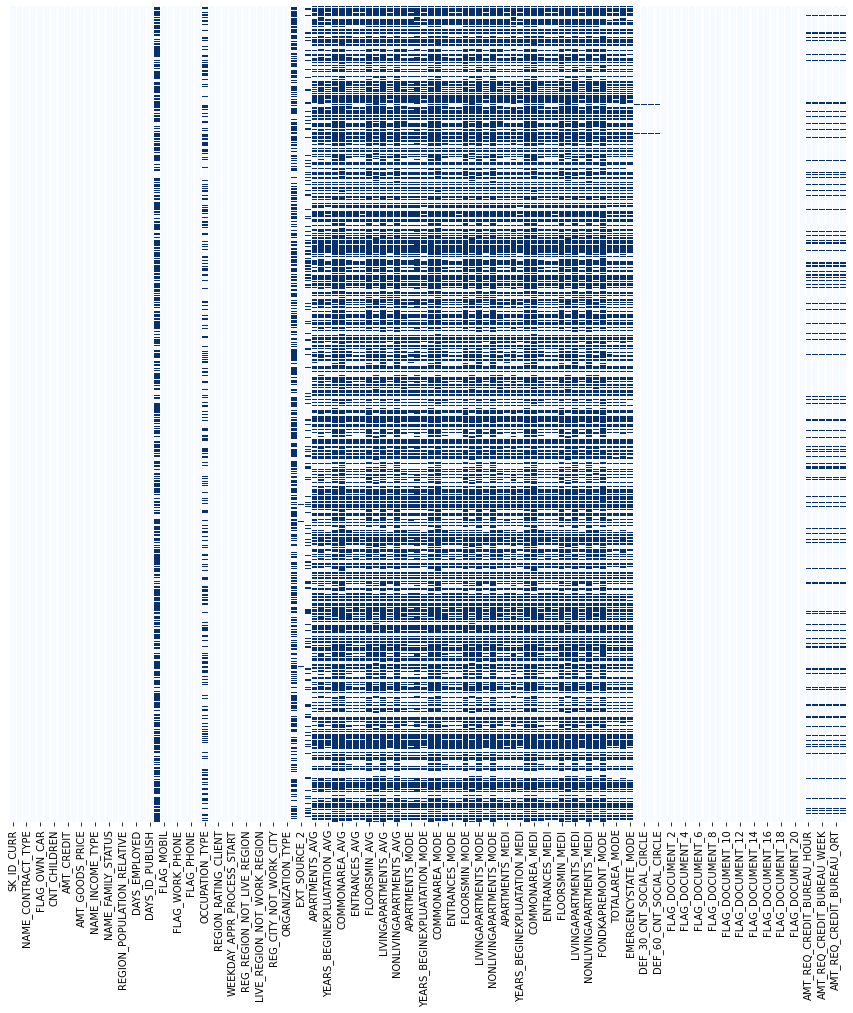

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_app_train.isnull(), yticklabels=False, cbar=False, cmap='Blues')

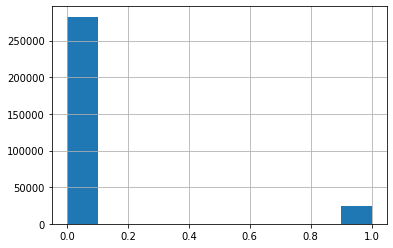

In [ ]:
df_app_train['TARGET'].hist()

In [ ]:
target_0 = df_app_train[df_app_train['TARGET']==0]
target_1 = df_app_train[df_app_train['TARGET']==1]

In [ ]:
print('Clientes que pagaram o empréstimo: {}, ou seja, {}% da base'.format(len(target_0) ,np.round(len(target_0)/len(df_app_train)*100,2)))
print('Clientes que não pagaram o empréstimo: {}, ou seja, {}% da base'.format(len(target_1) ,np.round(len(target_1)/len(df_app_train)*100,2)))

Clientes que pagaram o empréstimo: 282686, ou seja, 91.93% da base
Clientes que não pagaram o empréstimo: 24825, ou seja, 8.07% da base


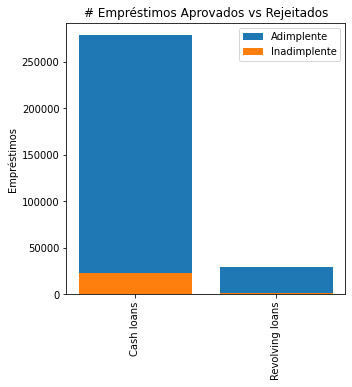

  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [ ]:
univariate_barplots(df_app_train, 'NAME_CONTRACT_TYPE', 'TARGET', False)

In [ ]:
print(len(target_0[target_0['NAME_CONTRACT_TYPE']=='Cash loans']))

255011


In [ ]:
univariate_percentage('NAME_CONTRACT_TYPE')

Porcentagem de adimplentes Revolving loans: 94.52%
Porcentagem de inadimplentes Revolving loans: 5.48%
Porcentagem de adimplentes Cash loans: 91.65%
Porcentagem de inadimplentes Cash loans: 8.35%


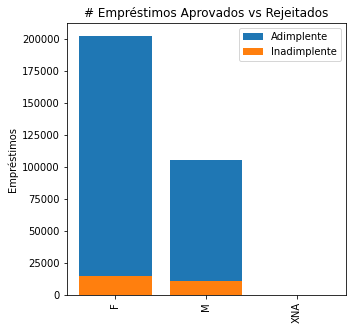

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [ ]:
univariate_barplots(df_app_train, 'CODE_GENDER', 'TARGET', False)

In [ ]:
total_mul = len(target_0[target_0['CODE_GENDER']=='F']) + len(target_1[target_1['CODE_GENDER']=='F'])
total_hom = len(target_0[target_0['CODE_GENDER']=='M']) + len(target_1[target_1['CODE_GENDER']=='M'])
adimplentes_mul_total = len(target_0[target_0['CODE_GENDER']=='F'])
adimplentes_hom_total = len(target_0[target_0['CODE_GENDER']=='M'])
inadimplentes_mul_total = len(target_1[target_1['CODE_GENDER']=='F'])
inadimplentes_hom_total = len(target_1[target_1['CODE_GENDER']=='M'])

print('Percentual de adimplentes mulheres: {}%'.format(round(adimplentes_mul_total/total_mul*100,2)))
print('Percentual de inadimplentes mulheres: {}%'.format(round(inadimplentes_mul_total/total_mul*100,2)))
print('Percentual de adimplentes homens: {}%'.format(round(adimplentes_hom_total/total_hom*100,2)))
print('Percentual de inadimplentes homens: {}%'.format(round(inadimplentes_hom_total/total_hom*100,2)))

Percentual de adimplentes mulheres: 93.0%
Percentual de inadimplentes mulheres: 7.0%
Percentual de adimplentes homens: 89.86%
Percentual de inadimplentes homens: 10.14%


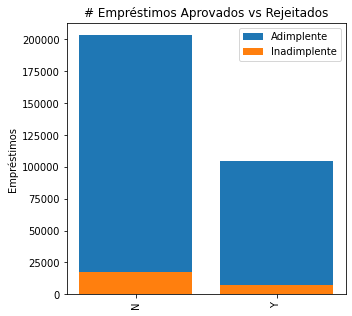

  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437


In [ ]:
# Análise do FLAG_OWN_CAR
univariate_barplots(df_app_train,'FLAG_OWN_CAR', 'TARGET', False)

In [ ]:
univariate_percentage('FLAG_OWN_CAR')

Porcentagem de adimplentes Y: 92.76%
Porcentagem de inadimplentes Y: 7.24%
Porcentagem de adimplentes N: 91.5%
Porcentagem de inadimplentes N: 8.5%


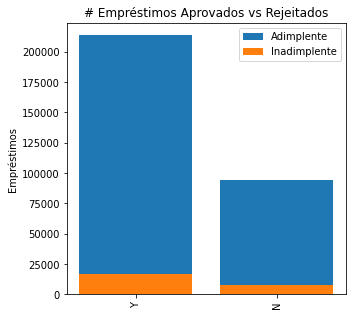

  FLAG_OWN_REALTY  TARGET   total       Avg
1               Y   16983  213312  0.079616
0               N    7842   94199  0.083249


In [ ]:
#FLAG_OWN_REALTY
univariate_barplots(df_app_train,'FLAG_OWN_REALTY','TARGET', False)

In [ ]:
univariate_percentage('FLAG_OWN_REALTY')

Porcentagem de adimplentes Y: 92.04%
Porcentagem de inadimplentes Y: 7.96%
Porcentagem de adimplentes N: 91.68%
Porcentagem de inadimplentes N: 8.32%


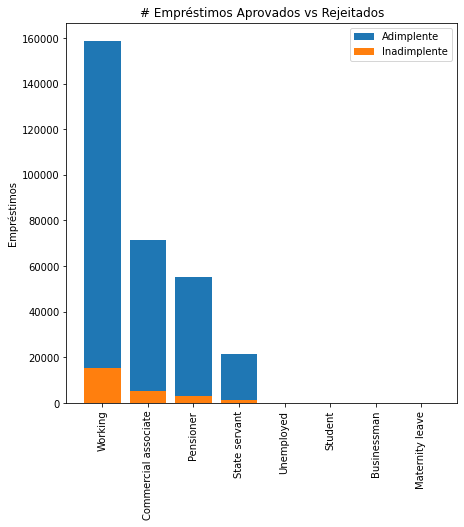

       NAME_INCOME_TYPE  TARGET   total       Avg
7               Working   15224  158774  0.095885
1  Commercial associate    5360   71617  0.074843
3             Pensioner    2982   55362  0.053864
4         State servant    1249   21703  0.057550
6            Unemployed       8      22  0.363636
5               Student       0      18  0.000000
0           Businessman       0      10  0.000000
2       Maternity leave       2       5  0.400000


In [ ]:
univariate_barplots(df_app_train,'NAME_INCOME_TYPE','TARGET',False)

In [ ]:
univariate_percentage('NAME_INCOME_TYPE')

Porcentagem de adimplentes Student: 100.0%
Porcentagem de inadimplentes Student: 0.0%
Porcentagem de adimplentes State servant: 94.25%
Porcentagem de inadimplentes State servant: 5.75%
Porcentagem de adimplentes Businessman: 100.0%
Porcentagem de inadimplentes Businessman: 0.0%
Porcentagem de adimplentes Commercial associate: 92.52%
Porcentagem de inadimplentes Commercial associate: 7.48%
Porcentagem de adimplentes Maternity leave: 60.0%
Porcentagem de inadimplentes Maternity leave: 40.0%
Porcentagem de adimplentes Working: 90.41%
Porcentagem de inadimplentes Working: 9.59%
Porcentagem de adimplentes Unemployed: 63.64%
Porcentagem de inadimplentes Unemployed: 36.36%
Porcentagem de adimplentes Pensioner: 94.61%
Porcentagem de inadimplentes Pensioner: 5.39%


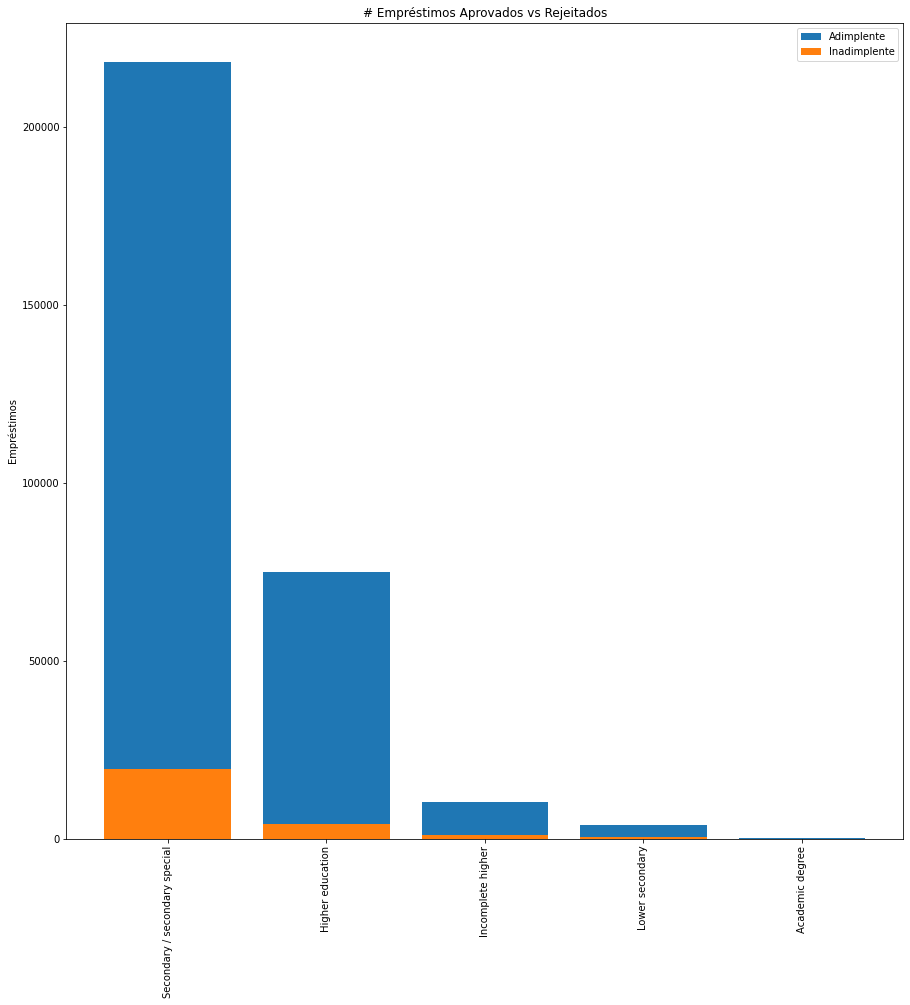

             NAME_EDUCATION_TYPE  TARGET   total       Avg
4  Secondary / secondary special   19524  218391  0.089399
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
0                Academic degree       3     164  0.018293


In [ ]:
univariate_barplots(df_app_train, 'NAME_EDUCATION_TYPE', 'TARGET', False)

In [ ]:
univariate_percentage('NAME_EDUCATION_TYPE')

Porcentagem de adimplentes Secondary / secondary special: 91.06%
Porcentagem de inadimplentes Secondary / secondary special: 8.94%
Porcentagem de adimplentes Lower secondary: 89.07%
Porcentagem de inadimplentes Lower secondary: 10.93%
Porcentagem de adimplentes Incomplete higher: 91.52%
Porcentagem de inadimplentes Incomplete higher: 8.48%
Porcentagem de adimplentes Academic degree: 98.17%
Porcentagem de inadimplentes Academic degree: 1.83%
Porcentagem de adimplentes Higher education: 94.64%
Porcentagem de inadimplentes Higher education: 5.36%


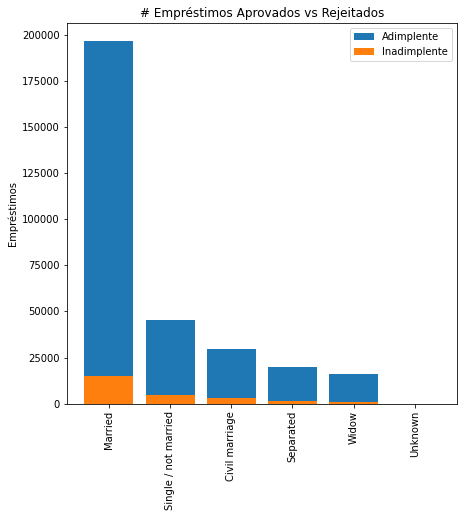

     NAME_FAMILY_STATUS  TARGET   total       Avg
1               Married   14850  196432  0.075599
3  Single / not married    4457   45444  0.098077
0        Civil marriage    2961   29775  0.099446
2             Separated    1620   19770  0.081942
5                 Widow     937   16088  0.058242
4               Unknown       0       2  0.000000


In [ ]:
univariate_barplots(df_app_train,'NAME_FAMILY_STATUS','TARGET',False)

In [ ]:
univariate_percentage('NAME_FAMILY_STATUS')

Porcentagem de adimplentes Unknown: 100.0%
Porcentagem de inadimplentes Unknown: 0.0%
Porcentagem de adimplentes Widow: 94.18%
Porcentagem de inadimplentes Widow: 5.82%
Porcentagem de adimplentes Separated: 91.81%
Porcentagem de inadimplentes Separated: 8.19%
Porcentagem de adimplentes Single / not married: 90.19%
Porcentagem de inadimplentes Single / not married: 9.81%
Porcentagem de adimplentes Civil marriage: 90.06%
Porcentagem de inadimplentes Civil marriage: 9.94%
Porcentagem de adimplentes Married: 92.44%
Porcentagem de inadimplentes Married: 7.56%


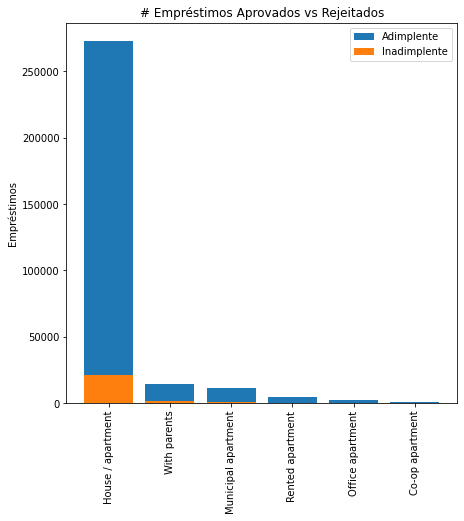

     NAME_HOUSING_TYPE  TARGET   total       Avg
1    House / apartment   21272  272868  0.077957
5         With parents    1736   14840  0.116981
2  Municipal apartment     955   11183  0.085397
4     Rented apartment     601    4881  0.123131
3     Office apartment     172    2617  0.065724
0      Co-op apartment      89    1122  0.079323


In [ ]:
univariate_barplots(df_app_train,'NAME_HOUSING_TYPE','TARGET',False)

In [ ]:
univariate_percentage('NAME_HOUSING_TYPE')

Porcentagem de adimplentes Office apartment: 93.43%
Porcentagem de inadimplentes Office apartment: 6.57%
Porcentagem de adimplentes House / apartment: 92.2%
Porcentagem de inadimplentes House / apartment: 7.8%
Porcentagem de adimplentes Rented apartment: 87.69%
Porcentagem de inadimplentes Rented apartment: 12.31%
Porcentagem de adimplentes Municipal apartment: 91.46%
Porcentagem de inadimplentes Municipal apartment: 8.54%
Porcentagem de adimplentes With parents: 88.3%
Porcentagem de inadimplentes With parents: 11.7%
Porcentagem de adimplentes Co-op apartment: 92.07%
Porcentagem de inadimplentes Co-op apartment: 7.93%


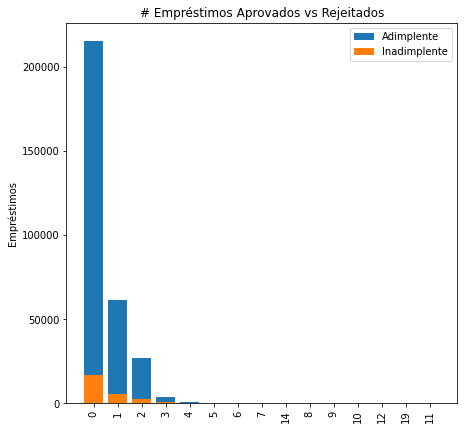

    CNT_CHILDREN  TARGET   total       Avg
0              0   16609  215371  0.077118
1              1    5454   61119  0.089236
2              2    2333   26749  0.087218
3              3     358    3717  0.096314
4              4      55     429  0.128205
5              5       7      84  0.083333
6              6       6      21  0.285714
7              7       0       7  0.000000
13            14       0       3  0.000000
8              8       0       2  0.000000


In [ ]:
univariate_barplots(df_app_train,'CNT_CHILDREN','TARGET',False)

In [ ]:
univariate_percentage('CNT_CHILDREN')

Porcentagem de adimplentes 0: 92.29%
Porcentagem de inadimplentes 0: 7.71%
Porcentagem de adimplentes 1: 91.08%
Porcentagem de inadimplentes 1: 8.92%
Porcentagem de adimplentes 2: 91.28%
Porcentagem de inadimplentes 2: 8.72%
Porcentagem de adimplentes 3: 90.37%
Porcentagem de inadimplentes 3: 9.63%
Porcentagem de adimplentes 4: 87.18%
Porcentagem de inadimplentes 4: 12.82%
Porcentagem de adimplentes 5: 91.67%
Porcentagem de inadimplentes 5: 8.33%
Porcentagem de adimplentes 6: 71.43%
Porcentagem de inadimplentes 6: 28.57%
Porcentagem de adimplentes 7: 100.0%
Porcentagem de inadimplentes 7: 0.0%
Porcentagem de adimplentes 8: 100.0%
Porcentagem de inadimplentes 8: 0.0%
Porcentagem de adimplentes 9: 0.0%
Porcentagem de inadimplentes 9: 100.0%
Porcentagem de adimplentes 10: 100.0%
Porcentagem de inadimplentes 10: 0.0%
Porcentagem de adimplentes 11: 0.0%
Porcentagem de inadimplentes 11: 100.0%
Porcentagem de adimplentes 12: 100.0%
Porcentagem de inadimplentes 12: 0.0%
Porcentagem de adimplen

In [ ]:
data_income = df_app_train.groupby('SK_ID_CURR').agg({'AMT_INCOME_TOTAL':'mean'}).reset_index()
data_income.head(5)

SK_ID_CURR  AMT_INCOME_TOTAL
0      100002          202500.0
1      100003          270000.0
2      100004           67500.0
3      100006          135000.0
4      100007          121500.0

In [ ]:
data_income_final = pd.merge(df_app_train, data_income, on = 'SK_ID_CURR', how = 'left')

approved_income = data_income_final[data_income_final['TARGET']==0]['AMT_INCOME_TOTAL_x'].values
rejected_income = data_income_final[data_income_final['TARGET']==1]['AMT_INCOME_TOTAL_x'].values

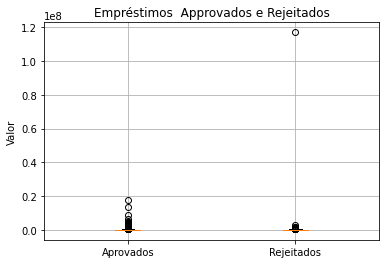

In [ ]:
plt.boxplot([approved_income, rejected_income])
plt.title('Empréstimos  Approvados e Rejeitados')
plt.xticks([1,2],('Aprovados','Rejeitados'))
plt.ylabel('Valor')
plt.grid()
plt.show()

In [ ]:
from prettytable import PrettyTable

t = PrettyTable()
t.field_names = ['Percentil', 'Aprovados', 'Rejeitados']

for i in range(0,101,5):
  t.add_row([i,np.round(np.percentile(approved_income, i),3),\
             np.round(np.percentile(rejected_income,i),3)])

print(t)

+-----------+------------+-------------+
| Percentil | Aprovados  |  Rejeitados |
+-----------+------------+-------------+
|     0     |  25650.0   |   25650.0   |
|     5     |  67500.0   |   67500.0   |
|     10    |  81000.0   |   81000.0   |
|     15    |  90000.0   |   90000.0   |
|     20    |  99000.0   |   99000.0   |
|     25    |  112500.0  |   112500.0  |
|     30    |  112500.0  |   112500.0  |
|     35    |  126000.0  |   120873.6  |
|     40    |  135000.0  |   135000.0  |
|     45    |  135000.0  |   135000.0  |
|     50    |  148500.0  |   135000.0  |
|     55    |  157500.0  |   157500.0  |
|     60    |  166500.0  |   157500.0  |
|     65    |  180000.0  |   175500.0  |
|     70    |  185400.0  |   180000.0  |
|     75    |  202500.0  |   202500.0  |
|     80    |  225000.0  |   202500.0  |
|     85    |  243000.0  |   225000.0  |
|     90    |  270000.0  |   256500.0  |
|     95    |  337500.0  |   315000.0  |
|    100    | 18000090.0 | 117000000.0 |
+-----------+---

In [ ]:
approved_amt_credit = df_app_train[df_app_train['TARGET']==0]['AMT_CREDIT'].values
rejected_amt_credit = df_app_train[df_app_train['TARGET']==1]['AMT_CREDIT'].values

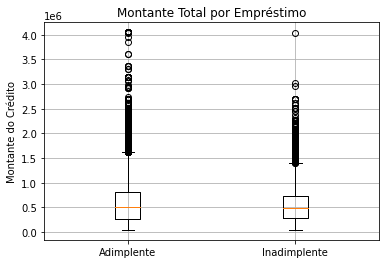

In [ ]:
plt.boxplot([approved_amt_credit, rejected_amt_credit])
plt.title('Montante Total por Empréstimo')
plt.xticks([1,2],('Adimplente','Inadimplente'))
plt.ylabel('Montante do Crédito')
plt.grid()
plt.show()

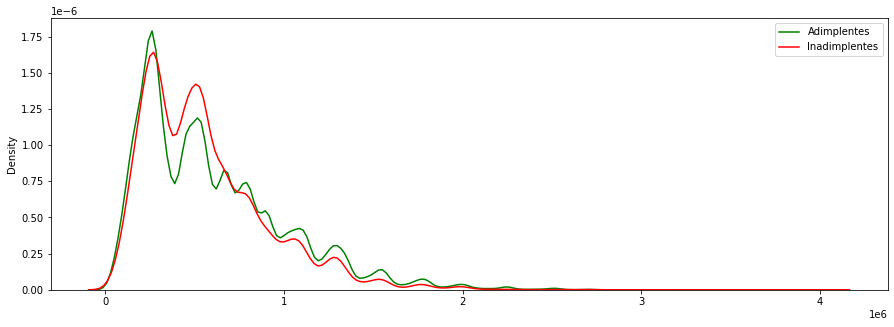

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(approved_amt_credit, hist=False, label='Adimplentes', color='green')
sns.distplot(rejected_amt_credit, hist=False, label='Inadimplentes', color='red')
plt.legend()
plt.show()

In [ ]:
approved_amt_annuity = df_app_train[df_app_train['TARGET'] == 0]['AMT_ANNUITY'].values
rejected_amt_annuity = df_app_train[df_app_train['TARGET'] == 1]['AMT_ANNUITY'].values

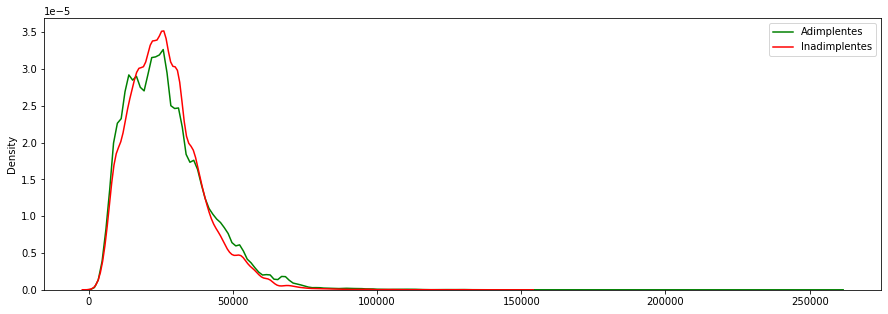

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(approved_amt_annuity, hist=False, label='Adimplentes', color='green')
sns.distplot(rejected_amt_annuity, hist=False, label='Inadimplentes', color='red')
plt.legend()
plt.show()

In [ ]:
approved_goods_price = df_app_train[df_app_train['TARGET'] == 0]['AMT_GOODS_PRICE'].values
rejected_goods_price = df_app_train[df_app_train['TARGET'] == 1]['AMT_GOODS_PRICE'].values

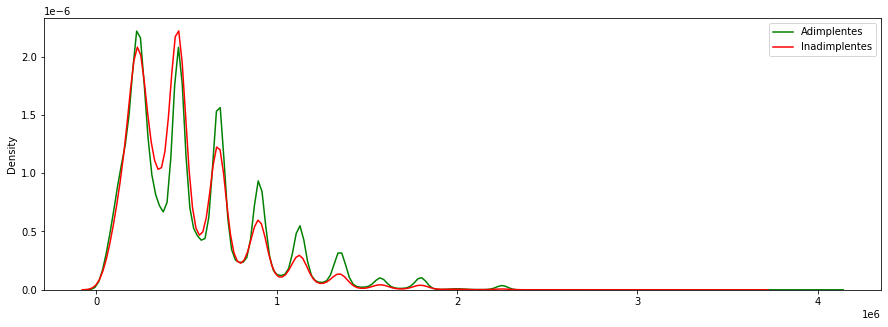

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(approved_goods_price, hist=False, label='Adimplentes', color='green')
sns.distplot(rejected_goods_price, hist=False, label='Inadimplentes', color='red')
plt.legend()
plt.show()

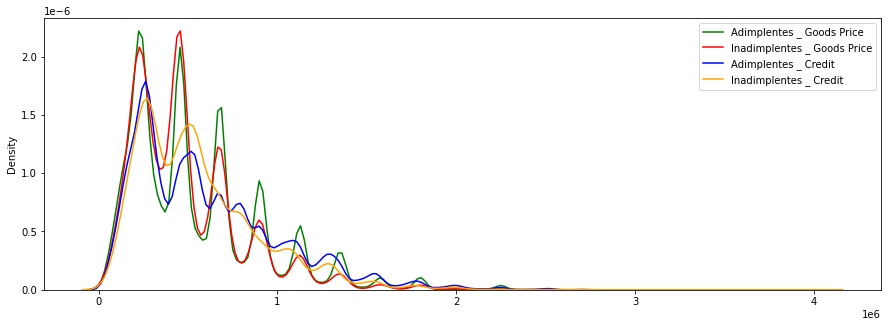

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(approved_goods_price, hist=False, label='Adimplentes _ Goods Price', color='green')
sns.distplot(rejected_goods_price, hist=False, label='Inadimplentes _ Goods Price', color='red')
sns.distplot(approved_amt_credit, hist=False, label='Adimplentes _ Credit' , color='blue')
sns.distplot(rejected_amt_credit, hist=False, label='Inadimplentes _ Credit', color='orange')
plt.legend()
plt.show()

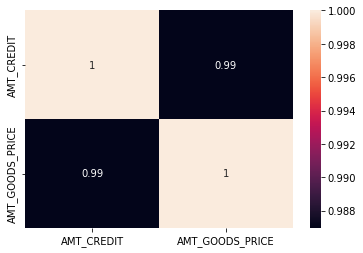

In [ ]:
rel_credit_goodprice = df_app_train[['AMT_CREDIT','AMT_GOODS_PRICE']]
corr = rel_credit_goodprice.corr()
sns.heatmap(corr, annot=True)

In [ ]:
approved_days_birth = df_app_train[df_app_train['TARGET'] == 0]['DAYS_BIRTH'].values/365
rejected_days_birth = df_app_train[df_app_train['TARGET'] == 1]['DAYS_BIRTH'].values/365

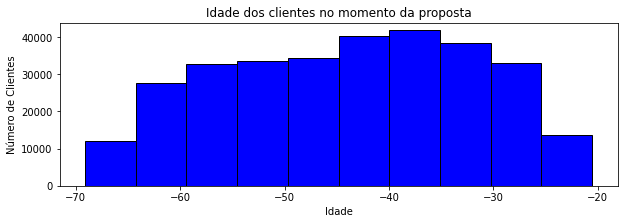

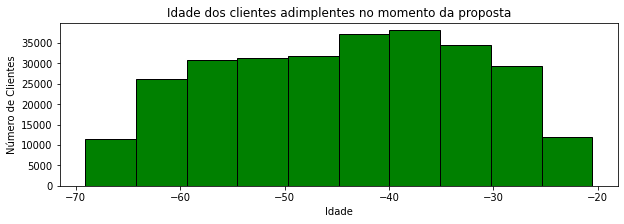

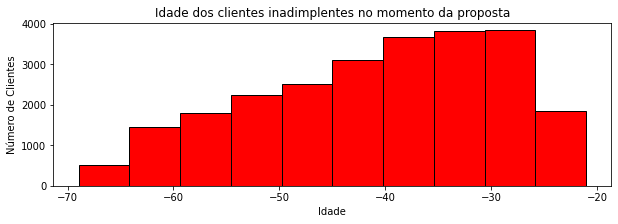

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(df_app_train['DAYS_BIRTH'].values/365, bins = 10, color = 'blue', edgecolor='black')
plt.title('Idade dos clientes no momento da proposta')
plt.xlabel('Idade')
plt.ylabel('Número de Clientes')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(approved_days_birth, bins = 10, color = 'green',edgecolor='black')
plt.title('Idade dos clientes adimplentes no momento da proposta')
plt.xlabel('Idade')
plt.ylabel('Número de Clientes')
plt.show()

plt.figure(figsize=(10,3))
plt.hist(rejected_days_birth, bins = 10, color = 'red', edgecolor='black')
plt.title('Idade dos clientes inadimplentes no momento da proposta')
plt.xlabel('Idade')
plt.ylabel('Número de Clientes')
plt.show()

In [ ]:
approved_days_employed = df_app_train[df_app_train['TARGET'] == 0]['DAYS_EMPLOYED'].values / 365
rejected_days_employed = df_app_train[df_app_train['TARGET'] == 1]['DAYS_EMPLOYED'].values / 365

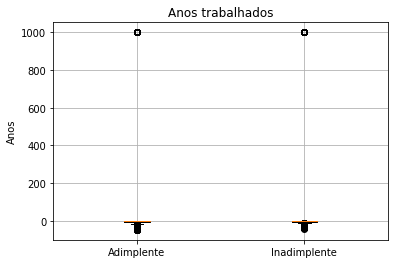

In [ ]:
plt.boxplot([approved_days_employed, rejected_days_employed])
plt.title('Anos trabalhados')
plt.xticks([1,2],('Adimplente','Inadimplente'))
plt.ylabel('Anos')
plt.grid()
plt.show()

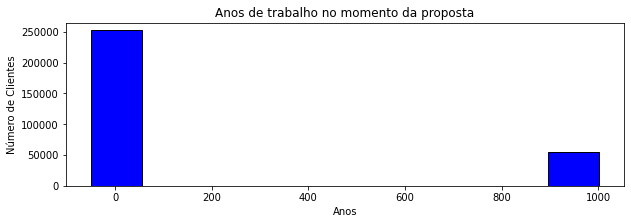

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(df_app_train['DAYS_EMPLOYED'].values/365, bins = 10, color = 'blue', edgecolor='black')
plt.title('Anos de trabalho no momento da proposta')
plt.xlabel('Anos')
plt.ylabel('Número de Clientes')
plt.show()

In [ ]:
approved_days_employed.mean()

179.9894414335903

In [ ]:
rejected_days_employed.mean()

116.14979574832043

In [ ]:
approved_days_registration = df_app_train[df_app_train['TARGET'] == 0]['DAYS_REGISTRATION'].values / 365
rejected_days_registration = df_app_train[df_app_train['TARGET'] == 1]['DAYS_REGISTRATION'].values / 365

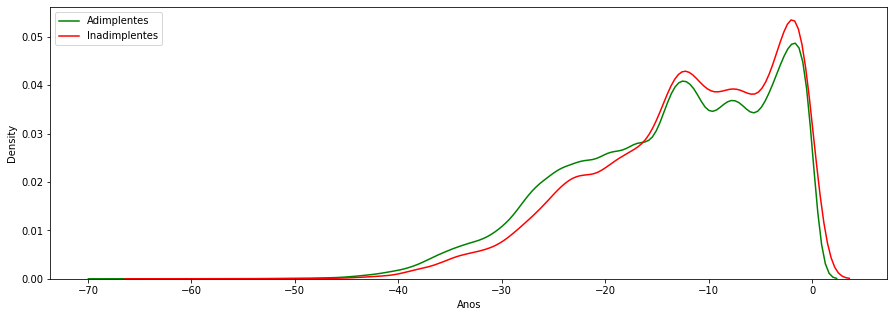

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(approved_days_registration, hist=False, label='Adimplentes', color='green')
sns.distplot(rejected_days_registration, hist=False, label='Inadimplentes', color='red')
plt.xlabel('Anos')
plt.legend()
plt.show()

In [ ]:
approved_days_ID_publish = df_app_train[df_app_train['TARGET'] == 0]['DAYS_ID_PUBLISH'].values/365
rejected_days_ID_publish = df_app_train[df_app_train['TARGET'] == 1]['DAYS_ID_PUBLISH'].values/365

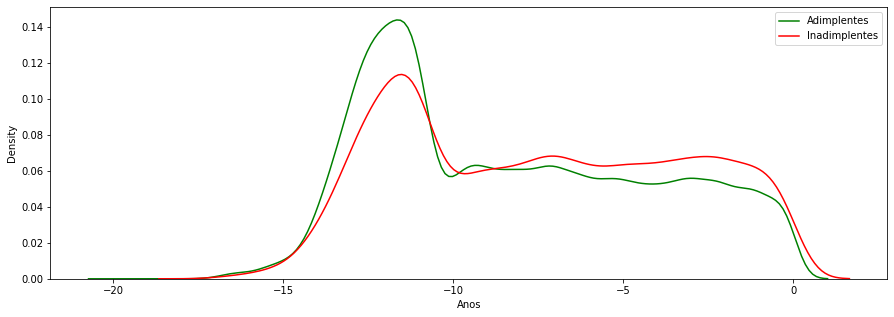

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(approved_days_ID_publish, hist=False, label='Adimplentes', color='green')
sns.distplot(rejected_days_ID_publish, hist=False, label='Inadimplentes', color='red')
plt.xlabel('Anos')
plt.legend()
plt.show()

In [ ]:
approved_own_car_age = df_app_train[df_app_train['TARGET'] == 0]['OWN_CAR_AGE']
rejected_own_car_age = df_app_train[df_app_train['TARGET'] == 1]['OWN_CAR_AGE']

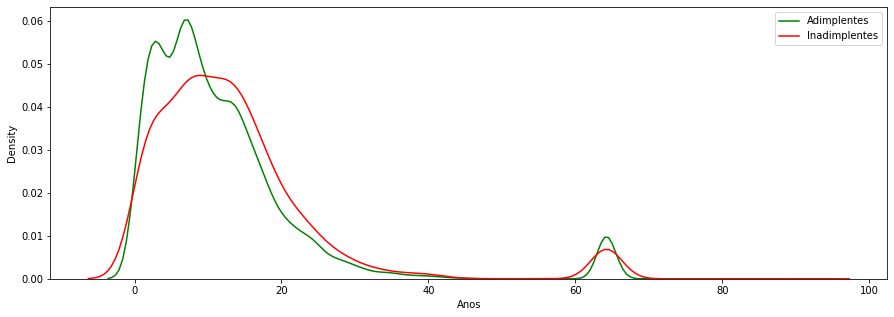

In [ ]:
plt.figure(figsize = (15,5))
sns.distplot(approved_own_car_age, hist=False, label='Adimplentes', color='green')
sns.distplot(rejected_own_car_age, hist=False, label='Inadimplentes', color='red')
plt.xlabel('Anos')
plt.legend()
plt.show()

In [ ]:
df_app_train['FLAG_MOBIL'].value_counts()

1    307510
0         1
Name: FLAG_MOBIL, dtype: int64

In [ ]:
approved_flag_emp_phone = df_app_train[df_app_train['TARGET'] == 0]['FLAG_EMP_PHONE'].values
rejected_flag_emp_phone = df_app_train[df_app_train['TARGET'] == 1]['FLAG_EMP_PHONE'].values

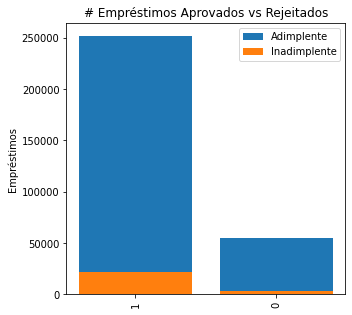

   FLAG_EMP_PHONE  TARGET   total       Avg
1               1   21834  252125  0.086600
0               0    2991   55386  0.054003


In [ ]:
univariate_barplots(df_app_train,'FLAG_EMP_PHONE','TARGET',False)

In [ ]:
univariate_percentage('FLAG_EMP_PHONE')

Porcentagem de adimplentes 0: 94.6%
Porcentagem de inadimplentes 0: 5.4%
Porcentagem de adimplentes 1: 91.34%
Porcentagem de inadimplentes 1: 8.66%


In [ ]:
numerador = len(df_app_train[df_app_train['FLAG_EMP_PHONE']==0])
denominador = len(df_app_train[df_app_train['FLAG_EMP_PHONE']==0]) + len(df_app_train[df_app_train['FLAG_EMP_PHONE']==1])
percentual_flag_emp_phone_0 =  numerador / denominador
print('{}%'.format(round(percentual_flag_emp_phone_0*100,2)))

18.01%


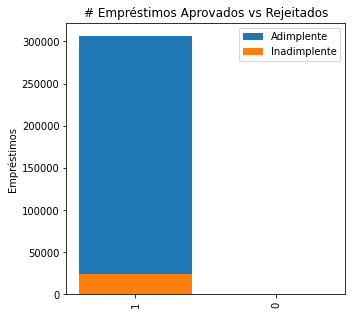

   FLAG_CONT_MOBILE  TARGET   total       Avg
1                 1   24780  306937  0.080733
0                 0      45     574  0.078397


In [ ]:
df_app_train['FLAG_CONT_MOBILE'].fillna('Não informado', inplace=True)
univariate_barplots(df_app_train,'FLAG_CONT_MOBILE','TARGET',False)

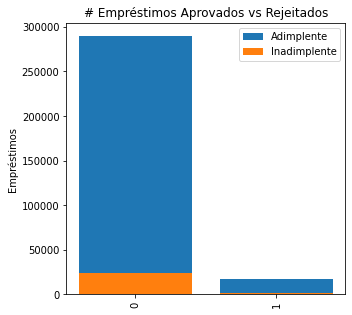

   FLAG_EMAIL  TARGET   total       Avg
0           0   23451  290069  0.080846
1           1    1374   17442  0.078775


In [ ]:
df_app_train['FLAG_EMAIL'].fillna('Sem dados', inplace=True)
univariate_barplots(df_app_train,'FLAG_EMAIL','TARGET',False)

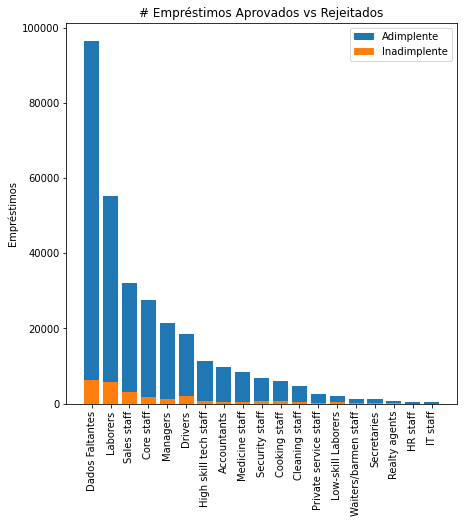

          OCCUPATION_TYPE  TARGET  total       Avg
4         Dados Faltantes    6278  96391  0.065131
9                Laborers    5838  55186  0.105788
15            Sales staff    3092  32102  0.096318
3              Core staff    1738  27570  0.063040
11               Managers    1328  21371  0.062140
5                 Drivers    2107  18603  0.113261
7   High skill tech staff     701  11380  0.061599
0             Accountants     474   9813  0.048303
12         Medicine staff     572   8537  0.067002
17         Security staff     722   6721  0.107424


In [ ]:
df_app_train['OCCUPATION_TYPE'].fillna('Dados Faltantes', inplace = True)
univariate_barplots(df_app_train,'OCCUPATION_TYPE', 'TARGET', False)

In [ ]:
univariate_percentage('OCCUPATION_TYPE')

Porcentagem de adimplentes nan: 0.0%
Porcentagem de inadimplentes nan: 0.0%
Porcentagem de adimplentes Managers: 93.79%
Porcentagem de inadimplentes Managers: 6.21%
Porcentagem de adimplentes Core staff: 93.7%
Porcentagem de inadimplentes Core staff: 6.3%
Porcentagem de adimplentes Accountants: 95.17%
Porcentagem de inadimplentes Accountants: 4.83%
Porcentagem de adimplentes Cooking staff: 89.56%
Porcentagem de inadimplentes Cooking staff: 10.44%
Porcentagem de adimplentes High skill tech staff: 93.84%
Porcentagem de inadimplentes High skill tech staff: 6.16%
Porcentagem de adimplentes Low-skill Laborers: 82.85%
Porcentagem de inadimplentes Low-skill Laborers: 17.15%
Porcentagem de adimplentes Realty agents: 92.14%
Porcentagem de inadimplentes Realty agents: 7.86%
Porcentagem de adimplentes Waiters/barmen staff: 88.72%
Porcentagem de inadimplentes Waiters/barmen staff: 11.28%
Porcentagem de adimplentes HR staff: 93.61%
Porcentagem de inadimplentes HR staff: 6.39%
Porcentagem de adimple

In [ ]:
df_app_train['CNT_FAM_MEMBERS'].fillna('1', inplace = True)

In [ ]:
approved_cnt_family_members = df_app_train[df_app_train['TARGET'] == 0]['CNT_FAM_MEMBERS'].values
rejected_cnt_family_members = df_app_train[df_app_train['TARGET'] == 1]['CNT_FAM_MEMBERS'].values

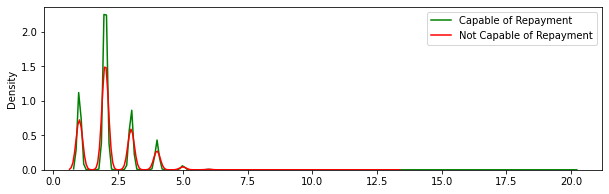

In [ ]:
plt.figure(figsize=(10,3))
sns.distplot(approved_cnt_family_members,hist=False,label="Capable of Repayment", color='green')
sns.distplot(rejected_cnt_family_members,hist=False,label="Not Capable of Repayment", color='red')
plt.legend()
plt.show()

In [ ]:
del df_app_train
gc.collect()

18602

##**Tabela:** bureau.csv

In [ ]:
df_bureau = reduce_memory_usage(pd.read_csv(db_dir+'/bureau.csv'))

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%


In [ ]:
df_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [ ]:
df_bureau.shape

(1716428, 17)

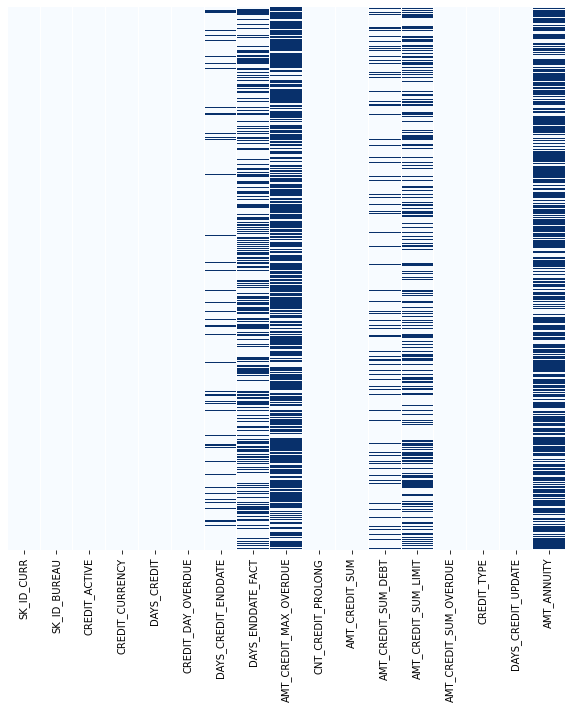

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_bureau.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
df_bureau.describe()

SK_ID_CURR  SK_ID_BUREAU   DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
count  1.716428e+06  1.716428e+06  1.716428e+06        1.716428e+06   
mean   2.782149e+05  5.924434e+06 -1.142108e+03        8.181666e-01   
std    1.029386e+05  5.322657e+05  7.951649e+02        3.654443e+01   
min    1.000010e+05  5.000000e+06 -2.922000e+03        0.000000e+00   
25%    1.888668e+05  5.463954e+06 -1.666000e+03        0.000000e+00   
50%    2.780550e+05  5.926304e+06 -9.870000e+02        0.000000e+00   
75%    3.674260e+05  6.385681e+06 -4.740000e+02        0.000000e+00   
max    4.562550e+05  6.843457e+06  0.000000e+00        2.792000e+03   

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count            1610875.0          1082775.0            5.919400e+05   
mean                   NaN                NaN            3.825417e+03   
std                    NaN                NaN            2.060316e+05   
min               -42048.0           -42016.0            0.000000e+00   
25%                -1138.0            -1489.0            0.000000e+00   
50%                 -330.0             -897.0            0.000000e+00   
75%                  474.0             -425.0            0.000000e+00   
max                31200.0                0.0            1.159872e+08   

       CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
count        1.716428e+06    1.716415e+06         1.458759e+06   
mean         6.410406e-03    3.549946e+05         1.370851e+05   
std          9.622391e-02    1.149811e+06         6.774011e+05   
min          0.000000e+00    0.000000e+00        -4.705600e+06   
25%          0.000000e+00    5.130000e+04         0.000000e+00   
50%          0.000000e+00    1.255185e+05         0.000000e+00   
75%          0.000000e+00    3.150000e+05         4.015350e+04   
max          9.000000e+00    5.850000e+08         1.701000e+08   

       AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
count          1.124648e+06            1.716428e+06        1.716428e+06   
mean           6.229514e+03            3.791277e+01       -5.937483e+02   
std            4.503203e+04            5.937650e+03        7.207473e+02   
min           -5.864061e+05            0.000000e+00       -4.194700e+04   
25%            0.000000e+00            0.000000e+00       -9.080000e+02   
50%            0.000000e+00            0.000000e+00       -3.950000e+02   
75%            0.000000e+00            0.000000e+00       -3.300000e+01   
max            4.705600e+06            3.756681e+06        3.720000e+02   

        AMT_ANNUITY  
count  4.896370e+05  
mean   1.571276e+04  
std    3.258269e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.350000e+04  
max    1.184534e+08

In [ ]:
counter_credit_active = counter_generator(df_bureau,'CREDIT_ACTIVE')
print(counter_credit_active)

Counter({'Closed': 1079273, 'Active': 630607, 'Sold': 6527, 'Bad debt': 21})


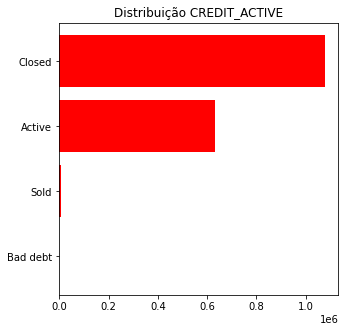

In [ ]:
bar_graph_from_counter(counter_credit_active, 'Distribuição CREDIT_ACTIVE',(5,5), False,'red')

In [ ]:
counter_credit_currency = counter_generator(df_bureau,'CREDIT_CURRENCY')
print(counter_credit_currency)

Counter({'currency 1': 1715020, 'currency 2': 1224, 'currency 3': 174, 'currency 4': 10})


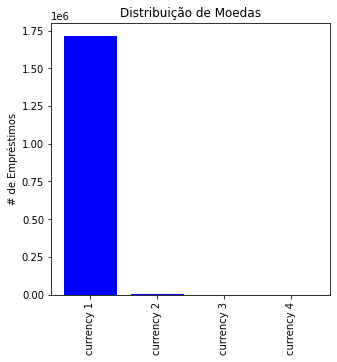

In [ ]:
bar_graph_from_counter(counter_credit_currency, 'Distribuição de Moedas',(5,5))

In [ ]:
print(counter_percentage(counter_credit_currency))


+------------+---------+-------------------+
| Categoria  |  Total  | PerCent Total (%) |
+------------+---------+-------------------+
| currency 1 | 1715020 |       99.92       |
| currency 2 |   1224  |        0.07       |
| currency 4 |    10   |        0.0        |
| currency 3 |   174   |        0.01       |
+------------+---------+-------------------+


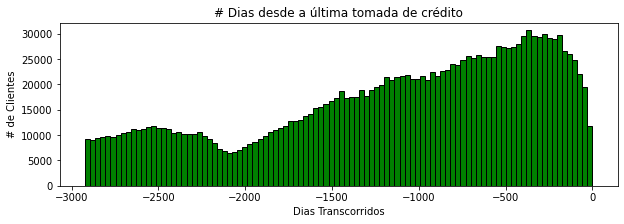

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(df_bureau['DAYS_CREDIT'].values, bins = 100, edgecolor='black', color='green')
plt.title('# Dias desde a última tomada de crédito')
plt.xlabel('Dias Transcorridos')
plt.ylabel('# de Clientes')
plt.show()

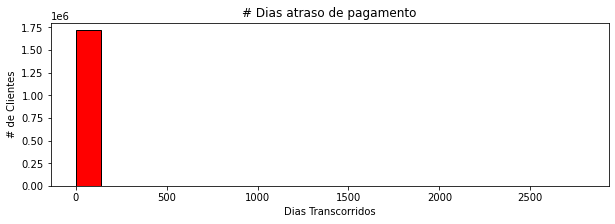

In [ ]:
plt.figure(figsize=(10,3))
plt.hist(df_bureau['CREDIT_DAY_OVERDUE'].values, bins = 20, edgecolor='black', color='red')
plt.title('# Dias atraso de pagamento')
plt.xlabel('Dias Transcorridos')
plt.ylabel('# de Clientes')
plt.show()

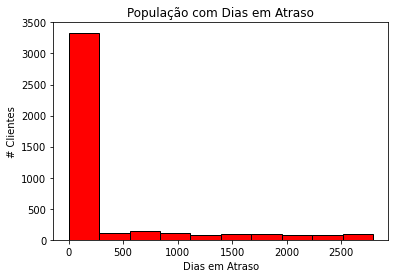

Total de clientes em atraso: 4217


In [ ]:
df_temp = df_bureau[df_bureau['CREDIT_DAY_OVERDUE'] > 0]
plt.hist(df_temp['CREDIT_DAY_OVERDUE'], bins=10, edgecolor='black', color='red')
plt.title('População com Dias em Atraso')
plt.xlabel('Dias em Atraso')
plt.ylabel('# Clientes')
plt.show()
print('Total de clientes em atraso: {}'.format(len(df_temp)))

In [ ]:
t = PrettyTable()
t.field_names = ["Over","# Clientes", '%']
t1 = 0
t30 = 0
t60 = 0
t90 = 0
t120 = 0
t180 = 0
for i in df_temp['CREDIT_DAY_OVERDUE']:
  if i >= 180:
    t180 = t180 + 1
  if i >= 120 and i < 180:
    t120 = t120 + 1
  if i >= 90 and i < 120:
    t90 = t90 + 1
  if i >= 60 and i < 90:
    t60 = t60 + 1
  if i >= 30 and i < 60:
    t30 = t30 + 1
  if i > 0 and i < 30:
    t1 = t1 + 1

total = t1 + t30 + t60 + t90 + t120 + t180

t.add_row(['Até 30 dias',t1,round(t1/total*100,2)])
t.add_row(['Mais de 30 dias',t30,round(t30/total*100,2)])
t.add_row(['Mais de 60 dias',t60,round(60/total*100,2)])
t.add_row(['Mais de 90 dias',t90,round(t90/total*100,2)])
t.add_row(['Mais de 120 dias',t120,round(t120/total*100,2)])
t.add_row(['Mais de 180 dias',t180,round(t180/total*100,2)])
t.add_row(['Total',total,round(total/total*100,2)])
print(t)

+------------------+------------+-------+
|       Over       | # Clientes |   %   |
+------------------+------------+-------+
|   Até 30 dias    |    1700    | 40.31 |
| Mais de 30 dias  |    877     |  20.8 |
| Mais de 60 dias  |    341     |  1.42 |
| Mais de 90 dias  |    131     |  3.11 |
| Mais de 120 dias |    190     |  4.51 |
| Mais de 180 dias |    978     | 23.19 |
|      Total       |    4217    | 100.0 |
+------------------+------------+-------+


In [ ]:
counter_credit_type = counter_generator(df_bureau,'CREDIT_TYPE')

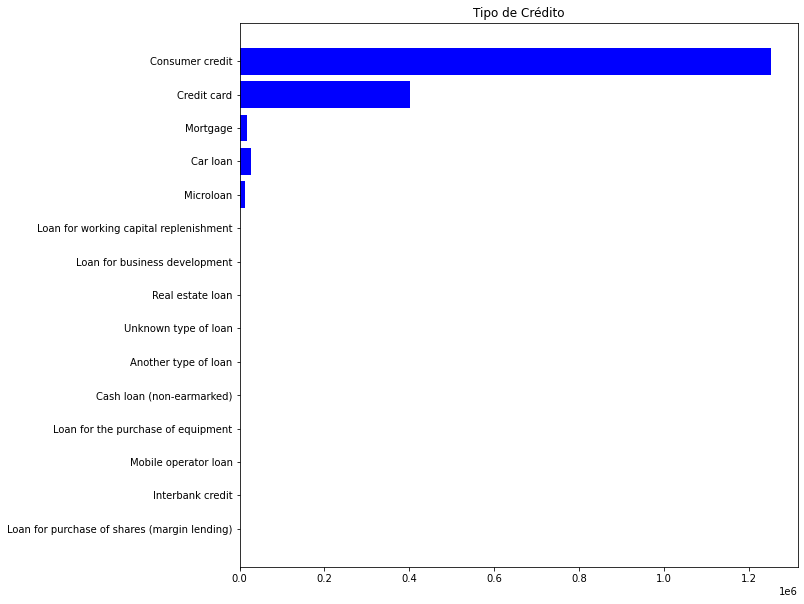

In [ ]:
bar_graph_from_counter(counter_credit_type,'Tipo de Crédito',(10,10),False)

In [ ]:
df_bureau.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [ ]:
df_bureau['DAYS_CREDIT_ENDDATE'].fillna(0, inplace=True)
df_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  0.0                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [ ]:
df_bureau_active = df_bureau[df_bureau['CREDIT_ACTIVE']=='Active']
df_bureau_active.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   
5      215354       5714467        Active      currency 1         -273   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  0.0                NaN   
4                   0               1197.0                NaN   
5                   0              27456.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   
5                     0.0                   0        180000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
1        171342.000000                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   
5         71017.382812         108982.617188                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN  
5      Credit card                 -31          NaN

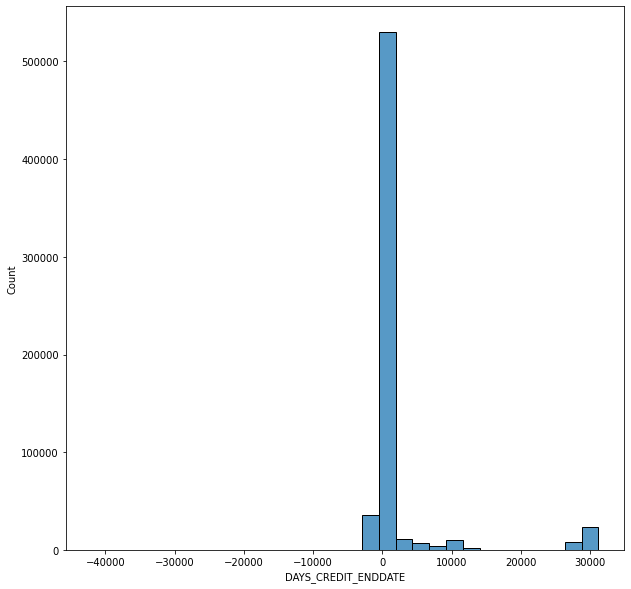

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(data=df_bureau_active,x='DAYS_CREDIT_ENDDATE',bins=30)

In [ ]:
del df_bureau
gc.collect()

25214

##**Tabela:** bureau_balance.csv

In [ ]:
df_bureau_balance = reduce_memory_usage(pd.read_csv(db_dir+'/bureau_balance.csv'))

Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


In [ ]:
df_bureau_balance.head(10)

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C
5       5715448              -5      C
6       5715448              -6      C
7       5715448              -7      C
8       5715448              -8      C
9       5715448              -9      0

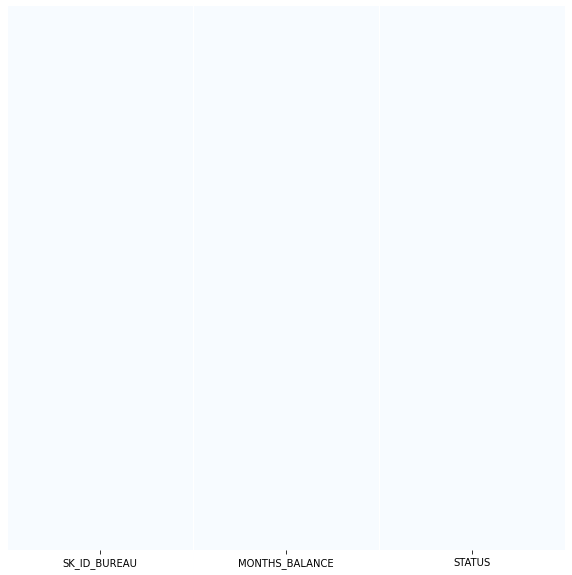

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_bureau_balance.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
df_bureau_balance.shape

(27299925, 3)

In [ ]:
df_bureau_balance['MONTHS_BALANCE'].unique()

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64,
       -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77,
       -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89, -90,
       -91, -92, -93, -94, -95, -96], dtype=int8)

In [ ]:
df_bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

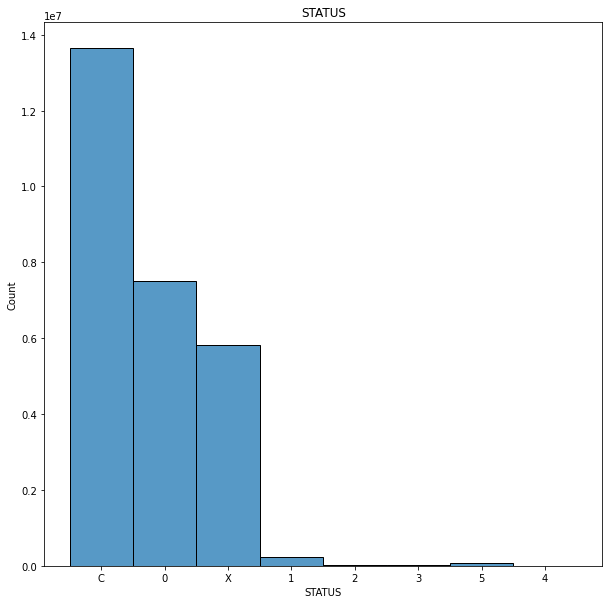

In [ ]:
plt.figure(figsize=(10,10))
plt.title('STATUS')
sns.histplot(data = df_bureau_balance, x = 'STATUS')

In [ ]:
del df_bureau_balance
gc.collect()

0

##**Tabela:** previous_application.csv

In [ ]:
df_previous_app = reduce_memory_usage(pd.read_csv(db_dir+'/previous_application.csv'))
df_previous_app.head(10)

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans   1730.430054          17145.0   
1     2802425      108129         Cash loans  25188.615234         607500.0   
2     2523466      122040         Cash loans  15060.735352         112500.0   
3     2819243      176158         Cash loans  47041.335938         450000.0   
4     1784265      202054         Cash loans  31924.394531         337500.0   
5     1383531      199383         Cash loans  23703.929688         315000.0   
6     2315218      175704         Cash loans           NaN              0.0   
7     1656711      296299         Cash loans           NaN              0.0   
8     2367563      342292         Cash loans           NaN              0.0   
9     2579447      334349         Cash loans           NaN              0.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   
5    340573.5               NaN         315000.0                   SATURDAY   
6         0.0               NaN              NaN                    TUESDAY   
7         0.0               NaN              NaN                     MONDAY   
8         0.0               NaN              NaN                     MONDAY   
9         0.0               NaN              NaN                   SATURDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   
5                        8                           Y   
6                       11                           Y   
7                        7                           Y   
8                       15                           Y   
9                       15                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182861   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   
5                       1                NaN                    NaN   
6                       1                NaN                    NaN   
7                       1                NaN                    NaN   
8                       1                NaN                    NaN   
9                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867188                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   
5                       NaN      Everyday expenses             Approved   
6                       NaN                    XNA             Canceled   
7                       NaN                    XNA             Canceled   
8                       NaN                    XNA             Canceled   
9                       NaN                    XNA             Canceled   

   DAYS_DECISION

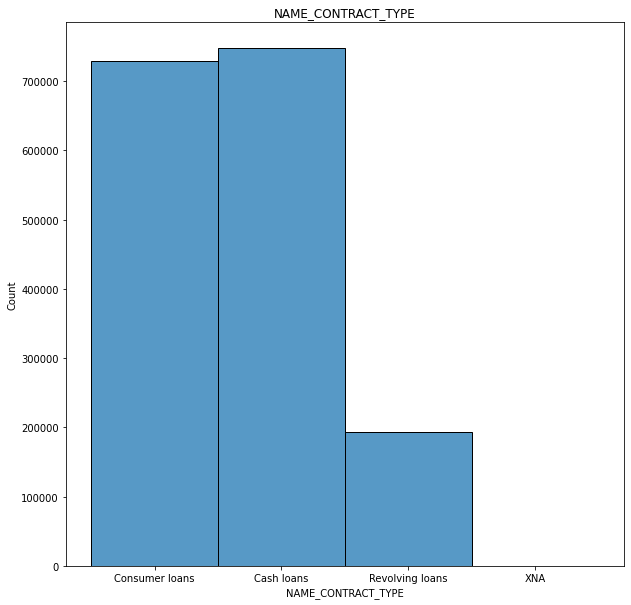

In [ ]:
plt.figure(figsize=(10,10))
plt.title('NAME_CONTRACT_TYPE')
sns.histplot(data = df_previous_app, x = 'NAME_CONTRACT_TYPE')

In [ ]:
counter_loan_purpose = counter_generator(df_previous_app,'NAME_CASH_LOAN_PURPOSE')

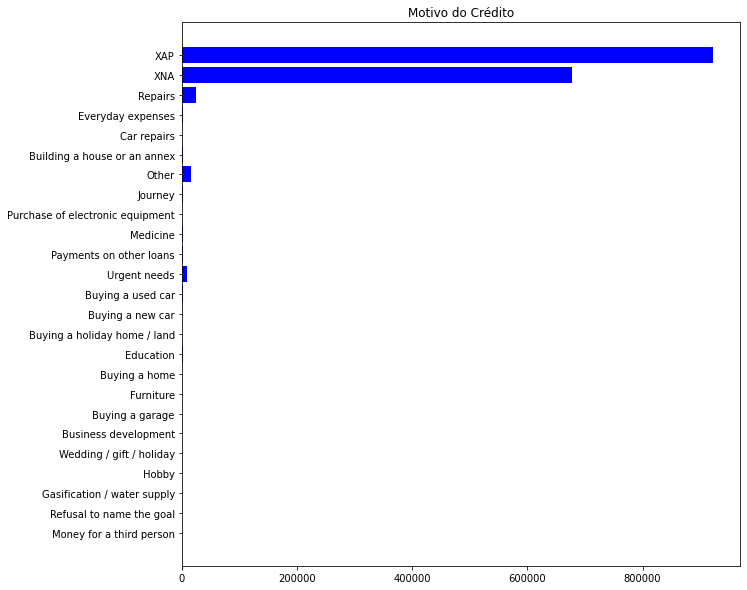

In [ ]:
bar_graph_from_counter(counter_loan_purpose,'Motivo do Crédito',(10,10), False)

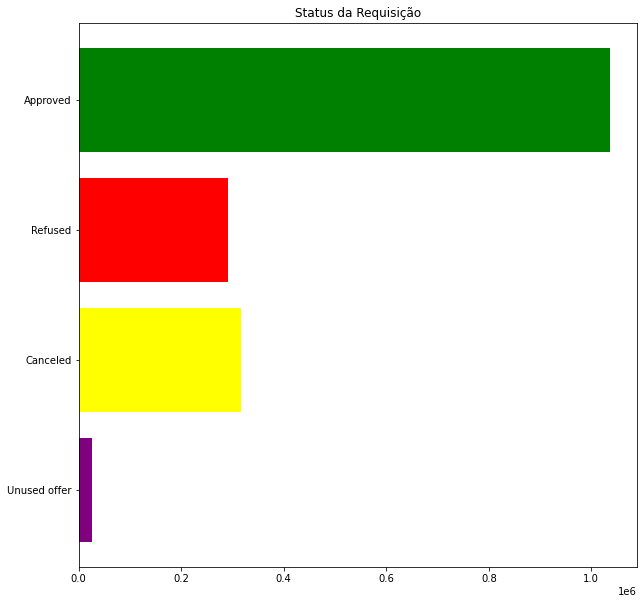

In [ ]:
counter_name_contract_status = counter_generator(df_previous_app,'NAME_CONTRACT_STATUS')
bar_graph_from_counter(counter_name_contract_status, 'Status da Requisição', (10,10),False,['green','red','yellow','purple'])

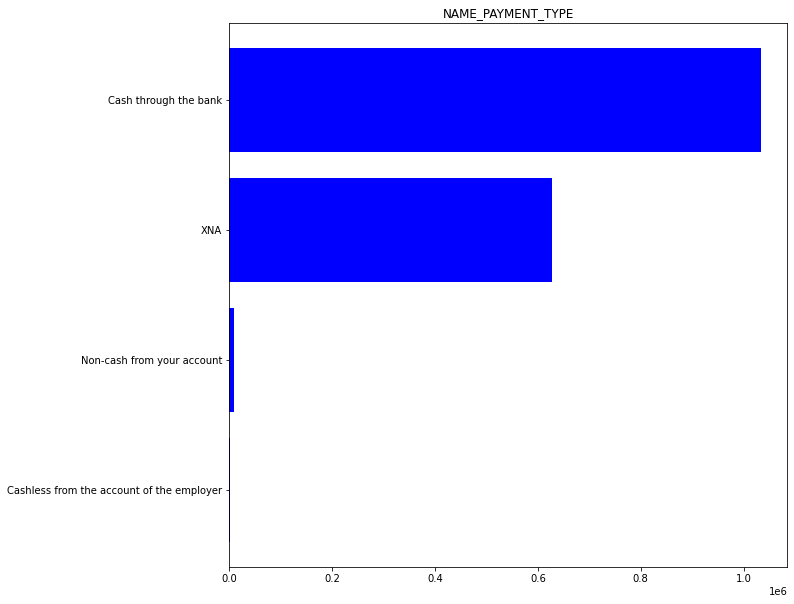

In [ ]:
counter_name_payment_type = counter_generator(df_previous_app,'NAME_PAYMENT_TYPE')
bar_graph_from_counter(counter_name_payment_type, 'NAME_PAYMENT_TYPE',(10,10), False, 'blue')

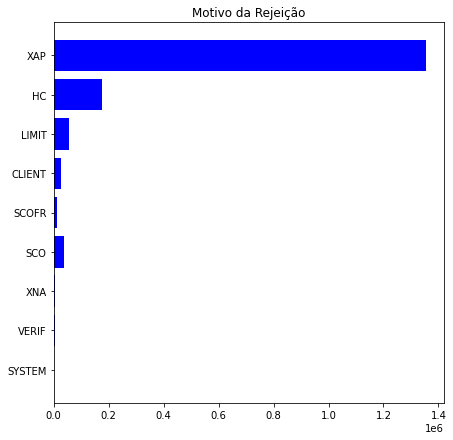

In [ ]:
counter_code_reject_reason = counter_generator(df_previous_app,'CODE_REJECT_REASON')
bar_graph_from_counter(counter_code_reject_reason,'Motivo da Rejeição',(7,7), False, 'blue')

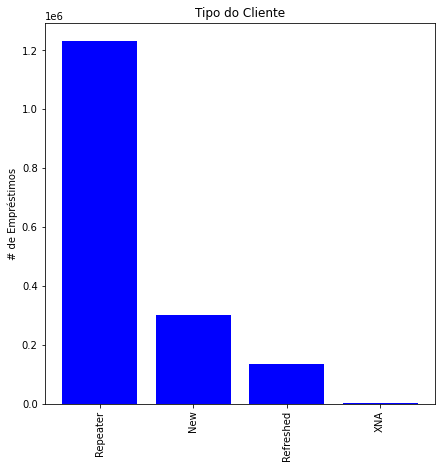

In [ ]:
counter_name_client_type = counter_generator(df_previous_app, 'NAME_CLIENT_TYPE')
bar_graph_from_counter(counter_name_client_type, 'Tipo do Cliente',(7,7),True,'blue')

In [ ]:
print(counter_percentage(counter_name_client_type))

+-----------+---------+-------------------+
| Categoria |  Total  | PerCent Total (%) |
+-----------+---------+-------------------+
|  Repeater | 1231261 |       73.72       |
|    New    |  301363 |       18.04       |
| Refreshed |  135649 |        8.12       |
|    XNA    |   1941  |        0.12       |
+-----------+---------+-------------------+


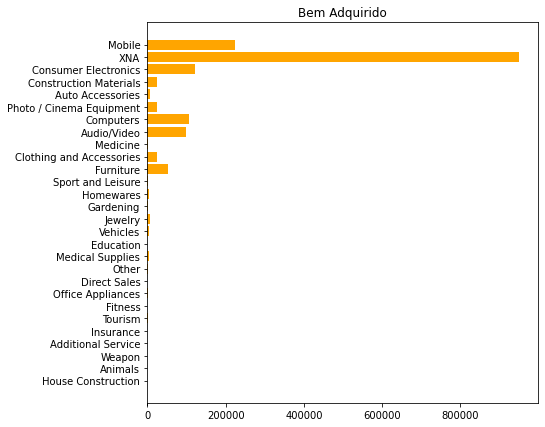

In [ ]:
counter_name_goods_category = counter_generator(df_previous_app,'NAME_GOODS_CATEGORY')
bar_graph_from_counter(counter_name_goods_category,'Bem Adquirido',(7,7),False,'orange')

In [ ]:
print(counter_percentage(counter_name_goods_category))

+--------------------------+--------+-------------------+
|        Categoria         | Total  | PerCent Total (%) |
+--------------------------+--------+-------------------+
|          Mobile          | 224708 |       13.45       |
|           XNA            | 950809 |       56.93       |
|   Consumer Electronics   | 121576 |        7.28       |
|  Construction Materials  | 24995  |        1.5        |
|     Auto Accessories     |  7381  |        0.44       |
| Photo / Cinema Equipment | 25021  |        1.5        |
|        Computers         | 105769 |        6.33       |
|       Audio/Video        | 99441  |        5.95       |
|         Medicine         |  1550  |        0.09       |
| Clothing and Accessories | 23554  |        1.41       |
|        Furniture         | 53656  |        3.21       |
|    Sport and Leisure     |  2981  |        0.18       |
|        Homewares         |  5023  |        0.3        |
|        Gardening         |  2668  |        0.16       |
|         Jewe

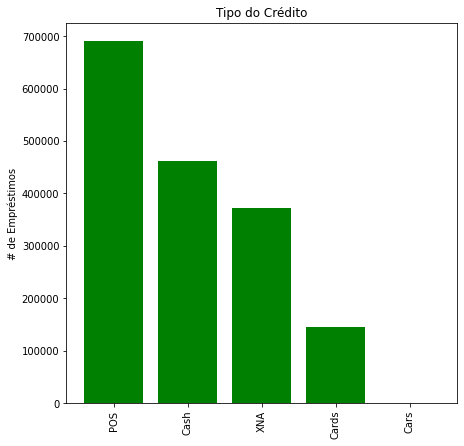

In [ ]:
counter_name_portifolio = counter_generator(df_previous_app,'NAME_PORTFOLIO')
bar_graph_from_counter(counter_name_portifolio, 'Tipo do Crédito', (7,7), True, 'green')

In [ ]:
print(counter_percentage(counter_name_portifolio))

+-----------+--------+-------------------+
| Categoria | Total  | PerCent Total (%) |
+-----------+--------+-------------------+
|    POS    | 691011 |       41.37       |
|    Cash   | 461563 |       27.63       |
|    XNA    | 372230 |       22.29       |
|   Cards   | 144985 |        8.68       |
|    Cars   |  425   |        0.03       |
+-----------+--------+-------------------+


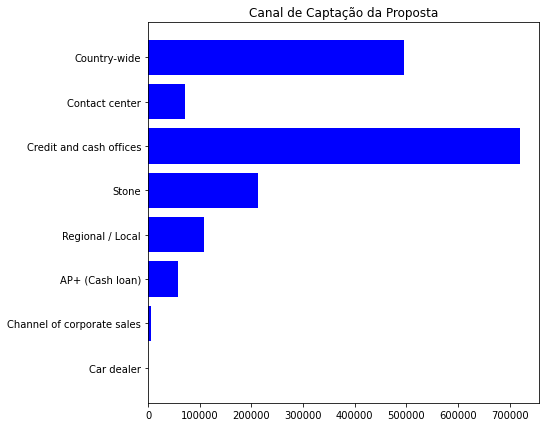

In [ ]:
counter_channel_type = counter_generator(df_previous_app,'CHANNEL_TYPE')
bar_graph_from_counter(counter_channel_type,'Canal de Captação da Proposta', (7,7),False, 'blue')

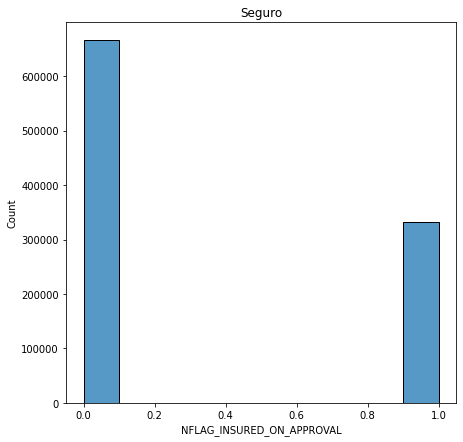

In [ ]:
plt.figure(figsize=(7,7))
plt.title('Seguro')
sns.histplot(data = df_previous_app, x = 'NFLAG_INSURED_ON_APPROVAL', bins = 10)

In [ ]:
del df_previous_app
gc.collect()

29463

##**Tabela:** pos_cash_balance.csv

In [ ]:
df_pos_cash_balance = reduce_memory_usage(pd.read_csv(db_dir+'/POS_CASH_balance.csv'))
df_pos_cash_balance.head(5)

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [ ]:
df_pos_cash_balance.shape

(10001358, 8)

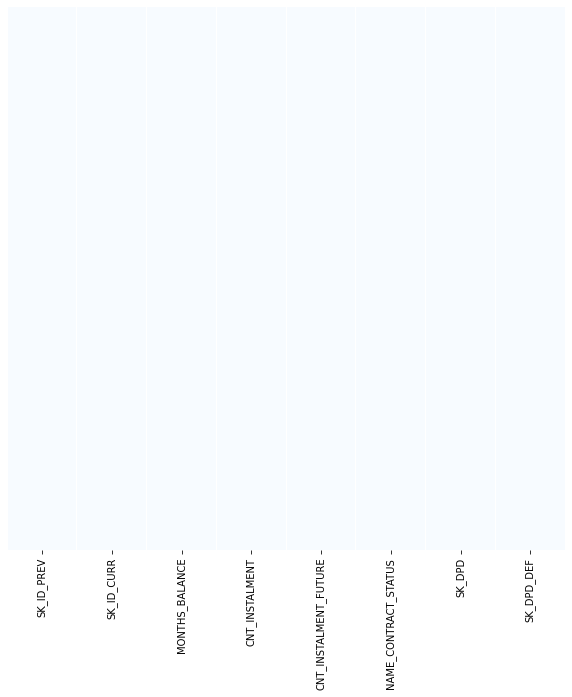

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_pos_cash_balance.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
df_pos_cash_balance['MONTHS_BALANCE'].unique()

array([-31, -33, -32, -35, -38, -39, -34, -41, -37, -40, -43, -36, -42,
       -47, -44, -46, -45, -27, -25, -24, -30, -28, -26, -29, -48, -15,
       -19, -22, -14, -18, -16, -21, -17, -20, -23,  -1,  -6,  -2,  -3,
        -5,  -4, -13, -11, -10,  -9,  -7,  -8, -54, -49, -52, -53, -50,
       -51, -55, -12, -94, -95, -92, -91, -96, -93, -57, -64, -56, -59,
       -60, -66, -65, -58, -63, -62, -61, -87, -86, -88, -89, -90, -72,
       -74, -73, -82, -78, -81, -75, -77, -80, -76, -79, -69, -70, -71,
       -68, -67, -83, -85, -84], dtype=int8)

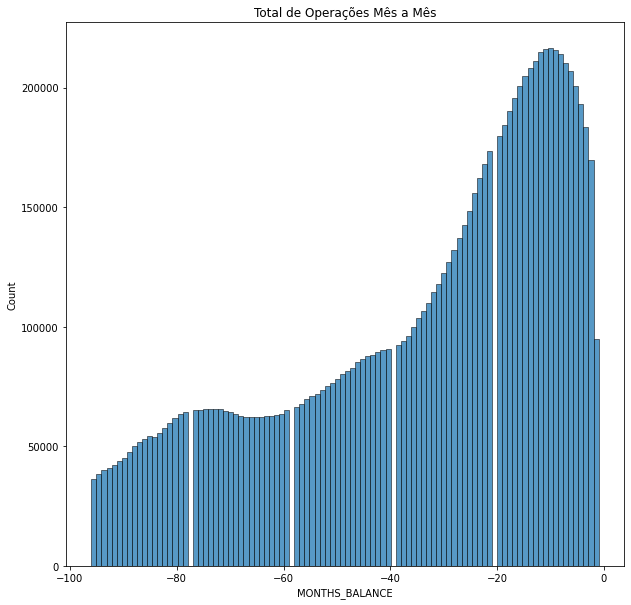

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Total de Operações Mês a Mês')
sns.histplot(data=df_pos_cash_balance,x='MONTHS_BALANCE',bins = 100)

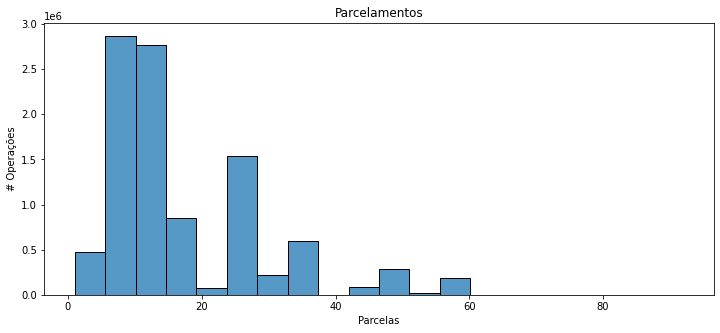

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Parcelamentos')
plt.xlabel('Parcelas')
plt.ylabel('# Operações')
sns.histplot(data=df_pos_cash_balance, x='CNT_INSTALMENT', bins = 20)

In [ ]:
counter_cnt_instalment = counter_generator(df_pos_cash_balance,'CNT_INSTALMENT')

In [ ]:
print(counter_percentage(counter_cnt_instalment))

+-----------+---------+-------------------+
| Categoria |  Total  | PerCent Total (%) |
+-----------+---------+-------------------+
|    48.0   |  278513 |        2.78       |
|    36.0   |  584574 |        5.84       |
|    12.0   | 2496845 |       24.97       |
|    24.0   | 1517472 |       15.17       |
|    60.0   |  189067 |        1.89       |
|    18.0   |  727394 |        7.27       |
|    4.0    |  238223 |        2.38       |
|    42.0   |  87935  |        0.88       |
|    25.0   |  10774  |        0.11       |
|    14.0   |  90538  |        0.91       |
|    16.0   |  66426  |        0.66       |
|    13.0   |  23936  |        0.24       |
|    8.0    |  303751 |        3.04       |
|    10.0   | 1243449 |       12.43       |
|    15.0   |  27989  |        0.28       |
|    11.0   |  151835 |        1.52       |
|    30.0   |  211920 |        2.12       |
|    54.0   |  22275  |        0.22       |
|    6.0    | 1065500 |       10.65       |
|    9.0    |  148355 |        1

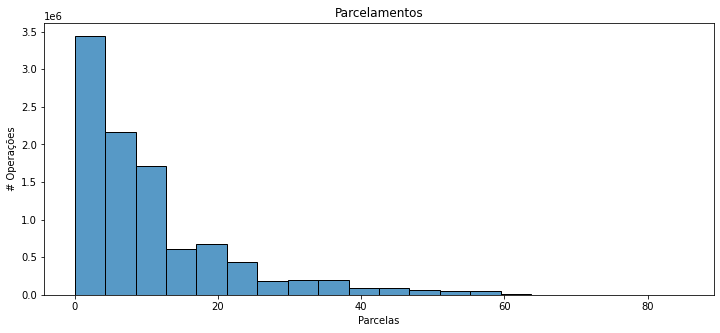

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Parcelamentos')
plt.xlabel('Parcelas')
plt.ylabel('# Operações')
sns.histplot(data=df_pos_cash_balance, x='CNT_INSTALMENT_FUTURE', bins = 20)

In [ ]:
counter_cnt_instalment_future = counter_generator(df_pos_cash_balance,'CNT_INSTALMENT_FUTURE')

In [ ]:
print(counter_percentage(counter_cnt_instalment_future))

+-----------+---------+-------------------+
| Categoria |  Total  | PerCent Total (%) |
+-----------+---------+-------------------+
|    45.0   |  23520  |        0.24       |
|    35.0   |  52659  |        0.53       |
|    9.0    |  467606 |        4.68       |
|    42.0   |  23919  |        0.24       |
|    12.0   |  389585 |        3.9        |
|    43.0   |  20533  |        0.21       |
|    36.0   |  55228  |        0.55       |
|    16.0   |  157022 |        1.57       |
|    24.0   |  136742 |        1.37       |
|    5.0    |  600295 |        6.0        |
|    15.0   |  151212 |        1.51       |
|    1.0    |  512279 |        5.12       |
|    28.0   |  47590  |        0.48       |
|    23.0   |  130810 |        1.31       |
|    56.0   |  11980  |        0.12       |
|    11.0   |  376430 |        3.76       |
|    7.0    |  472665 |        4.73       |
|    18.0   |  165735 |        1.66       |
|    17.0   |  159457 |        1.59       |
|    46.0   |  24933  |        0

In [ ]:
counter_name_contract_status = counter_generator(df_pos_cash_balance,'NAME_CONTRACT_STATUS')

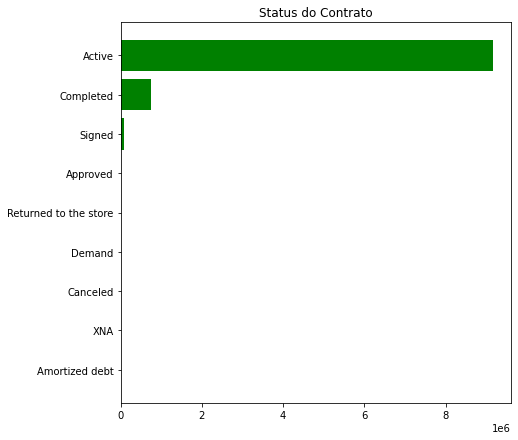

In [ ]:
bar_graph_from_counter(counter_name_contract_status, 'Status do Contrato',(7,7), False, 'green')

In [ ]:
print(counter_percentage(counter_name_contract_status))

+-----------------------+---------+-------------------+
|       Categoria       |  Total  | PerCent Total (%) |
+-----------------------+---------+-------------------+
|         Active        | 9151119 |        91.5       |
|       Completed       |  744883 |        7.45       |
|         Signed        |  87260  |        0.87       |
|        Approved       |   4917  |        0.05       |
| Returned to the store |   5461  |        0.05       |
|         Demand        |   7065  |        0.07       |
|        Canceled       |    15   |        0.0        |
|          XNA          |    2    |        0.0        |
|     Amortized debt    |   636   |        0.01       |
+-----------------------+---------+-------------------+


In [ ]:
del df_pos_cash_balance
gc.collect()

3332

##**Tabela:** installment_payments.csv

In [ ]:
df_installment_payments = reduce_memory_usage(pd.read_csv(db_dir+'/installments_payments.csv'))
df_installment_payments.head(10)

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   
5     1137312      164489                     1.0                     12   
6     2234264      184693                     4.0                     11   
7     1818599      111420                     2.0                      4   
8     2723183      112102                     0.0                     14   
9     1413990      109741                     1.0                      4   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  
0          -1180.0             -1187.0     6948.359863   6948.359863  
1          -2156.0             -2156.0     1716.525024   1716.525024  
2            -63.0               -63.0    25425.000000  25425.000000  
3          -2418.0             -2426.0    24350.130859  24350.130859  
4          -1383.0             -1366.0     2165.040039   2160.584961  
5          -1384.0             -1417.0     5970.375000   5970.375000  
6           -349.0              -352.0    29432.294922  29432.294922  
7           -968.0              -994.0    17862.164062  17862.164062  
8           -197.0              -197.0       70.739998     70.739998  
9           -570.0              -609.0    14308.469727  14308.469727

In [ ]:
df_installment_payments.shape

(13605401, 8)

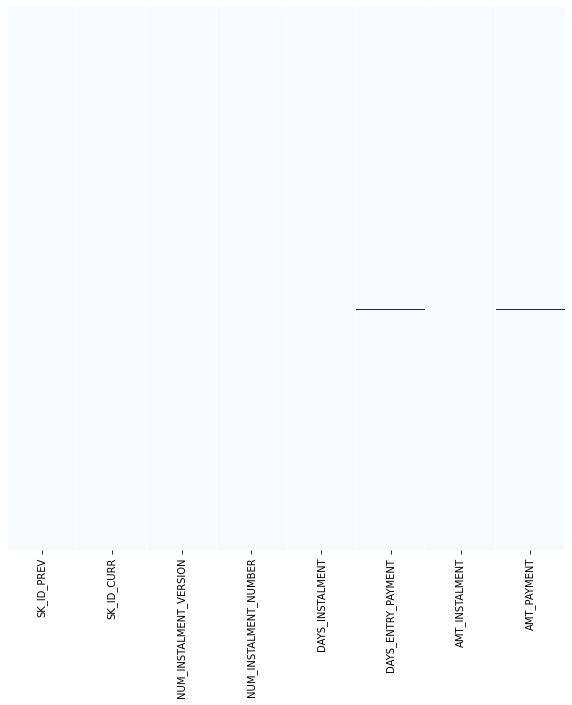

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_installment_payments.isnull(), yticklabels=False, cbar=False, cmap='Blues')

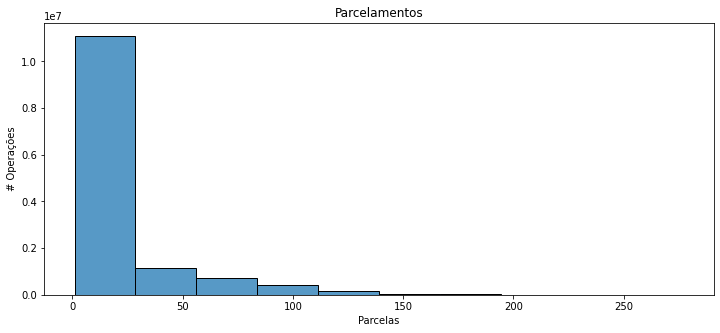

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Parcelamentos')
plt.xlabel('Parcelas')
plt.ylabel('# Operações')
sns.histplot(data=df_installment_payments, x='NUM_INSTALMENT_NUMBER', bins = 10)

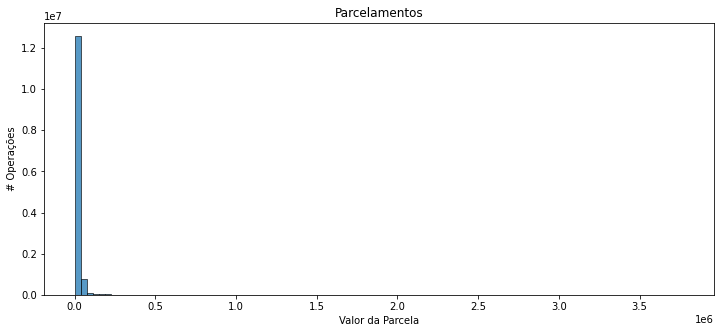

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Parcelamentos')
plt.xlabel('Valor da Parcela')
plt.ylabel('# Operações')
sns.histplot(data=df_installment_payments, x='AMT_INSTALMENT', bins = 100)

In [ ]:
df_installment_payments_less200 = df_installment_payments[df_installment_payments['AMT_INSTALMENT'] < 0.075e6]

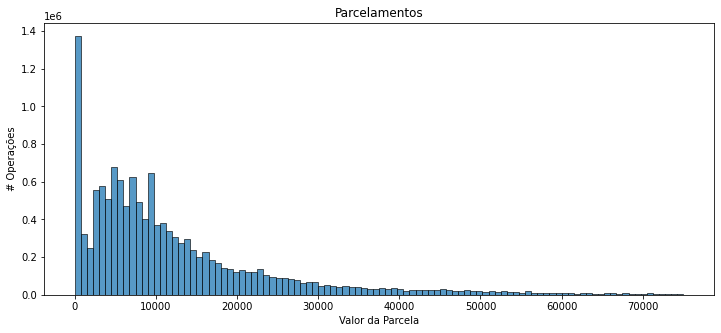

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Parcelamentos')
plt.xlabel('Valor da Parcela')
plt.ylabel('# Operações')
sns.histplot(data=df_installment_payments_less200, x='AMT_INSTALMENT', bins = 100)

In [ ]:
df_installment_payments_less200

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
0            1054186      161674                     1.0   
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                             6          -1180.0             -1187.0   
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT   AMT_PAYMENT  
0            6948.359863   6948.359863  
1            1716.525024   1716.525024  
2           25425.000000  25425.000000  
3           24350.130859  24350.130859  
4            2165.040039   2160.584961  
...                  ...           ...  
13605396       67.500000           NaN  
13605397       67.500000           NaN  
13605398    43737.433594           NaN  
13605399       67.500000           NaN  
13605400    11504.250000           NaN  

[13329816 rows x 8 columns]

In [ ]:
df_installment_payments_less200 = df_installment_payments[df_installment_payments['AMT_PAYMENT'] < 0.075e6]

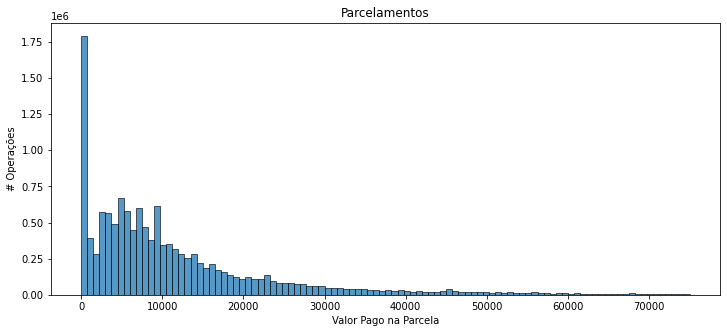

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Parcelamentos')
plt.xlabel('Valor Pago na Parcela')
plt.ylabel('# Operações')
sns.histplot(data=df_installment_payments_less200, x='AMT_PAYMENT', bins = 100)

In [ ]:
del df_installment_payments
gc.collect()

232

##**Tabela:** credit_card_balance.csv

In [ ]:
df_credit_card_balance = reduce_memory_usage(pd.read_csv(db_dir+'/credit_card_balance.csv'))
df_credit_card_balance.head(10)

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE    AMT_BALANCE  \
0     2562384      378907              -6      56.970001   
1     2582071      363914              -1   63975.554688   
2     1740877      371185              -7   31815.224609   
3     1389973      337855              -4  236572.109375   
4     1891521      126868              -1  453919.468750   
5     2646502      380010              -7   82903.812500   
6     1079071      171320              -6  353451.656250   
7     2095912      118650              -7   47962.125000   
8     2181852      367360              -4  291543.062500   
9     1235299      203885              -5  201261.187500   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0            877.500000   
1                    45000                    2250.0           2250.000000   
2                   450000                       0.0              0.000000   
3                   225000                    2250.0           2250.000000   
4                   450000                       0.0          11547.000000   
5                   270000                       0.0              0.000000   
6                   585000                   67500.0          67500.000000   
7                    45000                   45000.0          45000.000000   
8                   292500                   90000.0         289339.437500   
9                   225000                   76500.0         111026.703125   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                877.500000   
1                         0.0                  0.000000   
2                         0.0                  0.000000   
3                         0.0                  0.000000   
4                         0.0              11547.000000   
5                         0.0                  0.000000   
6                         0.0                  0.000000   
7                         0.0                  0.000000   
8                         0.0             199339.421875   
9                         0.0              34526.699219   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0              1700.324951          1800.000000                1800.000000   
1              2250.000000          2250.000000                2250.000000   
2              2250.000000          2250.000000                2250.000000   
3             11795.759766         11925.000000               11925.000000   
4             22924.890625         27000.000000               27000.000000   
5              4449.104980          3825.000000                3825.000000   
6             14684.174805         15750.000000               15750.000000   
7                 0.000000           264.690002                   0.000000   
8               130.500000          4093.514893                4093.514893   
9              6338.339844         45000.000000               45000.000000   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                  0.000000       0.000000              0.000000   
1              60175.078125   64875.554688          64875.554688   
2              26926.425781   31460.085938          31460.085938   
3             224949.281250  233048.968750         233048.968750   
4             443044.406250  453919.468750         453919.468750   
5              80519.039062   82773.312500          82773.312500   
6             345433.875000  351881.156250         351881.156250   
7              44735.308594   47962.125000          47962.125000   
8             285376.406250  286831.562500         286831.562500   
9             192793.281250  197224.687500         197224.687500   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1              

In [ ]:
df_credit_card_balance.shape

(3840312, 23)

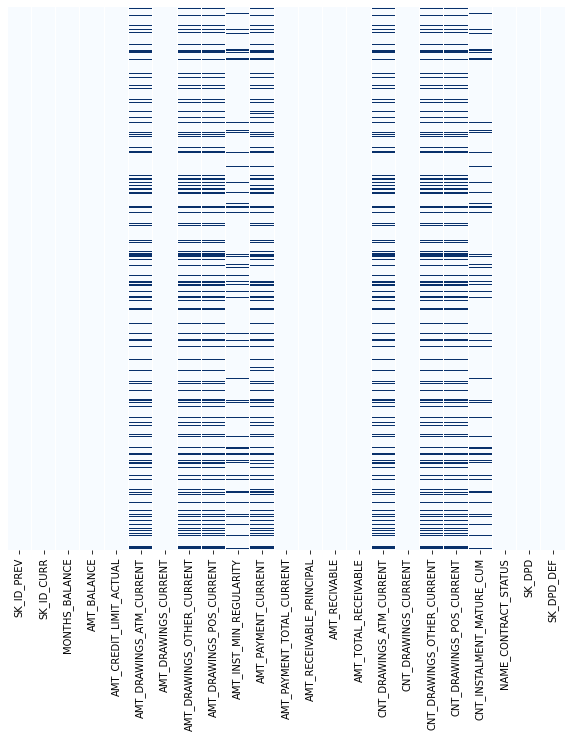

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_credit_card_balance.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
counter_months_balance = counter_generator(df_credit_card_balance,'MONTHS_BALANCE')

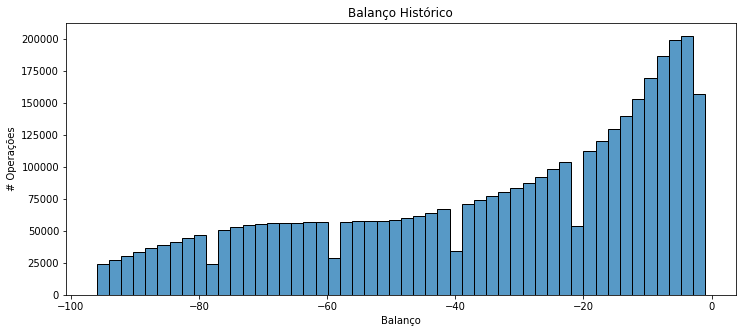

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Balanço Histórico')
plt.xlabel('Balanço')
plt.ylabel('# Operações')
sns.histplot(data=df_credit_card_balance, x='MONTHS_BALANCE', bins = 50)

In [ ]:
df_credit_card_balance['AMT_BALANCE'].describe()

count    3.840312e+06
mean     5.830016e+04
std      1.063070e+05
min     -4.202502e+05
25%      0.000000e+00
50%      0.000000e+00
75%      8.904669e+04
max      1.505902e+06
Name: AMT_BALANCE, dtype: float64

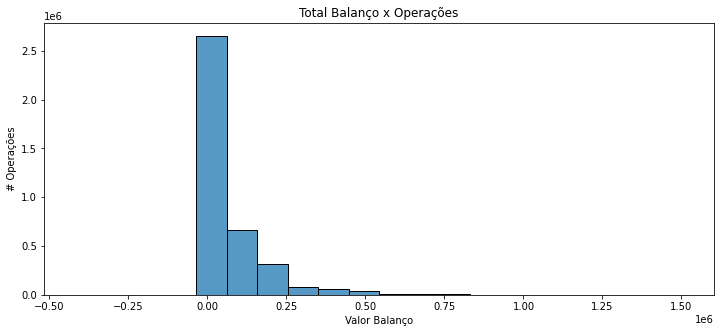

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Total Balanço x Operações')
plt.xlabel('Valor Balanço')
plt.ylabel('# Operações')
sns.histplot(data=df_credit_card_balance, x='AMT_BALANCE', bins = 20)

In [ ]:
df_credit_card_balance_temp = df_credit_card_balance[df_credit_card_balance['AMT_BALANCE'] > 0]
df_credit_card_balance_temp = df_credit_card_balance_temp[df_credit_card_balance_temp['AMT_BALANCE'] < 0.075e6]
df_credit_card_balance_temp.shape

(622135, 23)

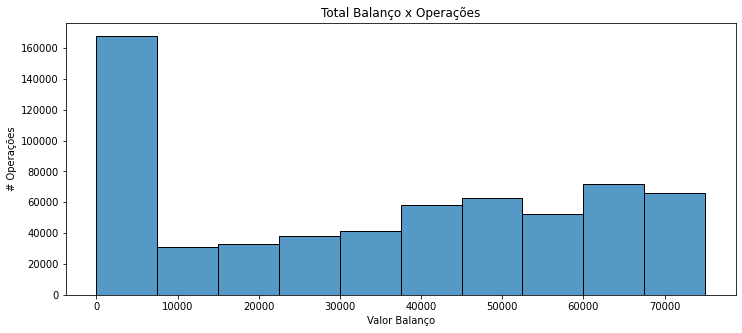

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Total Balanço x Operações')
plt.xlabel('Valor Balanço')
plt.ylabel('# Operações')
sns.histplot(data=df_credit_card_balance_temp, x='AMT_BALANCE', bins = 10)

In [ ]:
df_credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'].describe()

count    3.840312e+06
mean     1.538080e+05
std      1.651457e+05
min      0.000000e+00
25%      4.500000e+04
50%      1.125000e+05
75%      1.800000e+05
max      1.350000e+06
Name: AMT_CREDIT_LIMIT_ACTUAL, dtype: float64

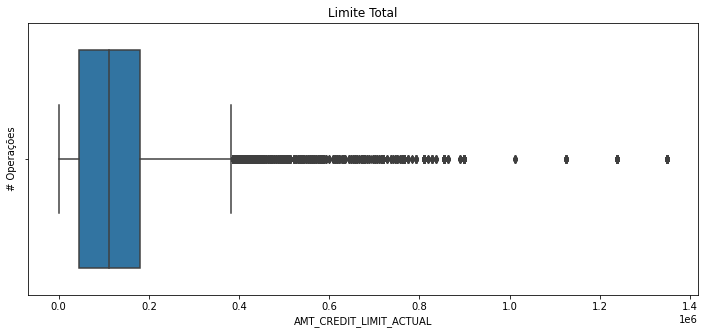

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Limite Total')
plt.xlabel('Valor Limite')
plt.ylabel('# Operações')
sns.boxplot(data=df_credit_card_balance, x='AMT_CREDIT_LIMIT_ACTUAL')

In [ ]:
df_credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].describe()

count    3.090496e+06
mean     5.961323e+03
std      2.822569e+04
min     -6.827310e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.115000e+06
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

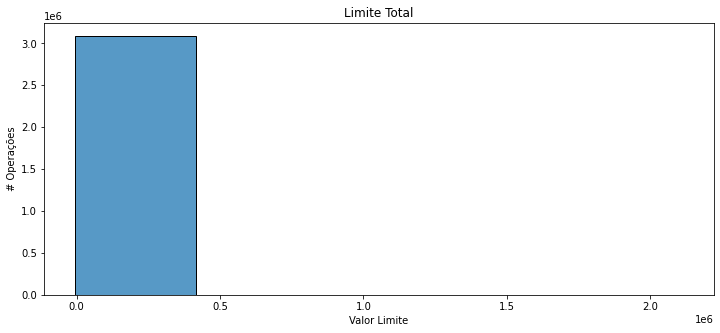

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Limite Total')
plt.xlabel('Valor Limite')
plt.ylabel('# Operações')
sns.histplot(data=df_credit_card_balance, x='AMT_DRAWINGS_ATM_CURRENT',bins = 5)

In [ ]:
df_credit_card_balance_temp = df_credit_card_balance[df_credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] < 0.5e6]
df_credit_card_balance_temp['AMT_DRAWINGS_ATM_CURRENT'].describe()

count    3.089848e+06
mean     5.822909e+03
std      2.644495e+04
min     -6.827310e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.995000e+05
Name: AMT_DRAWINGS_ATM_CURRENT, dtype: float64

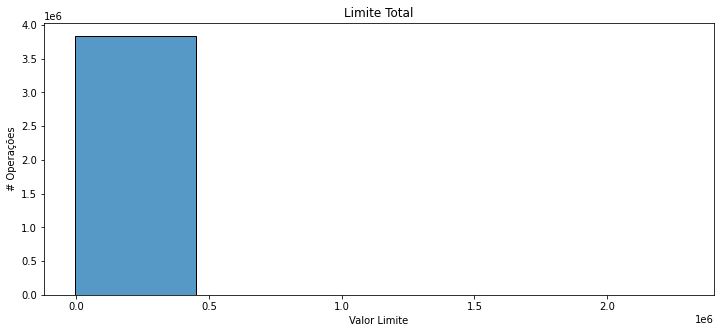

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Limite Total')
plt.xlabel('Valor Limite')
plt.ylabel('# Operações')
sns.histplot(data=df_credit_card_balance, x='AMT_DRAWINGS_CURRENT',bins = 5)

In [ ]:
df_credit_card_balance['AMT_DRAWINGS_CURRENT'].describe()

count    3.840312e+06
mean     7.433390e+03
std      3.384608e+04
min     -6.211620e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.287098e+06
Name: AMT_DRAWINGS_CURRENT, dtype: float64

In [ ]:
df_credit_card_balance['AMT_DRAWINGS_OTHER_CURRENT'].describe()

count    3.090496e+06
mean     2.881696e+02
std      8.201989e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.529847e+06
Name: AMT_DRAWINGS_OTHER_CURRENT, dtype: float64

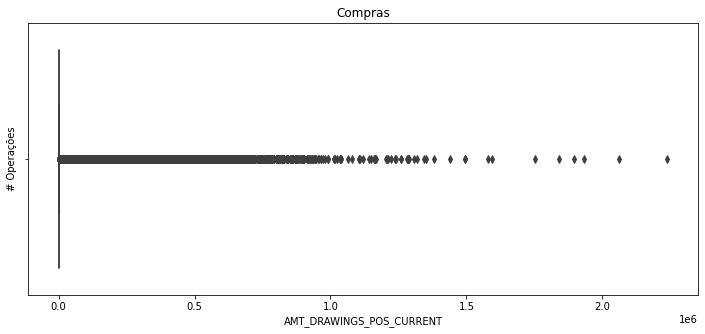

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Compras')
plt.xlabel('Valor Saque')
plt.ylabel('# Operações')
sns.boxplot(data=df_credit_card_balance, x='AMT_DRAWINGS_POS_CURRENT')

In [ ]:
df_credit_card_balance['AMT_DRAWINGS_POS_CURRENT'].describe()

count    3.090496e+06
mean     2.968804e+03
std      2.079689e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.239274e+06
Name: AMT_DRAWINGS_POS_CURRENT, dtype: float64

In [ ]:
df_credit_card_balance_temp = df_credit_card_balance[df_credit_card_balance['AMT_DRAWINGS_POS_CURRENT'] < 10]

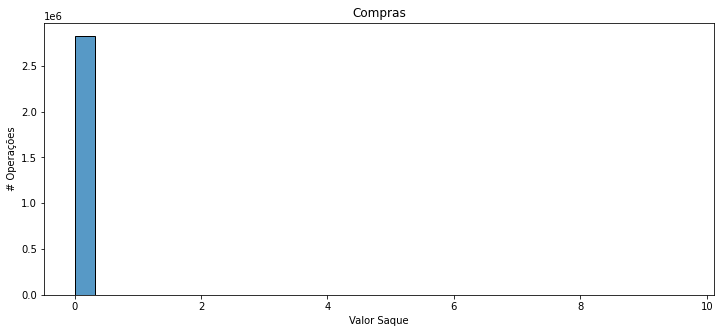

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Compras')
plt.xlabel('Valor Saque')
plt.ylabel('# Operações')
sns.histplot(data=df_credit_card_balance_temp, x='AMT_DRAWINGS_POS_CURRENT', bins=30)

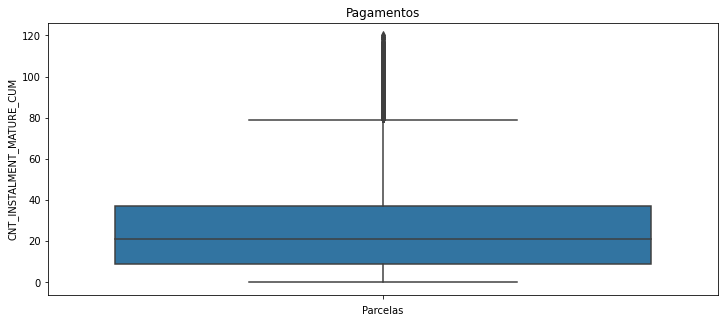

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Pagamentos')
plt.xlabel('Parcelas')
sns.boxplot(data=df_credit_card_balance_temp, y='CNT_INSTALMENT_MATURE_CUM')

In [ ]:
del df_credit_card_balance
gc.collect()

78

# **Engenharia dos Dados**

##Funções de Apoio

In [ ]:
def one_hot_encode_engDados(df):
    original_columns = list(df.columns)
    categories = [cat for cat in df.columns if df[cat].dtype == 'object']
    df = pd.get_dummies(df, columns= categories, dummy_na= True) #one_hot_encode the categorical features
    categorical_columns = [cat for cat in df.columns if cat not in original_columns]
    return df, categorical_columns

## application_train.csv

In [ ]:
df_app_train = reduce_memory_usage(pd.read_csv(db_dir+'/application_train.csv'))

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [ ]:
def EngDados_application_train(dataframe):
  dataframe['CREDIT_INCOME_PERCENT'] = dataframe['AMT_CREDIT'] / dataframe['AMT_INCOME_TOTAL']
  dataframe['ANNUITY_INCOME_PERCENT'] = dataframe['AMT_ANNUITY'] / dataframe['AMT_INCOME_TOTAL']
  dataframe['CREDIT_ANNUITY_PERCENT'] = dataframe['AMT_CREDIT'] / dataframe['AMT_ANNUITY']
  dataframe['FAMILY_CNT_INCOME_PERCENT'] = dataframe['AMT_INCOME_TOTAL'] / dataframe['CNT_FAM_MEMBERS']
  dataframe['CREDIT_TERM'] = dataframe['AMT_ANNUITY'] / dataframe['AMT_CREDIT']
  dataframe['BIRTH_EMPLOYED_PERCENT'] = (dataframe['DAYS_EMPLOYED'] / dataframe['DAYS_BIRTH']) * -1
  dataframe['CHILD_CNT_INCOME_PERCENT'] = dataframe['AMT_INCOME_TOTAL'] / dataframe['CNT_CHILDREN']
  dataframe['CREDIT_GOODS_DIFF'] = dataframe['AMT_CREDIT'] / dataframe['AMT_GOODS_PRICE']
  dataframe['EMPLOYED_REGISTRATION_PERCENT'] = (dataframe['DAYS_EMPLOYED'] / dataframe['DAYS_REGISTRATION']) * -1
  dataframe['BIRTH_REGISTRATION_PERCENT'] = dataframe['DAYS_BIRTH'] / dataframe['DAYS_REGISTRATION']
  dataframe['ID_REGISTRATION_DIFF'] = dataframe['DAYS_ID_PUBLISH'] / dataframe['DAYS_REGISTRATION']
  dataframe['ANNUITY_LENGTH_EMPLOYED_PERCENT'] = (dataframe['CREDIT_TERM'] / dataframe['DAYS_EMPLOYED']) * -1
  dataframe['AGE_LOAN_FINISH'] = dataframe['DAYS_BIRTH']*(-1/365) + (dataframe['AMT_CREDIT']/dataframe['AMT_ANNUITY'])*(1/12)
  dataframe['CAR_AGE_EMP_PERCENT'] = (dataframe['OWN_CAR_AGE'] / dataframe['DAYS_EMPLOYED']) * -1
  dataframe['CAR_AGE_BIRTH_PERCENT'] = dataframe['OWN_CAR_AGE'] / dataframe['DAYS_BIRTH']
  dataframe['PHONE_CHANGE_EMP_PERCENT'] = dataframe['DAYS_LAST_PHONE_CHANGE'] / dataframe['DAYS_EMPLOYED']
  dataframe['PHONE_CHANGE_BIRTH_PERCENT'] = dataframe['DAYS_LAST_PHONE_CHANGE'] / dataframe['DAYS_BIRTH']
  income_by_contract = dataframe[['AMT_INCOME_TOTAL', 'NAME_CONTRACT_TYPE']].groupby('NAME_CONTRACT_TYPE').median()['AMT_INCOME_TOTAL']
  dataframe['MEDIAN_INCOME_CONTRACT_TYPE'] = dataframe['NAME_CONTRACT_TYPE'].map(income_by_contract)
  income_by_suite = dataframe[['AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE']].groupby('NAME_TYPE_SUITE').median()['AMT_INCOME_TOTAL']
  dataframe['MEDIAN_INCOME_SUITE_TYPE'] = dataframe['NAME_TYPE_SUITE'].map(income_by_suite)
  income_by_housing = dataframe[['AMT_INCOME_TOTAL', 'NAME_HOUSING_TYPE']].groupby('NAME_HOUSING_TYPE').median()['AMT_INCOME_TOTAL']
  dataframe['MEDIAN_INCOME_HOUSING_TYPE'] = dataframe['NAME_HOUSING_TYPE'].map(income_by_housing)
  income_by_org = dataframe[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
  dataframe['MEDIAN_INCOME_ORG_TYPE'] = dataframe['ORGANIZATION_TYPE'].map(income_by_org)
  income_by_occu = dataframe[['AMT_INCOME_TOTAL', 'OCCUPATION_TYPE']].groupby('OCCUPATION_TYPE').median()['AMT_INCOME_TOTAL']
  dataframe['MEDIAN_INCOME_OCCU_TYPE'] = dataframe['OCCUPATION_TYPE'].map(income_by_occu)
  income_by_education = dataframe[['AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE']].groupby('NAME_EDUCATION_TYPE').median()['AMT_INCOME_TOTAL']
  dataframe['MEDIAN_INCOME_EDU_TYPE'] = dataframe['NAME_EDUCATION_TYPE'].map(income_by_education)
  dataframe['ORG_TYPE_INCOME_PERCENT'] = dataframe['MEDIAN_INCOME_ORG_TYPE']/dataframe['AMT_INCOME_TOTAL']
  dataframe['OCCU_TYPE_INCOME_PERCENT'] = dataframe['MEDIAN_INCOME_OCCU_TYPE']/dataframe['AMT_INCOME_TOTAL']
  dataframe['EDU_TYPE_INCOME_PERCENT'] = dataframe['MEDIAN_INCOME_EDU_TYPE']/dataframe['AMT_INCOME_TOTAL']
  return dataframe

In [ ]:
df_app_train = EngDados_application_train(df_app_train)
df_app_train.head(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   
7               Y             0          360000.0   1530000.0      42075.0   
8               Y             0          112500.0   1019610.0      33826.5   
9               Y             0          135000.0    405000.0      20250.0   

   AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0         351000.0    Unaccompanied               Working   
1        1129500.0           Family         State servant   
2         135000.0    Unaccompanied               Working   
3         297000.0    Unaccompanied               Working   
4         513000.0    Unaccompanied               Working   
5         454500.0  Spouse, partner         State servant   
6        1395000.0    Unaccompanied  Commercial associate   
7        1530000.0    Unaccompanied         State servant   
8         913500.0         Children             Pensioner   
9         405000.0    Unaccompanied               Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   
5  Secondary / secondary special               Married  House / apartment   
6               Higher education               Married  House / apartment   
7               Higher education               Married  House / apartment   
8  Secondary / secondary special               Married  House / apartment   
9  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018799       -9461           -637            -3648.0   
1                    0.003542      -16765          -1188            -1186.0   
2                    0.010033      -19046           -225            -4260.0   
3                    0.008018      -19005          -3039            -9832.0   
4                    0.028656      -19932          -3038            -4312.0   
5                    0.035797      -16941          -1588            -4968.0   
6                    0.035797      -13778          -3130            -1213.0   
7                    0.003122      -18850           -449            -4596.0   
8                    0.018631      -20099         365243            -7428.0   
9                    0.019684      -14469          -2019           -14440.

In [ ]:
df_app_train.to_csv(db_dir + '/BasesTratadas/Books/application_train.csv', index = False)

In [ ]:
del df_app_train
gc.collect()

0

##bureau.csv + bureau_balance.csv

In [ ]:
df_bureau = reduce_memory_usage(pd.read_csv(db_dir+'/bureau.csv'))
df_bureau_balance = reduce_memory_usage(pd.read_csv(db_dir+'/bureau_balance.csv'))

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


In [ ]:
#Construção de variáveis
def codificacao_credit_type(x):
    if x == 'Closed':
        y = 0
    elif x=='Active':
        y = 1
    else:
        y = 2    
    return y

def EngDados_bureau(dataframe):
  dataframe['CREDIT_DURATION'] = -1 * dataframe['DAYS_CREDIT'] + dataframe['DAYS_CREDIT_ENDDATE']
  dataframe['ENDDATE_DIFF'] = dataframe['DAYS_CREDIT_ENDDATE'] - dataframe['DAYS_ENDDATE_FACT']
  dataframe['UPDATE_DIFF'] = dataframe['DAYS_CREDIT_ENDDATE'] - dataframe['DAYS_ENDDATE_FACT']
  dataframe['DEBT_PERCENTAGE'] = dataframe['AMT_CREDIT_SUM'] / dataframe['AMT_CREDIT_SUM_DEBT']
  dataframe['DEBIT_CREDIT_DIFF'] = dataframe['AMT_CREDIT_SUM'] - dataframe['AMT_CREDIT_SUM_DEBT']
  dataframe['CREDIT_TO_ANNUITY_RATIO'] = dataframe['AMT_CREDIT_SUM'] / dataframe['AMT_ANNUITY']
  dataframe['DEBIT_TO_ANNUITY_RATIO'] = dataframe['AMT_CREDIT_SUM_DEBT'] / dataframe['AMT_ANNUITY']
  dataframe['CREDIT_OVERDUE_DIFF'] = dataframe['AMT_CREDIT_SUM'] - dataframe['AMT_CREDIT_SUM_OVERDUE']
  dataframe['AMT_CREDIT_SUM_DEBT'] = dataframe['AMT_CREDIT_SUM_DEBT'].fillna(0)
  dataframe['AMT_ANNUITY'] = dataframe['AMT_ANNUITY'].fillna(0)
  no_loans_per_customer = dataframe[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count()
  no_loans_per_customer = no_loans_per_customer.reset_index().rename(columns={'SK_ID_BUREAU': 'CUSTOMER_LOAN_COUNT'})
  dataframe = dataframe.merge(no_loans_per_customer, on='SK_ID_CURR', how='left')
  credit_types_per_customer = dataframe[['SK_ID_CURR','CREDIT_TYPE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE'].nunique()
  credit_types_per_customer = credit_types_per_customer.reset_index().rename(columns={'CREDIT_TYPE':'CUSTOMER_CREDIT_TYPES'})
  dataframe = dataframe.merge(credit_types_per_customer, on='SK_ID_CURR',how='left')
  credit_sum_customer = dataframe[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum()
  credit_sum_customer = credit_sum_customer.reset_index().rename(columns={'AMT_CREDIT_SUM':'TOTAL_CREDIT_SUM'})
  dataframe = dataframe.merge(credit_sum_customer, on='SK_ID_CURR', how='left')
  credit_debt_sum_customer = dataframe[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum()
  credit_debt_sum_customer = credit_debt_sum_customer.reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_DEBT_SUM'})
  dataframe = dataframe.merge(credit_debt_sum_customer, on='SK_ID_CURR', how='left')
  dataframe['AVG_LOAN_TYPE'] = dataframe['CUSTOMER_LOAN_COUNT'] / dataframe['CUSTOMER_CREDIT_TYPES']
  dataframe['AMT_CREDIT_SUM'] = dataframe['AMT_CREDIT_SUM'].fillna(0)
  dataframe['CREDIT_DEBT_RATIO'] = dataframe['TOTAL_CREDIT_SUM'] / dataframe['TOTAL_DEBT_SUM']
  dataframe['CREDIT_TYPE_CODE'] = dataframe.apply(lambda x : codificacao_credit_type(x.CREDIT_ACTIVE), axis=1)
  
  return dataframe

def EndDados_bureau_balance(df_bureau,df_bureau_balance,df_bureau_columns,df_bureau_balance_columns):

    bureau_balance_agg = {'MONTHS_BALANCE': ['min','max','mean','size']}
    
    for column in df_bureau_balance_columns:
        bureau_balance_agg[column] = ['min','max','mean','size']
        bureau_balance_final_agg = df_bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_agg)
    
    col_list_1 =[]
    
    for col in bureau_balance_final_agg.columns.tolist():
        col_list_1.append(col[0] + "_" + col[1].upper())
    
    bureau_balance_final_agg.columns = pd.Index(col_list_1)
    bureau_data_balance = df_bureau.join(bureau_balance_final_agg, how='left', on='SK_ID_BUREAU')
    bureau_data_balance.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

    del bureau_balance_final_agg
    gc.collect()

    numerical_agg = {'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],'AMT_CREDIT_SUM_OVERDUE': ['mean','sum'],
        'DAYS_CREDIT': ['mean', 'var'],'DAYS_CREDIT_UPDATE': ['mean','min'],'CREDIT_DAY_OVERDUE': ['mean','min'],
        'DAYS_CREDIT_ENDDATE': ['mean'],'CNT_CREDIT_PROLONG': ['sum'],'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],'AMT_CREDIT_MAX_OVERDUE': ['mean','max'],
        'AMT_ANNUITY': ['max', 'mean','sum'],'AMT_CREDIT_SUM': ['mean', 'sum','max']
      }
    categorical_agg = {}

    for col in df_bureau_columns:
        categorical_agg[col] = ['mean']
        categorical_agg[col] = ['max']

    for col in df_bureau_balance_columns:
        categorical_agg[col + "_MEAN"] = ['mean']
        categorical_agg[col + "_MIN"] = ['min']
        categorical_agg[col + "_MAX"] = ['max']
    
    bureau_data_balance_2 = bureau_data_balance.groupby('SK_ID_CURR').agg({**numerical_agg, **categorical_agg})
    col_list_2=[]
    
    for col in bureau_data_balance_2.columns.tolist():
        col_list_2.append('BUREAU_'+col[0]+'_'+col[1])
    bureau_data_balance_2.columns = pd.Index(col_list_2)   


    bureau_data_balance_3 = bureau_data_balance[bureau_data_balance['CREDIT_ACTIVE_Active'] == 1]
    bureau_data_balance_3_agg = bureau_data_balance_3.groupby('SK_ID_CURR').agg(numerical_agg)

    col_list_3=[]
    for col in bureau_data_balance_3_agg.columns.tolist():
        col_list_3.append('A_'+col[0]+'_'+col[1].upper())

    bureau_data_balance_3_agg.columns = pd.Index(col_list_3)
    b3_final = bureau_data_balance_2.join(bureau_data_balance_3_agg, how='left', on='SK_ID_CURR')

    bureau_data_balance_4 = bureau_data_balance[bureau_data_balance['CREDIT_ACTIVE_Closed'] == 1]
    bureau_data_balance_4_agg = bureau_data_balance_4.groupby('SK_ID_CURR').agg(numerical_agg)
    col_list_4 =[]
    
    for col in bureau_data_balance_4_agg.columns.tolist():
        col_list_4.append('C_'+col[0]+'_'+col[1].upper())

    bureau_data_balance_4_agg.columns = pd.Index(col_list_4)
    bureau_data_balance_final = bureau_data_balance_2.join(bureau_data_balance_4_agg, how='left', on='SK_ID_CURR')

    del bureau_data_balance_3, bureau_data_balance_4_agg
    gc.collect()
    
    return bureau_data_balance_final

In [ ]:
df_bureau = EngDados_bureau(df_bureau)
df_bureau.head(10)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   
5      215354       5714467        Active      currency 1         -273   
6      215354       5714468        Active      currency 1          -43   
7      162297       5714469        Closed      currency 1        -1896   
8      162297       5714470        Closed      currency 1        -1146   
9      162297       5714471        Active      currency 1        -1146   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   
5                   0              27456.0                NaN   
6                   0                 79.0                NaN   
7                   0              -1684.0            -1710.0   
8                   0               -811.0             -840.0   
9                   0               -484.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0    9.132300e+04   
1                     NaN                   0    2.250000e+05   
2                     NaN                   0    4.643235e+05   
3                     NaN                   0    9.000000e+04   
4                 77674.5                   0    2.700000e+06   
5                     0.0                   0    1.800000e+05   
6                     0.0                   0    4.210380e+04   
7                 14985.0                   0    7.687845e+04   
8                     0.0                   0    1.030077e+05   
9                     0.0                   0    4.500000e+03   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0             0.000000                   NaN                     0.0   
1        171342.000000                   NaN                     0.0   
2             0.000000                   NaN                     0.0   
3             0.000000                   NaN                     0.0   
4             0.000000                   NaN                     0.0   
5         71017.382812         108982.617188                     0.0   
6         42103.800781              0.000000                     0.0   
7             0.000000              0.000000                     0.0   
8             0.000000              0.000000                     0.0   
9             0.000000              0.000000                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  CREDIT_DURATION  \
0  Consumer credit                -131          0.0            344.0   
1      Credit card                 -20          0.0           1283.0   
2  Consumer credit                 -16          0.0            731.0   
3      Credit card                 -16          0.0              NaN   
4  Consumer credit                 -21          0.0           1826.0   
5      Credit card                 -31          0.0          27729.0   
6  Consumer credit                 -22          0.0            122.0   
7  Consumer credit               -1710          0.0            212.0   
8  Consumer credit                -840          0.0            335.0   
9      Credit card                -690          0.0            662.0   

   ENDDATE_DIFF  UPDATE_DIFF  DEBT_PERCENTAGE  DEBIT_CREDIT_DIFF  \
0           0.0          0.0              inf       91323.000000   
1           NaN          NaN      

In [ ]:
df_bureau, df_bureau_columns = one_hot_encode_engDados(df_bureau)
df_bureau_balance, df_bureau_balance_columns = one_hot_encode_engDados(df_bureau_balance)

In [ ]:
df_bureau.head(10)

SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
0      215354       5714462         -497                   0   
1      215354       5714463         -208                   0   
2      215354       5714464         -203                   0   
3      215354       5714465         -203                   0   
4      215354       5714466         -629                   0   
5      215354       5714467         -273                   0   
6      215354       5714468          -43                   0   
7      162297       5714469        -1896                   0   
8      162297       5714470        -1146                   0   
9      162297       5714471        -1146                   0   

   DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
0               -153.0             -153.0                     NaN   
1               1075.0                NaN                     NaN   
2                528.0                NaN                     NaN   
3                  NaN                NaN                     NaN   
4               1197.0                NaN                 77674.5   
5              27456.0                NaN                     0.0   
6                 79.0                NaN                     0.0   
7              -1684.0            -1710.0                 14985.0   
8               -811.0             -840.0                     0.0   
9               -484.0                NaN                     0.0   

   CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
0                   0    9.132300e+04             0.000000   
1                   0    2.250000e+05        171342.000000   
2                   0    4.643235e+05             0.000000   
3                   0    9.000000e+04             0.000000   
4                   0    2.700000e+06             0.000000   
5                   0    1.800000e+05         71017.382812   
6                   0    4.210380e+04         42103.800781   
7                   0    7.687845e+04             0.000000   
8                   0    1.030077e+05             0.000000   
9                   0    4.500000e+03             0.000000   

   AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
0                   NaN                     0.0                -131   
1                   NaN                     0.0                 -20   
2                   NaN                     0.0                 -16   
3                   NaN                     0.0                 -16   
4                   NaN                     0.0                 -21   
5         108982.617188                     0.0                 -31   
6              0.000000                     0.0                 -22   
7              0.000000                     0.0               -1710   
8              0.000000                     0.0                -840   
9              0.000000                     0.0                -690   

   AMT_ANNUITY  CREDIT_DURATION  ENDDATE_DIFF  UPDATE_DIFF  DEBT_PERCENTAGE  \
0          0.0            344.0           0.0          0.0              inf   
1          0.0           1283.0           NaN          NaN         1.313163   
2          0.0            731.0           NaN          NaN              NaN   
3          0.0              NaN           NaN          NaN              NaN   
4          0.0           1826.0           NaN          NaN              NaN   
5          0.0          27729.0           NaN          NaN         2.534591   
6          0.0            122.0           NaN          NaN         1.000000   
7          0.0            212.0          26.0         26.0              inf   
8          0.0            335.0          29.0         29.0              inf   
9          0.0            662.0           NaN          NaN              inf   

   DEBIT_CREDIT_DIFF  CREDIT_TO_ANNUITY_RATIO  DEBIT_TO_ANNUITY_RATIO  \
0       91323.000000                      NaN                     NaN   
1       53658.000000                      NaN            

In [ ]:
df_bureau_balance.head(10)

SK_ID_BUREAU  MONTHS_BALANCE  STATUS_0  STATUS_1  STATUS_2  STATUS_3  \
0       5715448               0         0         0         0         0   
1       5715448              -1         0         0         0         0   
2       5715448              -2         0         0         0         0   
3       5715448              -3         0         0         0         0   
4       5715448              -4         0         0         0         0   
5       5715448              -5         0         0         0         0   
6       5715448              -6         0         0         0         0   
7       5715448              -7         0         0         0         0   
8       5715448              -8         0         0         0         0   
9       5715448              -9         1         0         0         0   

   STATUS_4  STATUS_5  STATUS_C  STATUS_X  STATUS_nan  
0         0         0         1         0           0  
1         0         0         1         0           0  
2         0         0         1         0           0  
3         0         0         1         0           0  
4         0         0         1         0           0  
5         0         0         1         0           0  
6         0         0         1         0           0  
7         0         0         1         0           0  
8         0         0         1         0           0  
9         0         0         0         0           0

In [ ]:
df_bureau_book = EndDados_bureau_balance(df_bureau, df_bureau_balance, df_bureau_columns, df_bureau_balance_columns)
df_bureau_book.head(10)

BUREAU_AMT_CREDIT_SUM_DEBT_mean  BUREAU_AMT_CREDIT_SUM_DEBT_sum  \
SK_ID_CURR                                                                    
100001                         85240.929688                        596686.5   
100002                         30722.625000                        245781.0   
100003                             0.000000                             0.0   
100004                             0.000000                             0.0   
100005                        189469.500000                        568408.5   
100007                             0.000000                             0.0   
100008                         80019.000000                        240057.0   
100009                         59852.750000                       1077349.5   
100010                        174003.750000                        348007.5   
100011                             0.000000                             0.0   

            BUREAU_AMT_CREDIT_SUM_OVERDUE_mean  \
SK_ID_CURR                                       
100001                                     0.0   
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100005                                     0.0   
100007                                     0.0   
100008                                     0.0   
100009                                     0.0   
100010                                     0.0   
100011                                     0.0   

            BUREAU_AMT_CREDIT_SUM_OVERDUE_sum  BUREAU_DAYS_CREDIT_mean  \
SK_ID_CURR                                                               
100001                                    0.0              -735.000000   
100002                                    0.0              -874.000000   
100003                                    0.0             -1400.750000   
100004                                    0.0              -867.000000   
100005                                    0.0              -190.666667   
100007                                    0.0             -1149.000000   
100008                                    0.0              -757.333333   
100009                                    0.0             -1271.500000   
100010                                    0.0             -1939.500000   
100011                                    0.0             -1773.000000   

            BUREAU_DAYS_CREDIT_var  BUREAU_DAYS_CREDIT_UPDATE_mean  \
SK_ID_CURR                                                           
100001                2.400437e+05                      -93.142857   
100002                1.861500e+05                     -499.875000   
100003                8.277836e+05                     -816.000000   
100004                4.213620e+05                     -532.000000   
100005                2.634033e+04                      -54.333333   
100007                         NaN                     -783.000000   
100008                3.461203e+05                     -611.000000   
100009                4.426300e+05                     -851.611111   
100010                1.284804e+06                     -578.000000   
100011                3.334180e+05                    -1454.750000   

            BUREAU_DAYS_CREDIT_UPDATE_min  BUREAU_CREDIT_DAY_OVERDUE_mean  \
SK_ID_CURR                                                                  
100001                               -155                             0.0   
100002                              -1185                             0.0   
100003                              -2131                             0.0   
100004                               -682                             0.0   
100005                               -121                             0.0   
100007                               -783                             0.0   
100008                              -1027                             0.0   
100009                              -21

In [ ]:
for i in df_bureau.columns.tolist():
  if '_nan' in i:
    df_bureau.drop(i, axis = 1, inplace = True)
    print('Coluna {} dropada.'.format(i))
    
for i in df_bureau_balance.columns.tolist():
  if '_nan' in i:
    df_bureau_balance.drop(i, axis = 1, inplace = True)
    print('Coluna {} dropada.'.format(i))

Coluna CREDIT_ACTIVE_nan dropada.
Coluna CREDIT_CURRENCY_nan dropada.
Coluna CREDIT_TYPE_nan dropada.
Coluna STATUS_nan dropada.


In [ ]:
df_bureau_book.shape

(305811, 101)

In [ ]:
df_bureau_book.to_csv(db_dir + '/BasesTratadas/Books/bureau_book.csv', index = True)

In [ ]:
del df_bureau
del df_bureau_balance
del df_bureau_book
gc.collect()

0

##previous_application.csv

In [ ]:
df_previous_app = reduce_memory_usage(pd.read_csv(db_dir+'/previous_application.csv'))

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


In [ ]:
def EngDados_previous_app(previous_application):
    
    prev_app, previous_application_columns = one_hot_encode_engDados(previous_application)
    
    prev_app['APPLICATION_CREDIT_DIFF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_CREDIT']
    prev_app['APPLICATION_CREDIT_RATIO'] = prev_app['AMT_APPLICATION'] / prev_app['AMT_CREDIT']
    prev_app['CREDIT_TO_ANNUITY_RATIO'] = prev_app['AMT_CREDIT']/prev_app['AMT_ANNUITY']
    prev_app['DOWN_PAYMENT_TO_CREDIT'] = prev_app['AMT_DOWN_PAYMENT'] / prev_app['AMT_CREDIT']

    total_payment = prev_app['AMT_ANNUITY'] * prev_app['CNT_PAYMENT']
    prev_app['SIMPLE_INTERESTS'] = (total_payment/prev_app['AMT_CREDIT'] - 1)/prev_app['CNT_PAYMENT']

    prev_app['DAYS_LAST_DUE_DIFF'] = prev_app['DAYS_LAST_DUE_1ST_VERSION'] - prev_app['DAYS_LAST_DUE']

    numerical_agg_prev = {'AMT_ANNUITY': ['max', 'mean'], 'AMT_APPLICATION': ['max','mean'],\
                     'AMT_CREDIT':['max','mean'], 'AMT_DOWN_PAYMENT': ['max','mean'],\
                      'AMT_GOODS_PRICE':['mean','sum'], 'HOUR_APPR_PROCESS_START' :\
                      ['max','mean'], 'RATE_DOWN_PAYMENT':['max','mean'], 'RATE_INTEREST_PRIMARY':\
                      ['max','mean'],'RATE_INTEREST_PRIVILEGED':['max','mean'], \
                      'DAYS_DECISION': ['max','mean'], 'CNT_PAYMENT' :['mean','sum'], \
                      'DAYS_FIRST_DRAWING': ['max','mean'], 'DAYS_TERMINATION' : ['max','mean'],\
                      'APPLICATION_CREDIT_RATIO': ['max','mean'], 'DOWN_PAYMENT_TO_CREDIT' : \
                      ['max','mean'], 'DAYS_LAST_DUE_DIFF': ['max','mean']}

    categorical_agg_prev = {}
    
    for column in previous_application_columns:
        categorical_agg_prev[column] = ['mean']
    
    prev_app_agg1 = prev_app.groupby('SK_ID_CURR').agg({**numerical_agg_prev, **categorical_agg_prev})
    col_list_5 =[]
    
    for col in prev_app_agg1.columns.tolist():
        col_list_5.append('PREV_'+col[0]+'_'+col[1].upper())

    prev_app_agg1.columns = pd.Index(col_list_5)
    
    prev_app_cs_approved = prev_app[prev_app['NAME_CONTRACT_STATUS_Approved']==1]
    prev_app_agg2 = prev_app_cs_approved.groupby('SK_ID_CURR').agg(numerical_agg_prev)

    col_list_6 = []

    for col in prev_app_agg2.columns.tolist():
        col_list_6.append('CS_APP_' + col[0] + '_' + col[1].upper())
    
    prev_app_agg2.columns = pd.Index(col_list_6)
    
    prev_app_agg1_join = prev_app_agg1.join(prev_app_agg2, how='left', on='SK_ID_CURR')

    prev_app_cs_refused = prev_app[prev_app['NAME_CONTRACT_STATUS_Refused']==1]
    prev_app_agg3 = prev_app_cs_refused.groupby('SK_ID_CURR').agg(numerical_agg_prev)
    
    col_list_7 =[]

    for col in prev_app_agg3.columns.tolist():
        col_list_7.append('CS_REF_' + col[0] + '_' + col[1].upper())

    prev_app_agg3.columns = pd.Index(col_list_7)
    prev_app_agg_final = prev_app_agg1_join.join(prev_app_agg3,how='left', on='SK_ID_CURR')
    
    del prev_app_agg1_join, prev_app_agg3, prev_app_cs_refused, prev_app_agg1, prev_app_agg2, prev_app_cs_approved
    gc.collect()
    return prev_app_agg_final


In [ ]:
df_previous_app_book = EngDados_previous_app(df_previous_app)
df_previous_app_book.head(5)

PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                
100001               3951.000000            3951.000000   
100002               9251.775391            9251.775391   
100003              98356.992188           56553.988281   
100004               5357.250000            5357.250000   
100005               4813.200195            4813.200195   

            PREV_AMT_APPLICATION_MAX  PREV_AMT_APPLICATION_MEAN  \
SK_ID_CURR                                                        
100001                       24835.5                   24835.50   
100002                      179055.0                  179055.00   
100003                      900000.0                  435436.50   
100004                       24282.0                   24282.00   
100005                       44617.5                   22308.75   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0              23787.00   
100002                 179055.0             179055.00   
100003                1035882.0             484191.00   
100004                  20106.0              20106.00   
100005                  40153.5              20076.75   

            PREV_AMT_DOWN_PAYMENT_MAX  PREV_AMT_DOWN_PAYMENT_MEAN  \
SK_ID_CURR                                                          
100001                         2520.0                      2520.0   
100002                            0.0                         0.0   
100003                         6885.0                      3442.5   
100004                         4860.0                      4860.0   
100005                         4464.0                      4464.0   

            PREV_AMT_GOODS_PRICE_MEAN  PREV_AMT_GOODS_PRICE_SUM  \
SK_ID_CURR                                                        
100001                        24835.5                   24835.5   
100002                       179055.0                  179055.0   
100003                       435436.5                 1306309.5   
100004                        24282.0                   24282.0   
100005                        44617.5                   44617.5   

            PREV_HOUR_APPR_PROCESS_START_MAX  \
SK_ID_CURR                                     
100001                                    13   
100002                                     9   
100003                                    17   
100004                                     5   
100005                                    11   

            PREV_HOUR_APPR_PROCESS_START_MEAN  PREV_RATE_DOWN_PAYMENT_MAX  \
SK_ID_CURR                                                                  
100001                              13.000000                    0.104309   
100002                               9.000000                    0.000000   
100003                              14.666667                    0.100037   
100004                               5.000000                    0.212036   
100005                              10.500000                    0.108948   

            PREV_RATE_DOWN_PAYMENT_MEAN  PREV_RATE_INTEREST_PRIMARY_MAX  \
SK_ID_CURR                                                                
100001                         0.104309                             NaN   
100002                         0.000000                             NaN   
100003                         0.050018                             NaN   
100004                         0.212036                             NaN   
100005                         0.108948                             NaN   

            PREV_RATE_INTEREST_PRIMARY_MEAN  \
SK_ID_CURR                                    
100001                                  NaN   
100002                                  NaN   
100003                                  NaN   
100004                                  NaN   
100005                                  NaN   

            PREV_RATE_INTEREST_PRIVILEGED

In [ ]:
for i in df_previous_app_book.columns.tolist():
  if '_nan' in i:
    df_previous_app_book.drop(i, axis = 1, inplace = True)
    print('Coluna {} dropada.'.format(i))

Coluna PREV_NAME_CONTRACT_TYPE_nan_MEAN dropada.
Coluna PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN dropada.
Coluna PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN dropada.
Coluna PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN dropada.
Coluna PREV_NAME_CONTRACT_STATUS_nan_MEAN dropada.
Coluna PREV_NAME_PAYMENT_TYPE_nan_MEAN dropada.
Coluna PREV_CODE_REJECT_REASON_nan_MEAN dropada.
Coluna PREV_NAME_TYPE_SUITE_nan_MEAN dropada.
Coluna PREV_NAME_CLIENT_TYPE_nan_MEAN dropada.
Coluna PREV_NAME_GOODS_CATEGORY_nan_MEAN dropada.
Coluna PREV_NAME_PORTFOLIO_nan_MEAN dropada.
Coluna PREV_NAME_PRODUCT_TYPE_nan_MEAN dropada.
Coluna PREV_CHANNEL_TYPE_nan_MEAN dropada.
Coluna PREV_NAME_SELLER_INDUSTRY_nan_MEAN dropada.
Coluna PREV_NAME_YIELD_GROUP_nan_MEAN dropada.
Coluna PREV_PRODUCT_COMBINATION_nan_MEAN dropada.


In [ ]:
df_previous_app_book.to_csv(db_dir + '/BasesTratadas/Books/previous_app_book.csv', index = True)

In [ ]:
del df_previous_app
del df_previous_app_book
gc.collect()

0

##POS_CASH_balance.csv

In [ ]:
df_pos_cash_balance = reduce_memory_usage(pd.read_csv(db_dir+'/POS_CASH_balance.csv'))

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


In [ ]:
def EngDados_pos_cash_balance(dataframe):
    
    pos_balance_data, pos_balance_columns = one_hot_encode_engDados(dataframe)
    
    pos_balance_data['LATE_PAYMENT'] = pos_balance_data['SK_DPD'].apply(lambda x:1 if x>0 else 0)
    numerical_agg_pos_balance = {'SK_DPD_DEF': ['max', 'mean','min'],'SK_DPD': ['max', 'mean','min'],
        'MONTHS_BALANCE': ['max', 'mean', 'size'], 'CNT_INSTALMENT': ['max','size'],
        'CNT_INSTALMENT_FUTURE': ['max','size','sum']}

    categorical_agg_pos_balance = {}

    for col in pos_balance_columns:
        categorical_agg_pos_balance[col] = ['mean']

    pos_balance_agg = pos_balance_data.groupby('SK_ID_CURR').agg({**numerical_agg_pos_balance, **categorical_agg_pos_balance})
    col_list_8=[]
    for col in pos_balance_agg.columns.tolist():
        col_list_8.append('POS_'+col[0] + '_' + col[1].upper())

    pos_balance_agg.columns = pd.Index(col_list_8)

    sort_pos_balance = pos_balance_data.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    pos_group = sort_pos_balance.groupby('SK_ID_PREV')
    
    pos_final_df = pd.DataFrame()
    pos_final_df['SK_ID_CURR'] = pos_group['SK_ID_CURR'].first()
    pos_final_df['MONTHS_BALANCE_MAX'] = pos_group['MONTHS_BALANCE'].max()
    
    pos_final_df['POS_LOAN_COMPLETED_MEAN'] = pos_group['NAME_CONTRACT_STATUS_Completed'].mean()
    pos_final_df['POS_COMPLETED_BEFORE_MEAN'] = pos_group['CNT_INSTALMENT'].first() - pos_group['CNT_INSTALMENT'].last()
    pos_final_df['POS_COMPLETED_BEFORE_MEAN'] = pos_final_df.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0
                                                and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    
    pos_final_df['POS_REMAINING_INSTALMENTS'] = pos_group['CNT_INSTALMENT_FUTURE'].last()
    pos_final_df['POS_REMAINING_INSTALMENTS_RATIO'] = pos_group['CNT_INSTALMENT_FUTURE'].last()/pos_group['CNT_INSTALMENT'].last()
    
    pos_final_df_groupby = pos_final_df.groupby('SK_ID_CURR').sum().reset_index()
    pos_final_df_groupby.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_final_agg = pd.merge(pos_balance_agg, pos_final_df_groupby, on= 'SK_ID_CURR',how= 'left')
    
    del pos_balance_agg, pos_final_df_groupby, pos_group, sort_pos_balance
    gc.collect()
    return pos_final_agg

In [ ]:
df_pos_cash_balance_book = EngDados_pos_cash_balance(df_pos_cash_balance)
df_pos_cash_balance_book.head(5)

SK_ID_CURR  POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  POS_SK_DPD_DEF_MIN  \
0      100001                   7             0.777778                   0   
1      100002                   0             0.000000                   0   
2      100003                   0             0.000000                   0   
3      100004                   0             0.000000                   0   
4      100005                   0             0.000000                   0   

   POS_SK_DPD_MAX  POS_SK_DPD_MEAN  POS_SK_DPD_MIN  POS_MONTHS_BALANCE_MAX  \
0               7         0.777778               0                     -53   
1               0         0.000000               0                      -1   
2               0         0.000000               0                     -18   
3               0         0.000000               0                     -24   
4               0         0.000000               0                     -15   

   POS_MONTHS_BALANCE_MEAN  POS_MONTHS_BALANCE_SIZE  POS_CNT_INSTALMENT_MAX  \
0               -72.555556                        9                     4.0   
1               -10.000000                       19                    24.0   
2               -43.785714                       28                    12.0   
3               -25.500000                        4                     4.0   
4               -20.000000                       11                    12.0   

   POS_CNT_INSTALMENT_SIZE  POS_CNT_INSTALMENT_FUTURE_MAX  \
0                        9                            4.0   
1                       19                           24.0   
2                       28                           12.0   
3                        4                            4.0   
4                       11                           12.0   

   POS_CNT_INSTALMENT_FUTURE_SIZE  POS_CNT_INSTALMENT_FUTURE_SUM  \
0                               9                           13.0   
1                              19                          285.0   
2                              28                          162.0   
3                               4                            9.0   
4                              11                           72.0   

   POS_NAME_CONTRACT_STATUS_Active_MEAN  \
0                              0.777778   
1                              1.000000   
2                              0.928571   
3                              0.750000   
4                              0.818182   

   POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
0                                 0.222222   
1                                 0.000000   
2                                 0.071429   
3                                 0.250000   
4                                 0.090909   

   POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
0                                                0.0     
1                                                0.0  

In [ ]:
for i in df_pos_cash_balance_book.columns.tolist():
  if '_nan' in i:
    df_pos_cash_balance_book.drop(i, axis = 1, inplace = True)
    print('Coluna {} dropada.'.format(i))

Coluna POS_NAME_CONTRACT_STATUS_nan_MEAN dropada.


In [ ]:
df_pos_cash_balance_book.to_csv(db_dir + '/BasesTratadas/Books/pos_cash_balance_book.csv', index = False)

In [ ]:
del df_pos_cash_balance
del df_pos_cash_balance_book
gc.collect()

0

##installments_payments.csv

In [ ]:
df_installment_payments = reduce_memory_usage(pd.read_csv(db_dir+'/installments_payments.csv'))

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


In [ ]:
def EngDados_installments_payments(dataframe):
    
    pay1 = dataframe[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']+ ['AMT_PAYMENT']]
    pay2 = pay1.groupby(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()
    pay_final = pay2.rename(columns={'AMT_PAYMENT': 'AMT_PAYMENT_GROUPED'})
    payments_final = dataframe.merge(pay_final, on=['SK_ID_PREV','NUM_INSTALMENT_NUMBER'], how='left')

    payments_final['PAYMENT_DIFFERENCE'] = payments_final['AMT_INSTALMENT'] - payments_final['AMT_PAYMENT_GROUPED']
    payments_final['PAYMENT_RATIO'] = payments_final['AMT_INSTALMENT'] / payments_final['AMT_PAYMENT_GROUPED']

    payments_final['PAID_OVER_AMOUNT'] = payments_final['AMT_PAYMENT'] - payments_final['AMT_INSTALMENT']
    payments_final['PAID_OVER'] = (payments_final['PAID_OVER_AMOUNT'] > 0).astype(int)
   
    payments_final['DPD'] = payments_final['DAYS_ENTRY_PAYMENT'] - payments_final['DAYS_INSTALMENT']
    payments_final['DPD'] = payments_final['DPD'].apply(lambda x: 0 if x <= 0 else x)

    payments_final['DBD'] = payments_final['DAYS_INSTALMENT'] - payments_final['DAYS_ENTRY_PAYMENT']
    payments_final['DBD'] = payments_final['DBD'].apply(lambda x: 0 if x <= 0 else x)
    payments_final['LATE_PAYMENT'] = payments_final['DBD'].apply(lambda x: 1 if x > 0 else 0)
    
    payments_final['INSTALMENT_PAYMENT_RATIO'] = payments_final['AMT_PAYMENT'] / payments_final['AMT_INSTALMENT']
    payments_final['LATE_PAYMENT_RATIO'] = payments_final.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

    payments_final['SIGNIFICANT_LATE_PAYMENT'] = payments_final['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)

    payments_final['DPD_7'] = payments_final['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    payments_final['DPD_15'] = payments_final['DPD'].apply(lambda x: 1 if x >= 15 else 0)
    payments_final['DPD_30'] = payments_final['DPD'].apply(lambda x: 1 if x >= 30 else 0)
    payments_final['DPD_60'] = payments_final['DPD'].apply(lambda x: 1 if x >= 60 else 0)
    payments_final['DPD_90'] = payments_final['DPD'].apply(lambda x: 1 if x >= 90 else 0)
    payments_final['DPD_180'] = payments_final['DPD'].apply(lambda x: 1 if x >= 180 else 0)
    payments_final['DPD_WOF'] = payments_final['DPD'].apply(lambda x: 1 if x >= 720 else 0)
    
    payments_final, pay_final_columns = one_hot_encode_engDados(payments_final)

    numeric_agg_payments = {'LATE_PAYMENT': ['max','mean','min'],'AMT_PAYMENT': ['min', 'max','mean', 'sum'], 'NUM_INSTALMENT_VERSION': ['nunique'], 'NUM_INSTALMENT_NUMBER':['max'], \
                            'AMT_INSTALMENT': ['max', 'mean', 'sum'], 'PAYMENT_DIFFERENCE': ['max','mean','min','sum'],'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum'], \
                            'PAID_OVER_AMOUNT': ['max','mean','min']}

    for col in pay_final_columns:
        numeric_agg_payments[col] = ['mean']
    
    payments_final_agg = payments_final.groupby('SK_ID_CURR').agg(numeric_agg_payments)
    col_list_9=[]

    for col in payments_final_agg.columns.tolist():
        col_list_9.append('INS_'+col[0]+'_'+col[1].upper())

    payments_final_agg.columns = pd.Index(col_list_9)
    payments_final_agg['INSTALLATION_COUNT'] = payments_final.groupby('SK_ID_CURR').size()
    
    del payments_final
    gc.collect()
    
    return payments_final_agg

In [ ]:
df_installments_payments_book = EngDados_installments_payments(df_installment_payments)
df_installments_payments_book.head(5)

INS_LATE_PAYMENT_MAX  INS_LATE_PAYMENT_MEAN  INS_LATE_PAYMENT_MIN  \
SK_ID_CURR                                                                      
100001                         1               0.571429                     0   
100002                         1               1.000000                     1   
100003                         1               1.000000                     1   
100004                         1               1.000000                     1   
100005                         1               0.888889                     0   

            INS_AMT_PAYMENT_MIN  INS_AMT_PAYMENT_MAX  INS_AMT_PAYMENT_MEAN  \
SK_ID_CURR                                                                   
100001              3951.000000         17397.900391           5885.132324   
100002              9251.775391         53093.746094          11559.247070   
100003              6662.970215        560835.375000          64754.585938   
100004              5357.250000         10573.964844           7096.154785   
100005              4813.200195         17656.244141           6240.205078   

            INS_AMT_PAYMENT_SUM  INS_NUM_INSTALMENT_VERSION_NUNIQUE  \
SK_ID_CURR                                                            
100001             4.119593e+04                                   2   
100002             2.196257e+05                                   2   
100003             1.618865e+06                                   2   
100004             2.128846e+04                                   2   
100005             5.616184e+04                                   2   

            INS_NUM_INSTALMENT_NUMBER_MAX  INS_AMT_INSTALMENT_MAX  \
SK_ID_CURR                                                          
100001                                  4            17397.900391   
100002                                 19            53093.746094   
100003                                 12           560835.375000   
100004                                  3            10573.964844   
100005                                  9            17656.244141   

            INS_AMT_INSTALMENT_MEAN  INS_AMT_INSTALMENT_SUM  \
SK_ID_CURR                                                    
100001                  5885.132324            4.119593e+04   
100002                 11559.247070            2.196257e+05   
100003                 64754.585938            1.618865e+06   
100004                  7096.154785            2.128846e+04   
100005                  6240.205078            5.616184e+04   

            INS_PAYMENT_DIFFERENCE_MAX  INS_PAYMENT_DIFFERENCE_MEAN  \
SK_ID_CURR                                                            
100001                             0.0                          0.0   
100002                             0.0                          0.0   
100003                             0.0                          0.0   
100004                             0.0                          0.0   
100005                             0.0                          0.0   

            INS_PAYMENT_DIFFERENCE_MIN  INS_PAYMENT_DIFFERENCE_SUM  \
SK_ID_CURR                                                           
100001                             0.0                         0.0   
100002                             0.0                         0.0   
100003                             0.0                         0.0   
100004                             0.0                         0.0   
100005                             0.0                         0.0   

            INS_DAYS_ENTRY_PAYMENT_MAX  INS_DAYS_ENTRY_PAYMENT_MEAN  \
SK_ID_CURR                                                            
100001                         -1628.0                      -2196.0   
100002                           -49.0                       -315.5   
100003                          -544.0                      -1385.0   
100004                          -727.0                       -761.5   
100005                          -470.0                    

In [ ]:
for i in df_installments_payments_book.columns.tolist():
  if '_nan' in i:
    df_installments_payments_book.drop(i, axis = 1, inplace = True)
    print('Coluna {} dropada.'.format(i))

In [ ]:
df_installments_payments_book.to_csv(db_dir + '/BasesTratadas/Books/installments_payments_book.csv', index = True)

In [ ]:
del df_installments_payments_book
del df_installment_payments
gc.collect()

31

##credit_card_balance.csv

In [ ]:
df_credit_card_balance = reduce_memory_usage(pd.read_csv(db_dir+'/credit_card_balance.csv'))

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


In [ ]:
def EngDados_credit_card_balance(dataframe):
    
    cc_balance_data, cc_balance_columns = one_hot_encode_engDados(dataframe)
    cc_balance_data.rename(columns={'AMT_RECIVABLE': 'AMT_RECEIVABLE'}, inplace=True)

    cc_balance_data['LIMIT_USE'] = cc_balance_data['AMT_BALANCE'] / cc_balance_data['AMT_CREDIT_LIMIT_ACTUAL']
    cc_balance_data['PAYMENT_DIV_MIN'] = cc_balance_data['AMT_PAYMENT_CURRENT'] / cc_balance_data['AMT_INST_MIN_REGULARITY']
    cc_balance_data['LATE_PAYMENT'] = cc_balance_data['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    
    cc_balance_data['DRAWING_LIMIT_RATIO'] = cc_balance_data['AMT_DRAWINGS_ATM_CURRENT'] / cc_balance_data['AMT_CREDIT_LIMIT_ACTUAL']

    cc_balance_data.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_balance_data_agg = cc_balance_data.groupby('SK_ID_CURR').agg(['max', 'mean', 'sum', 'var'])
    
    col_list_9=[]

    for col in cc_balance_data_agg.columns.tolist():
        col_list_9.append('CR_'+col[0]+'_'+col[1].upper())
    
    cc_balance_data_agg.columns = pd.Index(col_list_9)

    cc_balance_data_agg['CREDIT_COUNT'] = cc_balance_data.groupby('SK_ID_CURR').size()
    
    del cc_balance_data, cc_balance_columns
    gc.collect()
    
    return cc_balance_data_agg

In [ ]:
df_credit_card_balance_book = EngDados_credit_card_balance(df_credit_card_balance)
df_credit_card_balance_book.head(5)

CR_MONTHS_BALANCE_MAX  CR_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                  
100006                         -1                    -3.5   
100011                         -2                   -38.5   
100013                         -1                   -48.5   
100021                         -2                   -10.0   
100023                         -4                    -7.5   

            CR_MONTHS_BALANCE_SUM  CR_MONTHS_BALANCE_VAR  CR_AMT_BALANCE_MAX  \
SK_ID_CURR                                                                     
100006                      -21.0                    3.5             0.00000   
100011                    -2849.0                  462.5        189000.00000   
100013                    -4656.0                  776.0        161420.21875   
100021                     -170.0                   25.5             0.00000   
100023                      -60.0                    6.0             0.00000   

            CR_AMT_BALANCE_MEAN  CR_AMT_BALANCE_SUM  CR_AMT_BALANCE_VAR  \
SK_ID_CURR                                                                
100006                 0.000000                0.00        0.000000e+00   
100011             54482.109375          4031676.25        4.641320e+09   
100013             18159.919922          1743352.25        1.869473e+09   
100021                 0.000000                0.00        0.000000e+00   
100023                 0.000000                0.00        0.000000e+00   

            CR_AMT_CREDIT_LIMIT_ACTUAL_MAX  CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN  \
SK_ID_CURR                                                                    
100006                              270000                    270000.000000   
100011                              180000                    164189.189189   
100013                              157500                    131718.750000   
100021                              675000                    675000.000000   
100023                              225000                    135000.000000   

            CR_AMT_CREDIT_LIMIT_ACTUAL_SUM  CR_AMT_CREDIT_LIMIT_ACTUAL_VAR  \
SK_ID_CURR                                                                   
100006                             1620000                    0.000000e+00   
100011                            12150000                    1.189060e+09   
100013                            12645000                    2.259252e+09   
100021                            11475000                    0.000000e+00   
100023                             1080000                    9.257143e+09   

            CR_AMT_DRAWINGS_ATM_CURRENT_MAX  CR_AMT_DRAWINGS_ATM_CURRENT_MEAN  \
SK_ID_CURR                                                                      
100006                                  NaN                               NaN   
100011                             180000.0                       2432.432373   
100013                             157500.0                       6350.000000   
100021                                  NaN                               NaN   
100023                                  NaN                               NaN   

            CR_AMT_DRAWINGS_ATM_CURRENT_SUM  CR_AMT_DRAWINGS_ATM_CURRENT_VAR  \
SK_ID_CURR                                                                     
100006                                  0.0                              NaN   
100011                             180000.0                      437837824.0   
100013                             571500.0                      824968832.0   
100021                                  0.0                              NaN   
100023                                  0.0                              NaN   

            CR_AMT_DRAWINGS_CURRENT_MAX  CR_AMT_DRAWINGS_CURRENT_MEAN  \
SK_ID_CURR                                                              
100006                              0.0                      0.000000   
100011                         180000.0         

In [ ]:
for i in df_credit_card_balance_book.columns.tolist():
  if '_nan' in i:
    df_credit_card_balance_book.drop(i, axis = 1, inplace = True)
    print('Coluna {} dropada.'.format(i))

Coluna CR_NAME_CONTRACT_STATUS_nan_MAX dropada.
Coluna CR_NAME_CONTRACT_STATUS_nan_MEAN dropada.
Coluna CR_NAME_CONTRACT_STATUS_nan_SUM dropada.
Coluna CR_NAME_CONTRACT_STATUS_nan_VAR dropada.


In [ ]:
df_credit_card_balance_book.to_csv(db_dir + '/BasesTratadas/Books/credit_card_balance_book.csv', index = True)
df_credit_card_balance_book.shape

(103558, 125)

In [ ]:
del df_credit_card_balance_book
del df_credit_card_balance
gc.collect()

0

#**Tratamento das Bases de Dados**

##**Funções de Tratamento**

In [ ]:
dtypes_int = ['int8','int16','int32','int64','uint8','uint16','uint32','uint64']
dtypes_flt = ['float16','float32','float64','float128']
dtypes_cpx = ['complex64','complex128','complex256']
dtypes_cat = ['bool','unicode','object','O']

def toStr(number):
  string = str(number)
  return number

from pickle import TUPLE2
# Função para econtrar outliers no Dataframe
def find_outliers(dataframe,feature):
  dataframe = dataframe[feature]
  q1 = dataframe.quantile(0.25)
  q3 = dataframe.quantile(0.75)
  IQR = q3 - q1
  outliers = dataframe[((dataframe<(q1-1.5*IQR)) | (dataframe>(q3+1.5*IQR)))]
  t = PrettyTable()
  t.field_names = [feature,'Valor']
  t.add_row(['Total Outliers', str(len(outliers))])
  t.add_row(['Maior valor outlier', str(outliers.max())])
  t.add_row(['Menor valor outlier', str(outliers.min())])
  t.add_row(['% ouliers', str(round(len(outliers)/len(dataframe)*100,2))+' %'])
  return outliers, t

# Plotar o boxplot
import math
def plot_boxplot(data, feature, xlabel,integer = False, step=1):
  plt.figure(figsize=(12,5))
  plt.title('Pagamentos')
  plt.xlabel(xlabel)
  if integer == True:
    minimum_y = min(data[feature])
    maximum_y = max(data[feature])
    ticks = range(math.floor(minimum_y), math.ceil(maximum_y) + 1,step)
    plt.yticks(ticks)
  sns.boxplot(data=data, y=feature)

# Contar valores maiores ou menores que
def count_values_morethan_lessthan(data, feature, mt, lt):
  t = PrettyTable()
  t.field_names = ['Descrição','Total','Percentual']
  counter_mt = 0
  counter_lt = 0
  for i in data[feature].values:
    if i < lt:
      counter_lt = counter_lt + 1
    if i > mt:
      counter_mt = counter_mt + 1
  total_reg = round(len(data[feature]),2)
  total_fx = round(total_reg - counter_mt - counter_lt,2)
  perc_mt = round((counter_mt / total_reg) * 100,2)
  perc_lt = round((counter_lt / total_reg) * 100,2)
  perc_fx = round((total_fx / total_reg) * 100, 2)

  t.add_row(['Valores Acima',counter_mt, str(perc_mt) + ' %' ])
  t.add_row(['Valores Abaixo',counter_lt, str(perc_lt) + ' %' ])
  t.add_row(['Valores Faixa', total_fx, str(perc_fx) + ' %'])
  t.add_row(['Valores Total',total_reg, '100 %'])
  print(t)

#def apply_outliers_limit(df, feature):
#  outliers, t1 = find_outliers(df,feature)
#  t2 = t1
#  q10 = df[feature].quantile(0.1)
#  q90 = df[feature].quantile(0.9)
#  count = 1
#  while len(outliers) > 0 and count <= 10:
#    df[feature] = np.where(df[feature] < q10, q10,df[feature])
#    df[feature] = np.where(df[feature] > q90, q90,df[feature])
#    outliers, t2 = find_outliers(df,feature)
#    count = count + 1
#  print(t1, '\n', t2,'\n','=========================================')

def apply_outliers_limit(df, feature):
  outliers, t1 = find_outliers(df,feature)
  t2 = t1
  Q1, Q3, wlSup, wlInf = get_Q1_Q3_wlSup(df, feature)
  df = apply_wlSup_wlInf(df, feature, wlSup, wlInf)
  outliers, t2 = find_outliers(df,feature)
  print(t1, '\n', t2,'\n','=========================================')
  return df

def one_hot_encode(dataframe, featurelist):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns= featurelist, dummy_na= True)
    categorical_columns = [cat for cat in dataframe.columns if cat not in original_columns]
    return dataframe, categorical_columns
    
#def update_df_outliers(data, feature_list):
#  applicable = []
#  excluded = []
#  for i in feature_list:
#    if data[i].dtype  != 'object' and data[i].dtype != 'int8':
#      if len(data[i].unique()) > 10:
#        outliers = find_outliers(data,i)
#        if len(outliers) > 0:
#          apply_outliers_limit(data,i)
#          applicable.append(i)
#  return applicable

def update_df_outliers(data, feature_list):
  applicable = []
  excluded = []
  for i in feature_list:
    if data[i].dtype  != 'object' and data[i].dtype != 'int8':
      if len(data[i].unique()) > 10:
        outliers = find_outliers(data,i)
        if len(outliers) > 0:
          data = apply_outliers_limit(data,i)
          applicable.append(i)
  return data, applicable

def plot_boxplot_applicable_outlierlimit(data, applicable, cols):
  rows = int(len(applicable)/cols)
  if len(applicable) % cols > 0:
    rows = rows + 1
  fig, axs = plt.subplots(rows, cols, sharex=False, figsize=(25,rows * 5))
  col = 0
  row = 0
  for i in range(0,len(applicable)):
    sns.boxplot(data=data, x=applicable[i], ax=axs[row,col]).set_title(applicable[i])
    if col == cols - 1:
      col = 0
      row = row + 1
    else:
      col = col + 1

def get_outlier_applicable_list(data, n_categorical, excluded):
  applicable = []
  dtypeslist = ['bool','unicode','object']
  lista = list(n_categorical.keys())
  lista = [x for x in lista if x not in excluded]
  for i in lista:
    if data[i].dtype not in dtypeslist:
      outliers, t = find_outliers(data, i)
      if len(outliers > 0):
        applicable.append(i)
  return applicable

def split_categoricals(data, uniques):
  categ = {}
  n_categ = {}
  columns = data.columns.tolist()
  for i in columns:
    unique = len(data[i].unique())
    if unique > uniques:
      n_categ[i] = unique
    else:
      categ[i] = unique
  return categ, n_categ

def outlier_nan(data, feature,value_limit, up = True):
  if up:
    data[feature] = data[feature].apply(lambda x: np.nan if x >= value_limit else x)
  else:
    data[feature] = data[feature].apply(lambda x: np.nan if x <= value_limit else x)

def qtd_missing_data(data):
  missing = {}
  columns = data.columns.tolist()
  for i in columns:
    missing_total = data[i].isnull().sum()
    if missing_total > 0:
      missing[i] = missing_total
  return missing

def missing_percentage(data):
  missing = qtd_missing_data(data)
  missing = dict(sorted(missing.items(), key=lambda item: item[1]))
  field_list = list(missing.keys())
  total_reg = data.shape[0]
  missing_perc = {}
  t = PrettyTable()
  t.field_names = ['Feature','% Missing']
  for i in field_list:
    percentage = missing[i] / total_reg * 100
    if percentage > 0:
      missing_perc[i] = percentage
      t.add_row([i,str(round(percentage,4))+'%'])
  t.get_string(sort_key=operator.itemgetter(1, 0), sortby="% Missing")
  return missing_perc, t

def missing_treatment(data, missing_perc, threshold):
  for key, value in missing_perc.items():
    if data[key].dtypes == 'float16':
          data[key] = data[key].astype(np.float32)
          print(key, 'converted to float32')
    if value > threshold:
      data.drop([key], axis=1, inplace = True)
      print(key + ' droped')
    else:
      if data[key].dtype in dtypes_int and len(data[key].unique()) <= 50:
        data[key].fillna(str(data[key].mode()), inplace = True)
        print(key + ' filled with mode.')
      elif data[key].dtype in dtypes_int and len(data[key].unique()) > 50:
        data[key].fillna(data[key].mean(), inplace = True)
        print(key + ' filled with mean.')
      elif data[key].dtype not in dtypes_cat: 
        data[key].fillna(data[key].mean(), inplace = True)
        print(key + ' filled with mean.')
      else:
        data[key].fillna(str(data[key].mode()), inplace = True)
        print(key + ' filled with mode.')
  return data

def separete_categorical(data, threshold):
  label_list = []
  onehot_list = []
  categorical_list = [cat for cat in data.columns if data[cat].dtype == 'object']
  for i in categorical_list:
    if len(data[i].unique()) > threshold:
      onehot_list.append(i)
    else:
      label_list.append(i)
  return label_list, onehot_list

def label_encode(dataframe, featurelist):
  encoder = preprocessing.LabelEncoder()
  for i in featurelist:
    dataframe[i] = encoder.fit_transform(dataframe[i])
  return dataframe

def set_MinMaxScaler(data, featurelist):
  scaler = preprocessing.MinMaxScaler()
  for i in featurelist:
    tmp_array = data[i].to_numpy()
    tmp_array = tmp_array.reshape(-1, 1)
    data[i] = scaler.fit_transform(tmp_array)
  return data

def plot_boxplot_selected_features(data, applicable, cols):
  rows = int(len(applicable)/cols)
  if len(applicable) % cols > 0:
    rows = rows + 1
  fig, axs = plt.subplots(rows, cols, sharex=False, figsize=(25,rows * 5))
  col = 0
  row = 0
  for i in range(0,len(applicable)):
    sns.boxplot(data=data, x=applicable[i], ax=axs[row,col]).set_title(applicable[i])
    if col == cols - 1:
      col = 0
      row = row + 1
    else:
      col = col + 1

def get_Q1_Q3_wlSup(data, feature):
  Q1 = data[feature].quantile(.25)
  Q3 = data[feature].quantile(.75)
  IR = Q3 - Q1
  wlSup = Q3 + 1.5*IR
  wlInf = Q1 - 1.5*IR
  print('Quantile 25: {}'.format(Q1))
  print('Quantile 75: {}'.format(Q3))
  print('Limite Superior: {}'.format(wlSup))
  return Q1, Q3, wlSup, wlInf

def apply_wlSup_wlInf(data, feature, wlSup, wlInf):
  data[feature] = data[feature].apply(lambda x : wlSup if x > wlSup else x)
  data[feature] = data[feature].apply(lambda x : wlInf if x < wlInf else x)
  return data

##**Tabela:** application_train.csv

In [ ]:
df_app_train = pd.read_csv(db_dir + '/BasesTratadas/Books/application_train.csv')

### Tratamento Outliers

#### CNT_CHILDREN

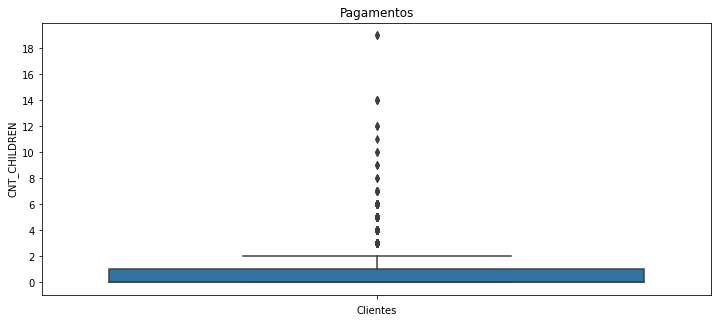

In [ ]:
#identificando outliers CNT_CHILDREN
plot_boxplot(df_app_train,'CNT_CHILDREN', 'Clientes', True, 2)

In [ ]:
outliers, t = find_outliers(df_app_train,'CNT_CHILDREN')
print(t)

+---------------------+--------+
|     CNT_CHILDREN    | Valor  |
+---------------------+--------+
|    Total Outliers   |  4272  |
| Maior valor outlier |   19   |
| Menor valor outlier |   3    |
|      % ouliers      | 1.39 % |
+---------------------+--------+


In [ ]:
# Definindo o máximo de 5 filhos para a base
df_app_train['CNT_CHILDREN'] = df_app_train['CNT_CHILDREN'].apply(lambda x: 5 if x > 5 else x)

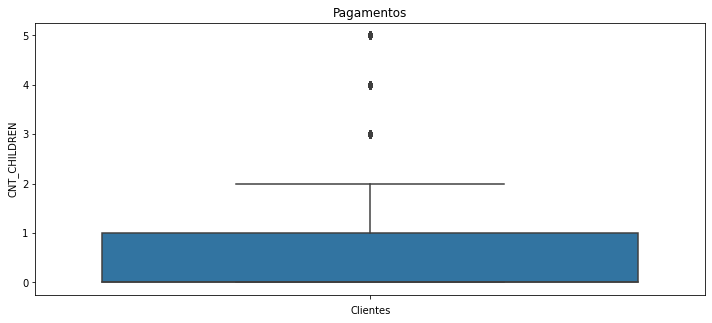

In [ ]:
plot_boxplot(df_app_train,'CNT_CHILDREN', 'Clientes', True, 1)

In [ ]:
df_app_train['CNT_CHILDREN'].isnull().sum()

0

####AMT_INCOME_TOTAL

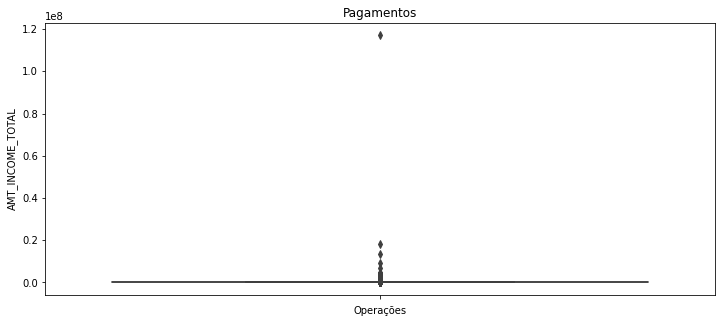

In [ ]:
plot_boxplot(df_app_train,'AMT_INCOME_TOTAL', 'Operações', False, 10e3)

In [ ]:
outliers, t = find_outliers(df_app_train,'AMT_INCOME_TOTAL')
print(t)

+---------------------+-------------+
|   AMT_INCOME_TOTAL  |    Valor    |
+---------------------+-------------+
|    Total Outliers   |    14035    |
| Maior valor outlier | 117000000.0 |
| Menor valor outlier |   337545.0  |
|      % ouliers      |    4.56 %   |
+---------------------+-------------+


In [ ]:
# Definindo o limite máximo para os valores
apply_outliers_limit(df_app_train, 'AMT_INCOME_TOTAL')

Quantile 25: 112500.0
Quantile 75: 202500.0
Limite Superior: 337500.0
+---------------------+-------------+
|   AMT_INCOME_TOTAL  |    Valor    |
+---------------------+-------------+
|    Total Outliers   |    14035    |
| Maior valor outlier | 117000000.0 |
| Menor valor outlier |   337545.0  |
|      % ouliers      |    4.56 %   |
+---------------------+-------------+ 
 +---------------------+-------+
|   AMT_INCOME_TOTAL  | Valor |
+---------------------+-------+
|    Total Outliers   |   0   |
| Maior valor outlier |  nan  |
| Menor valor outlier |  nan  |
|      % ouliers      | 0.0 % |
+---------------------+-------+ 


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018800       -9461   
1       House / apartment                    0.003542      -16765   
2       House / apartment                    0.010030      -19046   
3       House / apartment                    0.008020      -19005   
4       House / apartment                    0.028660      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032560       -9327   
307507  House / apartment       

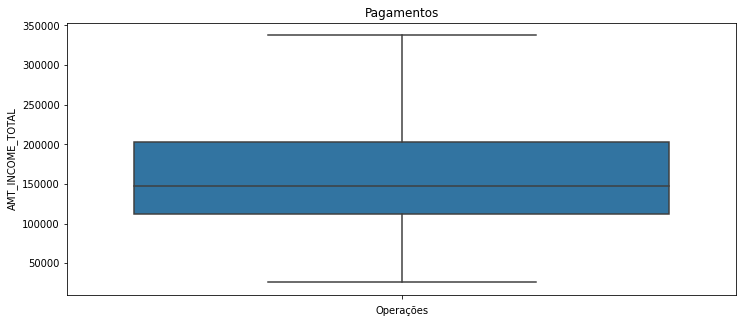

In [ ]:
plot_boxplot(df_app_train,'AMT_INCOME_TOTAL', 'Operações', False, 10e3)

####AMT_CREDIT

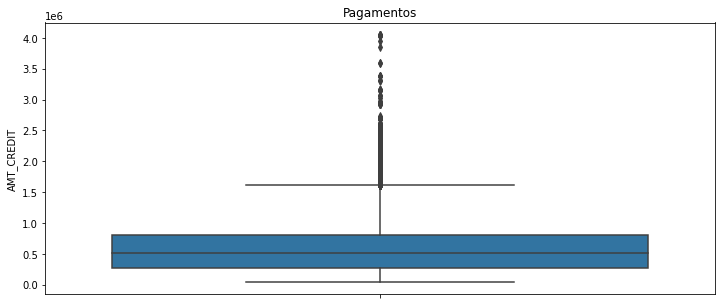

In [ ]:
plot_boxplot(df_app_train,'AMT_CREDIT','',False,100)

In [ ]:
outliers, t = find_outliers(df_app_train,'AMT_CREDIT')
print(t)

+---------------------+-----------+
|      AMT_CREDIT     |   Valor   |
+---------------------+-----------+
|    Total Outliers   |    6562   |
| Maior valor outlier | 4050000.0 |
| Menor valor outlier | 1618767.0 |
|      % ouliers      |   2.13 %  |
+---------------------+-----------+


In [ ]:
# Definindo o limite máximo para os valores
apply_outliers_limit(df_app_train,'AMT_CREDIT')

Quantile 25: 270000.0
Quantile 75: 808650.0
Limite Superior: 1616625.0
+---------------------+-----------+
|      AMT_CREDIT     |   Valor   |
+---------------------+-----------+
|    Total Outliers   |    6562   |
| Maior valor outlier | 4050000.0 |
| Menor valor outlier | 1618767.0 |
|      % ouliers      |   2.13 %  |
+---------------------+-----------+ 
 +---------------------+-------+
|      AMT_CREDIT     | Valor |
+---------------------+-------+
|    Total Outliers   |   0   |
| Maior valor outlier |  nan  |
| Menor valor outlier |  nan  |
|      % ouliers      | 0.0 % |
+---------------------+-------+ 


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018800       -9461   
1       House / apartment                    0.003542      -16765   
2       House / apartment                    0.010030      -19046   
3       House / apartment                    0.008020      -19005   
4       House / apartment                    0.028660      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032560       -9327   
307507  House / apartment       

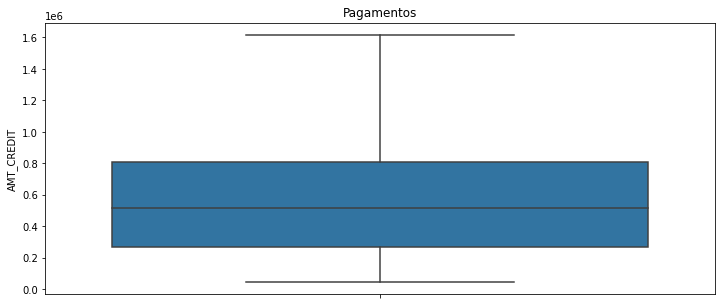

In [ ]:
plot_boxplot(df_app_train,'AMT_CREDIT','',False,100)

In [ ]:
outliers, t  = find_outliers(df_app_train,'AMT_CREDIT')
print(t)

+---------------------+-------+
|      AMT_CREDIT     | Valor |
+---------------------+-------+
|    Total Outliers   |   0   |
| Maior valor outlier |  nan  |
| Menor valor outlier |  nan  |
|      % ouliers      | 0.0 % |
+---------------------+-------+


#### Demais variáveis não categóricas

In [ ]:
# Identificando variáveis categóricas e não categóricas
categ, n_categ = split_categoricals(df_app_train, 10)
print(categ)
print(n_categ)

{'TARGET': 2, 'NAME_CONTRACT_TYPE': 2, 'CODE_GENDER': 3, 'FLAG_OWN_CAR': 2, 'FLAG_OWN_REALTY': 2, 'CNT_CHILDREN': 6, 'NAME_TYPE_SUITE': 8, 'NAME_INCOME_TYPE': 8, 'NAME_EDUCATION_TYPE': 5, 'NAME_FAMILY_STATUS': 6, 'NAME_HOUSING_TYPE': 6, 'FLAG_MOBIL': 2, 'FLAG_EMP_PHONE': 2, 'FLAG_WORK_PHONE': 2, 'FLAG_CONT_MOBILE': 2, 'FLAG_PHONE': 2, 'FLAG_EMAIL': 2, 'REGION_RATING_CLIENT': 3, 'REGION_RATING_CLIENT_W_CITY': 3, 'WEEKDAY_APPR_PROCESS_START': 7, 'REG_REGION_NOT_LIVE_REGION': 2, 'REG_REGION_NOT_WORK_REGION': 2, 'LIVE_REGION_NOT_WORK_REGION': 2, 'REG_CITY_NOT_LIVE_CITY': 2, 'REG_CITY_NOT_WORK_CITY': 2, 'LIVE_CITY_NOT_WORK_CITY': 2, 'FONDKAPREMONT_MODE': 5, 'HOUSETYPE_MODE': 4, 'WALLSMATERIAL_MODE': 8, 'EMERGENCYSTATE_MODE': 3, 'DEF_60_CNT_SOCIAL_CIRCLE': 10, 'FLAG_DOCUMENT_2': 2, 'FLAG_DOCUMENT_3': 2, 'FLAG_DOCUMENT_4': 2, 'FLAG_DOCUMENT_5': 2, 'FLAG_DOCUMENT_6': 2, 'FLAG_DOCUMENT_7': 2, 'FLAG_DOCUMENT_8': 2, 'FLAG_DOCUMENT_9': 2, 'FLAG_DOCUMENT_10': 2, 'FLAG_DOCUMENT_11': 2, 'FLAG_DOCUMEN

In [ ]:
lista_prontos = ['SK_ID_CURR','TARGET','CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT']
aplicar_floor_cap = get_outlier_applicable_list(df_app_train, n_categ, lista_prontos)
print(aplicar_floor_cap)
print(len(aplicar_floor_cap))

['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMEN

In [ ]:
df_app_train, update_outlier  = update_df_outliers(df_app_train, aplicar_floor_cap)

Quantile 25: 16524.0
Quantile 75: 34596.0
Limite Superior: 61704.0
+---------------------+----------+
|     AMT_ANNUITY     |  Valor   |
+---------------------+----------+
|    Total Outliers   |   7504   |
| Maior valor outlier | 258025.5 |
| Menor valor outlier | 61708.5  |
|      % ouliers      |  2.44 %  |
+---------------------+----------+ 
 +---------------------+-------+
|     AMT_ANNUITY     | Valor |
+---------------------+-------+
|    Total Outliers   |   0   |
| Maior valor outlier |  nan  |
| Menor valor outlier |  nan  |
|      % ouliers      | 0.0 % |
+---------------------+-------+ 
Quantile 25: 238500.0
Quantile 75: 679500.0
Limite Superior: 1341000.0
+---------------------+-----------+
|   AMT_GOODS_PRICE   |   Valor   |
+---------------------+-----------+
|    Total Outliers   |   14728   |
| Maior valor outlier | 4050000.0 |
| Menor valor outlier | 1345500.0 |
|      % ouliers      |   4.79 %  |
+---------------------+-----------+ 
 +---------------------+-------+
|

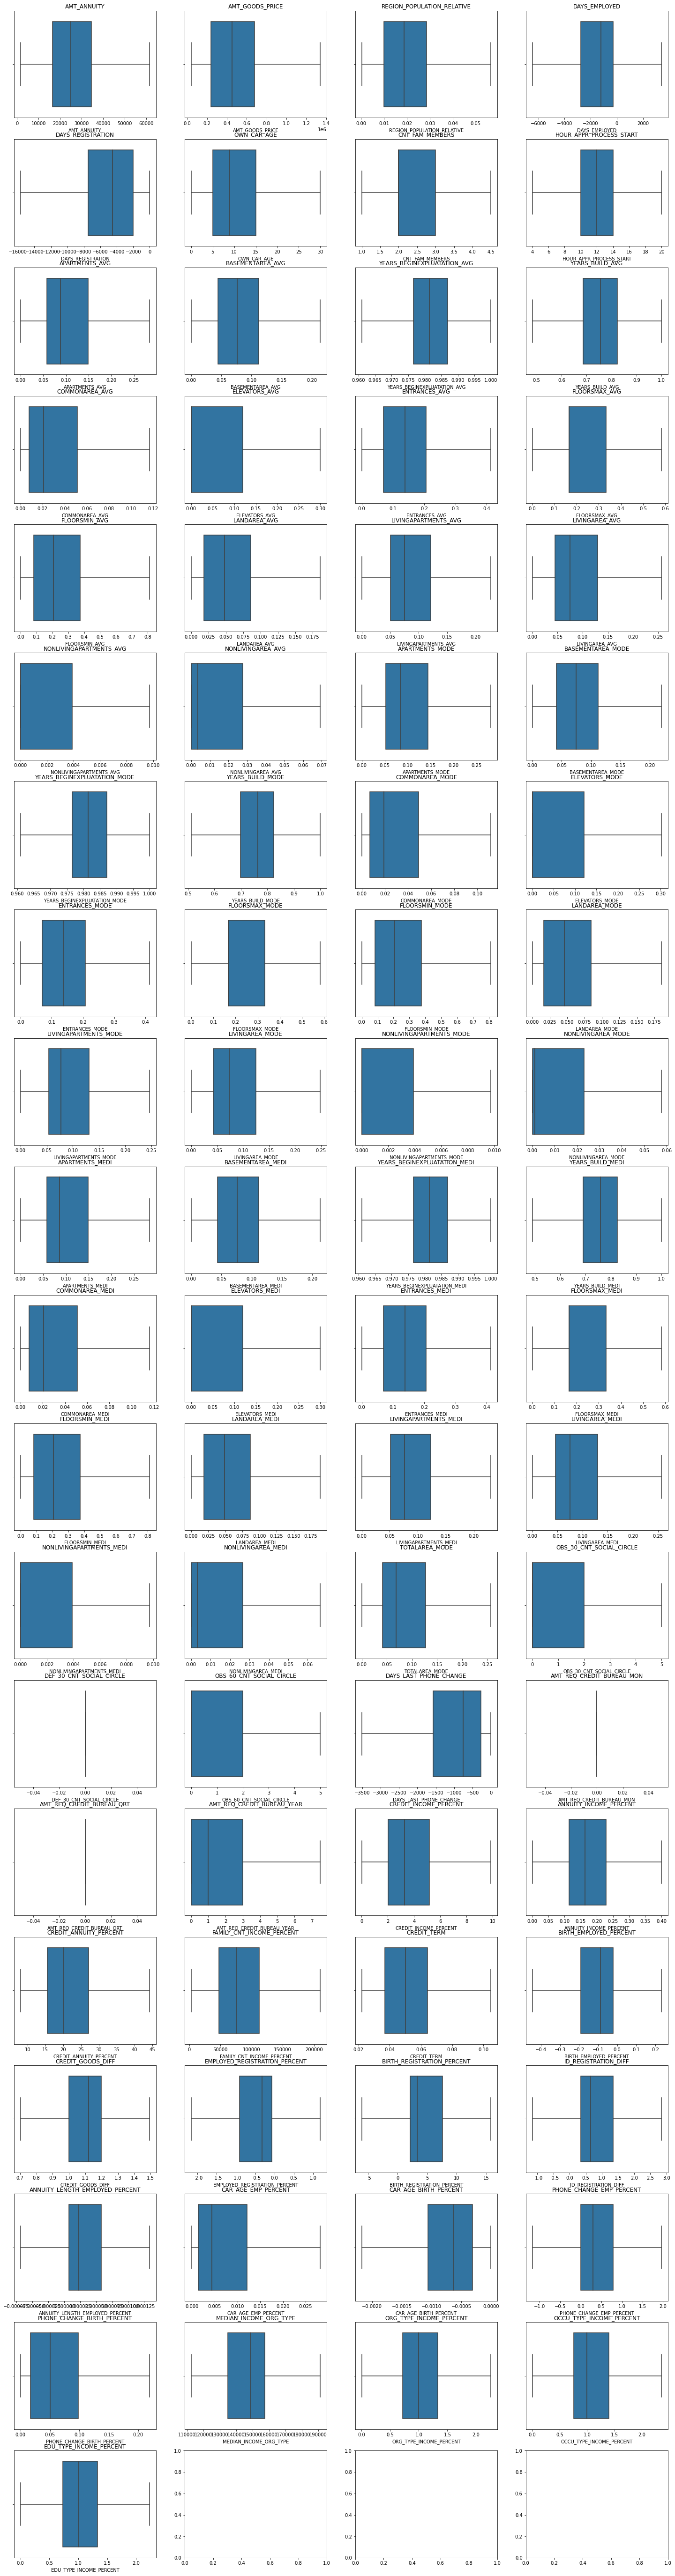

In [ ]:
plot_boxplot_applicable_outlierlimit(df_app_train, update_outlier, 4)

### Tratamento de Dados Faltantes

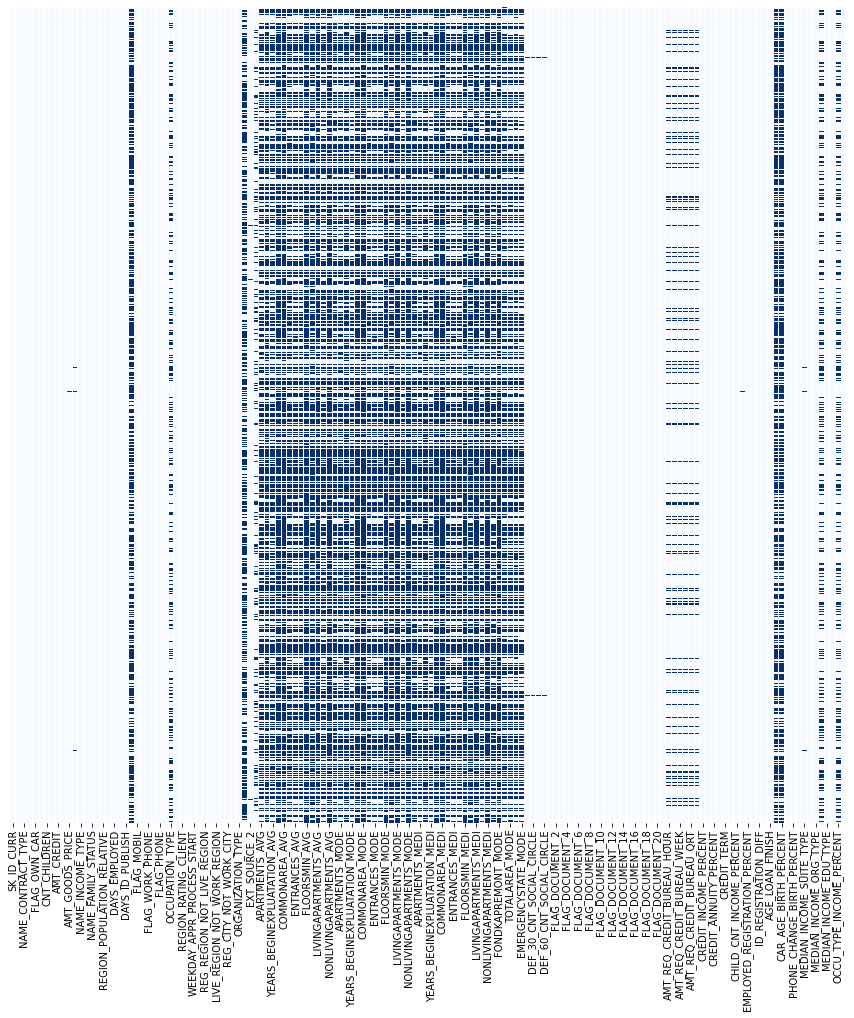

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_app_train.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
missing_data = qtd_missing_data(df_app_train)
print(missing_data)

{'AMT_ANNUITY': 12, 'AMT_GOODS_PRICE': 278, 'NAME_TYPE_SUITE': 1292, 'OWN_CAR_AGE': 202929, 'OCCUPATION_TYPE': 96391, 'CNT_FAM_MEMBERS': 2, 'EXT_SOURCE_1': 173378, 'EXT_SOURCE_2': 660, 'EXT_SOURCE_3': 60965, 'APARTMENTS_AVG': 156061, 'BASEMENTAREA_AVG': 179943, 'YEARS_BEGINEXPLUATATION_AVG': 150007, 'YEARS_BUILD_AVG': 204488, 'COMMONAREA_AVG': 214865, 'ELEVATORS_AVG': 163891, 'ENTRANCES_AVG': 154828, 'FLOORSMAX_AVG': 153020, 'FLOORSMIN_AVG': 208642, 'LANDAREA_AVG': 182590, 'LIVINGAPARTMENTS_AVG': 210199, 'LIVINGAREA_AVG': 154350, 'NONLIVINGAPARTMENTS_AVG': 213514, 'NONLIVINGAREA_AVG': 169682, 'APARTMENTS_MODE': 156061, 'BASEMENTAREA_MODE': 179943, 'YEARS_BEGINEXPLUATATION_MODE': 150007, 'YEARS_BUILD_MODE': 204488, 'COMMONAREA_MODE': 214865, 'ELEVATORS_MODE': 163891, 'ENTRANCES_MODE': 154828, 'FLOORSMAX_MODE': 153020, 'FLOORSMIN_MODE': 208642, 'LANDAREA_MODE': 182590, 'LIVINGAPARTMENTS_MODE': 210199, 'LIVINGAREA_MODE': 154350, 'NONLIVINGAPARTMENTS_MODE': 213514, 'NONLIVINGAREA_MODE': 16

In [ ]:
missing_perc, t = missing_percentage(df_app_train)
print(t)

+---------------------------------+-----------+
|             Feature             | % Missing |
+---------------------------------+-----------+
|      DAYS_LAST_PHONE_CHANGE     |  0.0003%  |
|    PHONE_CHANGE_BIRTH_PERCENT   |  0.0003%  |
|         CNT_FAM_MEMBERS         |  0.0007%  |
|    FAMILY_CNT_INCOME_PERCENT    |  0.0007%  |
|     PHONE_CHANGE_EMP_PERCENT    |  0.0007%  |
|           AMT_ANNUITY           |  0.0039%  |
|      ANNUITY_INCOME_PERCENT     |  0.0039%  |
|      CREDIT_ANNUITY_PERCENT     |  0.0039%  |
|           CREDIT_TERM           |  0.0039%  |
| ANNUITY_LENGTH_EMPLOYED_PERCENT |  0.0039%  |
|         AGE_LOAN_FINISH         |  0.0039%  |
|         AMT_GOODS_PRICE         |  0.0904%  |
|        CREDIT_GOODS_DIFF        |  0.0904%  |
|           EXT_SOURCE_2          |  0.2146%  |
|     OBS_30_CNT_SOCIAL_CIRCLE    |   0.332%  |
|     DEF_30_CNT_SOCIAL_CIRCLE    |   0.332%  |
|     OBS_60_CNT_SOCIAL_CIRCLE    |   0.332%  |
|     DEF_60_CNT_SOCIAL_CIRCLE    |   0.

In [ ]:
df_app_train = missing_treatment(df_app_train,missing_perc,40)

DAYS_LAST_PHONE_CHANGE filled with mean.
PHONE_CHANGE_BIRTH_PERCENT filled with mean.
CNT_FAM_MEMBERS filled with mean.
FAMILY_CNT_INCOME_PERCENT filled with mean.
PHONE_CHANGE_EMP_PERCENT filled with mean.
AMT_ANNUITY filled with mean.
ANNUITY_INCOME_PERCENT filled with mean.
CREDIT_ANNUITY_PERCENT filled with mean.
CREDIT_TERM filled with mean.
ANNUITY_LENGTH_EMPLOYED_PERCENT filled with mean.
AGE_LOAN_FINISH filled with mean.
AMT_GOODS_PRICE filled with mean.
CREDIT_GOODS_DIFF filled with mean.
EXT_SOURCE_2 filled with mean.
OBS_30_CNT_SOCIAL_CIRCLE filled with mean.
DEF_30_CNT_SOCIAL_CIRCLE filled with mean.
OBS_60_CNT_SOCIAL_CIRCLE filled with mean.
DEF_60_CNT_SOCIAL_CIRCLE filled with mean.
NAME_TYPE_SUITE filled with mode.
MEDIAN_INCOME_SUITE_TYPE filled with mean.
AMT_REQ_CREDIT_BUREAU_HOUR filled with mean.
AMT_REQ_CREDIT_BUREAU_DAY filled with mean.
AMT_REQ_CREDIT_BUREAU_WEEK filled with mean.
AMT_REQ_CREDIT_BUREAU_MON filled with mean.
AMT_REQ_CREDIT_BUREAU_QRT filled with m

In [ ]:
missing_data = qtd_missing_data(df_app_train)
missing_perc, t = missing_percentage(df_app_train)
print(t)

+---------+-----------+
| Feature | % Missing |
+---------+-----------+
+---------+-----------+


####Drop de Colunas com valores únicos

In [ ]:
drop_list = []
for i in df_app_train.columns.tolist():
  if len(df_app_train[i].unique()) == 1:
    drop_list.append(i)
print(drop_list)

['DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT']


In [ ]:
for i in drop_list:
  df_app_train.drop(i, axis = 1, inplace = True)

###Normalização e Padronização

In [ ]:
labelencoding_list, onehotencoding_list = separete_categorical(df_app_train, 5)
print(labelencoding_list)
print(onehotencoding_list)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE']
['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


####Label Encoding

In [ ]:
df_app_train = label_encode(df_app_train, labelencoding_list)
df_app_train.head(10)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   
5      100008       0                   0            1             0   
6      100009       0                   0            0             1   
7      100010       0                   0            1             1   
8      100011       0                   0            0             0   
9      100012       0                   1            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1             0          202500.0    406597.5      24700.5   
1                0             0          270000.0   1293502.5      35698.5   
2                1             0           67500.0    135000.0       6750.0   
3                1             0          135000.0    312682.5      29686.5   
4                1             0          121500.0    513000.0      21865.5   
5                1             0           99000.0    490495.5      27517.5   
6                1             1          171000.0   1560726.0      41301.0   
7                1             0          337500.0   1530000.0      42075.0   
8                1             0          112500.0   1019610.0      33826.5   
9                1             0          135000.0    405000.0      20250.0   

   AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0         351000.0    Unaccompanied               Working   
1        1129500.0           Family         State servant   
2         135000.0    Unaccompanied               Working   
3         297000.0    Unaccompanied               Working   
4         513000.0    Unaccompanied               Working   
5         454500.0  Spouse, partner         State servant   
6        1341000.0    Unaccompanied  Commercial associate   
7        1341000.0    Unaccompanied         State servant   
8         913500.0         Children             Pensioner   
9         405000.0    Unaccompanied               Working   

   NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0                    4  Single / not married  House / apartment   
1                    1               Married  House / apartment   
2                    4  Single / not married  House / apartment   
3                    4        Civil marriage  House / apartment   
4                    4  Single / not married  House / apartment   
5                    4               Married  House / apartment   
6                    1               Married  House / apartment   
7                    1               Married  House / apartment   
8                    4               Married  House / apartment   
9                    4  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018800       -9461         -637.0            -3648.0   
1                    0.003542      -16765        -1188.0            -1186.0   
2                    0.010030      -19046         -225.0            -4260.0   
3                    0.008020      -19005        -3039.0            -9830.0   
4                    0.028660      -19932        -3038.0            -4310.0   
5                    0.035800      -16941        -1588.0            -4970.0   
6                    0.035800      -13778        -3130.0            -1213.0   
7                    0.003122      -18850         -449.0            -4596.0   
8                    0.018630      -20099         3417.5            -7428.0   
9                    0.019680      -14469        -2019.0           -14440.0   

   DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PH

####One Hot Encoding

In [ ]:
df_app_train, onehotencoding_list = one_hot_encode(df_app_train, onehotencoding_list)
df_app_train.head(10)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   
5      100008       0                   0            1             0   
6      100009       0                   0            0             1   
7      100010       0                   0            1             1   
8      100011       0                   0            0             0   
9      100012       0                   1            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1             0          202500.0    406597.5      24700.5   
1                0             0          270000.0   1293502.5      35698.5   
2                1             0           67500.0    135000.0       6750.0   
3                1             0          135000.0    312682.5      29686.5   
4                1             0          121500.0    513000.0      21865.5   
5                1             0           99000.0    490495.5      27517.5   
6                1             1          171000.0   1560726.0      41301.0   
7                1             0          337500.0   1530000.0      42075.0   
8                1             0          112500.0   1019610.0      33826.5   
9                1             0          135000.0    405000.0      20250.0   

   AMT_GOODS_PRICE  NAME_EDUCATION_TYPE  REGION_POPULATION_RELATIVE  \
0         351000.0                    4                    0.018800   
1        1129500.0                    1                    0.003542   
2         135000.0                    4                    0.010030   
3         297000.0                    4                    0.008020   
4         513000.0                    4                    0.028660   
5         454500.0                    4                    0.035800   
6        1341000.0                    1                    0.035800   
7        1341000.0                    1                    0.003122   
8         913500.0                    4                    0.018630   
9         405000.0                    4                    0.019680   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0       -9461         -637.0            -3648.0            -2120           1   
1      -16765        -1188.0            -1186.0             -291           1   
2      -19046         -225.0            -4260.0            -2531           1   
3      -19005        -3039.0            -9830.0            -2437           1   
4      -19932        -3038.0            -4310.0            -3458           1   
5      -16941        -1588.0            -4970.0             -477           1   
6      -13778        -3130.0            -1213.0             -619           1   
7      -18850         -449.0            -4596.0            -2379           1   
8      -20099         3417.5            -7428.0            -3514           1   
9      -14469        -2019.0           -14440.0            -3992           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   
5               1                1                 1           1           0   
6               1                0                 1           1           0   
7               1                1   

In [ ]:
for i in df_app_train.columns.tolist():
  if '_nan' in i:
    df_app_train.drop(i, axis = 1, inplace = True)
    print('Column {} droped'.format(i))

Column NAME_TYPE_SUITE_nan droped
Column NAME_INCOME_TYPE_nan droped
Column NAME_FAMILY_STATUS_nan droped
Column NAME_HOUSING_TYPE_nan droped
Column OCCUPATION_TYPE_nan droped
Column WEEKDAY_APPR_PROCESS_START_nan droped
Column ORGANIZATION_TYPE_nan droped


####MinMax Scaler

In [ ]:
# Drop Colunas com Inf
for col in df_app_train.columns.tolist():
  count = np.isinf(df_app_train[col]).values.sum()
  if count > 0:
    print('A coluna {} possui {} valores infinity'.format(col, count))

A coluna CHILD_CNT_INCOME_PERCENT possui 215371 valores infinity


In [ ]:
df_app_train.drop('CHILD_CNT_INCOME_PERCENT', axis = 1, inplace=True)

In [ ]:
#Colunas MinMaxScaler
df_columns = df_app_train.columns.tolist()
for i in df_columns:
  if i in onehotencoding_list:
    df_columns.remove(i)
  if i in labelencoding_list:
    df_columns.remove(i)
df_columns.remove('SK_ID_CURR')
df_columns.remove('TARGET')
print(df_columns)

['CODE_GENDER', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_1

In [ ]:
df_app_train = set_MinMaxScaler(df_app_train, df_columns)
df_app_train.head(5)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0          0.5             0   
1      100003       0                   0          0.0             0   
2      100004       0                   1          0.5             1   
3      100006       0                   0          0.0             0   
4      100007       0                   0          0.5             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0              1.0           0.0          0.567100    0.230079     0.384183   
1              0.0           0.0          0.783550    0.794402     0.567213   
2              1.0           0.0          0.134199    0.057266     0.085449   
3              1.0           0.0          0.350649    0.170322     0.467161   
4              1.0           0.0          0.307359    0.297781     0.337003   

   AMT_GOODS_PRICE  NAME_EDUCATION_TYPE  REGION_POPULATION_RELATIVE  \
0         0.238754                    4                    0.328512   
1         0.837370                    1                    0.057716   
2         0.072664                    4                    0.172864   
3         0.197232                    4                    0.137191   
4         0.363322                    4                    0.503505   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0    0.888839       0.589792           0.767421         0.705433         1.0   
1    0.477114       0.534045           0.924386         0.959566         1.0   
2    0.348534       0.631475           0.728403         0.648326         1.0   
3    0.350846       0.346773           0.373287         0.661387         1.0   
4    0.298591       0.346874           0.725215         0.519522         1.0   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0             1.0              0.0               1.0         1.0         0.0   
1             1.0              0.0               1.0         1.0         0.0   
2             1.0              1.0               1.0         1.0         0.0   
3             1.0              0.0               1.0         0.0         0.0   
4             1.0              0.0               1.0         0.0         0.0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0         0.000000                   0.5                          0.5   
1         0.285714                   0.0                          0.0   
2         0.000000                   0.5                          0.5   
3         0.285714                   0.5                          0.5   
4         0.000000                   0.5                          0.5   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                   0.3750                         0.0   
1                   0.4375                         0.0   
2                   0.3125                         0.0   
3                   0.8125                         0.0   
4                   0.4375                         0.0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     1.0                      1.0   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0      0.307602  

### Salvando no disco

In [ ]:
df_app_train.to_csv(db_dir + '/BasesTratadas/Stage/application_train.csv', index = False)

In [ ]:
del df_app_train
gc.collect()

##**Tabela:** Bureau_book.csv

In [ ]:
df_bureau_book = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Books/bureau_book.csv'))
df_bureau_book.head(5)

Memory usage of dataframe is 237.98 MB
Memory usage after optimization is: 70.29 MB
Decreased by 70.5%


SK_ID_CURR  BUREAU_AMT_CREDIT_SUM_DEBT_mean  \
0      100001                     85240.929688   
1      100002                     30722.625000   
2      100003                         0.000000   
3      100004                         0.000000   
4      100005                    189469.500000   

   BUREAU_AMT_CREDIT_SUM_DEBT_sum  BUREAU_AMT_CREDIT_SUM_OVERDUE_mean  \
0                        596686.5                                 0.0   
1                        245781.0                                 0.0   
2                             0.0                                 0.0   
3                             0.0                                 0.0   
4                        568408.5                                 0.0   

   BUREAU_AMT_CREDIT_SUM_OVERDUE_sum  BUREAU_DAYS_CREDIT_mean  \
0                                0.0                 -735.000   
1                                0.0                 -874.000   
2                                0.0                -1401.000   
3                                0.0                 -867.000   
4                                0.0                 -190.625   

   BUREAU_DAYS_CREDIT_var  BUREAU_DAYS_CREDIT_UPDATE_mean  \
0           240043.671875                       -93.12500   
1           186150.000000                      -500.00000   
2           827783.562500                      -816.00000   
3           421362.000000                      -532.00000   
4            26340.333984                       -54.34375   

   BUREAU_DAYS_CREDIT_UPDATE_min  BUREAU_CREDIT_DAY_OVERDUE_mean  \
0                           -155                             0.0   
1                          -1185                             0.0   
2                          -2131                             0.0   
3                           -682                             0.0   
4                           -121                             0.0   

   BUREAU_CREDIT_DAY_OVERDUE_min  BUREAU_DAYS_CREDIT_ENDDATE_mean  \
0                              0                          82.4375   
1                              0                        -349.0000   
2                              0                        -544.5000   
3                              0                        -488.5000   
4                              0                         439.2500   

   BUREAU_CNT_CREDIT_PROLONG_sum  BUREAU_MONTHS_BALANCE_SIZE_mean  \
0                              0                        24.578125   
1                              0                        13.750000   
2                              0                              NaN   
3                              0                              NaN   
4                              0                         7.000000   

   BUREAU_MONTHS_BALANCE_SIZE_sum  BUREAU_AMT_CREDIT_SUM_LIMIT_mean  \
0                           172.0                          0.000000   
1                           110.0                       7997.141113   
2                             0.0                     202500.000000   
3                             0.0                          0.000000   
4                            21.0                          0.000000   

   BUREAU_AMT_CREDIT_SUM_LIMIT_sum  BUREAU_AMT_CREDIT_MAX_OVERDUE_mean  \
0                         0.000000                                 NaN   
1                     31988.564453                         1681.029053   
2                    810000.000000                            0.000000   
3                         0.000000                            0.000000   
4                         0.000000                            0.000000   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_max  BUREAU_AMT_ANNUITY_max  \
0                                NaN                 10822.5   
1                         5043.64502                     0.0   
2                            0.00000                     0.0   
3                            0.00000                     0.0   
4                            0.00000                  4261.5   

   BUREAU

### Tratamento Outliers

In [ ]:
categ, n_categ = split_categoricals(df_bureau_book, 10)
print(categ)
print(n_categ)

{'BUREAU_CNT_CREDIT_PROLONG_sum': 10, 'BUREAU_CREDIT_ACTIVE_Active_max': 2, 'BUREAU_CREDIT_ACTIVE_Bad debt_max': 2, 'BUREAU_CREDIT_ACTIVE_Closed_max': 2, 'BUREAU_CREDIT_ACTIVE_Sold_max': 2, 'BUREAU_CREDIT_ACTIVE_nan_max': 1, 'BUREAU_CREDIT_CURRENCY_currency 1_max': 2, 'BUREAU_CREDIT_CURRENCY_currency 2_max': 2, 'BUREAU_CREDIT_CURRENCY_currency 3_max': 2, 'BUREAU_CREDIT_CURRENCY_currency 4_max': 2, 'BUREAU_CREDIT_CURRENCY_nan_max': 1, 'BUREAU_CREDIT_TYPE_Another type of loan_max': 2, 'BUREAU_CREDIT_TYPE_Car loan_max': 2, 'BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_max': 2, 'BUREAU_CREDIT_TYPE_Consumer credit_max': 2, 'BUREAU_CREDIT_TYPE_Credit card_max': 2, 'BUREAU_CREDIT_TYPE_Interbank credit_max': 2, 'BUREAU_CREDIT_TYPE_Loan for business development_max': 2, 'BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_max': 2, 'BUREAU_CREDIT_TYPE_Loan for the purchase of equipment_max': 2, 'BUREAU_CREDIT_TYPE_Loan for working capital replenishment_max': 2, 'BUREAU_CREDIT_TYPE_Mi

In [ ]:
lista_prontos = ['SK_ID_CURR','SK_ID_BUREAU']
aplicar_floor_cap = get_outlier_applicable_list(df_bureau_book, n_categ, lista_prontos)
print(aplicar_floor_cap)
print(len(aplicar_floor_cap))

['BUREAU_AMT_CREDIT_SUM_DEBT_mean', 'BUREAU_AMT_CREDIT_SUM_DEBT_sum', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_mean', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_sum', 'BUREAU_DAYS_CREDIT_mean', 'BUREAU_DAYS_CREDIT_var', 'BUREAU_DAYS_CREDIT_UPDATE_mean', 'BUREAU_DAYS_CREDIT_UPDATE_min', 'BUREAU_CREDIT_DAY_OVERDUE_mean', 'BUREAU_CREDIT_DAY_OVERDUE_min', 'BUREAU_DAYS_CREDIT_ENDDATE_mean', 'BUREAU_MONTHS_BALANCE_SIZE_mean', 'BUREAU_MONTHS_BALANCE_SIZE_sum', 'BUREAU_AMT_CREDIT_SUM_LIMIT_mean', 'BUREAU_AMT_CREDIT_SUM_LIMIT_sum', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_mean', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_max', 'BUREAU_AMT_ANNUITY_max', 'BUREAU_AMT_ANNUITY_mean', 'BUREAU_AMT_ANNUITY_sum', 'BUREAU_AMT_CREDIT_SUM_mean', 'BUREAU_AMT_CREDIT_SUM_sum', 'BUREAU_AMT_CREDIT_SUM_max', 'BUREAU_STATUS_1_MEAN_mean', 'BUREAU_STATUS_2_MEAN_mean', 'BUREAU_STATUS_3_MEAN_mean', 'BUREAU_STATUS_4_MEAN_mean', 'BUREAU_STATUS_5_MEAN_mean', 'BUREAU_STATUS_X_MEAN_mean', 'C_AMT_CREDIT_SUM_DEBT_MEAN', 'C_AMT_CREDIT_SUM_DEBT_SUM', 'C_AMT_CREDIT_SUM_

In [ ]:
df_bureau_book, update_outlier  = update_df_outliers(df_bureau_book, aplicar_floor_cap)

Quantile 25: 0.0
Quantile 75: 121944.88671875
Limite Superior: 304862.216796875
+---------------------------------+------------+
| BUREAU_AMT_CREDIT_SUM_DEBT_mean |   Valor    |
+---------------------------------+------------+
|          Total Outliers         |   30127    |
|       Maior valor outlier       | 51750000.0 |
|       Menor valor outlier       | -1083614.6 |
|            % ouliers            |   9.85 %   |
+---------------------------------+------------+ 
 +---------------------------------+-------+
| BUREAU_AMT_CREDIT_SUM_DEBT_mean | Valor |
+---------------------------------+-------+
|          Total Outliers         |   0   |
|       Maior valor outlier       |  nan  |
|       Menor valor outlier       |  nan  |
|            % ouliers            | 0.0 % |
+---------------------------------+-------+ 
Quantile 25: 0.0
Quantile 75: 676541.25
Limite Superior: 1691353.125
+--------------------------------+-------------+
| BUREAU_AMT_CREDIT_SUM_DEBT_sum |    Valor    |
+-----

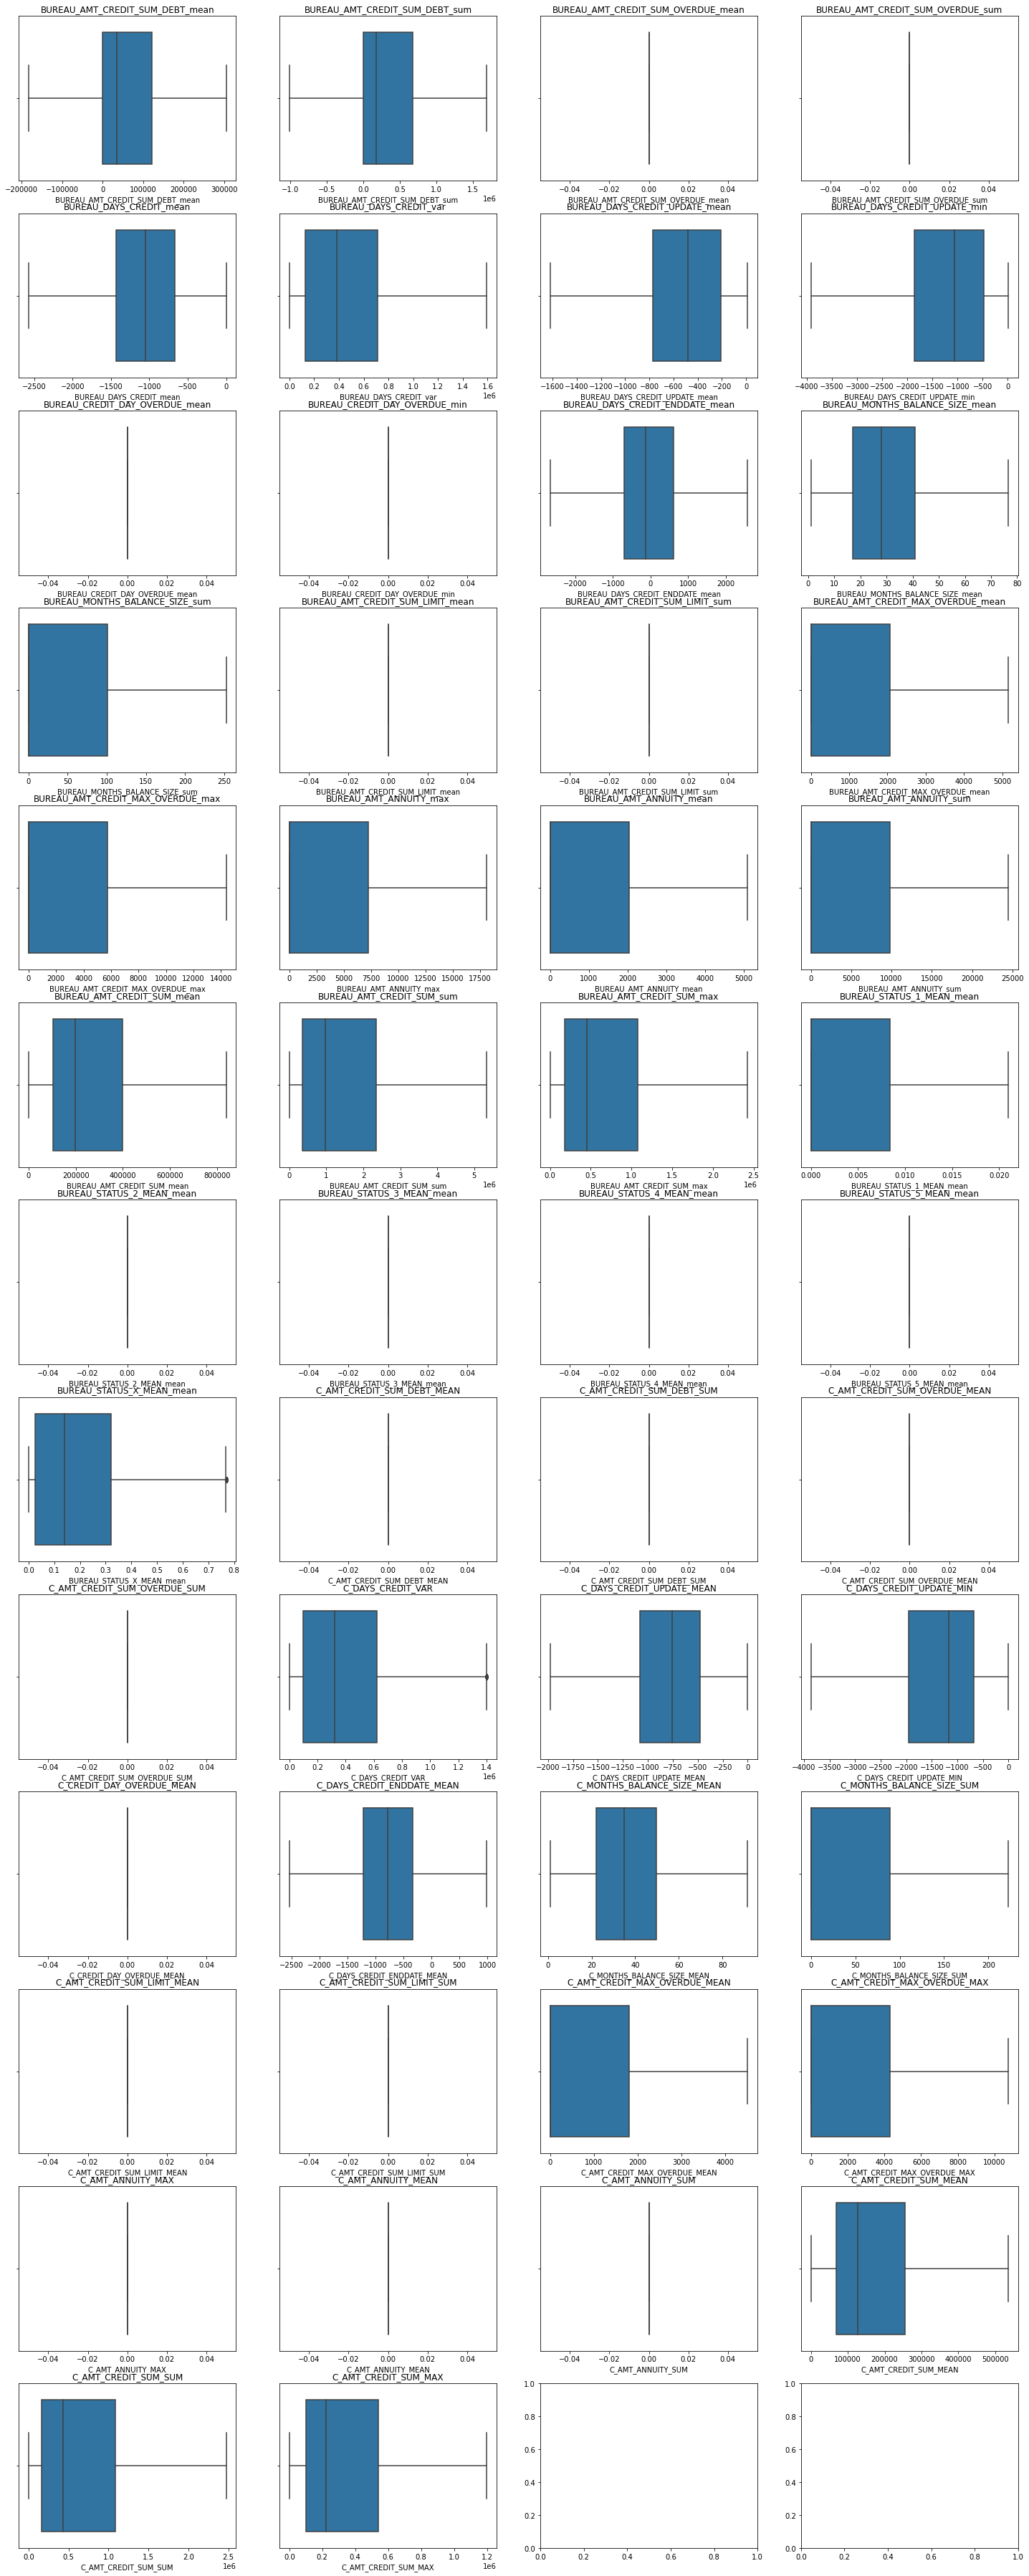

In [ ]:
plot_boxplot_applicable_outlierlimit(df_bureau_book, update_outlier, 4)

####BUREAU_STATUS_X_MEAN_mean

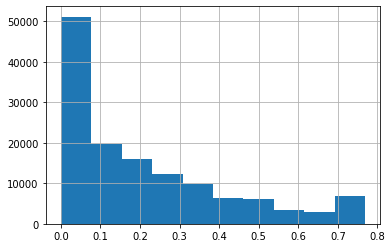

In [ ]:
df_bureau_book['BUREAU_STATUS_X_MEAN_mean'].hist()

+---------------------------+-----------------+
| BUREAU_STATUS_X_MEAN_mean |      Valor      |
+---------------------------+-----------------+
|       Total Outliers      |       5106      |
|    Maior valor outlier    | 0.7689208984375 |
|    Menor valor outlier    | 0.7689208984375 |
|         % ouliers         |      1.67 %     |
+---------------------------+-----------------+
Quantile 25: 0.024993896484375
Quantile 75: 0.322509765625
Limite Superior: 0.7687835693359375
+---------------------------+-------+
| BUREAU_STATUS_X_MEAN_mean | Valor |
+---------------------------+-------+
|       Total Outliers      |   0   |
|    Maior valor outlier    |  nan  |
|    Menor valor outlier    |  nan  |
|         % ouliers         | 0.0 % |
+---------------------------+-------+


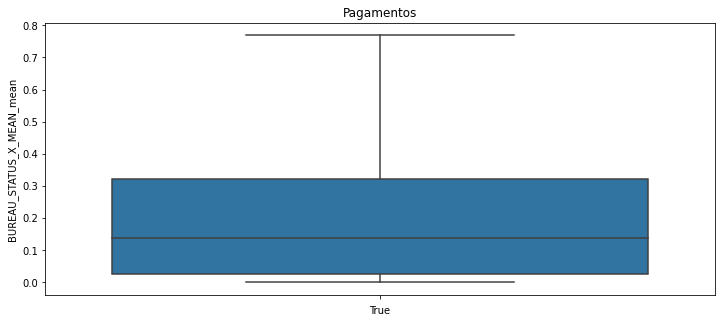

In [ ]:
outliers, t = find_outliers(df_bureau_book, 'BUREAU_STATUS_X_MEAN_mean')
print(t)
Q1, Q3, wlSup, wlInf = get_Q1_Q3_wlSup(df_bureau_book,'BUREAU_STATUS_X_MEAN_mean')
df_bureau_book = apply_wlSup_wlInf(df_bureau_book, 'BUREAU_STATUS_X_MEAN_mean', wlSup, wlInf)
outliers, t = find_outliers(df_bureau_book, 'BUREAU_STATUS_X_MEAN_mean')
print(t)
plot_boxplot(df_bureau_book, 'BUREAU_STATUS_X_MEAN_mean', True)

####C_DAYS_CREDIT_VAR

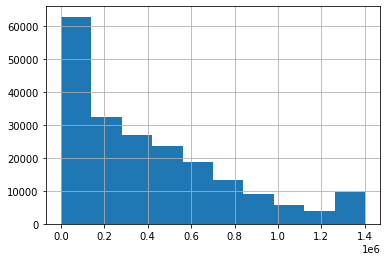

In [ ]:
df_bureau_book['C_DAYS_CREDIT_VAR'].hist()

+---------------------+-------------+
|  C_DAYS_CREDIT_VAR  |    Valor    |
+---------------------+-------------+
|    Total Outliers   |     7070    |
| Maior valor outlier | 1401692.375 |
| Menor valor outlier | 1401692.375 |
|      % ouliers      |    2.31 %   |
+---------------------+-------------+
Quantile 25: 99498.001953125
Quantile 75: 620375.734375
Limite Superior: 1401692.3330078125
+---------------------+-------+
|  C_DAYS_CREDIT_VAR  | Valor |
+---------------------+-------+
|    Total Outliers   |   0   |
| Maior valor outlier |  nan  |
| Menor valor outlier |  nan  |
|      % ouliers      | 0.0 % |
+---------------------+-------+


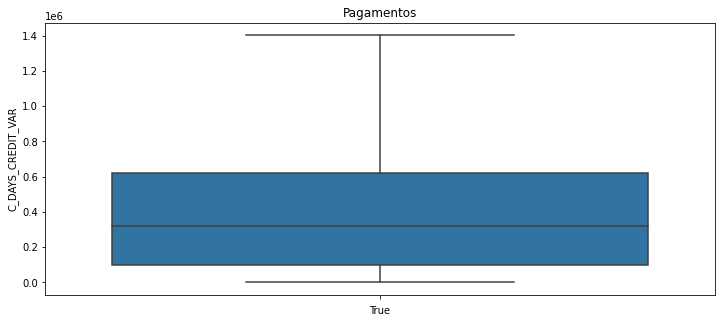

In [ ]:
outliers, t = find_outliers(df_bureau_book, 'C_DAYS_CREDIT_VAR')
print(t)
Q1, Q3, wlSup, wlInf = get_Q1_Q3_wlSup(df_bureau_book,'C_DAYS_CREDIT_VAR')
df_bureau_book = apply_wlSup_wlInf(df_bureau_book, 'C_DAYS_CREDIT_VAR', wlSup, wlInf)
outliers, t = find_outliers(df_bureau_book, 'C_DAYS_CREDIT_VAR')
print(t)
plot_boxplot(df_bureau_book, 'C_DAYS_CREDIT_VAR', True)

####Drop colunas com valor único

In [ ]:
drop_list = []
for i in df_bureau_book.columns.tolist():
  if len(df_bureau_book[i].unique()) == 1:
    drop_list.append(i)
print(drop_list)

['BUREAU_AMT_CREDIT_SUM_OVERDUE_mean', 'BUREAU_AMT_CREDIT_SUM_OVERDUE_sum', 'BUREAU_CREDIT_DAY_OVERDUE_mean', 'BUREAU_CREDIT_DAY_OVERDUE_min', 'BUREAU_AMT_CREDIT_SUM_LIMIT_sum', 'BUREAU_CREDIT_ACTIVE_nan_max', 'BUREAU_CREDIT_CURRENCY_nan_max', 'BUREAU_CREDIT_TYPE_nan_max']


In [ ]:
for i in drop_list:
  df_bureau_book.drop(i, axis = 1, inplace = True)

###Normalização e Padronização

In [ ]:
labelencoding_list, onehotencoding_list = separete_categorical(df_bureau_book, 5)
print(labelencoding_list)
print(onehotencoding_list)

[]
[]


####Drop de Colunas com Infinity

####MinMaxScaler

In [ ]:
#Colunas MinMaxScaler
df_columns = df_bureau_book.columns.tolist()
for i in df_columns:
  if i in onehotencoding_list:
    df_columns.remove(i)
  if i in labelencoding_list:
    df_columns.remove(i)
df_columns.remove('SK_ID_CURR')
print(df_columns)

['BUREAU_AMT_CREDIT_SUM_DEBT_mean', 'BUREAU_AMT_CREDIT_SUM_DEBT_sum', 'BUREAU_DAYS_CREDIT_mean', 'BUREAU_DAYS_CREDIT_var', 'BUREAU_DAYS_CREDIT_UPDATE_mean', 'BUREAU_DAYS_CREDIT_UPDATE_min', 'BUREAU_DAYS_CREDIT_ENDDATE_mean', 'BUREAU_CNT_CREDIT_PROLONG_sum', 'BUREAU_MONTHS_BALANCE_SIZE_mean', 'BUREAU_MONTHS_BALANCE_SIZE_sum', 'BUREAU_AMT_CREDIT_SUM_LIMIT_mean', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_mean', 'BUREAU_AMT_CREDIT_MAX_OVERDUE_max', 'BUREAU_AMT_ANNUITY_max', 'BUREAU_AMT_ANNUITY_mean', 'BUREAU_AMT_ANNUITY_sum', 'BUREAU_AMT_CREDIT_SUM_mean', 'BUREAU_AMT_CREDIT_SUM_sum', 'BUREAU_AMT_CREDIT_SUM_max', 'BUREAU_CREDIT_ACTIVE_Active_max', 'BUREAU_CREDIT_ACTIVE_Bad debt_max', 'BUREAU_CREDIT_ACTIVE_Closed_max', 'BUREAU_CREDIT_ACTIVE_Sold_max', 'BUREAU_CREDIT_CURRENCY_currency 1_max', 'BUREAU_CREDIT_CURRENCY_currency 2_max', 'BUREAU_CREDIT_CURRENCY_currency 3_max', 'BUREAU_CREDIT_CURRENCY_currency 4_max', 'BUREAU_CREDIT_TYPE_Another type of loan_max', 'BUREAU_CREDIT_TYPE_Car loan_max', 'BUREAU_C

In [ ]:
df_bureau_book = set_MinMaxScaler(df_bureau_book, df_columns)
df_bureau_book.head(5)

SK_ID_CURR  BUREAU_AMT_CREDIT_SUM_DEBT_mean  \
0      100001                         0.549753   
1      100002                         0.437985   
2      100003                         0.375000   
3      100004                         0.375000   
4      100005                         0.763433   

   BUREAU_AMT_CREDIT_SUM_DEBT_sum  BUREAU_DAYS_CREDIT_mean  \
0                        0.595492                 0.714202   
1                        0.465823                 0.660154   
2                        0.375000                 0.455235   
3                        0.375000                 0.662875   
4                        0.585042                 0.925877   

   BUREAU_DAYS_CREDIT_var  BUREAU_DAYS_CREDIT_UPDATE_mean  \
0                0.150579                        0.934450   
1                0.116771                        0.685483   
2                0.519267                        0.492122   
3                0.264319                        0.665902   
4                0.016523                        0.958180   

   BUREAU_DAYS_CREDIT_UPDATE_min  BUREAU_DAYS_CREDIT_ENDDATE_mean  \
0                       0.957047                         0.523793   
1                       0.695260                         0.441466   
2                       0.454823                         0.404160   
3                       0.823103                         0.414846   
4                       0.965688                         0.591881   

   BUREAU_CNT_CREDIT_PROLONG_sum  BUREAU_MONTHS_BALANCE_SIZE_mean  \
0                            0.0                         0.311519   
1                            0.0                         0.168456   
2                            0.0                              NaN   
3                            0.0                              NaN   
4                            0.0                         0.079273   

   BUREAU_MONTHS_BALANCE_SIZE_sum  BUREAU_AMT_CREDIT_SUM_LIMIT_mean  \
0                        0.681188                               0.0   
1                        0.435644                               0.0   
2                        0.000000                               0.0   
3                        0.000000                               0.0   
4                        0.083168                               0.0   

   BUREAU_AMT_CREDIT_MAX_OVERDUE_mean  BUREAU_AMT_CREDIT_MAX_OVERDUE_max  \
0                                 NaN                                NaN   
1                            0.325821                           0.350919   
2                            0.000000                           0.000000   
3                            0.000000                           0.000000   
4                            0.000000                           0.000000   

   BUREAU_AMT_ANNUITY_max  BUREAU_AMT_ANNUITY_mean  BUREAU_AMT_ANNUITY_sum  \
0                0.597145                 0.694782                1.000000   
1                0.000000                 0.000000                0.000000   
2                0.000000                 0.000000                0.000000   
3                0.000000                 0.000000                0.000000   
4                0.235133                 0.278375                0.173845   

   BUREAU_AMT_CREDIT_SUM_mean  BUREAU_AMT_CREDIT_SUM_sum  \
0                    0.247552                   0.272046   
1                    0.128927                   0.161924   
2                    0.303264                   0.190441   
3                    0.112696                   0.035385   
4                    0.261166                   0.123003   

   BUREAU_AMT_CREDIT_SUM_max  BUREAU_CREDIT_ACTIVE_Active_max  \
0                   0.155700                              1.0   
1                   0.185357                              1.0   
2                   0.333642                              1.0   
3                   0.038940                              0.0   
4                   0.234291                              1.0   

   BUREAU_CREDIT_ACTIVE_Bad

### Salvando no disco

In [ ]:
df_bureau_book.to_csv(db_dir + '/BasesTratadas/Stage/bureau_book.csv', index = False)

In [ ]:
del df_bureau_book
gc.collect()

127137

##**Tabela:** previous_app_book.csv

In [ ]:
df_previous_app_book = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Books/previous_app_book.csv'))
df_previous_app_book.head(5)

Memory usage of dataframe is 620.47 MB
Memory usage after optimization is: 205.85 MB
Decreased by 66.8%


SK_ID_CURR  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
0      100001           3951.000000            3951.000000   
1      100002           9251.775391            9251.775391   
2      100003          98356.992188           56553.988281   
3      100004           5357.250000            5357.250000   
4      100005           4813.200195            4813.200195   

   PREV_AMT_APPLICATION_MAX  PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MAX  \
0                   24835.5                   24835.50              23787.0   
1                  179055.0                  179055.00             179055.0   
2                  900000.0                  435436.50            1035882.0   
3                   24282.0                   24282.00              20106.0   
4                   44617.5                   22308.75              40153.5   

   PREV_AMT_CREDIT_MEAN  PREV_AMT_DOWN_PAYMENT_MAX  \
0              23787.00                     2520.0   
1             179055.00                        0.0   
2             484191.00                     6885.0   
3              20106.00                     4860.0   
4              20076.75                     4464.0   

   PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_GOODS_PRICE_MEAN  \
0                      2520.0                    24835.5   
1                         0.0                   179055.0   
2                      3442.5                   435436.5   
3                      4860.0                    24282.0   
4                      4464.0                    44617.5   

   PREV_AMT_GOODS_PRICE_SUM  PREV_HOUR_APPR_PROCESS_START_MAX  \
0                   24835.5                                13   
1                  179055.0                                 9   
2                 1306309.5                                17   
3                   24282.0                                 5   
4                   44617.5                                11   

   PREV_HOUR_APPR_PROCESS_START_MEAN  PREV_RATE_DOWN_PAYMENT_MAX  \
0                          13.000000                    0.104309   
1                           9.000000                    0.000000   
2                          14.664062                    0.100037   
3                           5.000000                    0.212036   
4                          10.500000                    0.108948   

   PREV_RATE_DOWN_PAYMENT_MEAN  PREV_RATE_INTEREST_PRIMARY_MAX  \
0                     0.104309                             NaN   
1                     0.000000                             NaN   
2                     0.050018                             NaN   
3                     0.212036                             NaN   
4                     0.108948                             NaN   

   PREV_RATE_INTEREST_PRIMARY_MEAN  PREV_RATE_INTEREST_PRIVILEGED_MAX  \
0                              NaN                                NaN   
1                              NaN                                NaN   
2                              NaN                                NaN   
3                              NaN                                NaN   
4                              NaN                                NaN   

   PREV_RATE_INTEREST_PRIVILEGED_MEAN  PREV_DAYS_DECISION_MAX  \
0                                 NaN                   -1740   
1                                 NaN                    -606   
2                                 NaN                    -746   
3                                 NaN                    -815   
4                                 NaN                    -315   

   PREV_DAYS_DECISION_MEAN  PREV_CNT_PAYMENT_MEAN  PREV_CNT_PAYMENT_SUM  \
0                  -1740.0                    8.0                   8.0   
1                   -606.0                   24.0                  24.0   
2                  -1305.0                   10.0                  30.0   
3                   -815.0                    4.0                   4.0   
4                   -536.0                   12.0                  

###Tratamento Outliers

In [ ]:
categ, n_categ = split_categoricals(df_previous_app_book, 10)
print(categ)
print(n_categ)

{'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN': 8, 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN': 2, 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN': 2, 'CS_REF_RATE_INTEREST_PRIMARY_MAX': 1, 'CS_REF_RATE_INTEREST_PRIMARY_MEAN': 1, 'CS_REF_RATE_INTEREST_PRIVILEGED_MAX': 1, 'CS_REF_RATE_INTEREST_PRIVILEGED_MEAN': 1, 'CS_REF_DAYS_FIRST_DRAWING_MAX': 1, 'CS_REF_DAYS_FIRST_DRAWING_MEAN': 1, 'CS_REF_DAYS_TERMINATION_MAX': 1, 'CS_REF_DAYS_TERMINATION_MEAN': 1, 'CS_REF_DAYS_LAST_DUE_DIFF_MAX': 1, 'CS_REF_DAYS_LAST_DUE_DIFF_MEAN': 1}
{'SK_ID_CURR': 338857, 'PREV_AMT_ANNUITY_MAX': 164391, 'PREV_AMT_ANNUITY_MEAN': 309861, 'PREV_AMT_APPLICATION_MAX': 53054, 'PREV_AMT_APPLICATION_MEAN': 218466, 'PREV_AMT_CREDIT_MAX': 62832, 'PREV_AMT_CREDIT_MEAN': 239697, 'PREV_AMT_DOWN_PAYMENT_MAX': 23435, 'PREV_AMT_DOWN_PAYMENT_MEAN': 59839, 'PREV_AMT_GOODS_PRICE_MEAN': 211325, 'PREV_AMT_GOODS_PRICE_SUM': 198202, 'PREV_HOUR_APPR_PROCESS_START_MAX': 24, 'PREV_HOUR_APPR_PROCESS_START_MEAN': 1579, 'PREV_

In [ ]:
lista_prontos = ['SK_ID_CURR']
aplicar_floor_cap = get_outlier_applicable_list(df_previous_app_book, n_categ, lista_prontos)
print(aplicar_floor_cap)
print(len(aplicar_floor_cap))

['PREV_AMT_ANNUITY_MAX', 'PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_APPLICATION_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX', 'PREV_AMT_DOWN_PAYMENT_MEAN', 'PREV_AMT_GOODS_PRICE_MEAN', 'PREV_AMT_GOODS_PRICE_SUM', 'PREV_HOUR_APPR_PROCESS_START_MAX', 'PREV_HOUR_APPR_PROCESS_START_MEAN', 'PREV_RATE_DOWN_PAYMENT_MAX', 'PREV_RATE_DOWN_PAYMENT_MEAN', 'PREV_RATE_INTEREST_PRIMARY_MAX', 'PREV_RATE_INTEREST_PRIMARY_MEAN', 'PREV_RATE_INTEREST_PRIVILEGED_MAX', 'PREV_RATE_INTEREST_PRIVILEGED_MEAN', 'PREV_DAYS_DECISION_MAX', 'PREV_DAYS_DECISION_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'PREV_CNT_PAYMENT_SUM', 'PREV_DAYS_FIRST_DRAWING_MAX', 'PREV_DAYS_FIRST_DRAWING_MEAN', 'PREV_APPLICATION_CREDIT_RATIO_MAX', 'PREV_APPLICATION_CREDIT_RATIO_MEAN', 'PREV_DOWN_PAYMENT_TO_CREDIT_MAX', 'PREV_DOWN_PAYMENT_TO_CREDIT_MEAN', 'PREV_DAYS_LAST_DUE_DIFF_MAX', 'PREV_DAYS_LAST_DUE_DIFF_MEAN', 'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_M

In [ ]:
df_previous_app_book, update_outlier  = update_df_outliers(df_previous_app_book, aplicar_floor_cap)

Quantile 25: 10525.724609375
Quantile 75: 31840.875
Limite Superior: 63813.6005859375
+----------------------+-----------+
| PREV_AMT_ANNUITY_MAX |   Valor   |
+----------------------+-----------+
|    Total Outliers    |   13348   |
| Maior valor outlier  | 418058.16 |
| Menor valor outlier  |  63817.11 |
|      % ouliers       |   3.94 %  |
+----------------------+-----------+ 
 +----------------------+-------+
| PREV_AMT_ANNUITY_MAX | Valor |
+----------------------+-------+
|    Total Outliers    |   0   |
| Maior valor outlier  |  nan  |
| Menor valor outlier  |  nan  |
|      % ouliers       | 0.0 % |
+----------------------+-------+ 
Quantile 25: 7908.423828125
Quantile 75: 18489.158203125
Limite Superior: 34360.259765625
+-----------------------+-----------+
| PREV_AMT_ANNUITY_MEAN |   Valor   |
+-----------------------+-----------+
|     Total Outliers    |   15176   |
|  Maior valor outlier  | 300425.44 |
|  Menor valor outlier  | 34361.438 |
|       % ouliers       |   4.48 

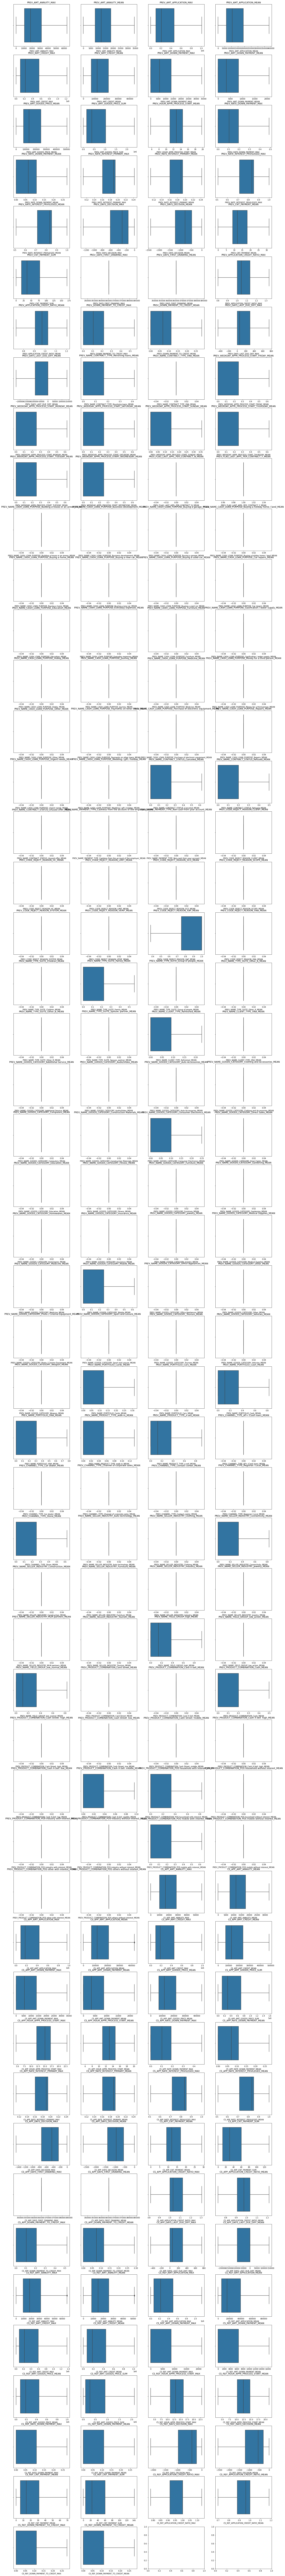

In [ ]:
plot_boxplot_applicable_outlierlimit(df_previous_app_book, update_outlier, 4)

####CS_REF_AMT_ANNUITY_MAX

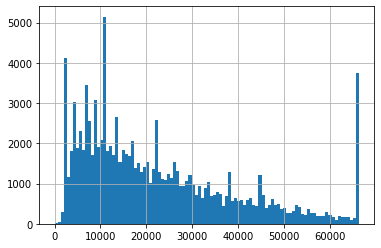

In [ ]:
df_previous_app_book['CS_REF_AMT_ANNUITY_MAX'].hist(bins = 100)

+------------------------+-----------------+
| CS_REF_AMT_ANNUITY_MAX |      Valor      |
+------------------------+-----------------+
|     Total Outliers     |       3638      |
|  Maior valor outlier   | 66245.337890625 |
|  Menor valor outlier   | 66245.337890625 |
|       % ouliers        |      1.07 %     |
+------------------------+-----------------+
Quantile 25: 9196.616455078125
Quantile 75: 32016.1044921875
Limite Superior: 66245.33654785156
+------------------------+-------+
| CS_REF_AMT_ANNUITY_MAX | Valor |
+------------------------+-------+
|     Total Outliers     |   0   |
|  Maior valor outlier   |  nan  |
|  Menor valor outlier   |  nan  |
|       % ouliers        | 0.0 % |
+------------------------+-------+


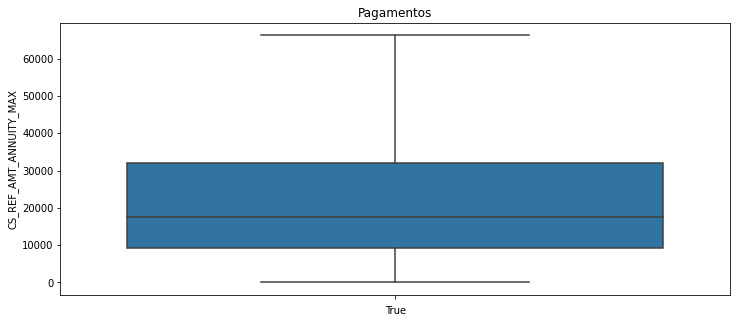

In [ ]:
outliers, t = find_outliers(df_previous_app_book, 'CS_REF_AMT_ANNUITY_MAX')
print(t)
Q1, Q3, wlSup, wlInf = get_Q1_Q3_wlSup(df_previous_app_book, 'CS_REF_AMT_ANNUITY_MAX')
df_previous_app_book = apply_wlSup_wlInf(df_previous_app_book,'CS_REF_AMT_ANNUITY_MAX', wlSup, wlInf)
outliers, t = find_outliers(df_previous_app_book, 'CS_REF_AMT_ANNUITY_MAX')
print(t)
plot_boxplot(df_previous_app_book, 'CS_REF_AMT_ANNUITY_MAX', True)

####CS_REF_AMT_ANNUITY_MEAN

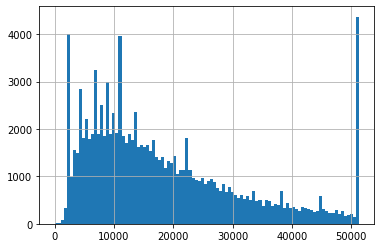

In [ ]:
df_previous_app_book['CS_REF_AMT_ANNUITY_MEAN'].hist(bins = 100)

+-------------------------+-------------+
| CS_REF_AMT_ANNUITY_MEAN |    Valor    |
+-------------------------+-------------+
|      Total Outliers     |     4262    |
|   Maior valor outlier   | 51290.21875 |
|   Menor valor outlier   | 51290.21875 |
|        % ouliers        |    1.26 %   |
+-------------------------+-------------+
Quantile 25: 8301.1279296875
Quantile 75: 25496.76318359375
Limite Superior: 51290.216064453125
+-------------------------+-------+
| CS_REF_AMT_ANNUITY_MEAN | Valor |
+-------------------------+-------+
|      Total Outliers     |   0   |
|   Maior valor outlier   |  nan  |
|   Menor valor outlier   |  nan  |
|        % ouliers        | 0.0 % |
+-------------------------+-------+


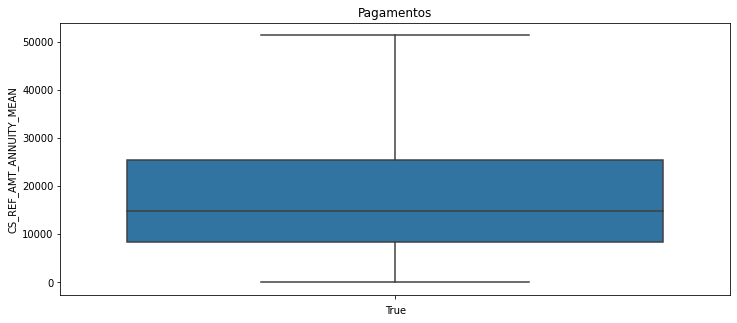

In [ ]:
outliers, t = find_outliers(df_previous_app_book, 'CS_REF_AMT_ANNUITY_MEAN')
print(t)
Q1, Q3, wlSup, wlInf = get_Q1_Q3_wlSup(df_previous_app_book, 'CS_REF_AMT_ANNUITY_MEAN')
df_previous_app_book = apply_wlSup_wlInf(df_previous_app_book,'CS_REF_AMT_ANNUITY_MEAN', wlSup, wlInf)
outliers, t = find_outliers(df_previous_app_book, 'CS_REF_AMT_ANNUITY_MEAN')
print(t)
plot_boxplot(df_previous_app_book, 'CS_REF_AMT_ANNUITY_MEAN', True)

###Tratamento Dados Faltantes

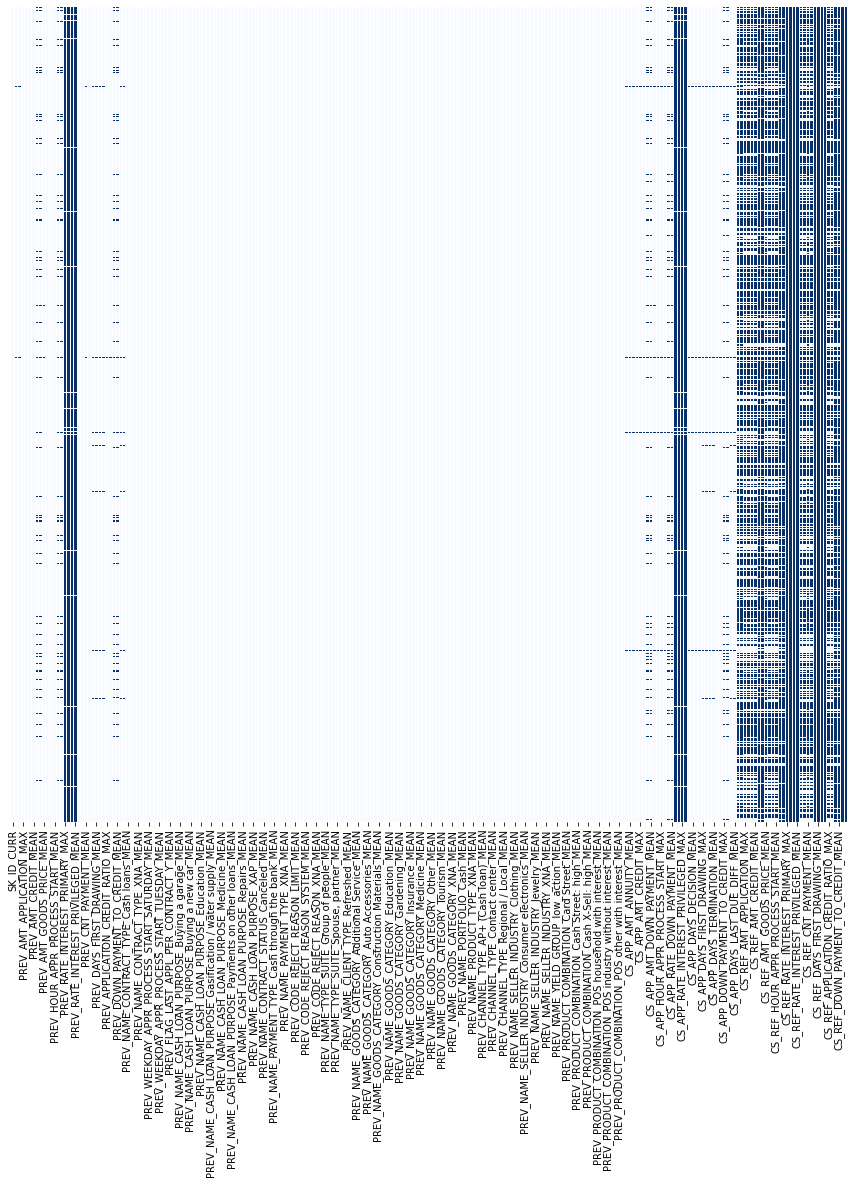

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_previous_app_book.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
missing_data = qtd_missing_data(df_previous_app_book)
print(missing_data)

{'PREV_AMT_ANNUITY_MAX': 480, 'PREV_AMT_ANNUITY_MEAN': 480, 'PREV_AMT_DOWN_PAYMENT_MAX': 20104, 'PREV_AMT_DOWN_PAYMENT_MEAN': 20104, 'PREV_AMT_GOODS_PRICE_MEAN': 1064, 'PREV_RATE_DOWN_PAYMENT_MAX': 20104, 'PREV_RATE_DOWN_PAYMENT_MEAN': 20104, 'PREV_RATE_INTEREST_PRIMARY_MAX': 333136, 'PREV_RATE_INTEREST_PRIMARY_MEAN': 333136, 'PREV_RATE_INTEREST_PRIVILEGED_MAX': 333136, 'PREV_RATE_INTEREST_PRIVILEGED_MEAN': 333136, 'PREV_CNT_PAYMENT_MEAN': 478, 'PREV_DAYS_FIRST_DRAWING_MAX': 1517, 'PREV_DAYS_FIRST_DRAWING_MEAN': 1517, 'PREV_DAYS_TERMINATION_MAX': 1517, 'PREV_DAYS_TERMINATION_MEAN': 1517, 'PREV_APPLICATION_CREDIT_RATIO_MAX': 252, 'PREV_APPLICATION_CREDIT_RATIO_MEAN': 253, 'PREV_DOWN_PAYMENT_TO_CREDIT_MAX': 20104, 'PREV_DOWN_PAYMENT_TO_CREDIT_MEAN': 20104, 'PREV_DAYS_LAST_DUE_DIFF_MAX': 1517, 'PREV_DAYS_LAST_DUE_DIFF_MEAN': 1517, 'CS_APP_AMT_ANNUITY_MAX': 1161, 'CS_APP_AMT_ANNUITY_MEAN': 1161, 'CS_APP_AMT_APPLICATION_MAX': 1159, 'CS_APP_AMT_APPLICATION_MEAN': 1159, 'CS_APP_AMT_CREDIT_MAX

In [ ]:
missing_perc, t = missing_percentage(df_previous_app_book)
print(t)

+--------------------------------------+-----------+
|               Feature                | % Missing |
+--------------------------------------+-----------+
|  PREV_APPLICATION_CREDIT_RATIO_MAX   |  0.0744%  |
|  PREV_APPLICATION_CREDIT_RATIO_MEAN  |  0.0747%  |
|        PREV_CNT_PAYMENT_MEAN         |  0.1411%  |
|         PREV_AMT_ANNUITY_MAX         |  0.1417%  |
|        PREV_AMT_ANNUITY_MEAN         |  0.1417%  |
|      PREV_AMT_GOODS_PRICE_MEAN       |   0.314%  |
|      CS_APP_AMT_APPLICATION_MAX      |   0.342%  |
|     CS_APP_AMT_APPLICATION_MEAN      |   0.342%  |
|        CS_APP_AMT_CREDIT_MAX         |   0.342%  |
|        CS_APP_AMT_CREDIT_MEAN        |   0.342%  |
|      CS_APP_AMT_GOODS_PRICE_SUM      |   0.342%  |
|  CS_APP_HOUR_APPR_PROCESS_START_MAX  |   0.342%  |
| CS_APP_HOUR_APPR_PROCESS_START_MEAN  |   0.342%  |
|       CS_APP_DAYS_DECISION_MAX       |   0.342%  |
|      CS_APP_DAYS_DECISION_MEAN       |   0.342%  |
|       CS_APP_CNT_PAYMENT_MEAN        |   0.3

In [ ]:
df_previous_app_book = missing_treatment(df_previous_app_book,missing_perc,40)

PREV_APPLICATION_CREDIT_RATIO_MAX filled with mean.
PREV_APPLICATION_CREDIT_RATIO_MEAN filled with mean.
PREV_CNT_PAYMENT_MEAN filled with mean.
PREV_AMT_ANNUITY_MAX filled with mean.
PREV_AMT_ANNUITY_MEAN filled with mean.
PREV_AMT_GOODS_PRICE_MEAN filled with mean.
CS_APP_AMT_APPLICATION_MAX filled with mean.
CS_APP_AMT_APPLICATION_MEAN filled with mean.
CS_APP_AMT_CREDIT_MAX filled with mean.
CS_APP_AMT_CREDIT_MEAN filled with mean.
CS_APP_AMT_GOODS_PRICE_SUM filled with mean.
CS_APP_HOUR_APPR_PROCESS_START_MAX filled with mean.
CS_APP_HOUR_APPR_PROCESS_START_MEAN filled with mean.
CS_APP_DAYS_DECISION_MAX filled with mean.
CS_APP_DAYS_DECISION_MEAN filled with mean.
CS_APP_CNT_PAYMENT_MEAN filled with mean.
CS_APP_CNT_PAYMENT_SUM filled with mean.
CS_APP_AMT_ANNUITY_MAX filled with mean.
CS_APP_AMT_ANNUITY_MEAN filled with mean.
CS_APP_APPLICATION_CREDIT_RATIO_MAX filled with mean.
CS_APP_APPLICATION_CREDIT_RATIO_MEAN filled with mean.
PREV_DAYS_FIRST_DRAWING_MAX filled with mean.


####Drop de Colunas com valor unitário

In [ ]:
drop_list = []
for i in df_previous_app_book.columns.tolist():
  if len(df_previous_app_book[i].unique()) == 1:
    drop_list.append(i)
print(drop_list)

['PREV_DAYS_FIRST_DRAWING_MAX', 'PREV_DAYS_FIRST_DRAWING_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_

In [ ]:
print('Total de Colunas antes do Drop: {}'.format(df_previous_app_book.shape[1]))
for i in drop_list:
  df_previous_app_book.drop(i, axis = 1, inplace = True)
print('Total de Colunas depois do Drop: {}'.format(df_previous_app_book.shape[1]))

Total de Colunas antes do Drop: 200
Total de Colunas depois do Drop: 103


###Normalização e Padronização

In [ ]:
labelencoding_list, onehotencoding_list = separete_categorical(df_previous_app_book, 5)
print(labelencoding_list)
print(onehotencoding_list)

[]
[]


####MinMaxScaler

In [ ]:
#Colunas MinMaxScaler
df_columns = df_previous_app_book.columns.tolist()
for i in df_columns:
  if i in onehotencoding_list:
    df_columns.remove(i)
  if i in labelencoding_list:
    df_columns.remove(i)
df_columns.remove('SK_ID_CURR')
print(df_columns)

['PREV_AMT_ANNUITY_MAX', 'PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_APPLICATION_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_DOWN_PAYMENT_MAX', 'PREV_AMT_DOWN_PAYMENT_MEAN', 'PREV_AMT_GOODS_PRICE_MEAN', 'PREV_AMT_GOODS_PRICE_SUM', 'PREV_HOUR_APPR_PROCESS_START_MAX', 'PREV_HOUR_APPR_PROCESS_START_MEAN', 'PREV_RATE_DOWN_PAYMENT_MAX', 'PREV_RATE_DOWN_PAYMENT_MEAN', 'PREV_DAYS_DECISION_MAX', 'PREV_DAYS_DECISION_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'PREV_CNT_PAYMENT_SUM', 'PREV_DAYS_TERMINATION_MAX', 'PREV_DAYS_TERMINATION_MEAN', 'PREV_APPLICATION_CREDIT_RATIO_MAX', 'PREV_APPLICATION_CREDIT_RATIO_MEAN', 'PREV_DOWN_PAYMENT_TO_CREDIT_MAX', 'PREV_DOWN_PAYMENT_TO_CREDIT_MEAN', 'PREV_DAYS_LAST_DUE_DIFF_MAX', 'PREV_DAYS_LAST_DUE_DIFF_MEAN', 'PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN', 'PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN', 'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_M

In [ ]:
df_previous_app_book = set_MinMaxScaler(df_previous_app_book, df_columns)
df_previous_app_book.head(5)

SK_ID_CURR  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
0      100001              0.061915               0.114987   
1      100002              0.144981               0.269258   
2      100003              1.000000               1.000000   
3      100004              0.083952               0.155914   
4      100005              0.075426               0.140080   

   PREV_AMT_APPLICATION_MAX  PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MAX  \
0                  0.024604                   0.064451             0.019408   
1                  0.177389                   0.464671             0.146090   
2                  0.891625                   1.000000             0.845170   
3                  0.024056                   0.063015             0.016404   
4                  0.044202                   0.057894             0.032761   

   PREV_AMT_CREDIT_MEAN  PREV_AMT_DOWN_PAYMENT_MAX  \
0              0.054073                   0.074667   
1              0.407030                   0.000000   
2              1.000000                   0.204000   
3              0.045705                   0.144000   
4              0.045639                   0.132267   

   PREV_AMT_DOWN_PAYMENT_MEAN  PREV_AMT_GOODS_PRICE_MEAN  \
0                    0.121091                   0.049001   
1                    0.000011                   0.353276   
2                    0.165414                   0.859117   
3                    0.233522                   0.047908   
4                    0.214495                   0.088030   

   PREV_AMT_GOODS_PRICE_SUM  PREV_HOUR_APPR_PROCESS_START_MAX  \
0                  0.010588                          0.565217   
1                  0.076339                          0.391304   
2                  0.556937                          0.739130   
3                  0.010352                          0.217391   
4                  0.019022                          0.478261   

   PREV_HOUR_APPR_PROCESS_START_MEAN  PREV_RATE_DOWN_PAYMENT_MAX  \
0                           0.517857                    0.214295   
1                           0.232143                    0.000000   
2                           0.636719                    0.205517   
3                           0.000000                    0.435611   
4                           0.339286                    0.223824   

   PREV_RATE_DOWN_PAYMENT_MEAN  PREV_DAYS_DECISION_MAX  \
0                     0.383201                0.000000   
1                     0.000028                0.520792   
2                     0.183767                0.409901   
3                     0.778930                0.355248   
4                     0.400241                0.751287   

   PREV_DAYS_DECISION_MEAN  PREV_CNT_PAYMENT_MEAN  PREV_CNT_PAYMENT_SUM  \
0                 0.273791               0.253968              0.047619   
1                 0.747624               0.761905              0.142857   
2                 0.455552               0.317460              0.178571   
3                 0.660295               0.126984              0.023810   
4                 0.776872               0.380952              0.071429   

   PREV_DAYS_TERMINATION_MAX  PREV_DAYS_TERMINATION_MEAN  \
0                   0.003369                    0.003369   
1                   0.007702                    0.007702   
2                   0.006316                    0.004903   
3                   0.005808                    0.005808   
4                   0.006498                    0.006498   

   PREV_APPLICATION_CREDIT_RATIO_MAX  PREV_APPLICATION_CREDIT_RATIO_MEAN  \
0                           0.458441                            0.662190   
1                           0.375000                            0.569215   
2                           0.396029                            0.461777   
3                           0.768175                            1.000000   
4                           0.585451                            0.804752   

   PREV_DOWN_PAYMENT_TO_CREDIT_MAX  PREV_DOWN_PAYME

### Salvando no Disco

In [ ]:
df_previous_app_book.to_csv(db_dir + '/BasesTratadas/Stage/previous_app_book.csv', index = False)

In [ ]:
del df_previous_app_book
gc.collect()

34

##**TABELA:** POS_CASH_balance.csv

In [ ]:
df_pos_cash_balance_book = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Books/pos_cash_balance_book.csv'))
df_pos_cash_balance_book.head(5)

Memory usage of dataframe is 72.04 MB
Memory usage after optimization is: 18.01 MB
Decreased by 75.0%


SK_ID_CURR  POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  POS_SK_DPD_DEF_MIN  \
0      100001                   7             0.777832                   0   
1      100002                   0             0.000000                   0   
2      100003                   0             0.000000                   0   
3      100004                   0             0.000000                   0   
4      100005                   0             0.000000                   0   

   POS_SK_DPD_MAX  POS_SK_DPD_MEAN  POS_SK_DPD_MIN  POS_MONTHS_BALANCE_MAX  \
0               7         0.777832               0                     -53   
1               0         0.000000               0                      -1   
2               0         0.000000               0                     -18   
3               0         0.000000               0                     -24   
4               0         0.000000               0                     -15   

   POS_MONTHS_BALANCE_MEAN  POS_MONTHS_BALANCE_SIZE  POS_CNT_INSTALMENT_MAX  \
0                -72.56250                        9                     4.0   
1                -10.00000                       19                    24.0   
2                -43.78125                       28                    12.0   
3                -25.50000                        4                     4.0   
4                -20.00000                       11                    12.0   

   POS_CNT_INSTALMENT_SIZE  POS_CNT_INSTALMENT_FUTURE_MAX  \
0                        9                            4.0   
1                       19                           24.0   
2                       28                           12.0   
3                        4                            4.0   
4                       11                           12.0   

   POS_CNT_INSTALMENT_FUTURE_SIZE  POS_CNT_INSTALMENT_FUTURE_SUM  \
0                               9                           13.0   
1                              19                          285.0   
2                              28                          162.0   
3                               4                            9.0   
4                              11                           72.0   

   POS_NAME_CONTRACT_STATUS_Active_MEAN  \
0                              0.777832   
1                              1.000000   
2                              0.928711   
3                              0.750000   
4                              0.818359   

   POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   POS_NAME_CONTRACT_STATUS_Canceled_MEAN  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   POS_NAME_CONTRACT_STATUS_Completed_MEAN  \
0                                 0.222168   
1                                 0.000000   
2                                 0.071411   
3                                 0.250000   
4                                 0.090881   

   POS_NAME_CONTRACT_STATUS_Demand_MEAN  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
0                                                0.0     
1                                                0.0  

###Tratamento de Outliers

In [ ]:
categ, n_categ = split_categoricals(df_pos_cash_balance_book, 10)
print(categ)
print(n_categ)

{'POS_SK_DPD_DEF_MIN': 3, 'POS_NAME_CONTRACT_STATUS_XNA_MEAN': 3}
{'SK_ID_CURR': 337252, 'POS_SK_DPD_DEF_MAX': 217, 'POS_SK_DPD_DEF_MEAN': 4160, 'POS_SK_DPD_MAX': 2025, 'POS_SK_DPD_MEAN': 8824, 'POS_SK_DPD_MIN': 65, 'POS_MONTHS_BALANCE_MAX': 96, 'POS_MONTHS_BALANCE_MEAN': 4123, 'POS_MONTHS_BALANCE_SIZE': 234, 'POS_CNT_INSTALMENT_MAX': 66, 'POS_CNT_INSTALMENT_SIZE': 234, 'POS_CNT_INSTALMENT_FUTURE_MAX': 66, 'POS_CNT_INSTALMENT_FUTURE_SIZE': 234, 'POS_CNT_INSTALMENT_FUTURE_SUM': 2615, 'POS_NAME_CONTRACT_STATUS_Active_MEAN': 1072, 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN': 18, 'POS_NAME_CONTRACT_STATUS_Approved_MEAN': 234, 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN': 15, 'POS_NAME_CONTRACT_STATUS_Completed_MEAN': 1590, 'POS_NAME_CONTRACT_STATUS_Demand_MEAN': 254, 'POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN': 241, 'POS_NAME_CONTRACT_STATUS_Signed_MEAN': 870, 'POS_LOAN_COMPLETED_MEAN': 4669, 'POS_COMPLETED_BEFORE_MEAN': 16, 'POS_REMAINING_INSTALMENTS': 120, 'POS_REMAINING_INSTALM

In [ ]:
lista_prontos = ['SK_ID_CURR']
aplicar_floor_cap = get_outlier_applicable_list(df_pos_cash_balance_book, n_categ, lista_prontos)
print(aplicar_floor_cap)
print(len(aplicar_floor_cap))

['POS_SK_DPD_DEF_MAX', 'POS_SK_DPD_DEF_MEAN', 'POS_SK_DPD_MAX', 'POS_SK_DPD_MEAN', 'POS_SK_DPD_MIN', 'POS_MONTHS_BALANCE_MAX', 'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_CNT_INSTALMENT_MAX', 'POS_CNT_INSTALMENT_SIZE', 'POS_CNT_INSTALMENT_FUTURE_MAX', 'POS_CNT_INSTALMENT_FUTURE_SIZE', 'POS_CNT_INSTALMENT_FUTURE_SUM', 'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'POS_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Completed_MEAN', 'POS_NAME_CONTRACT_STATUS_Demand_MEAN', 'POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN', 'POS_NAME_CONTRACT_STATUS_Signed_MEAN', 'POS_LOAN_COMPLETED_MEAN', 'POS_COMPLETED_BEFORE_MEAN', 'POS_REMAINING_INSTALMENTS', 'POS_REMAINING_INSTALMENTS_RATIO']
25


In [ ]:
df_pos_cash_balance_book, update_outlier  = update_df_outliers(df_pos_cash_balance_book, aplicar_floor_cap)

Quantile 25: 0.0
Quantile 75: 0.0
Limite Superior: 0.0
+---------------------+---------+
|  POS_SK_DPD_DEF_MAX |  Valor  |
+---------------------+---------+
|    Total Outliers   |  45949  |
| Maior valor outlier |   3595  |
| Menor valor outlier |    1    |
|      % ouliers      | 13.62 % |
+---------------------+---------+ 
 +---------------------+-------+
|  POS_SK_DPD_DEF_MAX | Valor |
+---------------------+-------+
|    Total Outliers   |   0   |
| Maior valor outlier |  nan  |
| Menor valor outlier |  nan  |
|      % ouliers      | 0.0 % |
+---------------------+-------+ 
Quantile 25: 0.0
Quantile 75: 0.0
Limite Superior: 0.0
+---------------------+----------+
| POS_SK_DPD_DEF_MEAN |  Valor   |
+---------------------+----------+
|    Total Outliers   |  45949   |
| Maior valor outlier |  1741.0  |
| Menor valor outlier | 0.004406 |
|      % ouliers      | 13.62 %  |
+---------------------+----------+ 
 +---------------------+-------+
| POS_SK_DPD_DEF_MEAN | Valor |
+------------

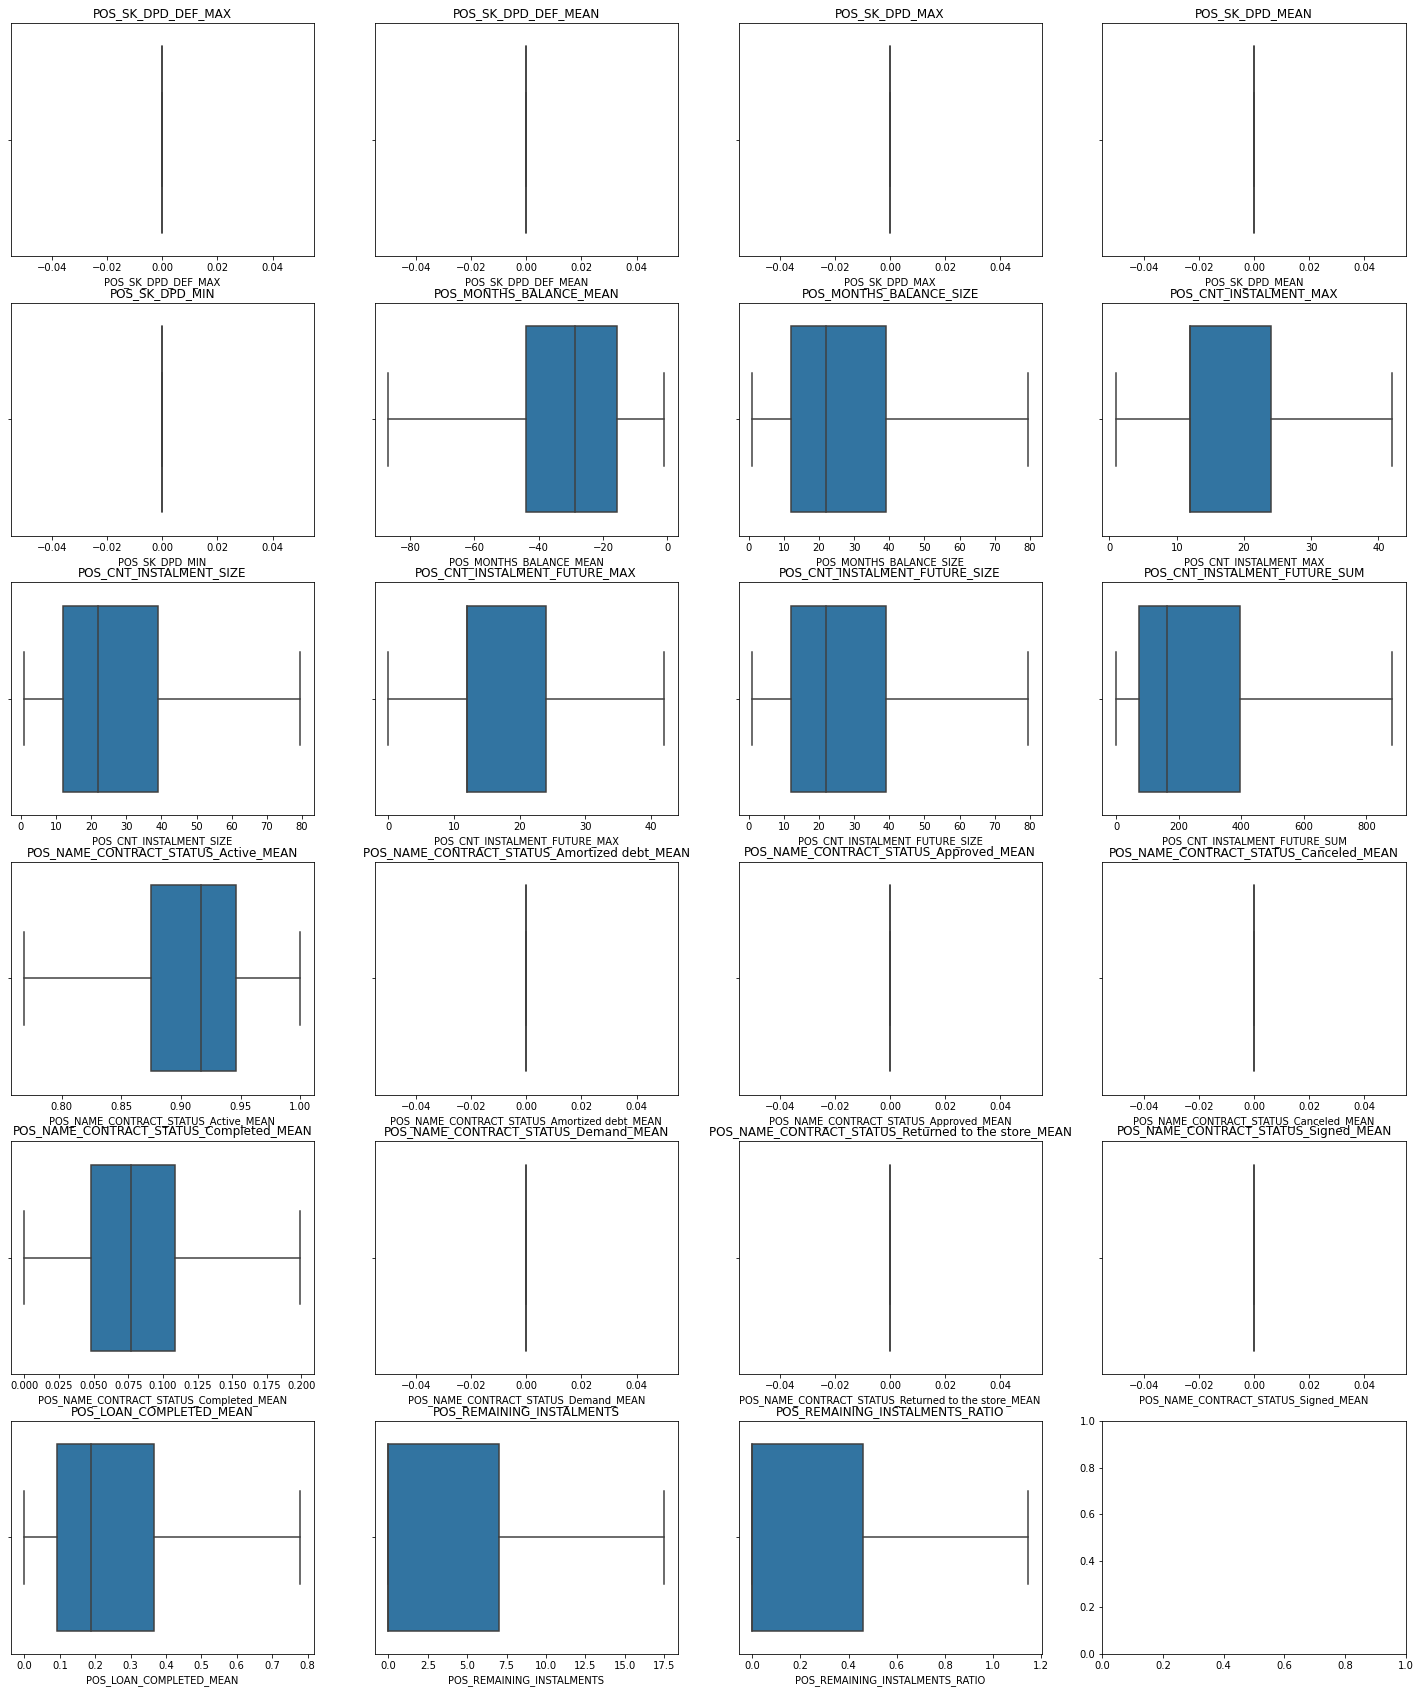

In [ ]:
plot_boxplot_applicable_outlierlimit(df_pos_cash_balance_book, update_outlier, 4)

###Tratamento Dados Faltantes

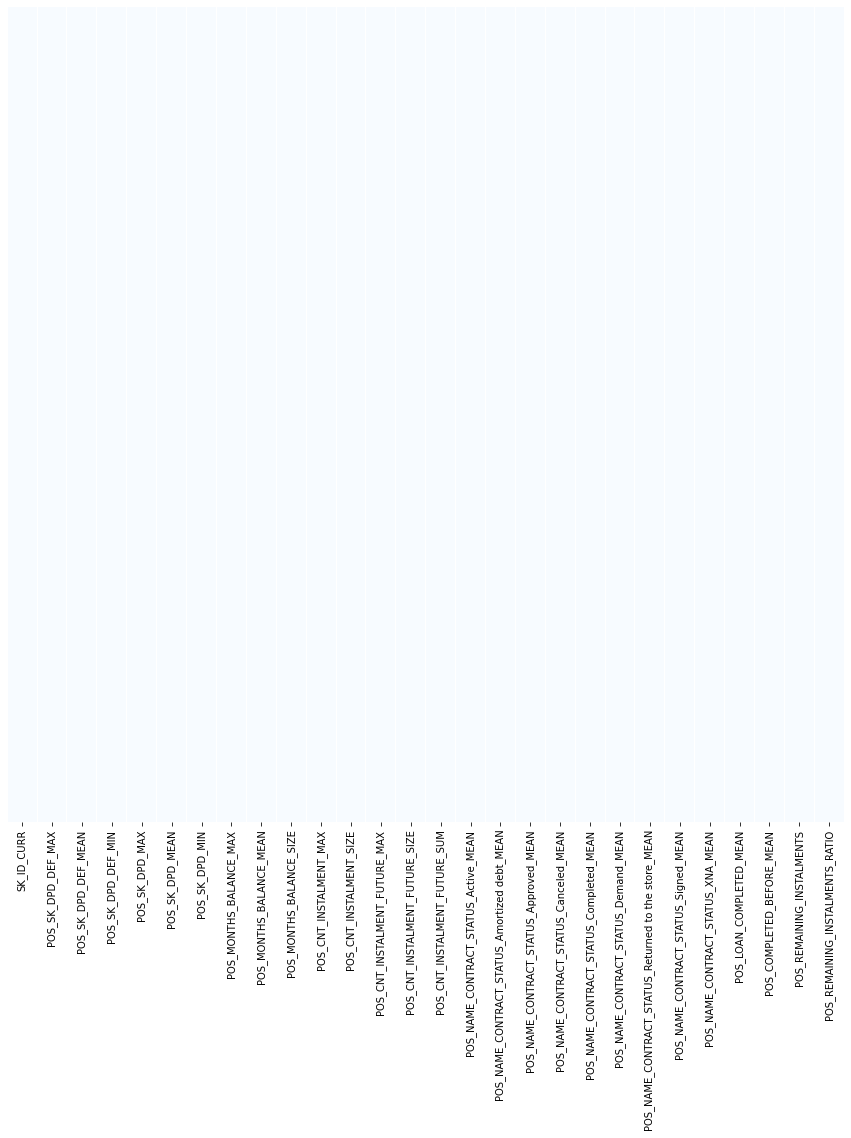

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_pos_cash_balance_book.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
missing_data = qtd_missing_data(df_pos_cash_balance_book)
print(missing_data)

{'POS_CNT_INSTALMENT_MAX': 28, 'POS_CNT_INSTALMENT_FUTURE_MAX': 28}


In [ ]:
missing_perc, t = missing_percentage(df_pos_cash_balance_book)
print(t)

+-------------------------------+-----------+
|            Feature            | % Missing |
+-------------------------------+-----------+
|     POS_CNT_INSTALMENT_MAX    |  0.0083%  |
| POS_CNT_INSTALMENT_FUTURE_MAX |  0.0083%  |
+-------------------------------+-----------+


In [ ]:
df_pos_cash_balance_book = missing_treatment(df_pos_cash_balance_book,missing_perc,40)

POS_CNT_INSTALMENT_MAX filled with mean.
POS_CNT_INSTALMENT_FUTURE_MAX filled with mean.


In [ ]:
missing_perc, t = missing_percentage(df_pos_cash_balance_book)
print(t)

+---------+-----------+
| Feature | % Missing |
+---------+-----------+
+---------+-----------+


####Drop de Colunas com Valores Únicos

In [ ]:
drop_list = []
for i in df_pos_cash_balance_book.columns.tolist():
  if len(df_pos_cash_balance_book[i].unique()) == 1:
    drop_list.append(i)
print(drop_list)

['POS_SK_DPD_DEF_MAX', 'POS_SK_DPD_DEF_MEAN', 'POS_SK_DPD_MAX', 'POS_SK_DPD_MEAN', 'POS_SK_DPD_MIN', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'POS_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN', 'POS_NAME_CONTRACT_STATUS_Demand_MEAN', 'POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN', 'POS_NAME_CONTRACT_STATUS_Signed_MEAN']


In [ ]:
print('Total de Colunas antes do Drop: {}'.format(df_pos_cash_balance_book.shape[1]))
for i in drop_list:
  df_pos_cash_balance_book.drop(i, axis = 1, inplace = True)
print('Total de Colunas depois do Drop: {}'.format(df_pos_cash_balance_book.shape[1]))

Total de Colunas antes do Drop: 28
Total de Colunas depois do Drop: 17


###Normalização e Padronização

In [ ]:
labelencoding_list, onehotencoding_list = separete_categorical(df_pos_cash_balance_book, 5)
print(labelencoding_list)
print(onehotencoding_list)

[]
[]


####Label Encoding

In [ ]:
#Não há categóricas para Label Encoding

####One-Hot Encoding

In [ ]:
#Não há categóricas para One-Hot Encoding

####MinMax Scaler

In [ ]:
#Colunas MinMaxScaler
df_columns = df_pos_cash_balance_book.columns.tolist()
for i in df_columns:
  if i in onehotencoding_list:
    df_columns.remove(i)
  if i in labelencoding_list:
    df_columns.remove(i)
df_columns.remove('SK_ID_CURR')
print(df_columns)

['POS_SK_DPD_DEF_MIN', 'POS_MONTHS_BALANCE_MAX', 'POS_MONTHS_BALANCE_MEAN', 'POS_MONTHS_BALANCE_SIZE', 'POS_CNT_INSTALMENT_MAX', 'POS_CNT_INSTALMENT_SIZE', 'POS_CNT_INSTALMENT_FUTURE_MAX', 'POS_CNT_INSTALMENT_FUTURE_SIZE', 'POS_CNT_INSTALMENT_FUTURE_SUM', 'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'POS_NAME_CONTRACT_STATUS_Completed_MEAN', 'POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'POS_LOAN_COMPLETED_MEAN', 'POS_COMPLETED_BEFORE_MEAN', 'POS_REMAINING_INSTALMENTS', 'POS_REMAINING_INSTALMENTS_RATIO']


In [ ]:
df_pos_cash_balance_book = set_MinMaxScaler(df_pos_cash_balance_book, df_columns)
df_pos_cash_balance_book.head(5)

SK_ID_CURR  POS_SK_DPD_DEF_MIN  POS_MONTHS_BALANCE_MAX  \
0      100001                 0.0                0.452632   
1      100002                 0.0                1.000000   
2      100003                 0.0                0.821053   
3      100004                 0.0                0.757895   
4      100005                 0.0                0.852632   

   POS_MONTHS_BALANCE_MEAN  POS_MONTHS_BALANCE_SIZE  POS_CNT_INSTALMENT_MAX  \
0                 0.165452                 0.101911                0.073171   
1                 0.895044                 0.229299                0.560976   
2                 0.501093                 0.343949                0.268293   
3                 0.714286                 0.038217                0.073171   
4                 0.778426                 0.127389                0.268293   

   POS_CNT_INSTALMENT_SIZE  POS_CNT_INSTALMENT_FUTURE_MAX  \
0                 0.101911                       0.095238   
1                 0.229299                       0.571429   
2                 0.343949                       0.285714   
3                 0.038217                       0.095238   
4                 0.127389                       0.285714   

   POS_CNT_INSTALMENT_FUTURE_SIZE  POS_CNT_INSTALMENT_FUTURE_SUM  \
0                        0.101911                       0.014739   
1                        0.229299                       0.323129   
2                        0.343949                       0.183673   
3                        0.038217                       0.010204   
4                        0.127389                       0.081633   

   POS_NAME_CONTRACT_STATUS_Active_MEAN  \
0                              0.039071   
1                              1.000000   
2                              0.691658   
3                              0.000000   
4                              0.214361   

   POS_NAME_CONTRACT_STATUS_Completed_MEAN  POS_NAME_CONTRACT_STATUS_XNA_MEAN  \
0                                 1.000000                                0.0   
1                                 0.000000                                0.0   
2                                 0.358566                                0.0   
3                                 1.000000                                0.0   
4                                 0.456329                                0.0   

   POS_LOAN_COMPLETED_MEAN  POS_COMPLETED_BEFORE_MEAN  \
0                 0.577449                   0.000000   
1                 0.000000                   0.000000   
2                 0.320840                   0.066667   
3                 0.320840                   0.066667   
4                 0.116633                   0.066667   

   POS_REMAINING_INSTALMENTS  POS_REMAINING_INSTALMENTS_RATIO  
0                   0.000000                         0.000000  
1                   0.342857                         0.218221  
2                   0.057143                         0.072722  
3                   0.000000                         0.000000  
4                   0.000000                         0.000000

### Salvando no Disco

In [ ]:
df_pos_cash_balance_book.to_csv(db_dir + '/BasesTratadas/Stage/pos_cash_balance_book.csv', index = False)

In [ ]:
del df_pos_cash_balance_book
gc.collect()

690

##**TABELA:** installments_payments.csv

In [ ]:
df_installment_payments_book = pd.read_csv(db_dir + '/BasesTratadas/Books/installments_payments_book.csv')
df_installment_payments_book.head(5)

SK_ID_CURR  INS_LATE_PAYMENT_MAX  INS_LATE_PAYMENT_MEAN  \
0      100001                     1               0.571429   
1      100002                     1               1.000000   
2      100003                     1               1.000000   
3      100004                     1               1.000000   
4      100005                     1               0.888889   

   INS_LATE_PAYMENT_MIN  INS_AMT_PAYMENT_MIN  INS_AMT_PAYMENT_MAX  \
0                     0             3951.000            17397.900   
1                     1             9251.775            53093.746   
2                     1             6662.970           560835.400   
3                     1             5357.250            10573.965   
4                     0             4813.200            17656.244   

   INS_AMT_PAYMENT_MEAN  INS_AMT_PAYMENT_SUM  \
0             5885.1323            41195.926   
1            11559.2470           219625.700   
2            64754.5860          1618864.600   
3             7096.1550            21288.465   
4             6240.2050            56161.844   

   INS_NUM_INSTALMENT_VERSION_NUNIQUE  INS_NUM_INSTALMENT_NUMBER_MAX  \
0                                   2                              4   
1                                   2                             19   
2                                   2                             12   
3                                   2                              3   
4                                   2                              9   

   INS_AMT_INSTALMENT_MAX  INS_AMT_INSTALMENT_MEAN  INS_AMT_INSTALMENT_SUM  \
0               17397.900                5885.1323               41195.926   
1               53093.746               11559.2470              219625.700   
2              560835.400               64754.5860             1618864.600   
3               10573.965                7096.1550               21288.465   
4               17656.244                6240.2050               56161.844   

   INS_PAYMENT_DIFFERENCE_MAX  INS_PAYMENT_DIFFERENCE_MEAN  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   INS_PAYMENT_DIFFERENCE_MIN  INS_PAYMENT_DIFFERENCE_SUM  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   INS_DAYS_ENTRY_PAYMENT_MAX  INS_DAYS_ENTRY_PAYMENT_MEAN  \
0                     -1628.0                      -2196.0   
1                       -49.0                       -315.5   
2                      -544.0                      -1385.0   
3                      -727.0                       -761.5   
4                      -470.0                       -609.5   

   INS_DAYS_ENTRY_PAYMENT_SUM  INS_PAID_OVER_AMOUNT_MAX  \
0                    -15370.0                       0.0   
1                     -5990.0                       0.0   
2                    -34620.0                       0.0   
3                     -2284.0                       0.0   
4                     -5490.0                       0.0   

   INS_PAID_OVER_AMOUNT_MEAN  INS_PAID_OVER_AMOUNT_MIN  INSTALLATION_COUNT  
0                        0.0                       0.0                   7  
1                        0.0                       0.0                  19  
2                        0.0                       0.0                  25  
3                        0.0                       0.0                   3  
4                        0.0                       0.0                   9

###Tratamento de Outliers

In [ ]:
categ, n_categ = split_categoricals(df_installment_payments_book, 10)
print(categ)
print(n_categ)

{'INS_LATE_PAYMENT_MAX': 2, 'INS_LATE_PAYMENT_MIN': 2}
{'SK_ID_CURR': 339587, 'INS_LATE_PAYMENT_MEAN': 9217, 'INS_AMT_PAYMENT_MIN': 149981, 'INS_AMT_PAYMENT_MAX': 262550, 'INS_AMT_PAYMENT_MEAN': 334340, 'INS_AMT_PAYMENT_SUM': 334504, 'INS_NUM_INSTALMENT_VERSION_NUNIQUE': 50, 'INS_NUM_INSTALMENT_NUMBER_MAX': 239, 'INS_AMT_INSTALMENT_MAX': 271024, 'INS_AMT_INSTALMENT_MEAN': 333855, 'INS_AMT_INSTALMENT_SUM': 335011, 'INS_PAYMENT_DIFFERENCE_MAX': 2977, 'INS_PAYMENT_DIFFERENCE_MEAN': 45296, 'INS_PAYMENT_DIFFERENCE_MIN': 42739, 'INS_PAYMENT_DIFFERENCE_SUM': 35014, 'INS_DAYS_ENTRY_PAYMENT_MAX': 2497, 'INS_DAYS_ENTRY_PAYMENT_MEAN': 5633, 'INS_DAYS_ENTRY_PAYMENT_SUM': 7142, 'INS_PAID_OVER_AMOUNT_MAX': 41879, 'INS_PAID_OVER_AMOUNT_MEAN': 160560, 'INS_PAID_OVER_AMOUNT_MIN': 119642, 'INSTALLATION_COUNT': 323}


In [ ]:
lista_prontos = ['SK_ID_CURR']
aplicar_floor_cap = get_outlier_applicable_list(df_installment_payments_book, n_categ, lista_prontos)
print(aplicar_floor_cap)
print(len(aplicar_floor_cap))

['INS_LATE_PAYMENT_MEAN', 'INS_AMT_PAYMENT_MIN', 'INS_AMT_PAYMENT_MAX', 'INS_AMT_PAYMENT_MEAN', 'INS_AMT_PAYMENT_SUM', 'INS_NUM_INSTALMENT_VERSION_NUNIQUE', 'INS_NUM_INSTALMENT_NUMBER_MAX', 'INS_AMT_INSTALMENT_MAX', 'INS_AMT_INSTALMENT_MEAN', 'INS_AMT_INSTALMENT_SUM', 'INS_PAYMENT_DIFFERENCE_MAX', 'INS_PAYMENT_DIFFERENCE_MEAN', 'INS_PAYMENT_DIFFERENCE_MIN', 'INS_PAYMENT_DIFFERENCE_SUM', 'INS_DAYS_ENTRY_PAYMENT_MAX', 'INS_DAYS_ENTRY_PAYMENT_MEAN', 'INS_DAYS_ENTRY_PAYMENT_SUM', 'INS_PAID_OVER_AMOUNT_MAX', 'INS_PAID_OVER_AMOUNT_MEAN', 'INS_PAID_OVER_AMOUNT_MIN', 'INSTALLATION_COUNT']
21


In [ ]:
df_installment_payments_book, update_outlier  = update_df_outliers(df_installment_payments_book, aplicar_floor_cap)

Quantile 25: 0.6410256410256411
Quantile 75: 1.0
Limite Superior: 1.5384615384615383
+-----------------------+--------------------+
| INS_LATE_PAYMENT_MEAN |       Valor        |
+-----------------------+--------------------+
|     Total Outliers    |        1782        |
|  Maior valor outlier  | 0.1025641025641025 |
|  Menor valor outlier  |        0.0         |
|       % ouliers       |       0.52 %       |
+-----------------------+--------------------+ 
 +-----------------------+-------+
| INS_LATE_PAYMENT_MEAN | Valor |
+-----------------------+-------+
|     Total Outliers    |   0   |
|  Maior valor outlier  |  nan  |
|  Menor valor outlier  |  nan  |
|       % ouliers       | 0.0 % |
+-----------------------+-------+ 
Quantile 25: 41.535
Quantile 75: 7158.723749999999
Limite Superior: 17834.506875
+---------------------+-----------+
| INS_AMT_PAYMENT_MIN |   Valor   |
+---------------------+-----------+
|    Total Outliers   |   18555   |
| Maior valor outlier | 2504589.8 |
| M

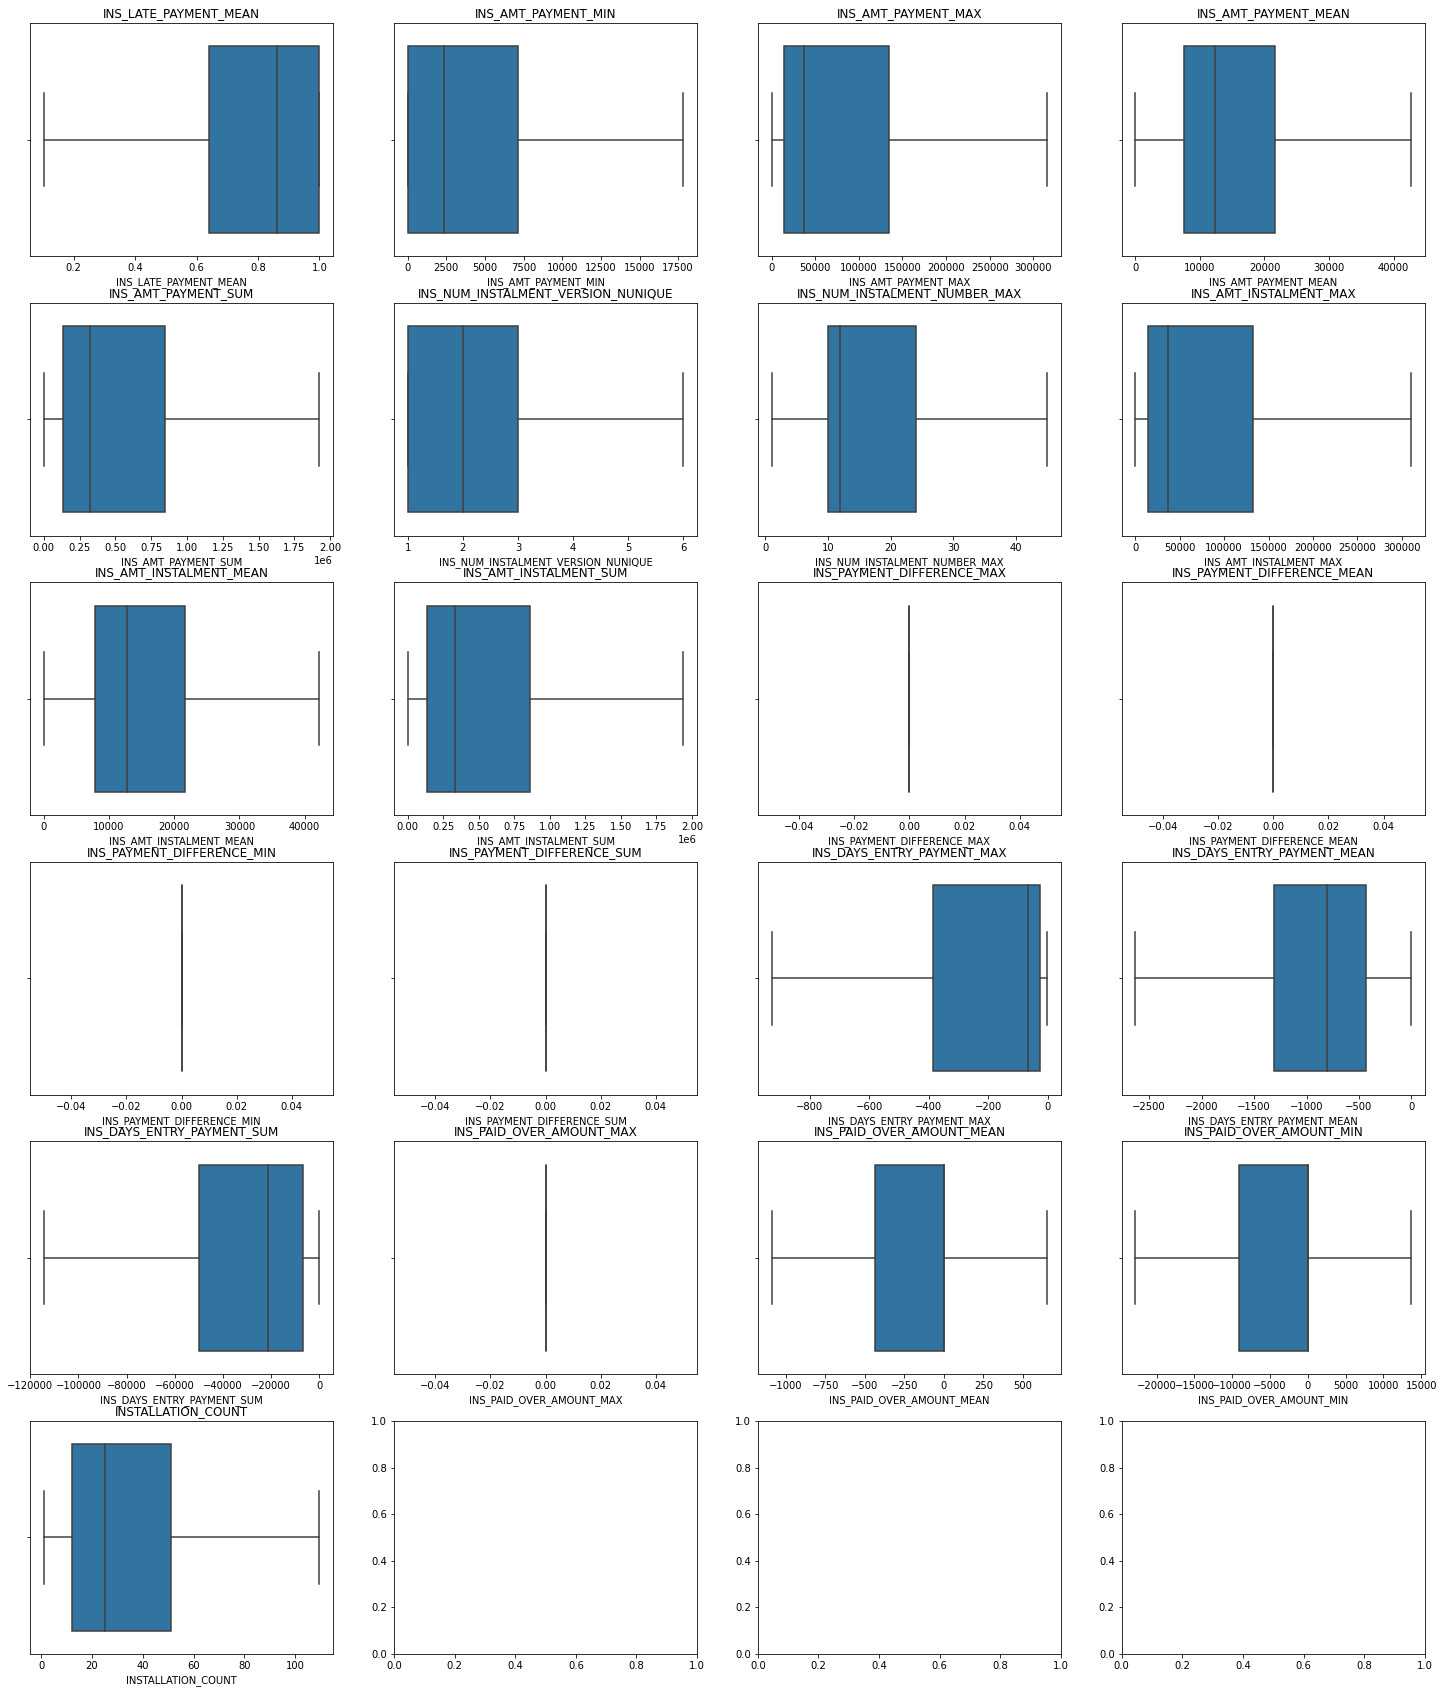

In [ ]:
plot_boxplot_applicable_outlierlimit(df_installment_payments_book, update_outlier, 4)

###Tratamento de Dados Faltantes

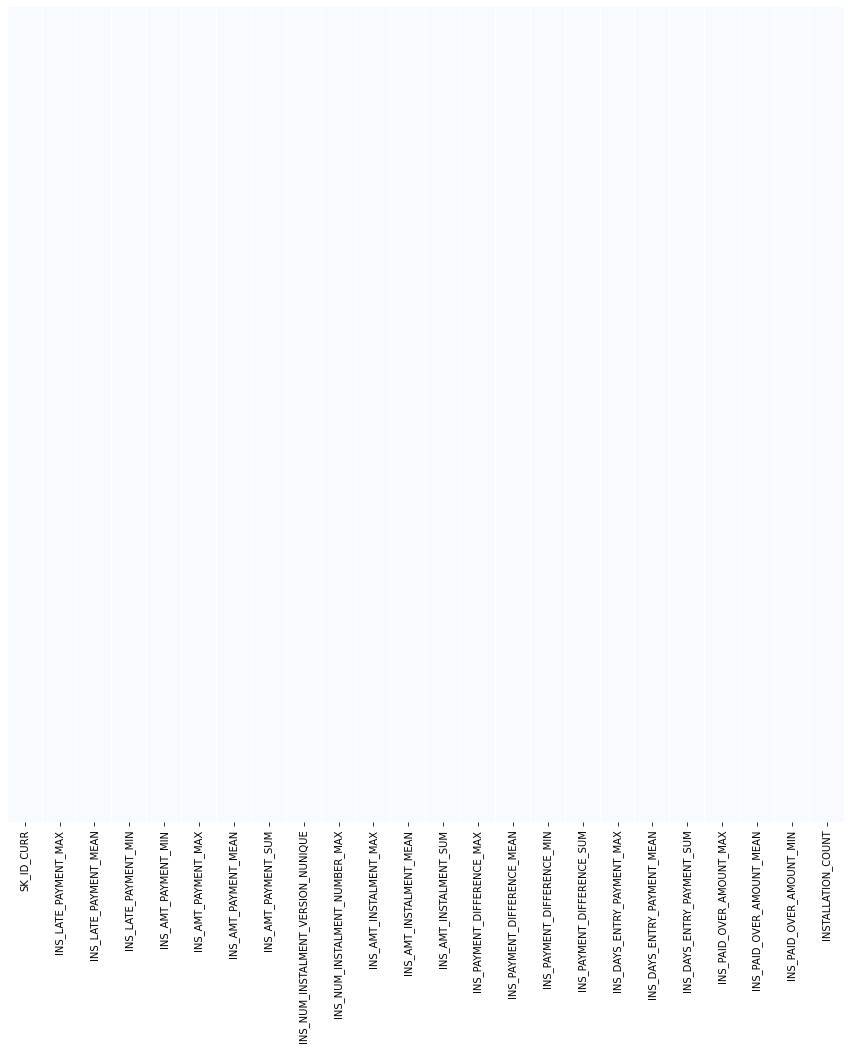

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_installment_payments_book.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
missing_data = qtd_missing_data(df_installment_payments_book)
print(missing_data)

{'INS_AMT_PAYMENT_MIN': 9, 'INS_AMT_PAYMENT_MAX': 9, 'INS_AMT_PAYMENT_MEAN': 9, 'INS_DAYS_ENTRY_PAYMENT_MAX': 9, 'INS_DAYS_ENTRY_PAYMENT_MEAN': 9, 'INS_PAID_OVER_AMOUNT_MAX': 9, 'INS_PAID_OVER_AMOUNT_MEAN': 9, 'INS_PAID_OVER_AMOUNT_MIN': 9}


In [ ]:
missing_perc, t = missing_percentage(df_installment_payments_book)
print(t)

+-----------------------------+-----------+
|           Feature           | % Missing |
+-----------------------------+-----------+
|     INS_AMT_PAYMENT_MIN     |  0.0027%  |
|     INS_AMT_PAYMENT_MAX     |  0.0027%  |
|     INS_AMT_PAYMENT_MEAN    |  0.0027%  |
|  INS_DAYS_ENTRY_PAYMENT_MAX |  0.0027%  |
| INS_DAYS_ENTRY_PAYMENT_MEAN |  0.0027%  |
|   INS_PAID_OVER_AMOUNT_MAX  |  0.0027%  |
|  INS_PAID_OVER_AMOUNT_MEAN  |  0.0027%  |
|   INS_PAID_OVER_AMOUNT_MIN  |  0.0027%  |
+-----------------------------+-----------+


In [ ]:
df_installment_payments_book = missing_treatment(df_installment_payments_book,missing_perc,40)

INS_AMT_PAYMENT_MIN filled with mean.
INS_AMT_PAYMENT_MAX filled with mean.
INS_AMT_PAYMENT_MEAN filled with mean.
INS_DAYS_ENTRY_PAYMENT_MAX filled with mean.
INS_DAYS_ENTRY_PAYMENT_MEAN filled with mean.
INS_PAID_OVER_AMOUNT_MAX filled with mean.
INS_PAID_OVER_AMOUNT_MEAN filled with mean.
INS_PAID_OVER_AMOUNT_MIN filled with mean.


In [ ]:
missing_perc, t = missing_percentage(df_installment_payments_book)
print(t)

+---------+-----------+
| Feature | % Missing |
+---------+-----------+
+---------+-----------+


####Drop de Colunas com Valores únicos

In [ ]:
drop_list = []
for i in df_installment_payments_book.columns.tolist():
  if len(df_installment_payments_book[i].unique()) == 1:
    drop_list.append(i)
print(drop_list)

['INS_PAYMENT_DIFFERENCE_MAX', 'INS_PAYMENT_DIFFERENCE_MEAN', 'INS_PAYMENT_DIFFERENCE_MIN', 'INS_PAYMENT_DIFFERENCE_SUM', 'INS_PAID_OVER_AMOUNT_MAX']


In [ ]:
print('Total de Colunas antes do Drop: {}'.format(df_installment_payments_book.shape[1]))
for i in drop_list:
  df_installment_payments_book.drop(i, axis = 1, inplace = True)
print('Total de Colunas depois do Drop: {}'.format(df_installment_payments_book.shape[1]))

Total de Colunas antes do Drop: 24
Total de Colunas depois do Drop: 19


###Normalização e Padronização

In [ ]:
labelencoding_list, onehotencoding_list = separete_categorical(df_installment_payments_book, 5)
print(labelencoding_list)
print(onehotencoding_list)

[]
[]


####Label Encoding

In [ ]:
#Não há colunas categóricas para Label Encoding
print(labelencoding_list)

[]


#### One-Hot Encoding

In [ ]:
#Não há colunas categóricas para One-Hot Encoding
print(onehotencoding_list)

[]


####MinMax Scaler

In [ ]:
#Colunas MinMaxScaler
df_columns = df_installment_payments_book.columns.tolist()
for i in df_columns:
  if i in onehotencoding_list:
    df_columns.remove(i)
  if i in labelencoding_list:
    df_columns.remove(i)
df_columns.remove('SK_ID_CURR')
print(df_columns)

['INS_LATE_PAYMENT_MAX', 'INS_LATE_PAYMENT_MEAN', 'INS_LATE_PAYMENT_MIN', 'INS_AMT_PAYMENT_MIN', 'INS_AMT_PAYMENT_MAX', 'INS_AMT_PAYMENT_MEAN', 'INS_AMT_PAYMENT_SUM', 'INS_NUM_INSTALMENT_VERSION_NUNIQUE', 'INS_NUM_INSTALMENT_NUMBER_MAX', 'INS_AMT_INSTALMENT_MAX', 'INS_AMT_INSTALMENT_MEAN', 'INS_AMT_INSTALMENT_SUM', 'INS_DAYS_ENTRY_PAYMENT_MAX', 'INS_DAYS_ENTRY_PAYMENT_MEAN', 'INS_DAYS_ENTRY_PAYMENT_SUM', 'INS_PAID_OVER_AMOUNT_MEAN', 'INS_PAID_OVER_AMOUNT_MIN', 'INSTALLATION_COUNT']


In [ ]:
df_installment_payments_book = set_MinMaxScaler(df_installment_payments_book, df_columns)
df_installment_payments_book.head(5)

SK_ID_CURR  INS_LATE_PAYMENT_MAX  INS_LATE_PAYMENT_MEAN  \
0      100001                   1.0               0.522449   
1      100002                   1.0               1.000000   
2      100003                   1.0               1.000000   
3      100004                   1.0               1.000000   
4      100005                   1.0               0.876190   

   INS_LATE_PAYMENT_MIN  INS_AMT_PAYMENT_MIN  INS_AMT_PAYMENT_MAX  \
0                   0.0             0.221537             0.055072   
1                   1.0             0.518757             0.168068   
2                   1.0             0.373600             1.000000   
3                   1.0             0.300387             0.033471   
4                   0.0             0.269881             0.055890   

   INS_AMT_PAYMENT_MEAN  INS_AMT_PAYMENT_SUM  \
0              0.137695             0.021406   
1              0.270458             0.114119   
2              1.000000             0.841176   
3              0.166031             0.011062   
4              0.146003             0.029182   

   INS_NUM_INSTALMENT_VERSION_NUNIQUE  INS_NUM_INSTALMENT_NUMBER_MAX  \
0                                 0.2                       0.068182   
1                                 0.2                       0.409091   
2                                 0.2                       0.250000   
3                                 0.2                       0.045455   
4                                 0.2                       0.181818   

   INS_AMT_INSTALMENT_MAX  INS_AMT_INSTALMENT_MEAN  INS_AMT_INSTALMENT_SUM  \
0                0.055964                 0.139238                0.021242   
1                0.170787                 0.273484                0.113244   
2                1.000000                 1.000000                0.834722   
3                0.034013                 0.167890                0.010977   
4                0.056795                 0.147639                0.028958   

   INS_DAYS_ENTRY_PAYMENT_MAX  INS_DAYS_ENTRY_PAYMENT_MEAN  \
0                    0.000000                     0.164985   
1                    0.948248                     0.881011   
2                    0.414555                     0.473784   
3                    0.217251                     0.711191   
4                    0.494340                     0.769067   

   INS_DAYS_ENTRY_PAYMENT_SUM  INS_PAID_OVER_AMOUNT_MEAN  \
0                    0.865653                      0.625   
1                    0.947642                      0.625   
2                    0.697391                      0.625   
3                    0.980036                      0.625   
4                    0.952013                      0.625   

   INS_PAID_OVER_AMOUNT_MIN  INSTALLATION_COUNT  
0                     0.625            0.055300  
1                     0.625            0.165899  
2                     0.625            0.221198  
3                     0.625            0.018433  
4                     0.625            0.073733

### Salvando no Disco

In [ ]:
df_installment_payments_book.to_csv(db_dir + '/BasesTratadas/Stage/installments_payments_book.csv', index = False)

In [ ]:
del df_installment_payments_book
gc.collect()

262

##**TABELA:** credit_card_balance.csv

In [ ]:
df_credit_card_balance_book = pd.read_csv(db_dir + '/BasesTratadas/Books/credit_card_balance_book.csv')
df_credit_card_balance_book.head(3)

SK_ID_CURR  CR_MONTHS_BALANCE_MAX  CR_MONTHS_BALANCE_MEAN  \
0      100006                     -1                    -3.5   
1      100011                     -2                   -38.5   
2      100013                     -1                   -48.5   

   CR_MONTHS_BALANCE_SUM  CR_MONTHS_BALANCE_VAR  CR_AMT_BALANCE_MAX  \
0                  -21.0                    3.5                0.00   
1                -2849.0                  462.5           189000.00   
2                -4656.0                  776.0           161420.22   

   CR_AMT_BALANCE_MEAN  CR_AMT_BALANCE_SUM  CR_AMT_BALANCE_VAR  \
0                 0.00                 0.0        0.000000e+00   
1             54482.11           4031676.2        4.641320e+09   
2             18159.92           1743352.2        1.869473e+09   

   CR_AMT_CREDIT_LIMIT_ACTUAL_MAX  CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN  \
0                          270000                    270000.000000   
1                          180000                    164189.189189   
2                          157500                    131718.750000   

   CR_AMT_CREDIT_LIMIT_ACTUAL_SUM  CR_AMT_CREDIT_LIMIT_ACTUAL_VAR  \
0                         1620000                    0.000000e+00   
1                        12150000                    1.189060e+09   
2                        12645000                    2.259252e+09   

   CR_AMT_DRAWINGS_ATM_CURRENT_MAX  CR_AMT_DRAWINGS_ATM_CURRENT_MEAN  \
0                              NaN                               NaN   
1                         180000.0                         2432.4324   
2                         157500.0                         6350.0000   

   CR_AMT_DRAWINGS_ATM_CURRENT_SUM  CR_AMT_DRAWINGS_ATM_CURRENT_VAR  \
0                              0.0                              NaN   
1                         180000.0                      437837820.0   
2                         571500.0                      824968800.0   

   CR_AMT_DRAWINGS_CURRENT_MAX  CR_AMT_DRAWINGS_CURRENT_MEAN  \
0                          0.0                        0.0000   
1                     180000.0                     2432.4324   
2                     157500.0                     5953.1250   

   CR_AMT_DRAWINGS_CURRENT_SUM  CR_AMT_DRAWINGS_CURRENT_VAR  \
0                          0.0                          0.0   
1                     180000.0                  437837820.0   
2                     571500.0                  775253060.0   

   CR_AMT_DRAWINGS_OTHER_CURRENT_MAX  CR_AMT_DRAWINGS_OTHER_CURRENT_MEAN  \
0                                NaN                                 NaN   
1                                0.0                                 0.0   
2                                0.0                                 0.0   

   CR_AMT_DRAWINGS_OTHER_CURRENT_SUM  CR_AMT_DRAWINGS_OTHER_CURRENT_VAR  \
0                                0.0                                NaN   
1                                0.0                                0.0   
2                                0.0                                0.0   

   CR_AMT_DRAWINGS_POS_CURRENT_MAX  CR_AMT_DRAWINGS_POS_CURRENT_MEAN  \
0                              NaN                               NaN   
1                              0.0                               0.0   
2                              0.0                               0.0   

   CR_AMT_DRAWINGS_POS_CURRENT_SUM  CR_AMT_DRAWINGS_POS_CURRENT_VAR  \
0                              0.0                              NaN   
1                              0.0                              0.0   
2                              0.0                              0.0   

   CR_AMT_INST_MIN_REGULARITY_MAX  CR_AMT_INST_MIN_REGULARITY_MEAN  \
0                             0.0                           0.0000   
1                          9000.0                        3956.2220   
2                          7875.0                        1454.5396   

   CR_AMT_INST_MIN_REGULARITY_SUM  CR_AMT_INST_MIN_REGULARITY_VAR  \
0                       

###Tratamento de Outliers

In [ ]:
categ, n_categ = split_categoricals(df_credit_card_balance_book, 10)
print(categ)
print(n_categ)

{'CR_MONTHS_BALANCE_MAX': 7, 'CR_NAME_CONTRACT_STATUS_Active_MAX': 2, 'CR_NAME_CONTRACT_STATUS_Approved_MAX': 2, 'CR_NAME_CONTRACT_STATUS_Approved_MEAN': 6, 'CR_NAME_CONTRACT_STATUS_Approved_SUM': 2, 'CR_NAME_CONTRACT_STATUS_Approved_VAR': 7, 'CR_NAME_CONTRACT_STATUS_Completed_MAX': 2, 'CR_NAME_CONTRACT_STATUS_Demand_MAX': 2, 'CR_NAME_CONTRACT_STATUS_Refused_MAX': 2, 'CR_NAME_CONTRACT_STATUS_Refused_SUM': 2, 'CR_NAME_CONTRACT_STATUS_Sent proposal_MAX': 2, 'CR_NAME_CONTRACT_STATUS_Sent proposal_SUM': 2, 'CR_NAME_CONTRACT_STATUS_Signed_MAX': 2, 'CR_LATE_PAYMENT_MAX': 2}
{'SK_ID_CURR': 103558, 'CR_MONTHS_BALANCE_MEAN': 570, 'CR_MONTHS_BALANCE_SUM': 796, 'CR_MONTHS_BALANCE_VAR': 1294, 'CR_AMT_BALANCE_MAX': 66374, 'CR_AMT_BALANCE_MEAN': 70032, 'CR_AMT_BALANCE_SUM': 69060, 'CR_AMT_BALANCE_VAR': 69917, 'CR_AMT_CREDIT_LIMIT_ACTUAL_MAX': 54, 'CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN': 13036, 'CR_AMT_CREDIT_LIMIT_ACTUAL_SUM': 2843, 'CR_AMT_CREDIT_LIMIT_ACTUAL_VAR': 28746, 'CR_AMT_DRAWINGS_ATM_CURRENT_MAX

In [ ]:
lista_prontos = ['SK_ID_CURR']
aplicar_floor_cap = get_outlier_applicable_list(df_credit_card_balance_book, n_categ, lista_prontos)
print(aplicar_floor_cap)
print(len(aplicar_floor_cap))

['CR_MONTHS_BALANCE_SUM', 'CR_AMT_BALANCE_MAX', 'CR_AMT_BALANCE_MEAN', 'CR_AMT_BALANCE_SUM', 'CR_AMT_BALANCE_VAR', 'CR_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN', 'CR_AMT_CREDIT_LIMIT_ACTUAL_SUM', 'CR_AMT_CREDIT_LIMIT_ACTUAL_VAR', 'CR_AMT_DRAWINGS_ATM_CURRENT_MAX', 'CR_AMT_DRAWINGS_ATM_CURRENT_MEAN', 'CR_AMT_DRAWINGS_ATM_CURRENT_SUM', 'CR_AMT_DRAWINGS_ATM_CURRENT_VAR', 'CR_AMT_DRAWINGS_CURRENT_MAX', 'CR_AMT_DRAWINGS_CURRENT_MEAN', 'CR_AMT_DRAWINGS_CURRENT_SUM', 'CR_AMT_DRAWINGS_CURRENT_VAR', 'CR_AMT_DRAWINGS_OTHER_CURRENT_MAX', 'CR_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CR_AMT_DRAWINGS_OTHER_CURRENT_SUM', 'CR_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CR_AMT_DRAWINGS_POS_CURRENT_MAX', 'CR_AMT_DRAWINGS_POS_CURRENT_MEAN', 'CR_AMT_DRAWINGS_POS_CURRENT_SUM', 'CR_AMT_DRAWINGS_POS_CURRENT_VAR', 'CR_AMT_INST_MIN_REGULARITY_MAX', 'CR_AMT_INST_MIN_REGULARITY_MEAN', 'CR_AMT_INST_MIN_REGULARITY_SUM', 'CR_AMT_INST_MIN_REGULARITY_VAR', 'CR_AMT_PAYMENT_CURRENT_MAX', 'CR_AMT_PAYMENT_CURRENT_M

In [ ]:
df_credit_card_balance_book, update_outlier  = update_df_outliers(df_credit_card_balance_book, aplicar_floor_cap)

Quantile 25: -2850.0
Quantile 75: -65.0
Limite Superior: 4112.5
+-----------------------+---------+
| CR_MONTHS_BALANCE_SUM |  Valor  |
+-----------------------+---------+
|     Total Outliers    |    2    |
|  Maior valor outlier  | -8224.0 |
|  Menor valor outlier  | -9312.0 |
|       % ouliers       |  0.0 %  |
+-----------------------+---------+ 
 +-----------------------+-------+
| CR_MONTHS_BALANCE_SUM | Valor |
+-----------------------+-------+
|     Total Outliers    |   0   |
|  Maior valor outlier  |  nan  |
|  Menor valor outlier  |  nan  |
|       % ouliers       | 0.0 % |
+-----------------------+-------+ 
Quantile 25: 0.0
Quantile 75: 194612.54499999998
Limite Superior: 486531.3625
+---------------------+-----------+
|  CR_AMT_BALANCE_MAX |   Valor   |
+---------------------+-----------+
|    Total Outliers   |    3909   |
| Maior valor outlier | 1505902.1 |
| Menor valor outlier |  486537.3 |
|      % ouliers      |   3.77 %  |
+---------------------+-----------+ 
 +----

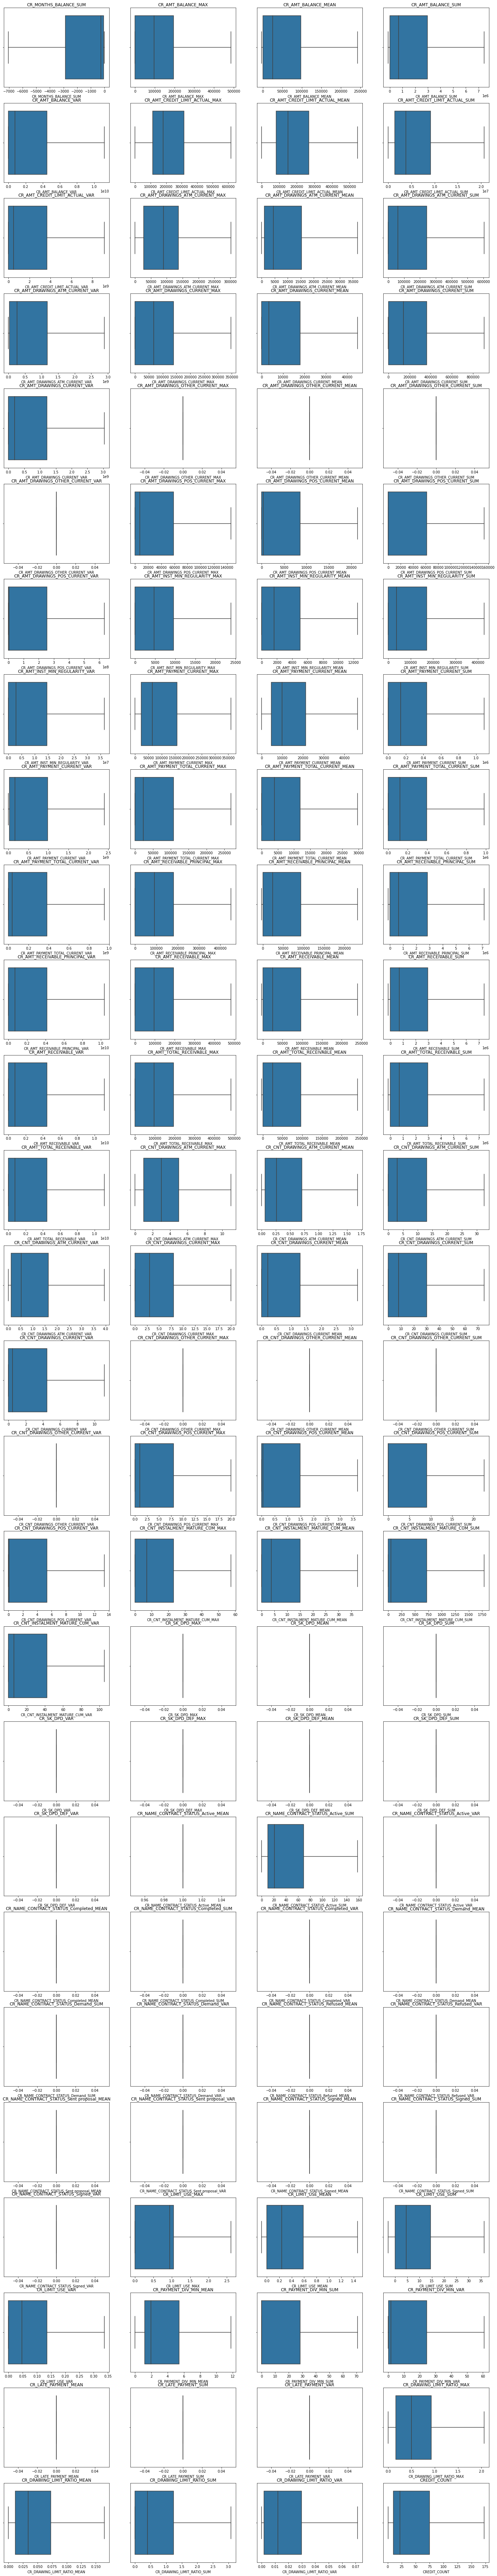

In [ ]:
plot_boxplot_applicable_outlierlimit(df_credit_card_balance_book, update_outlier, 4)

In [ ]:
df_credit_card_balance_book.replace([np.inf, -np.inf], np.nan, inplace=True)

### Tratamento Dados Faltantes

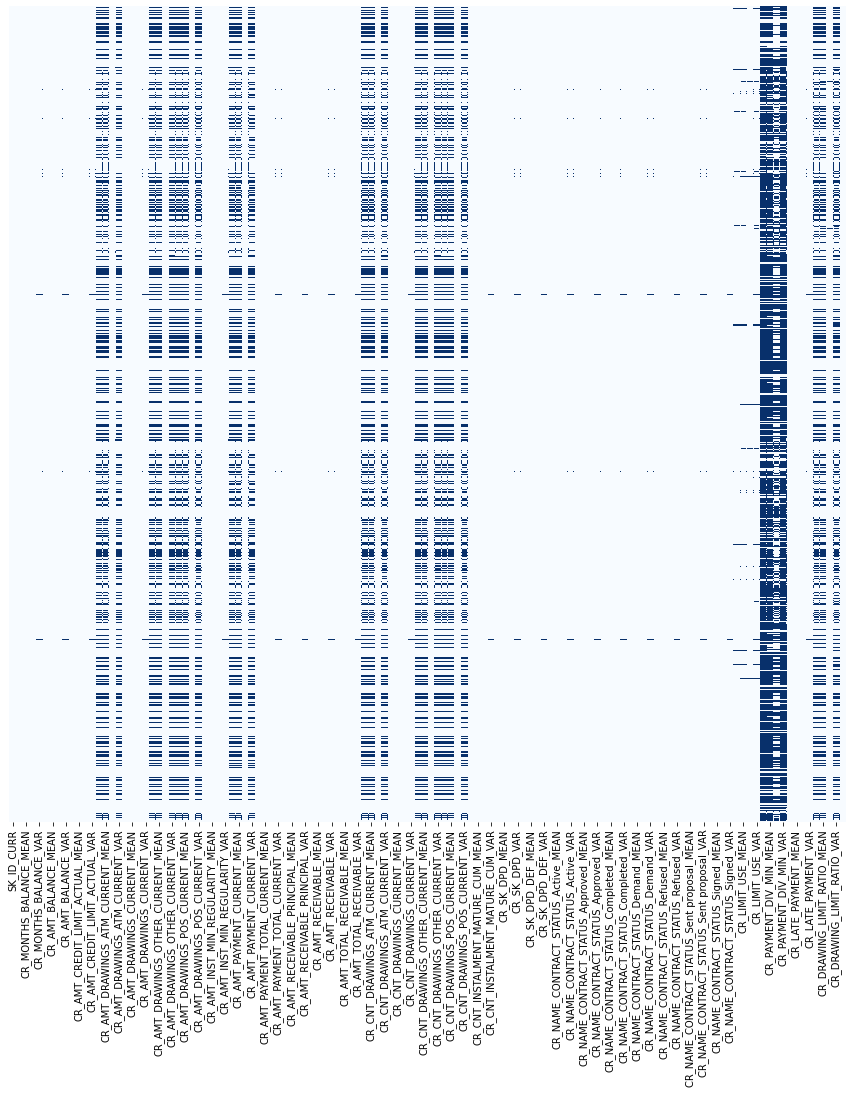

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df_credit_card_balance_book.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [ ]:
missing_data = qtd_missing_data(df_credit_card_balance_book)
print(missing_data)

{'CR_MONTHS_BALANCE_VAR': 692, 'CR_AMT_BALANCE_VAR': 692, 'CR_AMT_CREDIT_LIMIT_ACTUAL_VAR': 692, 'CR_AMT_DRAWINGS_ATM_CURRENT_MAX': 31364, 'CR_AMT_DRAWINGS_ATM_CURRENT_MEAN': 31364, 'CR_AMT_DRAWINGS_ATM_CURRENT_VAR': 31866, 'CR_AMT_DRAWINGS_CURRENT_VAR': 692, 'CR_AMT_DRAWINGS_OTHER_CURRENT_MAX': 31364, 'CR_AMT_DRAWINGS_OTHER_CURRENT_MEAN': 31364, 'CR_AMT_DRAWINGS_OTHER_CURRENT_VAR': 31866, 'CR_AMT_DRAWINGS_POS_CURRENT_MAX': 31364, 'CR_AMT_DRAWINGS_POS_CURRENT_MEAN': 31364, 'CR_AMT_DRAWINGS_POS_CURRENT_VAR': 31866, 'CR_AMT_INST_MIN_REGULARITY_VAR': 692, 'CR_AMT_PAYMENT_CURRENT_MAX': 31438, 'CR_AMT_PAYMENT_CURRENT_MEAN': 31438, 'CR_AMT_PAYMENT_CURRENT_VAR': 31956, 'CR_AMT_PAYMENT_TOTAL_CURRENT_VAR': 692, 'CR_AMT_RECEIVABLE_PRINCIPAL_VAR': 692, 'CR_AMT_RECEIVABLE_VAR': 692, 'CR_AMT_TOTAL_RECEIVABLE_VAR': 692, 'CR_CNT_DRAWINGS_ATM_CURRENT_MAX': 31364, 'CR_CNT_DRAWINGS_ATM_CURRENT_MEAN': 31364, 'CR_CNT_DRAWINGS_ATM_CURRENT_VAR': 31866, 'CR_CNT_DRAWINGS_CURRENT_VAR': 692, 'CR_CNT_DRAWINGS_OT

In [ ]:
missing_perc, t = missing_percentage(df_credit_card_balance_book)
print(t)

+-------------------------------------------+-----------+
|                  Feature                  | % Missing |
+-------------------------------------------+-----------+
|         CR_DRAWING_LIMIT_RATIO_SUM        |  0.1207%  |
|              CR_LIMIT_USE_SUM             |  0.6431%  |
|           CR_MONTHS_BALANCE_VAR           |  0.6682%  |
|             CR_AMT_BALANCE_VAR            |  0.6682%  |
|       CR_AMT_CREDIT_LIMIT_ACTUAL_VAR      |  0.6682%  |
|        CR_AMT_DRAWINGS_CURRENT_VAR        |  0.6682%  |
|       CR_AMT_INST_MIN_REGULARITY_VAR      |  0.6682%  |
|      CR_AMT_PAYMENT_TOTAL_CURRENT_VAR     |  0.6682%  |
|      CR_AMT_RECEIVABLE_PRINCIPAL_VAR      |  0.6682%  |
|           CR_AMT_RECEIVABLE_VAR           |  0.6682%  |
|        CR_AMT_TOTAL_RECEIVABLE_VAR        |  0.6682%  |
|        CR_CNT_DRAWINGS_CURRENT_VAR        |  0.6682%  |
|      CR_CNT_INSTALMENT_MATURE_CUM_VAR     |  0.6682%  |
|               CR_SK_DPD_VAR               |  0.6682%  |
|             

In [ ]:
df_credit_card_balance_book = missing_treatment(df_credit_card_balance_book,missing_perc,40)

CR_DRAWING_LIMIT_RATIO_SUM filled with mean.
CR_LIMIT_USE_SUM filled with mean.
CR_MONTHS_BALANCE_VAR filled with mean.
CR_AMT_BALANCE_VAR filled with mean.
CR_AMT_CREDIT_LIMIT_ACTUAL_VAR filled with mean.
CR_AMT_DRAWINGS_CURRENT_VAR filled with mean.
CR_AMT_INST_MIN_REGULARITY_VAR filled with mean.
CR_AMT_PAYMENT_TOTAL_CURRENT_VAR filled with mean.
CR_AMT_RECEIVABLE_PRINCIPAL_VAR filled with mean.
CR_AMT_RECEIVABLE_VAR filled with mean.
CR_AMT_TOTAL_RECEIVABLE_VAR filled with mean.
CR_CNT_DRAWINGS_CURRENT_VAR filled with mean.
CR_CNT_INSTALMENT_MATURE_CUM_VAR filled with mean.
CR_SK_DPD_VAR filled with mean.
CR_SK_DPD_DEF_VAR filled with mean.
CR_NAME_CONTRACT_STATUS_Active_VAR filled with mean.
CR_NAME_CONTRACT_STATUS_Approved_VAR filled with mean.
CR_NAME_CONTRACT_STATUS_Completed_VAR filled with mean.
CR_NAME_CONTRACT_STATUS_Demand_VAR filled with mean.
CR_NAME_CONTRACT_STATUS_Refused_VAR filled with mean.
CR_NAME_CONTRACT_STATUS_Sent proposal_VAR filled with mean.
CR_NAME_CONTRACT

In [ ]:
missing_perc, t = missing_percentage(df_credit_card_balance_book)
print(t)

+---------+-----------+
| Feature | % Missing |
+---------+-----------+
+---------+-----------+


####Drop de Colunas com Valores únicos

In [ ]:
drop_list = []
for i in df_credit_card_balance_book.columns.tolist():
  if len(df_credit_card_balance_book[i].unique()) == 1:
    drop_list.append(i)
print(drop_list)

['CR_AMT_DRAWINGS_OTHER_CURRENT_MAX', 'CR_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CR_AMT_DRAWINGS_OTHER_CURRENT_SUM', 'CR_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CR_CNT_DRAWINGS_OTHER_CURRENT_MAX', 'CR_CNT_DRAWINGS_OTHER_CURRENT_MEAN', 'CR_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'CR_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CR_SK_DPD_MAX', 'CR_SK_DPD_MEAN', 'CR_SK_DPD_SUM', 'CR_SK_DPD_VAR', 'CR_SK_DPD_DEF_MAX', 'CR_SK_DPD_DEF_MEAN', 'CR_SK_DPD_DEF_SUM', 'CR_SK_DPD_DEF_VAR', 'CR_NAME_CONTRACT_STATUS_Active_MEAN', 'CR_NAME_CONTRACT_STATUS_Active_VAR', 'CR_NAME_CONTRACT_STATUS_Completed_MEAN', 'CR_NAME_CONTRACT_STATUS_Completed_SUM', 'CR_NAME_CONTRACT_STATUS_Completed_VAR', 'CR_NAME_CONTRACT_STATUS_Demand_MEAN', 'CR_NAME_CONTRACT_STATUS_Demand_SUM', 'CR_NAME_CONTRACT_STATUS_Demand_VAR', 'CR_NAME_CONTRACT_STATUS_Refused_MEAN', 'CR_NAME_CONTRACT_STATUS_Refused_VAR', 'CR_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'CR_NAME_CONTRACT_STATUS_Sent proposal_VAR', 'CR_NAME_CONTRACT_STATUS_Signed_MEAN', 'CR_NAME_CONTRACT_STAT

In [ ]:
print('Total de Colunas antes do Drop: {}'.format(df_credit_card_balance_book.shape[1]))
for i in drop_list:
  df_credit_card_balance_book.drop(i, axis = 1, inplace = True)
print('Total de Colunas depois do Drop: {}'.format(df_credit_card_balance_book.shape[1]))

Total de Colunas antes do Drop: 122
Total de Colunas depois do Drop: 88


###Normalização e Padronização

In [ ]:
labelencoding_list, onehotencoding_list = separete_categorical(df_credit_card_balance_book, 5)
print(labelencoding_list)
print(onehotencoding_list)

[]
[]


####Label Encoding

In [ ]:
#Não há colunas categóricas para Label Encoding
print(labelencoding_list)

[]


####One-Hot Encoding

In [ ]:
#Não há colunas categóricas para One-Hot
print(onehotencoding_list)

[]


####MinMax Scaler

In [ ]:
#Colunas MinMaxScaler
df_columns = df_credit_card_balance_book.columns.tolist()
for i in df_columns:
  if i in onehotencoding_list:
    df_columns.remove(i)
  if i in labelencoding_list:
    df_columns.remove(i)
df_columns.remove('SK_ID_CURR')
print(df_columns)

['CR_MONTHS_BALANCE_MAX', 'CR_MONTHS_BALANCE_MEAN', 'CR_MONTHS_BALANCE_SUM', 'CR_MONTHS_BALANCE_VAR', 'CR_AMT_BALANCE_MAX', 'CR_AMT_BALANCE_MEAN', 'CR_AMT_BALANCE_SUM', 'CR_AMT_BALANCE_VAR', 'CR_AMT_CREDIT_LIMIT_ACTUAL_MAX', 'CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN', 'CR_AMT_CREDIT_LIMIT_ACTUAL_SUM', 'CR_AMT_CREDIT_LIMIT_ACTUAL_VAR', 'CR_AMT_DRAWINGS_ATM_CURRENT_MAX', 'CR_AMT_DRAWINGS_ATM_CURRENT_MEAN', 'CR_AMT_DRAWINGS_ATM_CURRENT_SUM', 'CR_AMT_DRAWINGS_ATM_CURRENT_VAR', 'CR_AMT_DRAWINGS_CURRENT_MAX', 'CR_AMT_DRAWINGS_CURRENT_MEAN', 'CR_AMT_DRAWINGS_CURRENT_SUM', 'CR_AMT_DRAWINGS_CURRENT_VAR', 'CR_AMT_DRAWINGS_POS_CURRENT_MAX', 'CR_AMT_DRAWINGS_POS_CURRENT_MEAN', 'CR_AMT_DRAWINGS_POS_CURRENT_SUM', 'CR_AMT_DRAWINGS_POS_CURRENT_VAR', 'CR_AMT_INST_MIN_REGULARITY_MAX', 'CR_AMT_INST_MIN_REGULARITY_MEAN', 'CR_AMT_INST_MIN_REGULARITY_SUM', 'CR_AMT_INST_MIN_REGULARITY_VAR', 'CR_AMT_PAYMENT_CURRENT_MAX', 'CR_AMT_PAYMENT_CURRENT_MEAN', 'CR_AMT_PAYMENT_CURRENT_SUM', 'CR_AMT_PAYMENT_CURRENT_VAR', 'CR_AMT

In [ ]:
df_credit_card_balance_book = set_MinMaxScaler(df_credit_card_balance_book, df_columns)
df_credit_card_balance_book.head(5)

SK_ID_CURR  CR_MONTHS_BALANCE_MAX  CR_MONTHS_BALANCE_MEAN  \
0      100006               1.000000                0.949166   
1      100011               0.909091                0.237491   
2      100013               1.000000                0.034156   
3      100021               0.909091                0.816998   
4      100023               0.727273                0.867832   

   CR_MONTHS_BALANCE_SUM  CR_MONTHS_BALANCE_VAR  CR_AMT_BALANCE_MAX  \
0               0.997154               0.003409            0.000000   
1               0.594677               0.524987            0.388464   
2               0.337508               0.881228            0.331778   
3               0.975948               0.028408            0.000000   
4               0.991603               0.006250            0.000000   

   CR_AMT_BALANCE_MEAN  CR_AMT_BALANCE_SUM  CR_AMT_BALANCE_VAR  \
0             0.011939            0.016633            0.000000   
1             0.233931            0.548849            0.414340   
2             0.085933            0.246771            0.166891   
3             0.011939            0.016633            0.000000   
4             0.011939            0.016633            0.000000   

   CR_AMT_CREDIT_LIMIT_ACTUAL_MAX  CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN  \
0                        0.436364                         0.495413   
1                        0.290909                         0.301265   
2                        0.254545                         0.241686   
3                        1.000000                         1.000000   
4                        0.363636                         0.247706   

   CR_AMT_CREDIT_LIMIT_ACTUAL_SUM  CR_AMT_CREDIT_LIMIT_ACTUAL_VAR  \
0                        0.078355                        0.000000   
1                        0.587659                        0.129931   
2                        0.611601                        0.246874   
3                        0.555011                        0.000000   
4                        0.052236                        1.000000   

   CR_AMT_DRAWINGS_ATM_CURRENT_MAX  CR_AMT_DRAWINGS_ATM_CURRENT_MEAN  \
0                         0.325612                          0.268156   
1                         0.594796                          0.066088   
2                         0.520446                          0.172525   
3                         0.325612                          0.268156   
4                         0.325612                          0.268156   

   CR_AMT_DRAWINGS_ATM_CURRENT_SUM  CR_AMT_DRAWINGS_ATM_CURRENT_VAR  \
0                         0.000000                         0.268340   
1                         0.297952                         0.151079   
2                         0.945996                         0.284660   
3                         0.000000                         0.268340   
4                         0.000000                         0.268340   

   CR_AMT_DRAWINGS_CURRENT_MAX  CR_AMT_DRAWINGS_CURRENT_MEAN  \
0                     0.000000                      0.000392   
1                     0.517799                      0.054680   
2                     0.453074                      0.133256   
3                     0.000000                      0.000392   
4                     0.000000                      0.000392   

   CR_AMT_DRAWINGS_CURRENT_SUM  CR_AMT_DRAWINGS_CURRENT_VAR  \
0                     0.001863                     0.000000   
1                     0.200605                     0.144068   
2                     0.632869                     0.255093   
3                     0.001863                     0.000000   
4                     0.001863                     0.000000   

   CR_AMT_DRAWINGS_POS_CURRENT_MAX  CR_AMT_DRAWINGS_POS_CURRENT_MEAN  \
0                         0.242503                          0.243335   
1                         0.000000                          0.000000   
2                         0.000000                          0.000000   
3                         0.242503            

### Salvando no Disco

In [ ]:
df_credit_card_balance_book.to_csv(db_dir + '/BasesTratadas/Stage/credit_card_balance_book.csv', index = False)

In [ ]:
del df_credit_card_balance_book
gc.collect()

250129

#**Modelagem**

##Importando Bibliotecas

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb

## Definição da ABT

###application_train Stage

In [ ]:
df_app_train = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Stage/application_train.csv'))
df_app_train.head(5)

Memory usage of dataframe is 464.53 MB
Memory usage after optimization is: 99.12 MB
Decreased by 78.7%


SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0          0.5             0   
1      100003       0                   0          0.0             0   
2      100004       0                   1          0.5             1   
3      100006       0                   0          0.0             0   
4      100007       0                   0          0.5             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0              1.0           0.0          0.566895    0.230103     0.384277   
1              0.0           0.0          0.783691    0.794434     0.567383   
2              1.0           0.0          0.134155    0.057251     0.085449   
3              1.0           0.0          0.350586    0.170288     0.467041   
4              1.0           0.0          0.307373    0.297852     0.336914   

   AMT_GOODS_PRICE  NAME_EDUCATION_TYPE  REGION_POPULATION_RELATIVE  \
0         0.238770                    4                    0.328613   
1         0.837402                    1                    0.057709   
2         0.072693                    4                    0.172852   
3         0.197266                    4                    0.137207   
4         0.363281                    4                    0.503418   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0    0.888672       0.589844           0.767578         0.705566         1.0   
1    0.477051       0.534180           0.924316         0.959473         1.0   
2    0.348633       0.631348           0.728516         0.648438         1.0   
3    0.350830       0.346680           0.373291         0.661621         1.0   
4    0.298584       0.346924           0.725098         0.519531         1.0   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0             1.0              0.0               1.0         1.0         0.0   
1             1.0              0.0               1.0         1.0         0.0   
2             1.0              1.0               1.0         1.0         0.0   
3             1.0              0.0               1.0         0.0         0.0   
4             1.0              0.0               1.0         0.0         0.0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0         0.000000                   0.5                          0.5   
1         0.285645                   0.0                          0.0   
2         0.000000                   0.5                          0.5   
3         0.285645                   0.5                          0.5   
4         0.000000                   0.5                          0.5   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                   0.3750                         0.0   
1                   0.4375                         0.0   
2                   0.3125                         0.0   
3                   0.8125                         0.0   
4                   0.4375                         0.0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     1.0                      1.0   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0      0.307617  

In [ ]:
X_app_train = df_app_train.drop(['SK_ID_CURR','TARGET'], axis = 1)
Y_app_train = df_app_train['TARGET']

In [ ]:
X_app_train_f, X_app_train_cv, Y_app_train_f, Y_app_train_cv = train_test_split(X_app_train, Y_app_train, test_size = 0.25, stratify = Y_app_train)
print(X_app_train_f.shape, Y_app_train_f.shape)
print(X_app_train_cv.shape, Y_app_train_cv.shape)

(230633, 196) (230633,)
(76878, 196) (76878,)


In [ ]:
model_0 = RandomForestClassifier()
model_0.fit(X_app_train_f, Y_app_train_f)

RandomForestClassifier()

Text(0.5, 0, 'Random Forest Feature Importance')

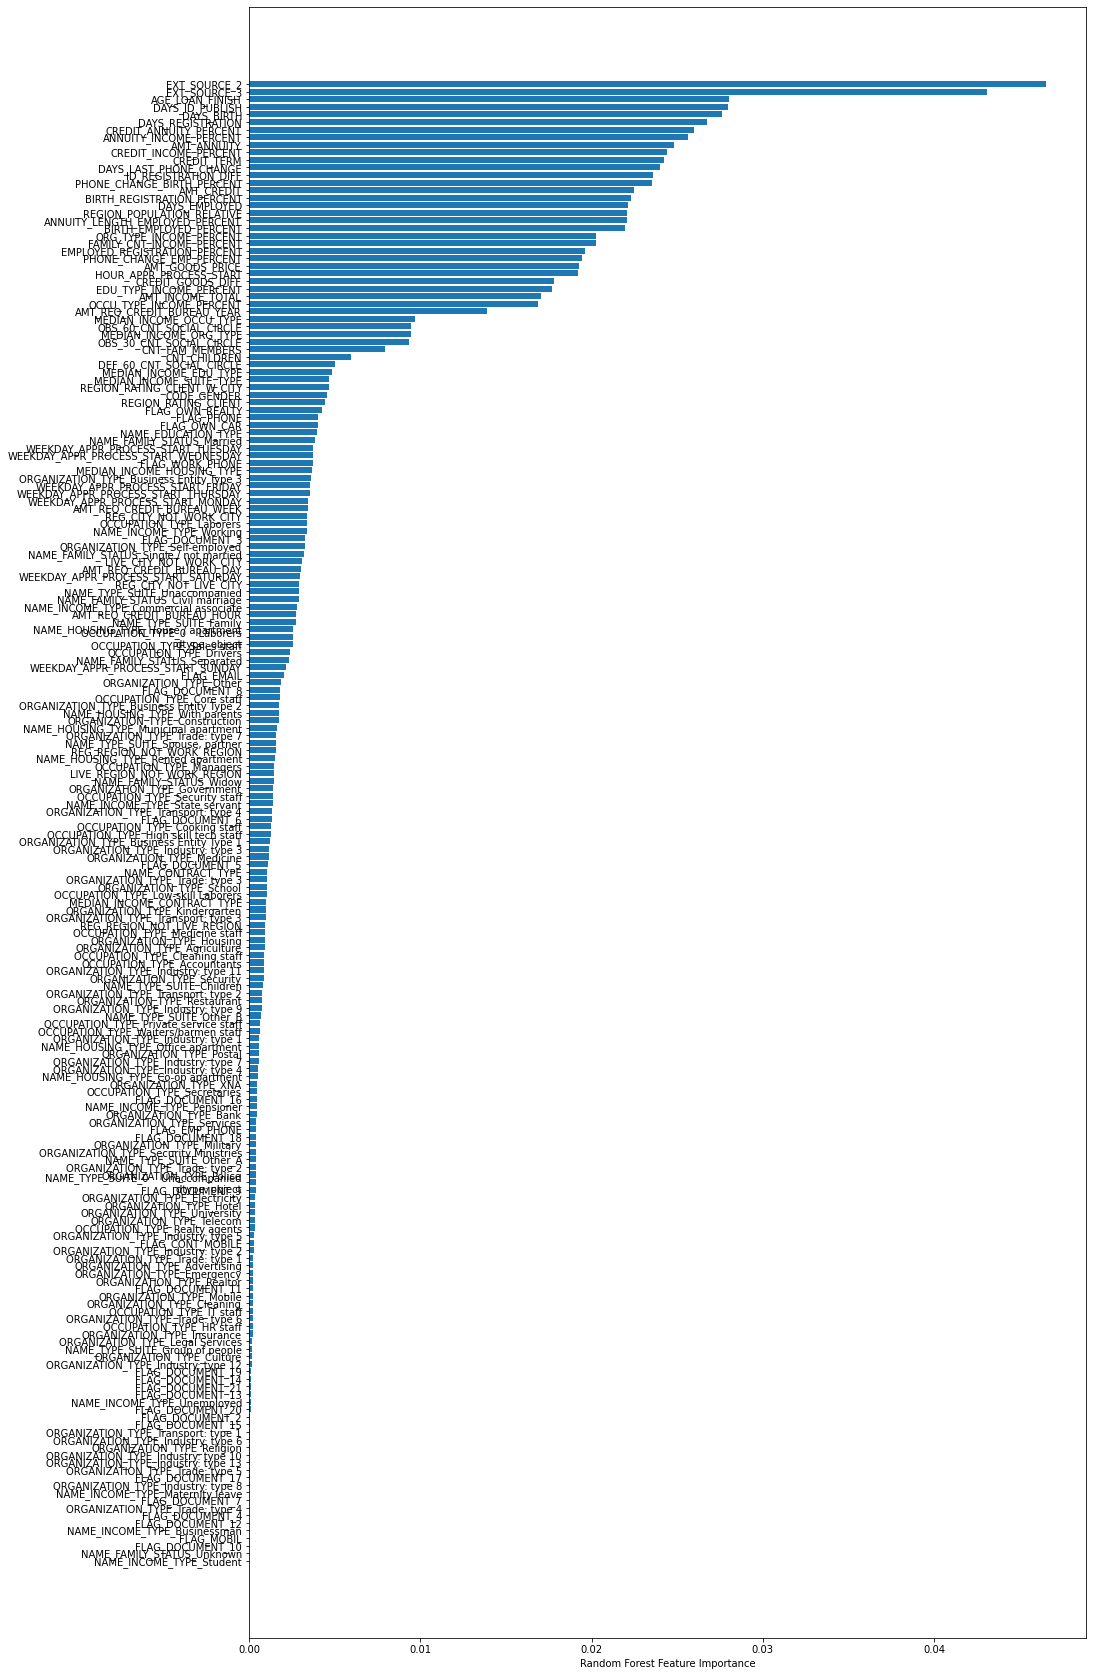

In [ ]:
sorted_idx = model_0.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(15,30))
plt.barh(X_app_train_f.columns[sorted_idx], model_0.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
rf_classification = pd.DataFrame(X_app_train_f.columns[sorted_idx], model_0.feature_importances_[sorted_idx])
df_important = rf_classification.tail(40)

<BarContainer object of 40 artists>

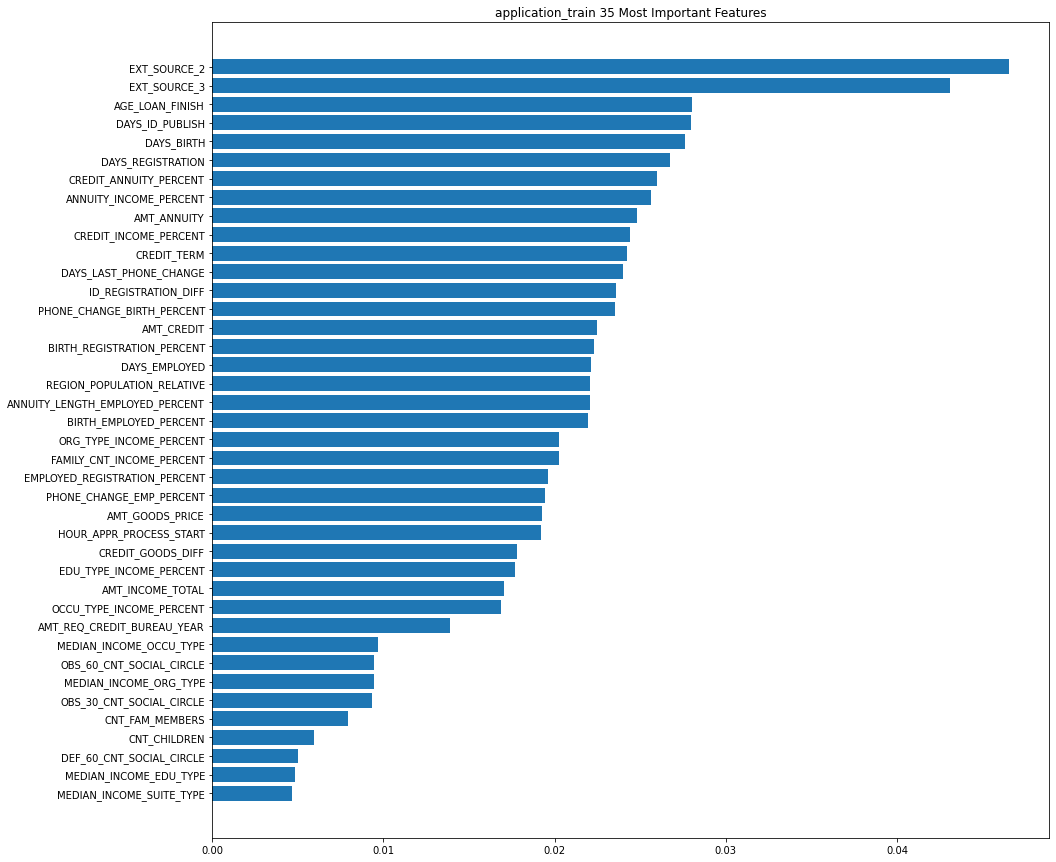

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train 40 Most Important Features')
plt.barh(df_important[0], df_important.index.values)

In [ ]:
most_important = df_important[0].tolist()
most_important.insert(0, 'SK_ID_CURR')
most_important.insert(1,'TARGET')
print(most_important)

['SK_ID_CURR', 'TARGET', 'MEDIAN_INCOME_SUITE_TYPE', 'MEDIAN_INCOME_EDU_TYPE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'OBS_30_CNT_SOCIAL_CIRCLE', 'MEDIAN_INCOME_ORG_TYPE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'MEDIAN_INCOME_OCCU_TYPE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OCCU_TYPE_INCOME_PERCENT', 'AMT_INCOME_TOTAL', 'EDU_TYPE_INCOME_PERCENT', 'CREDIT_GOODS_DIFF', 'HOUR_APPR_PROCESS_START', 'AMT_GOODS_PRICE', 'PHONE_CHANGE_EMP_PERCENT', 'EMPLOYED_REGISTRATION_PERCENT', 'FAMILY_CNT_INCOME_PERCENT', 'ORG_TYPE_INCOME_PERCENT', 'BIRTH_EMPLOYED_PERCENT', 'ANNUITY_LENGTH_EMPLOYED_PERCENT', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'BIRTH_REGISTRATION_PERCENT', 'AMT_CREDIT', 'PHONE_CHANGE_BIRTH_PERCENT', 'ID_REGISTRATION_DIFF', 'DAYS_LAST_PHONE_CHANGE', 'CREDIT_TERM', 'CREDIT_INCOME_PERCENT', 'AMT_ANNUITY', 'ANNUITY_INCOME_PERCENT', 'CREDIT_ANNUITY_PERCENT', 'DAYS_REGISTRATION', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'AGE_LOAN_FINISH', 'EXT_SOURCE_3', 'EXT_SOURCE_2']


In [ ]:
abt_final = df_app_train[most_important]
abt_final.head(10)

SK_ID_CURR  TARGET  MEDIAN_INCOME_SUITE_TYPE  MEDIAN_INCOME_EDU_TYPE  \
0      100002       1                  1.000000                0.227295   
1      100003       0                  0.666504                0.681641   
2      100004       0                  1.000000                0.227295   
3      100006       0                  1.000000                0.227295   
4      100007       0                  1.000000                0.227295   
5      100008       0                  0.333252                0.227295   
6      100009       0                  1.000000                0.681641   
7      100010       0                  1.000000                0.681641   
8      100011       0                  0.000000                0.227295   
9      100012       0                  1.000000                0.227295   

   DEF_60_CNT_SOCIAL_CIRCLE  CNT_CHILDREN  CNT_FAM_MEMBERS  \
0                  0.083313      0.000000         0.000000   
1                  0.000000      0.000000         0.285645   
2                  0.000000      0.000000         0.000000   
3                  0.000000      0.000000         0.285645   
4                  0.000000      0.000000         0.000000   
5                  0.000000      0.000000         0.285645   
6                  0.000000      0.199951         0.571289   
7                  0.000000      0.000000         0.285645   
8                  0.000000      0.000000         0.285645   
9                  0.000000      0.000000         0.000000   

   OBS_30_CNT_SOCIAL_CIRCLE  MEDIAN_INCOME_ORG_TYPE  OBS_60_CNT_SOCIAL_CIRCLE  \
0                  0.399902                0.571289                  0.399902   
1                  0.199951                0.285645                  0.199951   
2                  0.000000                0.285645                  0.000000   
3                  0.399902                0.571289                  0.399902   
4                  0.000000                0.628418                  0.000000   
5                  0.000000                0.571289                  0.000000   
6                  0.199951                0.571289                  0.199951   
7                  0.399902                0.571289                  0.399902   
8                  0.199951                0.057129                  0.199951   
9                  0.399902                0.571289                  0.399902   

   MEDIAN_INCOME_OCCU_TYPE  AMT_REQ_CREDIT_BUREAU_YEAR  \
0                 0.399902                    0.133301   
1                 0.399902                    0.000000   
2                 0.399902                    0.000000   
3                 0.399902                    0.251709   
4                 0.399902                    0.000000   
5                 0.399902                    0.133301   
6                 0.587891                    0.266602   
7                 1.000000                    0.000000   
8                 0.421143                    0.133301   
9                 0.399902                    0.251709   

   OCCU_TYPE_INCOME_PERCENT  AMT_INCOME_TOTAL  EDU_TYPE_INCOME_PERCENT  \
0                  0.329346          0.566895                 0.297852   
1                  0.246826          0.783691                 0.297852   
2                  0.989258          0.134155                 0.894531   
3                  0.494385          0.350586                 0.447021   
4                  0.549316          0.307373                 0.496826   
5                  0.674316          0.235229                 0.609863   
6                  0.442627          0.466064                 0.470459   
7                  0.264648          1.000000                 0.223267   
8                  0.468262          0.278564                 0.536621   
9                  0.494385          0.350586                 0.447021   

   CREDIT_GOODS_DIFF  HOUR_APPR_PROCESS_START  AMT_GOODS_PRICE  \
0           0.575195                   0.3750         0.238770   
1           0.55

####Salvando no Disco

In [ ]:
abt_final.to_csv(db_dir + '/BasesTratadas/abt_final.csv', index = False)

In [ ]:
del X_app_train
del Y_app_train
del df_app_train
del X_app_train_f
del Y_app_train_f
del X_app_train_cv
del Y_app_train_cv
del rf_classification
del df_important
del abt_final
gc.collect()

5568

###abt_final + bureau_book

In [ ]:
abt_final = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/abt_final.csv'))
bureau_book = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Stage/bureau_book.csv'))

Memory usage of dataframe is 98.54 MB
Memory usage after optimization is: 24.93 MB
Decreased by 74.7%
Memory usage of dataframe is 219.32 MB
Memory usage after optimization is: 55.41 MB
Decreased by 74.7%


In [ ]:
abt_final = abt_final.merge(bureau_book, on = 'SK_ID_CURR', how = 'left', indicator = True)

In [ ]:
abt_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 136 entries, SK_ID_CURR to _merge
dtypes: category(1), float16(133), int32(1), int8(1)
memory usage: 82.1 MB


In [ ]:
for i in abt_final.columns.tolist():
  if abt_final[i].dtype == 'category':
    print(i)

_merge


In [ ]:
abt_final['_merge']

0              both
1              both
2              both
3         left_only
4              both
            ...    
307506    left_only
307507    left_only
307508         both
307509         both
307510         both
Name: _merge, Length: 307511, dtype: category
Categories (3, object): ['left_only', 'right_only', 'both']

In [ ]:
abt_final.drop('_merge', axis = 1, inplace = True)

In [ ]:
missing_perc, t = missing_percentage(abt_final)
print(t)

+---------------------------------------------------------------------+-----------+
|                               Feature                               | % Missing |
+---------------------------------------------------------------------+-----------+
|                   BUREAU_AMT_CREDIT_SUM_DEBT_mean                   |  14.3149% |
|                    BUREAU_AMT_CREDIT_SUM_DEBT_sum                   |  14.3149% |
|                       BUREAU_DAYS_CREDIT_mean                       |  14.3149% |
|                    BUREAU_DAYS_CREDIT_UPDATE_mean                   |  14.3149% |
|                    BUREAU_DAYS_CREDIT_UPDATE_min                    |  14.3149% |
|                    BUREAU_CNT_CREDIT_PROLONG_sum                    |  14.3149% |
|                    BUREAU_MONTHS_BALANCE_SIZE_sum                   |  14.3149% |
|                        BUREAU_AMT_ANNUITY_max                       |  14.3149% |
|                       BUREAU_AMT_ANNUITY_mean                       |  14.

In [ ]:
abt_final = missing_treatment(abt_final,missing_perc,60)

BUREAU_AMT_CREDIT_SUM_DEBT_mean converted to float32
BUREAU_AMT_CREDIT_SUM_DEBT_mean filled with mean.
BUREAU_AMT_CREDIT_SUM_DEBT_sum converted to float32
BUREAU_AMT_CREDIT_SUM_DEBT_sum filled with mean.
BUREAU_DAYS_CREDIT_mean converted to float32
BUREAU_DAYS_CREDIT_mean filled with mean.
BUREAU_DAYS_CREDIT_UPDATE_mean converted to float32
BUREAU_DAYS_CREDIT_UPDATE_mean filled with mean.
BUREAU_DAYS_CREDIT_UPDATE_min converted to float32
BUREAU_DAYS_CREDIT_UPDATE_min filled with mean.
BUREAU_CNT_CREDIT_PROLONG_sum converted to float32
BUREAU_CNT_CREDIT_PROLONG_sum filled with mean.
BUREAU_MONTHS_BALANCE_SIZE_sum converted to float32
BUREAU_MONTHS_BALANCE_SIZE_sum filled with mean.
BUREAU_AMT_ANNUITY_max converted to float32
BUREAU_AMT_ANNUITY_max filled with mean.
BUREAU_AMT_ANNUITY_mean converted to float32
BUREAU_AMT_ANNUITY_mean filled with mean.
BUREAU_AMT_ANNUITY_sum converted to float32
BUREAU_AMT_ANNUITY_sum filled with mean.
BUREAU_AMT_CREDIT_SUM_mean converted to float32
BURE

In [ ]:
X_train = abt_final.drop(['SK_ID_CURR','TARGET'], axis = 1)
Y_train = abt_final['TARGET']

In [ ]:
X_train_f, X_train_cv, Y_train_f, Y_train_cv = train_test_split(X_train, Y_train, test_size = 0.25, stratify = Y_train)
print(X_train_f.shape, Y_train_f.shape)
print(X_train_cv.shape, Y_train_cv.shape)

(230633, 104) (230633,)
(76878, 104) (76878,)


In [ ]:
model_1 = RandomForestClassifier()
model_1.fit(X_train_f, Y_train_f)

RandomForestClassifier()

In [ ]:
X_train_f.shape

(230633, 104)

In [ ]:
sorted_idx = model_1.feature_importances_.argsort()
rf_classification = pd.DataFrame(X_train_f.columns[sorted_idx], model_1.feature_importances_[sorted_idx])
df_important = rf_classification.tail(80)

<BarContainer object of 80 artists>

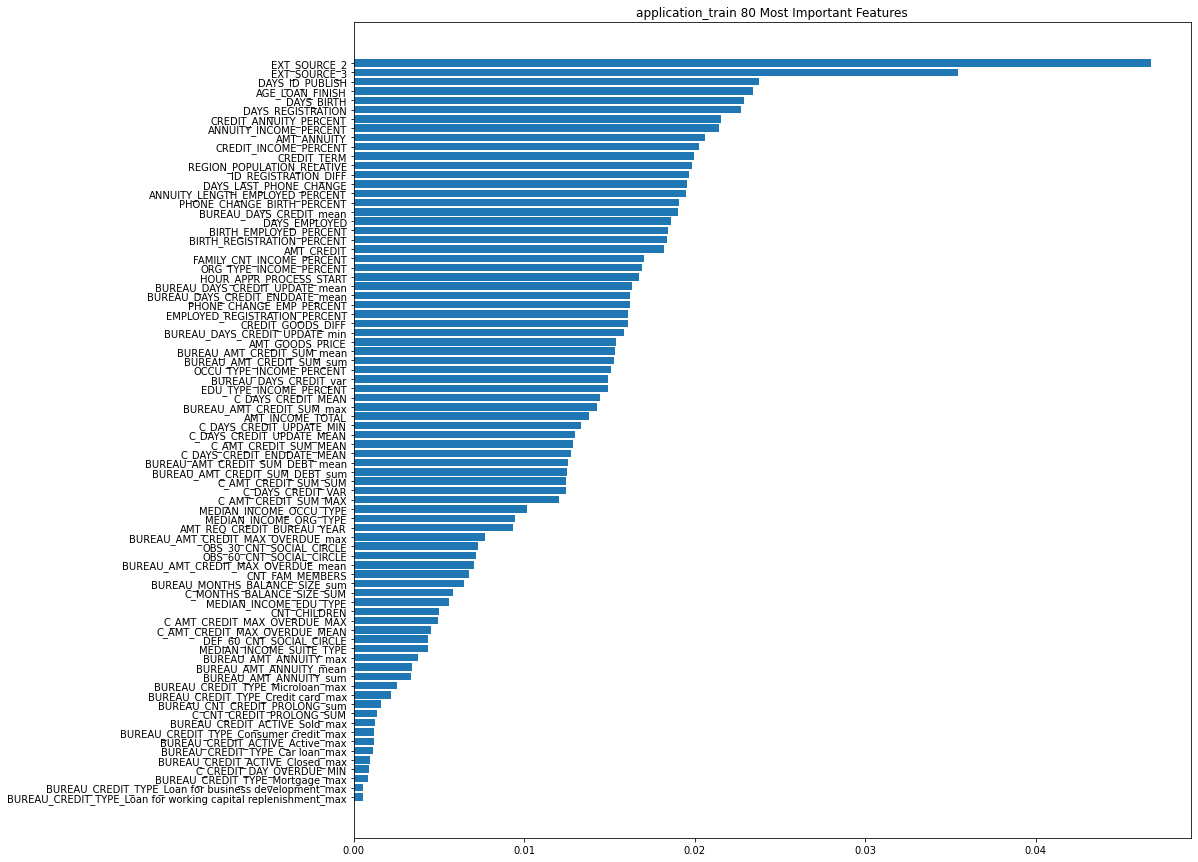

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
df_important = df_important[df_important.index.values >= 0.01]

<BarContainer object of 49 artists>

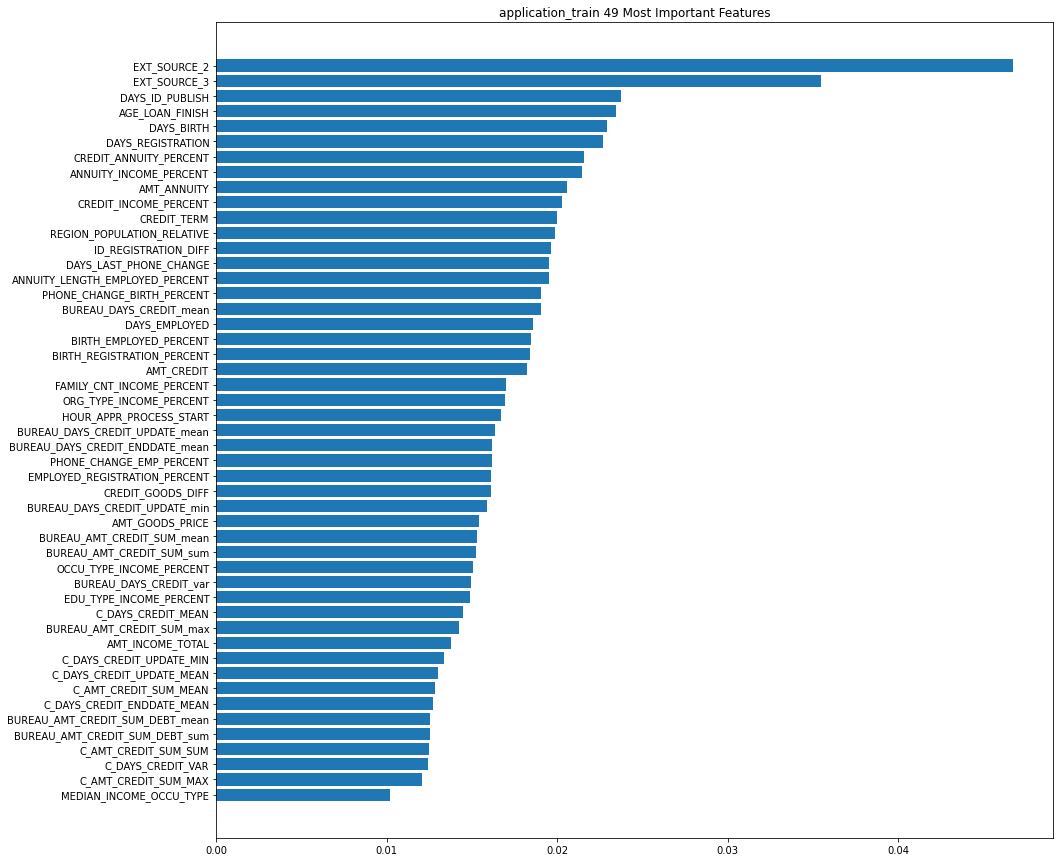

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
most_important = df_important[0].tolist()
most_important.insert(0, 'SK_ID_CURR')
most_important.insert(1,'TARGET')
print(most_important)

['SK_ID_CURR', 'TARGET', 'MEDIAN_INCOME_OCCU_TYPE', 'C_AMT_CREDIT_SUM_MAX', 'C_DAYS_CREDIT_VAR', 'C_AMT_CREDIT_SUM_SUM', 'BUREAU_AMT_CREDIT_SUM_DEBT_sum', 'BUREAU_AMT_CREDIT_SUM_DEBT_mean', 'C_DAYS_CREDIT_ENDDATE_MEAN', 'C_AMT_CREDIT_SUM_MEAN', 'C_DAYS_CREDIT_UPDATE_MEAN', 'C_DAYS_CREDIT_UPDATE_MIN', 'AMT_INCOME_TOTAL', 'BUREAU_AMT_CREDIT_SUM_max', 'C_DAYS_CREDIT_MEAN', 'EDU_TYPE_INCOME_PERCENT', 'BUREAU_DAYS_CREDIT_var', 'OCCU_TYPE_INCOME_PERCENT', 'BUREAU_AMT_CREDIT_SUM_sum', 'BUREAU_AMT_CREDIT_SUM_mean', 'AMT_GOODS_PRICE', 'BUREAU_DAYS_CREDIT_UPDATE_min', 'CREDIT_GOODS_DIFF', 'EMPLOYED_REGISTRATION_PERCENT', 'PHONE_CHANGE_EMP_PERCENT', 'BUREAU_DAYS_CREDIT_ENDDATE_mean', 'BUREAU_DAYS_CREDIT_UPDATE_mean', 'HOUR_APPR_PROCESS_START', 'ORG_TYPE_INCOME_PERCENT', 'FAMILY_CNT_INCOME_PERCENT', 'AMT_CREDIT', 'BIRTH_REGISTRATION_PERCENT', 'BIRTH_EMPLOYED_PERCENT', 'DAYS_EMPLOYED', 'BUREAU_DAYS_CREDIT_mean', 'PHONE_CHANGE_BIRTH_PERCENT', 'ANNUITY_LENGTH_EMPLOYED_PERCENT', 'DAYS_LAST_PHONE_CHANG

In [ ]:
abt_final = abt_final[most_important]
abt_final.head(10)
print(abt_final.shape)

(307511, 51)


####Salvando no Disco

In [ ]:
abt_final.to_csv(db_dir + '/BasesTratadas/abt_final.csv', index = False)

In [ ]:
del abt_final
del bureau_book
del X_train
del Y_train
del X_train_f
del Y_train_f
del X_train_cv
del Y_train_cv
del rf_classification
del df_important
gc.collect()

0

###abt_final + bureau_book + previous_application_book

In [ ]:
abt_temp = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/abt_final.csv'))
previous_app = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Stage/previous_app_book.csv'))

Memory usage of dataframe is 119.65 MB
Memory usage after optimization is: 30.21 MB
Decreased by 74.8%
Memory usage of dataframe is 266.28 MB
Memory usage after optimization is: 67.22 MB
Decreased by 74.8%


In [ ]:
abt_temp = abt_temp.merge(previous_app, on = 'SK_ID_CURR', how = 'left', indicator = True)

In [ ]:
abt_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 154 entries, SK_ID_CURR to _merge
dtypes: category(1), float16(151), int32(1), int8(1)
memory usage: 92.7 MB


In [ ]:
for i in abt_temp.columns.tolist():
  if abt_temp[i].dtype == 'category':
    print(i)

_merge


In [ ]:
abt_temp.drop('_merge', axis = 1, inplace = True)

In [ ]:
missing_perc, t = missing_percentage(abt_temp)
print(t)

+-----------------------------------------------------------+-----------+
|                          Feature                          | % Missing |
+-----------------------------------------------------------+-----------+
|                    PREV_AMT_ANNUITY_MAX                   |  5.3507%  |
|                   PREV_AMT_ANNUITY_MEAN                   |  5.3507%  |
|                  PREV_AMT_APPLICATION_MAX                 |  5.3507%  |
|                 PREV_AMT_APPLICATION_MEAN                 |  5.3507%  |
|                    PREV_AMT_CREDIT_MAX                    |  5.3507%  |
|                    PREV_AMT_CREDIT_MEAN                   |  5.3507%  |
|                 PREV_AMT_DOWN_PAYMENT_MAX                 |  5.3507%  |
|                 PREV_AMT_DOWN_PAYMENT_MEAN                |  5.3507%  |
|                 PREV_AMT_GOODS_PRICE_MEAN                 |  5.3507%  |
|                  PREV_AMT_GOODS_PRICE_SUM                 |  5.3507%  |
|              PREV_HOUR_APPR_PROCESS_

In [ ]:
abt_temp = missing_treatment(abt_temp,missing_perc,60)

PREV_AMT_ANNUITY_MAX converted to float32
PREV_AMT_ANNUITY_MAX filled with mean.
PREV_AMT_ANNUITY_MEAN converted to float32
PREV_AMT_ANNUITY_MEAN filled with mean.
PREV_AMT_APPLICATION_MAX converted to float32
PREV_AMT_APPLICATION_MAX filled with mean.
PREV_AMT_APPLICATION_MEAN converted to float32
PREV_AMT_APPLICATION_MEAN filled with mean.
PREV_AMT_CREDIT_MAX converted to float32
PREV_AMT_CREDIT_MAX filled with mean.
PREV_AMT_CREDIT_MEAN converted to float32
PREV_AMT_CREDIT_MEAN filled with mean.
PREV_AMT_DOWN_PAYMENT_MAX converted to float32
PREV_AMT_DOWN_PAYMENT_MAX filled with mean.
PREV_AMT_DOWN_PAYMENT_MEAN converted to float32
PREV_AMT_DOWN_PAYMENT_MEAN filled with mean.
PREV_AMT_GOODS_PRICE_MEAN converted to float32
PREV_AMT_GOODS_PRICE_MEAN filled with mean.
PREV_AMT_GOODS_PRICE_SUM converted to float32
PREV_AMT_GOODS_PRICE_SUM filled with mean.
PREV_HOUR_APPR_PROCESS_START_MAX converted to float32
PREV_HOUR_APPR_PROCESS_START_MAX filled with mean.
PREV_HOUR_APPR_PROCESS_STAR

In [ ]:
abt_temp.reindex

<bound method DataFrame.reindex of         SK_ID_CURR  TARGET  MEDIAN_INCOME_OCCU_TYPE  C_AMT_CREDIT_SUM_MAX  \
0           100002       1                 0.399902              0.112549   
1           100003       0                 0.399902              0.093811   
2           100004       0                 0.399902              0.078796   
3           100006       0                 0.399902              0.313965   
4           100007       0                 0.399902              0.121948   
...            ...     ...                      ...                   ...   
307506      456251       0                 0.199951              0.313965   
307507      456252       0                 0.421143              0.313965   
307508      456253       0                 1.000000              0.562988   
307509      456254       1                 0.399902              0.037506   
307510      456255       0                 0.399902              0.750488   

        C_DAYS_CREDIT_VAR  C_AMT_CREDIT_

In [ ]:
X_train = abt_temp.drop(['SK_ID_CURR','TARGET'], axis = 1)
Y_train = abt_temp['TARGET']

In [ ]:
X_train_f, X_train_cv, Y_train_f, Y_train_cv = train_test_split(X_train, Y_train, test_size = 0.25, stratify = Y_train)
print(X_train_f.shape, Y_train_f.shape)
print(X_train_cv.shape, Y_train_cv.shape)

(230633, 151) (230633,)
(76878, 151) (76878,)


In [ ]:
model_1 = RandomForestClassifier()
model_1.fit(X_train_f, Y_train_f)

RandomForestClassifier()

In [ ]:
sorted_idx = model_1.feature_importances_.argsort()
rf_classification = pd.DataFrame(X_train_f.columns[sorted_idx], model_1.feature_importances_[sorted_idx])
df_important = rf_classification.tail(140)

<BarContainer object of 140 artists>

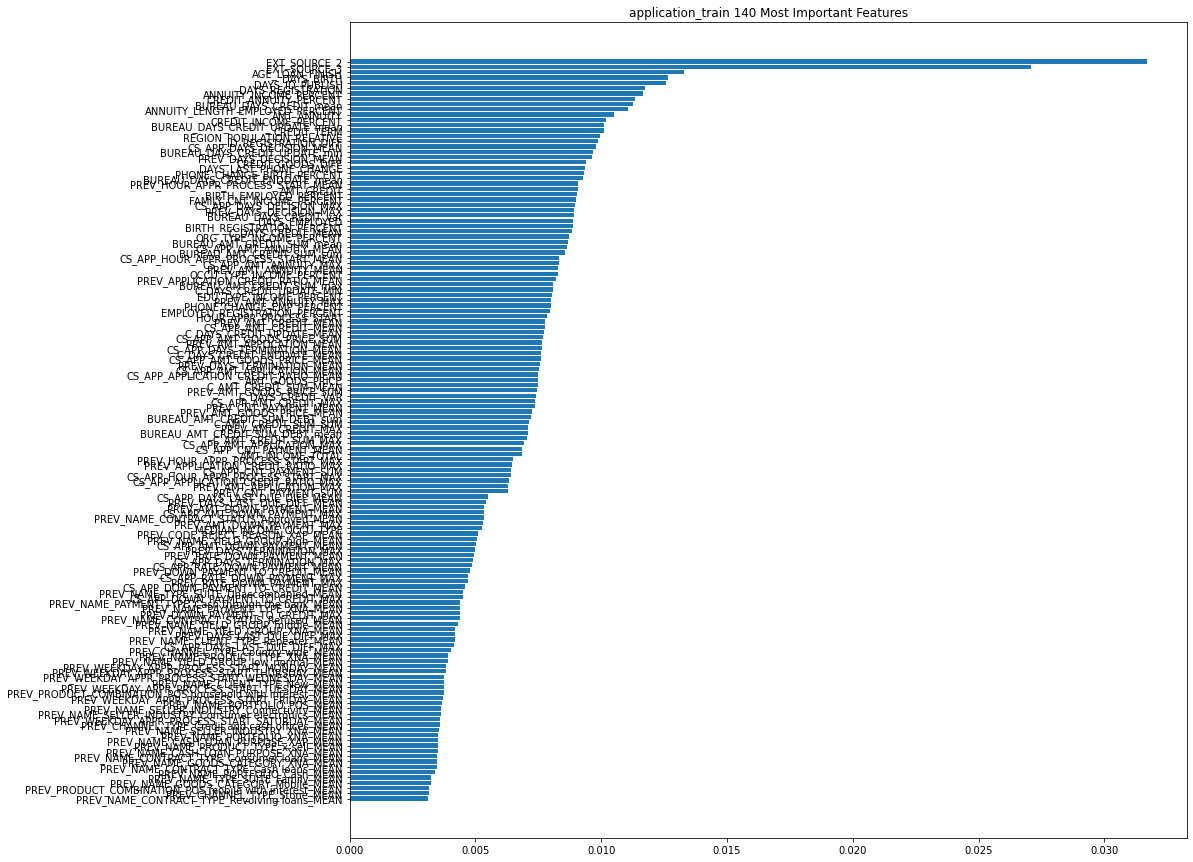

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
df_important = df_important[df_important.index.values >= 0.0075]

<BarContainer object of 60 artists>

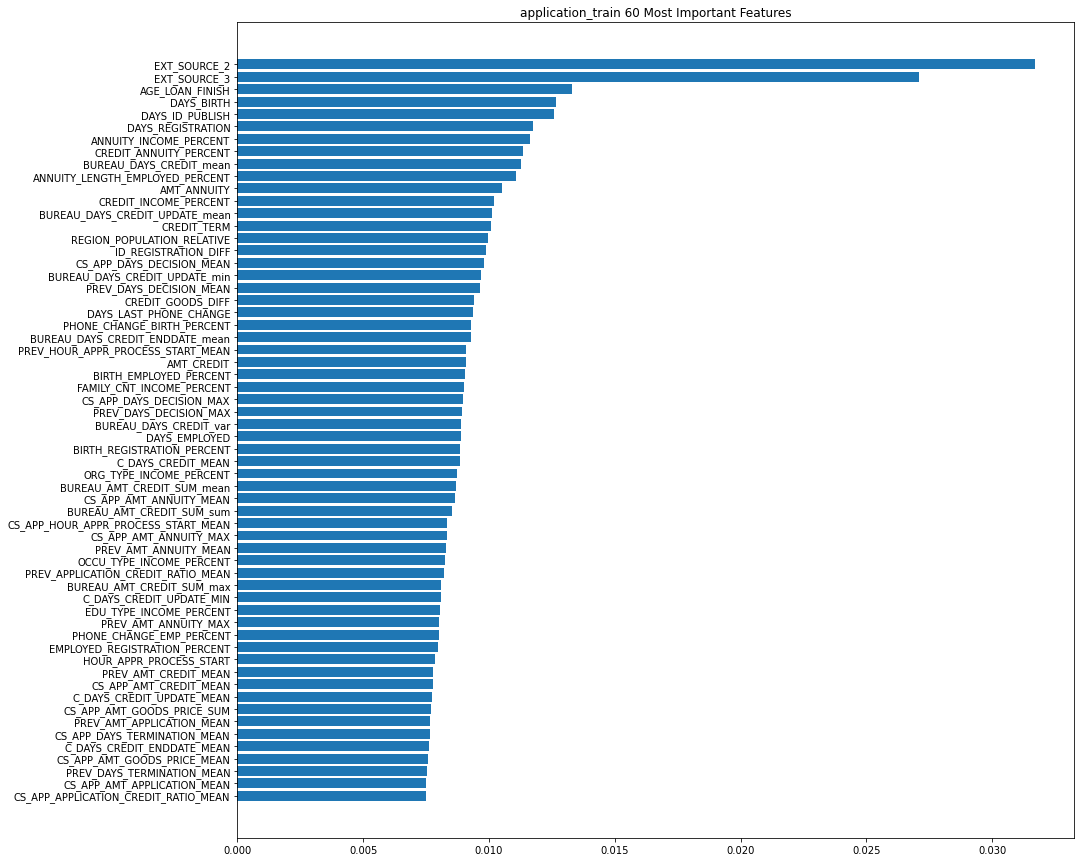

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
most_important = df_important[0].tolist()
most_important.insert(0, 'SK_ID_CURR')
most_important.insert(1,'TARGET')
print(most_important)

['SK_ID_CURR', 'TARGET', 'CS_APP_APPLICATION_CREDIT_RATIO_MEAN', 'CS_APP_AMT_APPLICATION_MEAN', 'PREV_DAYS_TERMINATION_MEAN', 'CS_APP_AMT_GOODS_PRICE_MEAN', 'C_DAYS_CREDIT_ENDDATE_MEAN', 'CS_APP_DAYS_TERMINATION_MEAN', 'PREV_AMT_APPLICATION_MEAN', 'CS_APP_AMT_GOODS_PRICE_SUM', 'C_DAYS_CREDIT_UPDATE_MEAN', 'CS_APP_AMT_CREDIT_MEAN', 'PREV_AMT_CREDIT_MEAN', 'HOUR_APPR_PROCESS_START', 'EMPLOYED_REGISTRATION_PERCENT', 'PHONE_CHANGE_EMP_PERCENT', 'PREV_AMT_ANNUITY_MAX', 'EDU_TYPE_INCOME_PERCENT', 'C_DAYS_CREDIT_UPDATE_MIN', 'BUREAU_AMT_CREDIT_SUM_max', 'PREV_APPLICATION_CREDIT_RATIO_MEAN', 'OCCU_TYPE_INCOME_PERCENT', 'PREV_AMT_ANNUITY_MEAN', 'CS_APP_AMT_ANNUITY_MAX', 'CS_APP_HOUR_APPR_PROCESS_START_MEAN', 'BUREAU_AMT_CREDIT_SUM_sum', 'CS_APP_AMT_ANNUITY_MEAN', 'BUREAU_AMT_CREDIT_SUM_mean', 'ORG_TYPE_INCOME_PERCENT', 'C_DAYS_CREDIT_MEAN', 'BIRTH_REGISTRATION_PERCENT', 'DAYS_EMPLOYED', 'BUREAU_DAYS_CREDIT_var', 'PREV_DAYS_DECISION_MAX', 'CS_APP_DAYS_DECISION_MAX', 'FAMILY_CNT_INCOME_PERCENT', 

In [ ]:
abt_final = abt_temp[most_important]
abt_final.head(10)
print(abt_final.shape)

(307511, 62)


####Salvando no Disco

In [ ]:
abt_final.to_csv(db_dir + '/BasesTratadas/abt_final.csv', index = False)

In [ ]:
del abt_final
del previous_app
del abt_temp
del X_train
del Y_train
del X_train_f
del Y_train_f
del X_train_cv
del Y_train_cv
del rf_classification
del df_important
gc.collect()

79

###abt_final + bureau_book + previous_application_book + installments_payments_book

In [ ]:
abt_temp = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/abt_final.csv'))
istpay_book = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Stage/installments_payments_book.csv'))

Memory usage of dataframe is 145.46 MB
Memory usage after optimization is: 36.66 MB
Decreased by 74.8%
Memory usage of dataframe is 49.23 MB
Memory usage after optimization is: 12.95 MB
Decreased by 73.7%


In [ ]:
abt_temp = abt_temp.merge(istpay_book, on = 'SK_ID_CURR', how = 'left', indicator = True)

In [ ]:
for i in abt_temp.columns.tolist():
  if abt_temp[i].dtype == 'category':
    print(i)

_merge


In [ ]:
abt_temp.drop('_merge', axis = 1, inplace = True)

In [ ]:
missing_perc, t = missing_percentage(abt_temp)
print(t)

+------------------------------------+-----------+
|              Feature               | % Missing |
+------------------------------------+-----------+
|        INS_LATE_PAYMENT_MAX        |  5.1601%  |
|       INS_LATE_PAYMENT_MEAN        |  5.1601%  |
|        INS_LATE_PAYMENT_MIN        |  5.1601%  |
|        INS_AMT_PAYMENT_MIN         |  5.1601%  |
|        INS_AMT_PAYMENT_MAX         |  5.1601%  |
|        INS_AMT_PAYMENT_MEAN        |  5.1601%  |
|        INS_AMT_PAYMENT_SUM         |  5.1601%  |
| INS_NUM_INSTALMENT_VERSION_NUNIQUE |  5.1601%  |
|   INS_NUM_INSTALMENT_NUMBER_MAX    |  5.1601%  |
|       INS_AMT_INSTALMENT_MAX       |  5.1601%  |
|      INS_AMT_INSTALMENT_MEAN       |  5.1601%  |
|       INS_AMT_INSTALMENT_SUM       |  5.1601%  |
|     INS_DAYS_ENTRY_PAYMENT_MAX     |  5.1601%  |
|    INS_DAYS_ENTRY_PAYMENT_MEAN     |  5.1601%  |
|     INS_DAYS_ENTRY_PAYMENT_SUM     |  5.1601%  |
|     INS_PAID_OVER_AMOUNT_MEAN      |  5.1601%  |
|      INS_PAID_OVER_AMOUNT_MIN

In [ ]:
abt_temp = missing_treatment(abt_temp,missing_perc,60)

INS_LATE_PAYMENT_MAX converted to float32
INS_LATE_PAYMENT_MAX filled with mean.
INS_LATE_PAYMENT_MEAN converted to float32
INS_LATE_PAYMENT_MEAN filled with mean.
INS_LATE_PAYMENT_MIN converted to float32
INS_LATE_PAYMENT_MIN filled with mean.
INS_AMT_PAYMENT_MIN converted to float32
INS_AMT_PAYMENT_MIN filled with mean.
INS_AMT_PAYMENT_MAX converted to float32
INS_AMT_PAYMENT_MAX filled with mean.
INS_AMT_PAYMENT_MEAN converted to float32
INS_AMT_PAYMENT_MEAN filled with mean.
INS_AMT_PAYMENT_SUM converted to float32
INS_AMT_PAYMENT_SUM filled with mean.
INS_NUM_INSTALMENT_VERSION_NUNIQUE converted to float32
INS_NUM_INSTALMENT_VERSION_NUNIQUE filled with mean.
INS_NUM_INSTALMENT_NUMBER_MAX converted to float32
INS_NUM_INSTALMENT_NUMBER_MAX filled with mean.
INS_AMT_INSTALMENT_MAX converted to float32
INS_AMT_INSTALMENT_MAX filled with mean.
INS_AMT_INSTALMENT_MEAN converted to float32
INS_AMT_INSTALMENT_MEAN filled with mean.
INS_AMT_INSTALMENT_SUM converted to float32
INS_AMT_INSTA

In [ ]:
abt_temp.reindex

<bound method DataFrame.reindex of         SK_ID_CURR  TARGET  CS_APP_APPLICATION_CREDIT_RATIO_MEAN  \
0           100002       1                              0.559082   
1           100003       0                              0.455078   
2           100004       0                              0.984863   
3           100006       0                              0.683105   
4           100007       0                              0.497070   
...            ...     ...                                   ...   
307506      456251       0                              0.559082   
307507      456252       0                              0.586914   
307508      456253       0                              1.000000   
307509      456254       1                              0.336914   
307510      456255       0                              0.395020   

        CS_APP_AMT_APPLICATION_MEAN  PREV_DAYS_TERMINATION_MEAN  \
0                          0.424316                    0.007702   
1             

In [ ]:
X_train = abt_temp.drop(['SK_ID_CURR','TARGET'], axis = 1)
Y_train = abt_temp['TARGET']
X_train_f, X_train_cv, Y_train_f, Y_train_cv = train_test_split(X_train, Y_train, test_size = 0.25, stratify = Y_train)

In [ ]:
model_1 = RandomForestClassifier()
model_1.fit(X_train_f, Y_train_f)

RandomForestClassifier()

In [ ]:
sorted_idx = model_1.feature_importances_.argsort()
rf_classification = pd.DataFrame(X_train_f.columns[sorted_idx], model_1.feature_importances_[sorted_idx])
df_important = rf_classification.tail(140)

<BarContainer object of 78 artists>

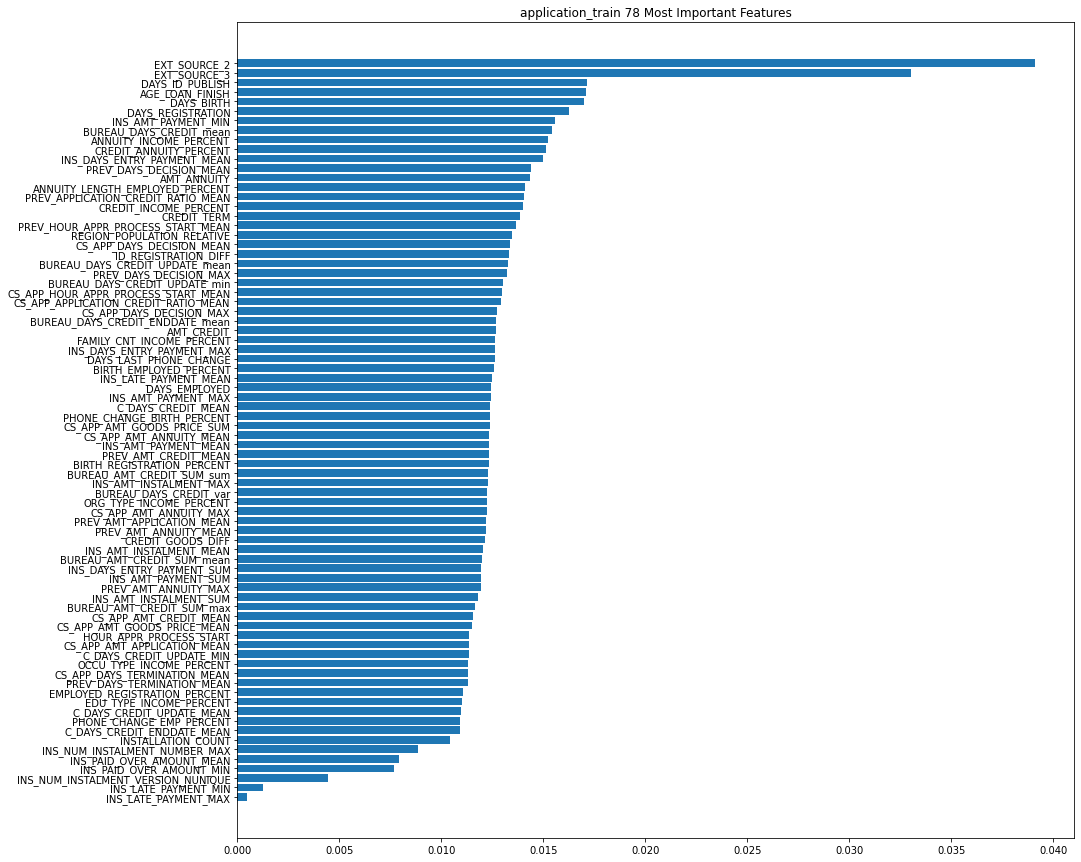

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
df_important = df_important[df_important.index.values >= 0.0075]

<BarContainer object of 75 artists>

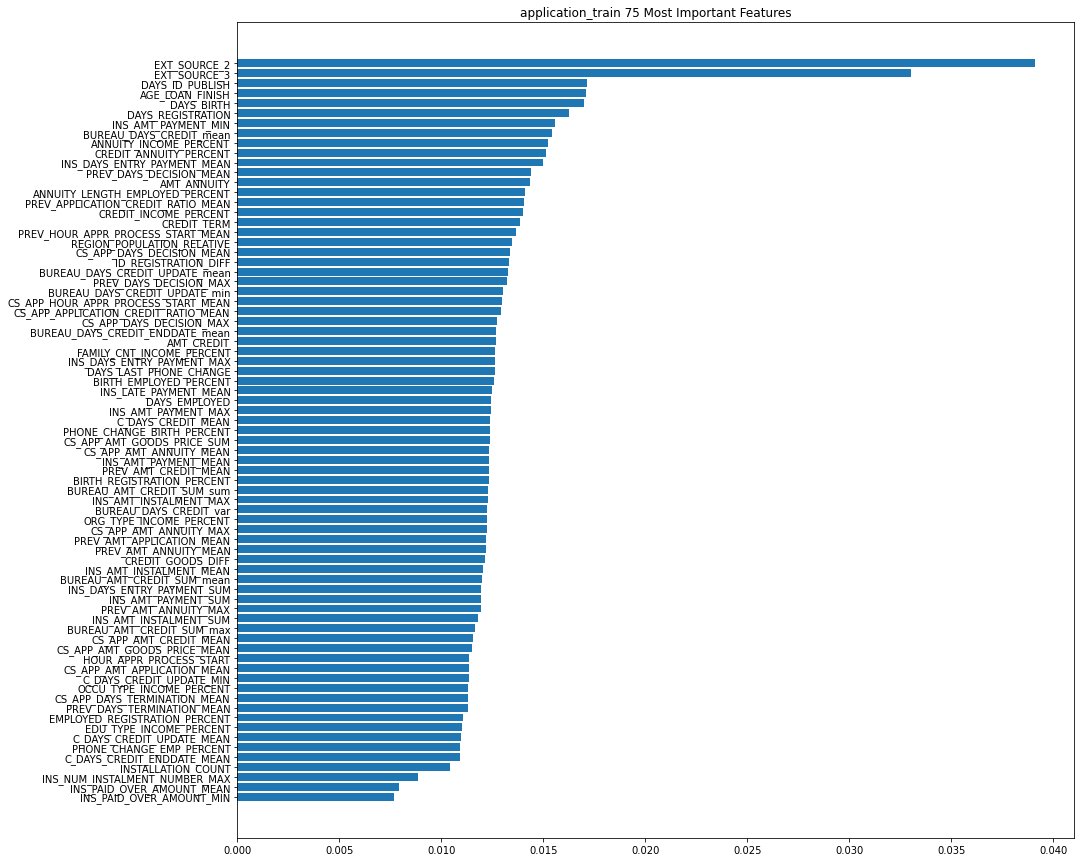

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
most_important = df_important[0].tolist()
most_important.insert(0, 'SK_ID_CURR')
most_important.insert(1,'TARGET')
abt_final = abt_temp[most_important]
abt_final.head(10)
print(abt_final.shape)

(307511, 77)


####Salvando no Disco

In [ ]:
abt_final.to_csv(db_dir + '/BasesTratadas/abt_final.csv', index = False)

In [ ]:
del abt_final
del istpay_book
del abt_temp
del X_train
del Y_train
del X_train_f
del Y_train_f
del X_train_cv
del Y_train_cv
del rf_classification
del df_important
gc.collect()

0

###abt_final + bureau_book + previous_application_book + installments_payments_book + pos_cash_balance_book

In [ ]:
abt_temp = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/abt_final.csv'))
pos_cash_book = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Stage/pos_cash_balance_book.csv'))

Memory usage of dataframe is 180.65 MB
Memory usage after optimization is: 45.46 MB
Decreased by 74.8%
Memory usage of dataframe is 43.74 MB
Memory usage after optimization is: 11.58 MB
Decreased by 73.5%


In [ ]:
abt_temp = abt_temp.merge(pos_cash_book, on = 'SK_ID_CURR', how = 'left', indicator = True)

In [ ]:
abt_temp.drop('_merge', axis = 1, inplace = True)

In [ ]:
missing_perc, t = missing_percentage(abt_temp)
print(t)

+-----------------------------------------+-----------+
|                 Feature                 | % Missing |
+-----------------------------------------+-----------+
|            POS_SK_DPD_DEF_MIN           |  5.8752%  |
|          POS_MONTHS_BALANCE_MAX         |  5.8752%  |
|         POS_MONTHS_BALANCE_MEAN         |  5.8752%  |
|         POS_MONTHS_BALANCE_SIZE         |  5.8752%  |
|          POS_CNT_INSTALMENT_MAX         |  5.8752%  |
|         POS_CNT_INSTALMENT_SIZE         |  5.8752%  |
|      POS_CNT_INSTALMENT_FUTURE_MAX      |  5.8752%  |
|      POS_CNT_INSTALMENT_FUTURE_SIZE     |  5.8752%  |
|      POS_CNT_INSTALMENT_FUTURE_SUM      |  5.8752%  |
|   POS_NAME_CONTRACT_STATUS_Active_MEAN  |  5.8752%  |
| POS_NAME_CONTRACT_STATUS_Completed_MEAN |  5.8752%  |
|    POS_NAME_CONTRACT_STATUS_XNA_MEAN    |  5.8752%  |
|         POS_LOAN_COMPLETED_MEAN         |  5.8752%  |
|        POS_COMPLETED_BEFORE_MEAN        |  5.8752%  |
|        POS_REMAINING_INSTALMENTS        |  5.8

In [ ]:
abt_temp = missing_treatment(abt_temp,missing_perc,60)

POS_SK_DPD_DEF_MIN converted to float32
POS_SK_DPD_DEF_MIN filled with mean.
POS_MONTHS_BALANCE_MAX converted to float32
POS_MONTHS_BALANCE_MAX filled with mean.
POS_MONTHS_BALANCE_MEAN converted to float32
POS_MONTHS_BALANCE_MEAN filled with mean.
POS_MONTHS_BALANCE_SIZE converted to float32
POS_MONTHS_BALANCE_SIZE filled with mean.
POS_CNT_INSTALMENT_MAX converted to float32
POS_CNT_INSTALMENT_MAX filled with mean.
POS_CNT_INSTALMENT_SIZE converted to float32
POS_CNT_INSTALMENT_SIZE filled with mean.
POS_CNT_INSTALMENT_FUTURE_MAX converted to float32
POS_CNT_INSTALMENT_FUTURE_MAX filled with mean.
POS_CNT_INSTALMENT_FUTURE_SIZE converted to float32
POS_CNT_INSTALMENT_FUTURE_SIZE filled with mean.
POS_CNT_INSTALMENT_FUTURE_SUM converted to float32
POS_CNT_INSTALMENT_FUTURE_SUM filled with mean.
POS_NAME_CONTRACT_STATUS_Active_MEAN converted to float32
POS_NAME_CONTRACT_STATUS_Active_MEAN filled with mean.
POS_NAME_CONTRACT_STATUS_Completed_MEAN converted to float32
POS_NAME_CONTRACT_S

In [ ]:
abt_temp.reindex

<bound method DataFrame.reindex of         SK_ID_CURR  TARGET  INS_PAID_OVER_AMOUNT_MIN  \
0           100002       1                  0.625000   
1           100003       0                  0.625000   
2           100004       0                  0.625000   
3           100006       0                  0.625000   
4           100007       0                  0.004097   
...            ...     ...                       ...   
307506      456251       0                  0.625000   
307507      456252       0                  0.625000   
307508      456253       0                  0.517090   
307509      456254       1                  0.625000   
307510      456255       0                  0.000000   

        INS_PAID_OVER_AMOUNT_MEAN  INS_NUM_INSTALMENT_NUMBER_MAX  \
0                        0.625000                       0.409180   
1                        0.625000                       0.250000   
2                        0.625000                       0.045441   
3                   

In [ ]:
X_train = abt_temp.drop(['SK_ID_CURR','TARGET'], axis = 1)
Y_train = abt_temp['TARGET']
X_train_f, X_train_cv, Y_train_f, Y_train_cv = train_test_split(X_train, Y_train, test_size = 0.25, stratify = Y_train)

In [ ]:
model_1 = RandomForestClassifier()
model_1.fit(X_train_f, Y_train_f)

RandomForestClassifier()

In [ ]:
sorted_idx = model_1.feature_importances_.argsort()
rf_classification = pd.DataFrame(X_train_f.columns[sorted_idx], model_1.feature_importances_[sorted_idx])
df_important = rf_classification.tail(140)

<BarContainer object of 91 artists>

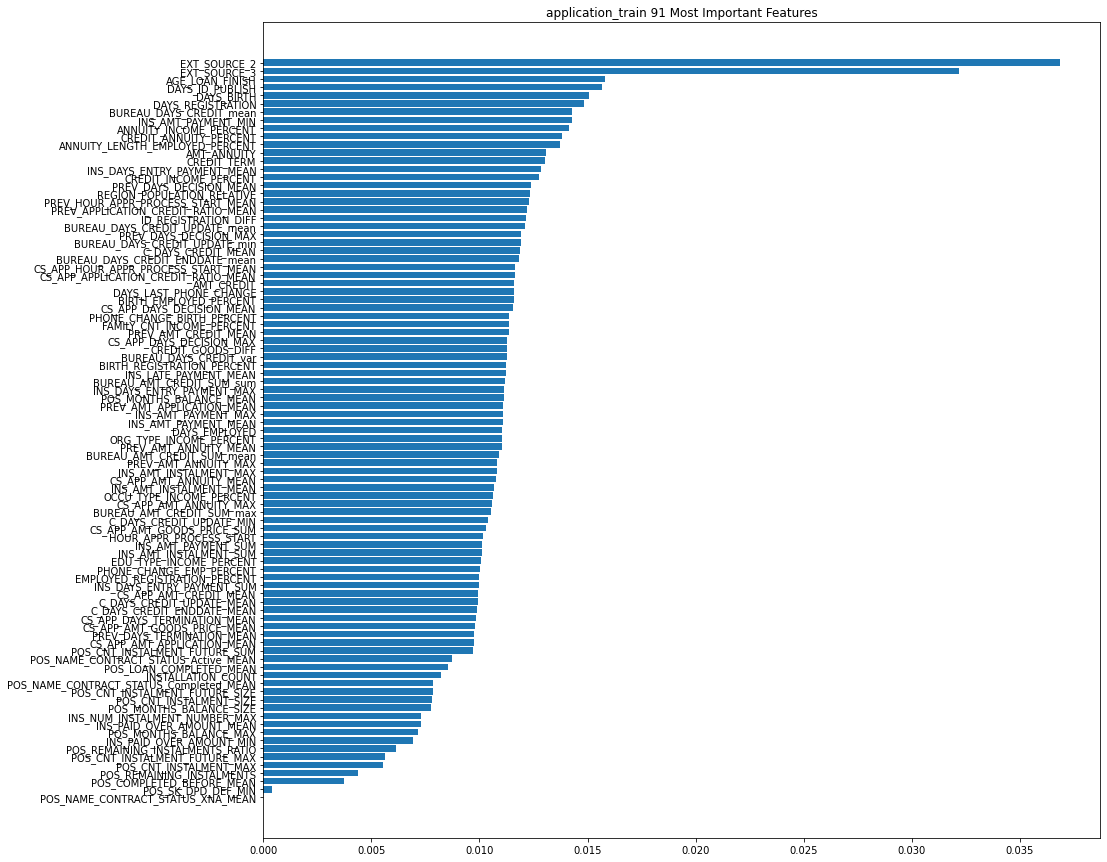

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
df_important = df_important[df_important.index.values >= 0.0075]

<BarContainer object of 80 artists>

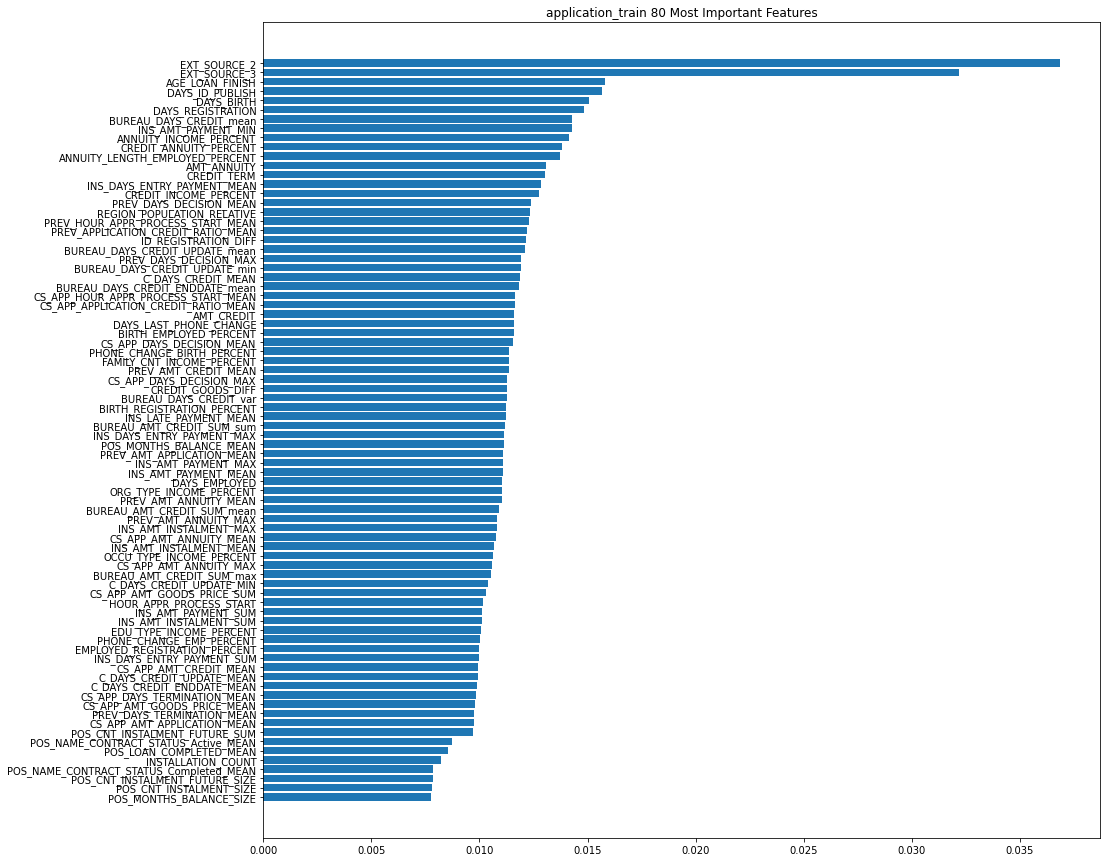

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
most_important = df_important[0].tolist()
most_important.insert(0, 'SK_ID_CURR')
most_important.insert(1,'TARGET')
abt_final = abt_temp[most_important]
abt_final.head(10)
print(abt_final.shape)

(307511, 82)


####Salvando no Disco

In [ ]:
abt_final.to_csv(db_dir + '/BasesTratadas/abt_final.csv', index = False)

In [ ]:
del abt_final
del pos_cash_book
del abt_temp
del X_train
del Y_train
del X_train_f
del Y_train_f
del X_train_cv
del Y_train_cv
del rf_classification
del df_important
gc.collect()

2786

###abt_final + bureau_book + previous_application_book + installments_payments_book + pos_cash_balance_book + credit_card_balance_book

In [ ]:
abt_temp = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/abt_final.csv'))
credcard_book = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/Stage/credit_card_balance_book.csv'))

Memory usage of dataframe is 192.38 MB
Memory usage after optimization is: 48.39 MB
Decreased by 74.8%
Memory usage of dataframe is 69.53 MB
Memory usage after optimization is: 17.58 MB
Decreased by 74.7%


In [ ]:
abt_temp = abt_temp.merge(credcard_book, on = 'SK_ID_CURR', how = 'left', indicator = True)

In [ ]:
abt_temp.drop('_merge', axis = 1, inplace = True)

In [ ]:
missing_perc, t = missing_percentage(abt_temp)
print(t)

+-------------------------------------------+-----------+
|                  Feature                  | % Missing |
+-------------------------------------------+-----------+
|           CR_MONTHS_BALANCE_MAX           |  71.7392% |
|           CR_MONTHS_BALANCE_MEAN          |  71.7392% |
|           CR_MONTHS_BALANCE_SUM           |  71.7392% |
|           CR_MONTHS_BALANCE_VAR           |  71.7392% |
|             CR_AMT_BALANCE_MAX            |  71.7392% |
|            CR_AMT_BALANCE_MEAN            |  71.7392% |
|             CR_AMT_BALANCE_SUM            |  71.7392% |
|             CR_AMT_BALANCE_VAR            |  71.7392% |
|       CR_AMT_CREDIT_LIMIT_ACTUAL_MAX      |  71.7392% |
|      CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN      |  71.7392% |
|       CR_AMT_CREDIT_LIMIT_ACTUAL_SUM      |  71.7392% |
|       CR_AMT_CREDIT_LIMIT_ACTUAL_VAR      |  71.7392% |
|      CR_AMT_DRAWINGS_ATM_CURRENT_MAX      |  71.7392% |
|      CR_AMT_DRAWINGS_ATM_CURRENT_MEAN     |  71.7392% |
|      CR_AMT_

In [ ]:
abt_temp = missing_treatment(abt_temp,missing_perc,60)

CR_MONTHS_BALANCE_MAX converted to float32
CR_MONTHS_BALANCE_MAX droped
CR_MONTHS_BALANCE_MEAN converted to float32
CR_MONTHS_BALANCE_MEAN droped
CR_MONTHS_BALANCE_SUM converted to float32
CR_MONTHS_BALANCE_SUM droped
CR_MONTHS_BALANCE_VAR converted to float32
CR_MONTHS_BALANCE_VAR droped
CR_AMT_BALANCE_MAX converted to float32
CR_AMT_BALANCE_MAX droped
CR_AMT_BALANCE_MEAN converted to float32
CR_AMT_BALANCE_MEAN droped
CR_AMT_BALANCE_SUM converted to float32
CR_AMT_BALANCE_SUM droped
CR_AMT_BALANCE_VAR converted to float32
CR_AMT_BALANCE_VAR droped
CR_AMT_CREDIT_LIMIT_ACTUAL_MAX converted to float32
CR_AMT_CREDIT_LIMIT_ACTUAL_MAX droped
CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN converted to float32
CR_AMT_CREDIT_LIMIT_ACTUAL_MEAN droped
CR_AMT_CREDIT_LIMIT_ACTUAL_SUM converted to float32
CR_AMT_CREDIT_LIMIT_ACTUAL_SUM droped
CR_AMT_CREDIT_LIMIT_ACTUAL_VAR converted to float32
CR_AMT_CREDIT_LIMIT_ACTUAL_VAR droped
CR_AMT_DRAWINGS_ATM_CURRENT_MAX converted to float32
CR_AMT_DRAWINGS_ATM_CURRENT_M

In [ ]:
abt_temp.reindex

<bound method DataFrame.reindex of         SK_ID_CURR  TARGET  POS_MONTHS_BALANCE_SIZE  POS_CNT_INSTALMENT_SIZE  \
0           100002       1                 0.229248                 0.229248   
1           100003       0                 0.343994                 0.343994   
2           100004       0                 0.038208                 0.038208   
3           100006       0                 0.254883                 0.254883   
4           100007       0                 0.828125                 0.828125   
...            ...     ...                      ...                      ...   
307506      456251       0                 0.101929                 0.101929   
307507      456252       0                 0.076416                 0.076416   
307508      456253       0                 0.203857                 0.203857   
307509      456254       1                 0.242065                 0.242065   
307510      456255       0                 0.891602                 0.891602   

    

In [ ]:
X_train = abt_temp.drop(['SK_ID_CURR','TARGET'], axis = 1)
Y_train = abt_temp['TARGET']
X_train_f, X_train_cv, Y_train_f, Y_train_cv = train_test_split(X_train, Y_train, test_size = 0.25, stratify = Y_train)

In [ ]:
model_1 = RandomForestClassifier()
model_1.fit(X_train_f, Y_train_f)

RandomForestClassifier()

In [ ]:
sorted_idx = model_1.feature_importances_.argsort()
rf_classification = pd.DataFrame(X_train_f.columns[sorted_idx], model_1.feature_importances_[sorted_idx])
df_important = rf_classification.tail(150)

<BarContainer object of 80 artists>

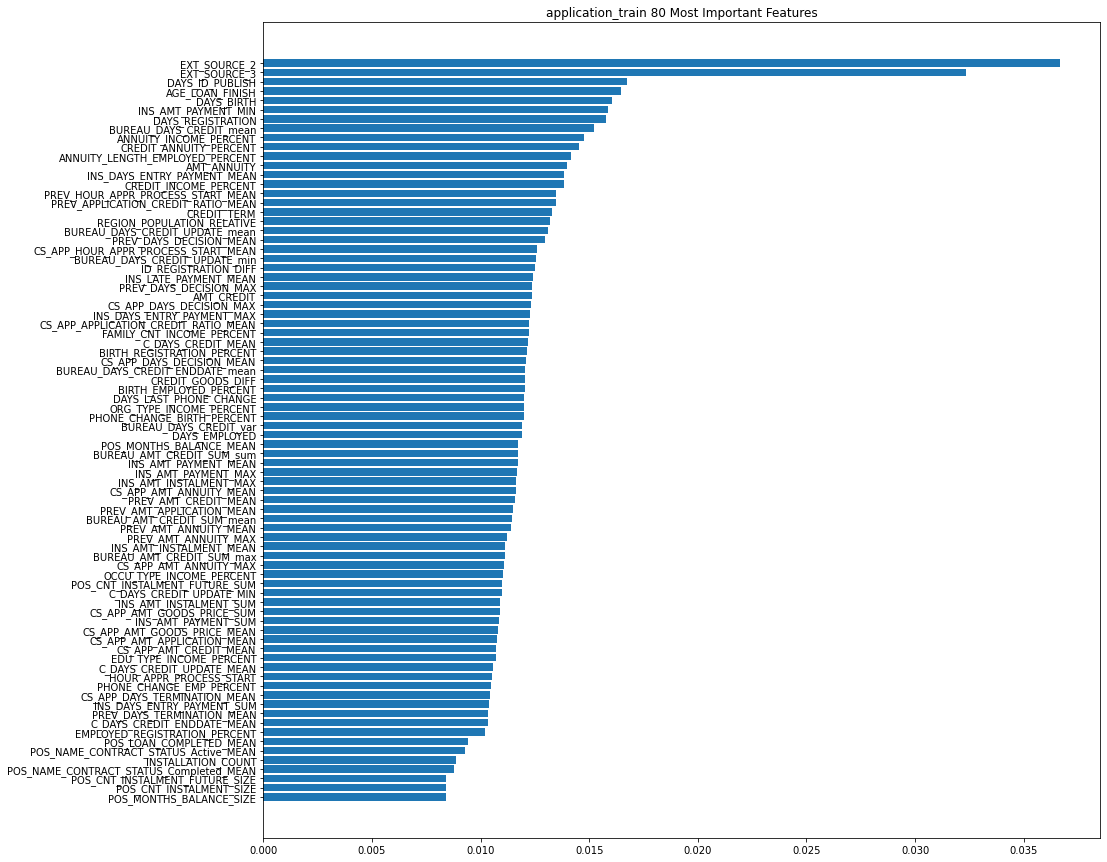

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
df_important = df_important[df_important.index.values >= 0.0075]

<BarContainer object of 80 artists>

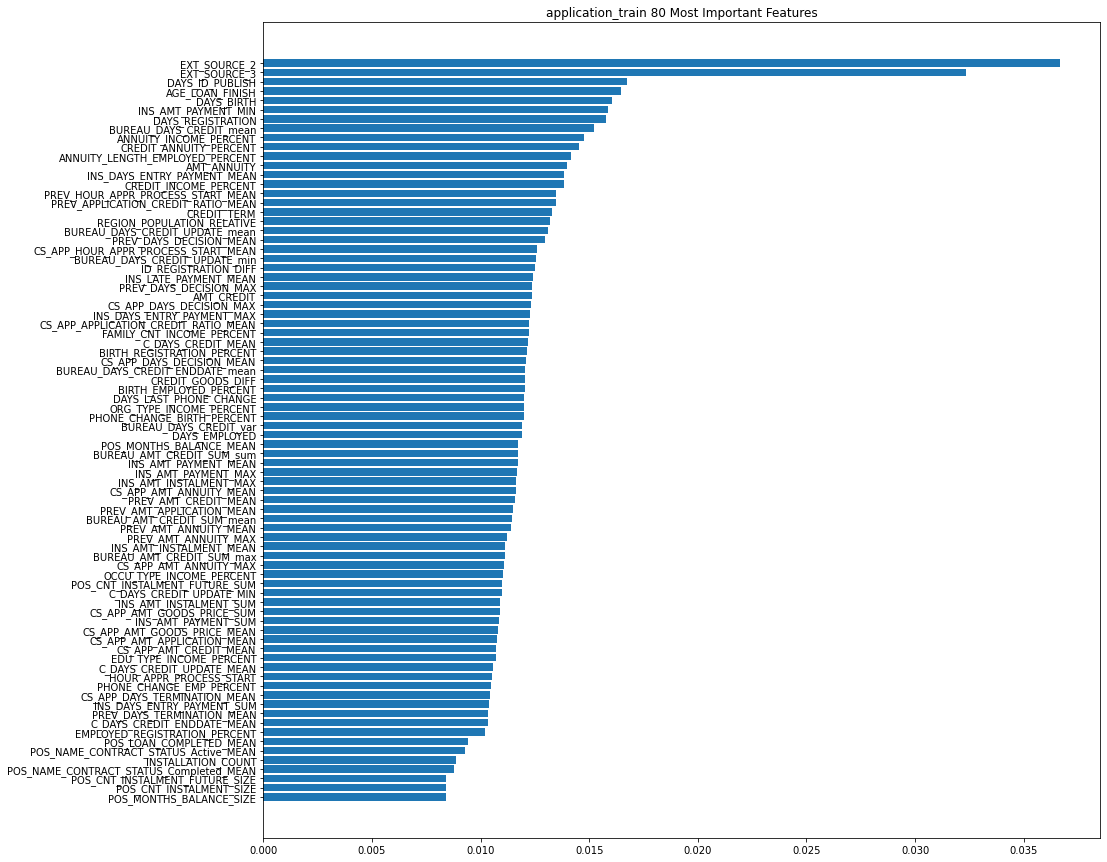

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title ('application_train {} Most Important Features'.format(len(df_important)))
plt.barh(df_important[0], df_important.index.values)

In [ ]:
most_important = df_important[0].tolist()
most_important.insert(0, 'SK_ID_CURR')
most_important.insert(1,'TARGET')
abt_final = abt_temp[most_important]
abt_final.head(10)
print(abt_final.shape)

(307511, 82)


####Salvando no Disco

In [ ]:
abt_final.to_csv(db_dir + '/BasesTratadas/abt_final.csv', index = False)

In [ ]:
del abt_final
del credcard_book
del abt_temp
del X_train
del Y_train
del X_train_f
del Y_train_f
del X_train_cv
del Y_train_cv
del rf_classification
del df_important
gc.collect()

68

##Modelos

###Funções de Apoio

In [ ]:
def obtain_threshold(thresholds,tpr,fpr):   
    
    obtain_threshold.best_tradeoff = tpr*(1-fpr)
    ideal_threshold = thresholds[obtain_threshold.best_tradeoff.argmax()]
 
    return ideal_threshold

def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
   
    plt.figure(figsize=(20,5))
    
    labels = [0,1]
   
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.set(font_scale=1.1)
    sns.set_style(style='white')
    
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B,annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".10f", xticklabels=labels, \
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

def batch_predict(classifier, data):
   
    y_data_pred = []
    loop_count = data.shape[0] - data.shape[0]%1000
   
    for i in range(0, loop_count, 1000):
        y_data_pred.extend(classifier.predict_proba(data[i:i+1000])[:,1])

    y_data_pred.extend(classifier.predict_proba(data[loop_count:])[:,1])
    
    return y_data_pred

### Carga da ABT e Split em Treino e Teste

In [ ]:
abt = reduce_memory_usage(pd.read_csv(db_dir + '/BasesTratadas/abt_final.csv'))

Memory usage of dataframe is 192.38 MB
Memory usage after optimization is: 48.39 MB
Decreased by 74.8%


In [ ]:
X_train = abt.drop(['SK_ID_CURR','TARGET'], axis = 1)
Y_train = abt['TARGET']
X_train_f, X_train_cv, Y_train_f, Y_train_cv = train_test_split(X_train, Y_train, test_size = 0.25, stratify = Y_train)

###Random Forest Classifier

#### Ajuste de Hiper parametros com Random Search Cross Validation

In [ ]:
run_start = datetime.now()

randomForest = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
params = {'n_estimators' : sp_randint(200, 1000), 'max_depth' : sp_randint(5, 20)}

rf_RSearchCV = RandomizedSearchCV(randomForest, param_distributions=params, scoring='roc_auc', n_jobs=3, cv=3, verbose = 10)

rf_RSearchCV.fit(X_train_f, Y_train_f)

print('\nMelhores Parâmetros:')
print(rf_RSearchCV.best_params_)

print('Melhor ROC_AUC obtido no Cross Validation:', rf_RSearchCV.best_score_)

print('Tempo de execução:', datetime.now() - run_start)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Melhores Parâmetros:
{'max_depth': 9, 'n_estimators': 241}
Melhor ROC_AUC obtido no Cross Validation: 0.7428193731612888
Tempo de execução: 1:11:31.271663


####Trainando o Modelo

In [ ]:
rf_model = RandomForestClassifier(n_estimators=241, max_depth=9, class_weight='balanced', random_state=42)
rf_model.fit(X_train_f, Y_train_f)

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=241,
                       random_state=42)

####Validações

#####Área da Curva ROC

In [ ]:
train_f, train_t, train_threshold = roc_curve(Y_train_f, rf_model.predict_proba(X_train_f)[:,1])
cv_f, cv_r, cv_threshold = roc_curve(Y_train_cv, rf_model.predict_proba(X_train_cv)[:,1])

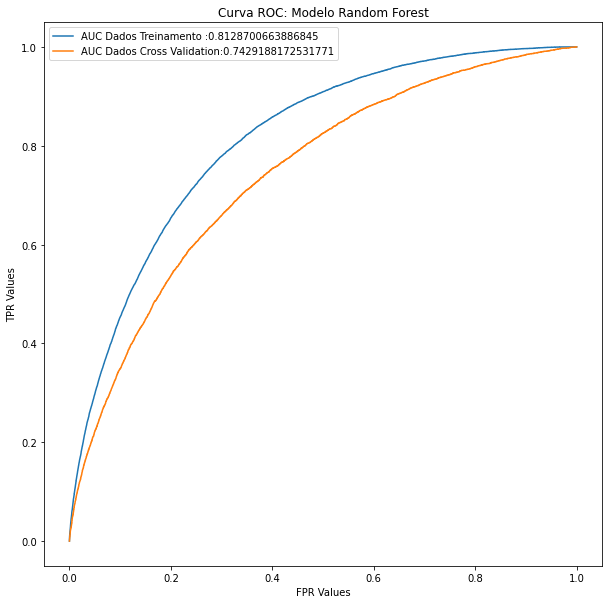

Threshold Ideal para o Dataset Cross Validation = 0.6434442156228554


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(train_f,train_t, label ="AUC Dados Treinamento :" + str(auc(train_f,train_t)))
plt.plot(cv_f,cv_r,label="AUC Dados Cross Validation:" + str(auc(cv_f,cv_r)))
plt.legend()

plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title('Curva ROC: Modelo Random Forest')

plt.grid(False)
plt.show()

print('Threshold Ideal para o Dataset Cross Validation =', obtain_threshold(train_threshold,cv_r,cv_f))

#####Matrix de Confusão

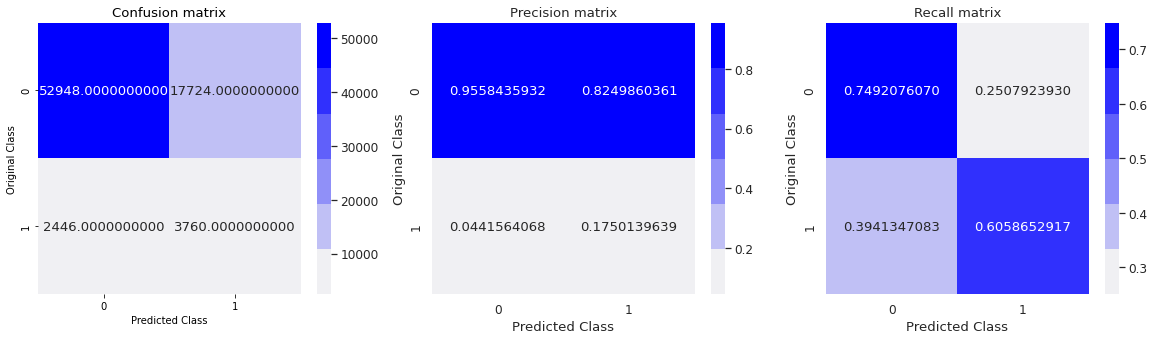

In [ ]:
Y_train_cv_final = Y_train_cv
y_pred_cv_final = rf_model.predict(X_train_cv)

plot_confusion_matrix(Y_train_cv_final, y_pred_cv_final)

####Variáveis mais importantes (Top 25)

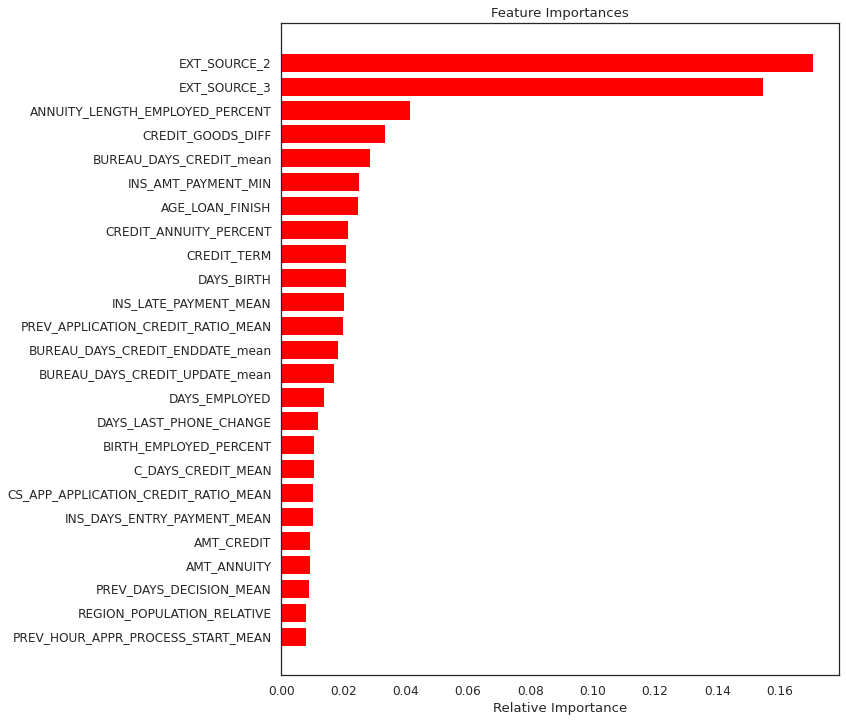

In [ ]:
features = X_train.columns
top25 = rf_model.feature_importances_
indices = (np.argsort(top25))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), top25[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Regressão Logística

####Escolha do hiperparametro Alpha

In [ ]:
# hiper parâmetros para o classificador SGD
alpha = [10 ** x for x in range(-5,2)] 

train_auc = []
cv_auc = []

array_roc_auc = []

for i in alpha:
  classifier = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 42, class_weight = 'balanced')
  classifier.fit(X_train_f, Y_train_f)

  classifier_sig = CalibratedClassifierCV(classifier, method = 'sigmoid')
  classifier_sig.fit(X_train_f, Y_train_f)

  Y_pred_train = batch_predict(classifier_sig, X_train_f)
  Y_pred_cv = batch_predict(classifier_sig, X_train_cv)
  
  train_auc.append(roc_auc_score(Y_train_f,Y_pred_train))
  cv_auc.append(roc_auc_score(Y_train_cv, Y_pred_cv))

  array_roc_auc.append(roc_auc_score(Y_train_cv, Y_pred_cv))
  print('Para valores Alpha = {}, o score da AUC é: {}'.format(i, roc_auc_score(Y_train_cv, Y_pred_cv)))

Para valores Alpha = 1e-05, o score da AUC é: 0.7513650525782559
Para valores Alpha = 0.0001, o score da AUC é: 0.7509317280318599
Para valores Alpha = 0.001, o score da AUC é: 0.7485151340465175
Para valores Alpha = 0.01, o score da AUC é: 0.7401614041594049
Para valores Alpha = 0.1, o score da AUC é: 0.705083192512508
Para valores Alpha = 1, o score da AUC é: 0.6651757647097964
Para valores Alpha = 10, o score da AUC é: 0.6315511369842195


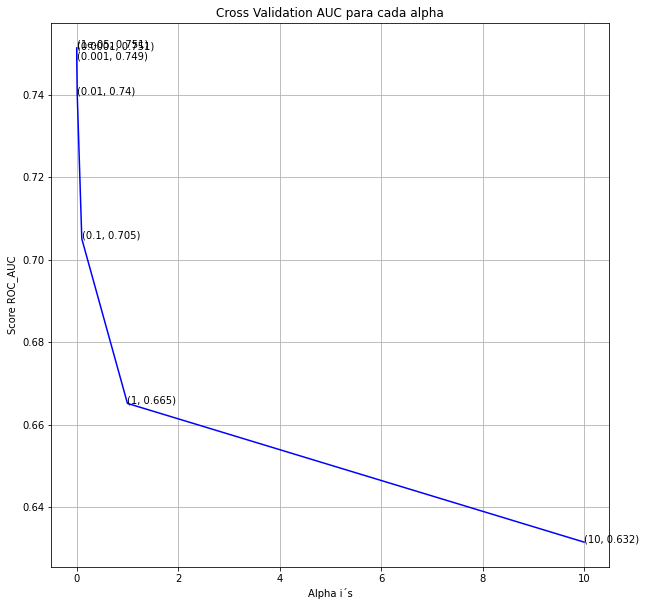

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, array_roc_auc, c = 'b')
for i, txt in enumerate(np.round(array_roc_auc, 3)):
  ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], array_roc_auc[i]))
plt.grid()
plt.title("Cross Validation AUC para cada alpha")
plt.xlabel("Alpha i´s")
plt.ylabel('Score ROC_AUC')
plt.show() 

####Treino do Modelo

In [ ]:
best_alpha = np.argmax(array_roc_auc)

classifier = SGDClassifier(alpha = alpha[best_alpha], penalty = 'l2', loss = 'log', random_state = 42)
classifier.fit(X_train_f, Y_train_f)

classifier_sig = CalibratedClassifierCV(classifier, method='sigmoid')
classifier_sig.fit(X_train_f, Y_train_f)

Y_train_pred = batch_predict(classifier_sig, X_train_f)
print("Para valores de melhor Alpha = {}, a AUC de treinamento é: {}".format(alpha[best_alpha], roc_auc_score(Y_train_f, Y_train_pred)))

Y_cv_pred = batch_predict(classifier_sig, X_train_cv)
print("Para valores de melhor Alpha = {}, a AUC de Cross Validation é: {}".format(alpha[best_alpha], roc_auc_score(Y_train_cv, Y_cv_pred)))

Para valores de melhor Alpha = 0.0001, a AUC de treinamento é: 0.750348991882324
Para valores de melhor Alpha = 0.0001, a AUC de Cross Validation é: 0.7490802763339808


####Validações

#####Área da Curva Roc

In [ ]:
train_f, train_t, train_threshold = roc_curve(Y_train_f, classifier_sig.predict_proba(X_train_f)[:,1])
cv_f, cv_t, cv_threshold = roc_curve(Y_train_cv, classifier_sig.predict_proba(X_train_cv)[:,1])


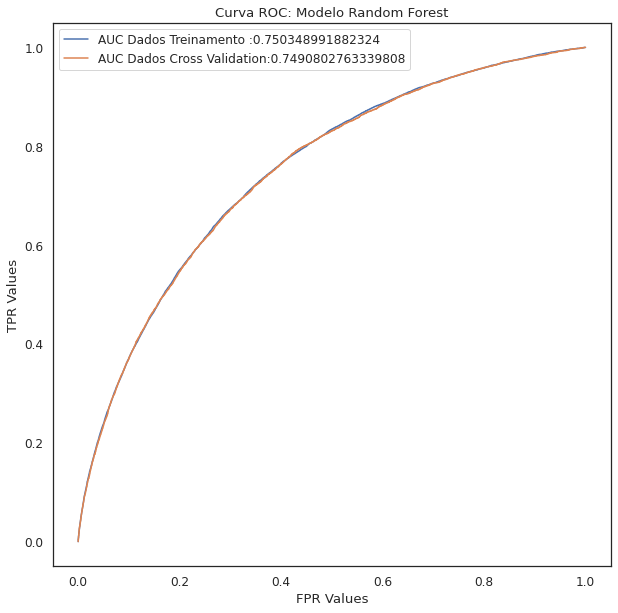

Threshold Ideal para o Dataset Cross Validation = 0.20099341533608936


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(train_f,train_t, label ="AUC Dados Treinamento :" + str(auc(train_f,train_t)))
plt.plot(cv_f,cv_t,label="AUC Dados Cross Validation:" + str(auc(cv_f,cv_t)))
plt.legend()

plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title('Curva ROC: Modelo Regressão Logística')

plt.grid(False)
plt.show()

print('Threshold Ideal para o Dataset Cross Validation =', obtain_threshold(train_threshold,cv_t,cv_f))

#####Matrizes de Confusão

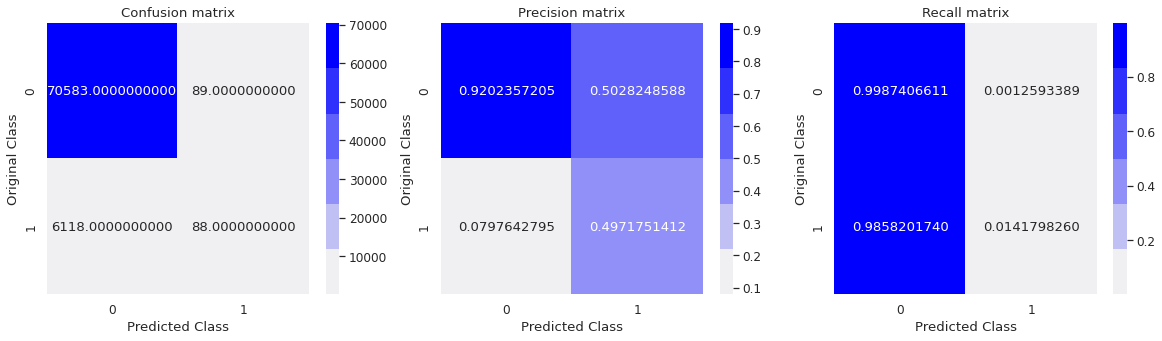

In [ ]:
Y_train_cv_final = Y_train_cv
y_pred_cv_final = classifier_sig.predict(X_train_cv)

plot_confusion_matrix(Y_train_cv_final, y_pred_cv_final)

###Extreme Gradient Boosting (XGBoost)

####Escolha de Hiper Parametros

In [ ]:
min_child_weight = [4, 5, 6, 7, 8, 9, 10]

train_auc = []
cv_auc = []

array_roc_auc = []

for i in min_child_weight:
  xgb_model = xgb.XGBClassifier(objective='binary:logistic', min_child_weight = i, n_jobs = 3)
  xgb_model.fit(X_train_f, Y_train_f)

  Y_pred_train = batch_predict(xgb_model, X_train_f)
  Y_pred_cv = batch_predict(xgb_model, X_train_cv)

  train_auc.append(roc_auc_score(Y_train_f, Y_pred_train))
  cv_auc.append(roc_auc_score(Y_train_cv, Y_pred_cv))

  array_roc_auc.append(roc_auc_score(Y_train_cv, Y_pred_cv))
  print('Para os valores min_child_weight = {}, o score da Curva ROC é {}'.format(i, roc_auc_score(Y_train_cv, Y_pred_cv)))

Para os valores min_child_weight = 4, o score da Curva ROC é 0.7593598986673744
Para os valores min_child_weight = 5, o score da Curva ROC é 0.7593598986673744
Para os valores min_child_weight = 6, o score da Curva ROC é 0.7589455645033314
Para os valores min_child_weight = 7, o score da Curva ROC é 0.7591286362124744
Para os valores min_child_weight = 8, o score da Curva ROC é 0.7591401127510233
Para os valores min_child_weight = 9, o score da Curva ROC é 0.7591401127510233
Para os valores min_child_weight = 10, o score da Curva ROC é 0.7591282087065683


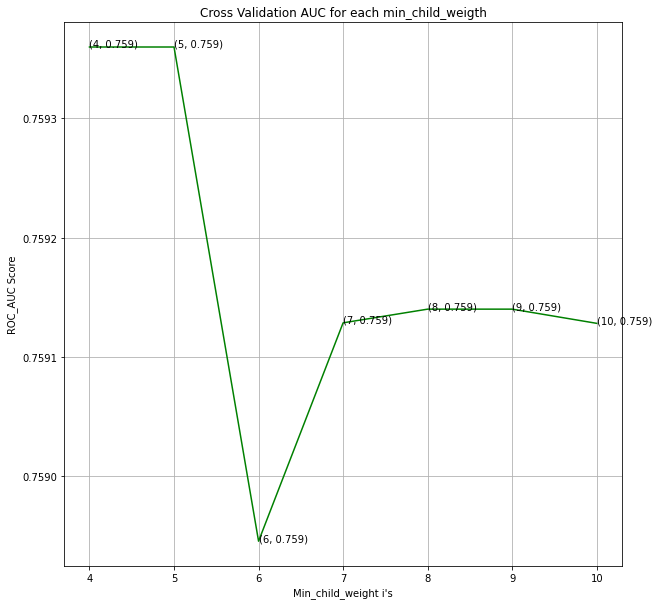

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(min_child_weight, array_roc_auc,c='g')
for i, txt in enumerate(np.round(array_roc_auc,3)):
    ax.annotate((min_child_weight[i],np.round(txt,3)), (min_child_weight[i],array_roc_auc[i]))
plt.grid()
plt.title("Cross Validation AUC for each min_child_weigth")
plt.xlabel("Min_child_weight i's")
plt.ylabel("ROC_AUC Score")
plt.show()

####Treino do Modelo

In [ ]:
best_weight = np.argmax(array_roc_auc)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', min_child_weight=best_weight, n_jobs=3)
xgb_model.fit(X_train_f,Y_train_f)

Y_pred_train = batch_predict(xgb_model, X_train_f)
print('Para os valores de melhor min_child_weight = {}, a AUC é: {}'.format(min_child_weight[best_weight],roc_auc_score(Y_train_f, Y_pred_train)))
Y_pred_cv = batch_predict(xgb_model, X_train_cv)
print('Para os valores de melhor min_child_weight = {}, a AUC é: {}'.format(min_child_weight[best_weight],roc_auc_score(Y_train_cv, Y_pred_cv)))

Para os valores de melhor min_child_weight = 4, a AUC é: 0.7634443280248293
Para os valores de melhor min_child_weight = 4, a AUC é: 0.7592849221115704


####Validações

#####Área da Curva ROC

In [ ]:
train_f, train_t, train_threshold = roc_curve(Y_train_f, xgb_model.predict_proba(X_train_f)[:,1])
cv_f, cv_t, cv_threshold = roc_curve(Y_train_cv, xgb_model.predict_proba(X_train_cv)[:,1])

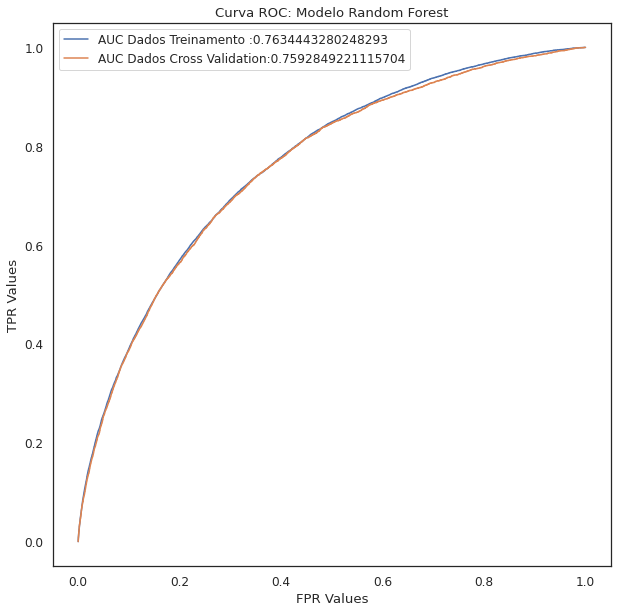

Threshold Ideal para o Dataset Cross Validation = 0.19149368


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(train_f,train_t, label ="AUC Dados Treinamento :" + str(auc(train_f,train_t)))
plt.plot(cv_f,cv_t,label="AUC Dados Cross Validation:" + str(auc(cv_f,cv_t)))
plt.legend()

plt.xlabel("FPR Values")
plt.ylabel("TPR Values")
plt.title('Curva ROC: Modelo XGBoost')

plt.grid(False)
plt.show()

print('Threshold Ideal para o Dataset Cross Validation =', obtain_threshold(train_threshold,cv_t,cv_f))

#####Matrizes de Confusão

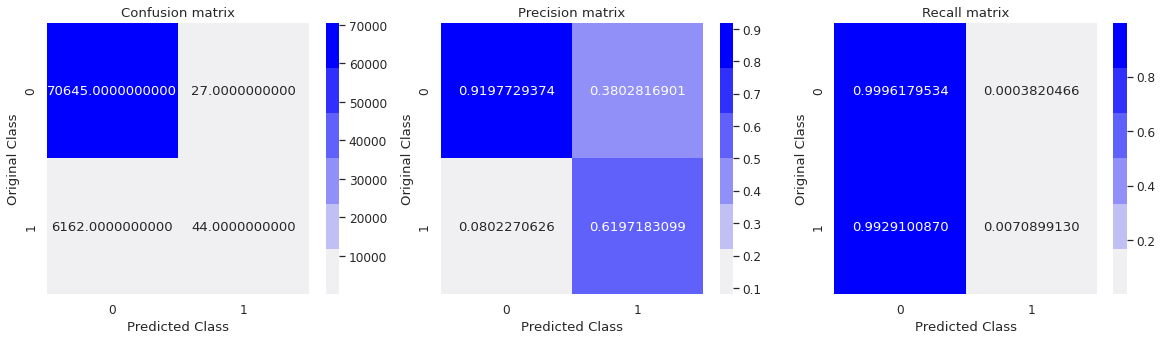

In [ ]:
Y_train_cv_final = Y_train_cv
y_pred_cv_final = xgb_model.predict(X_train_cv)

plot_confusion_matrix(Y_train_cv_final, y_pred_cv_final)

###Variáveis mais importantes (Top 25)

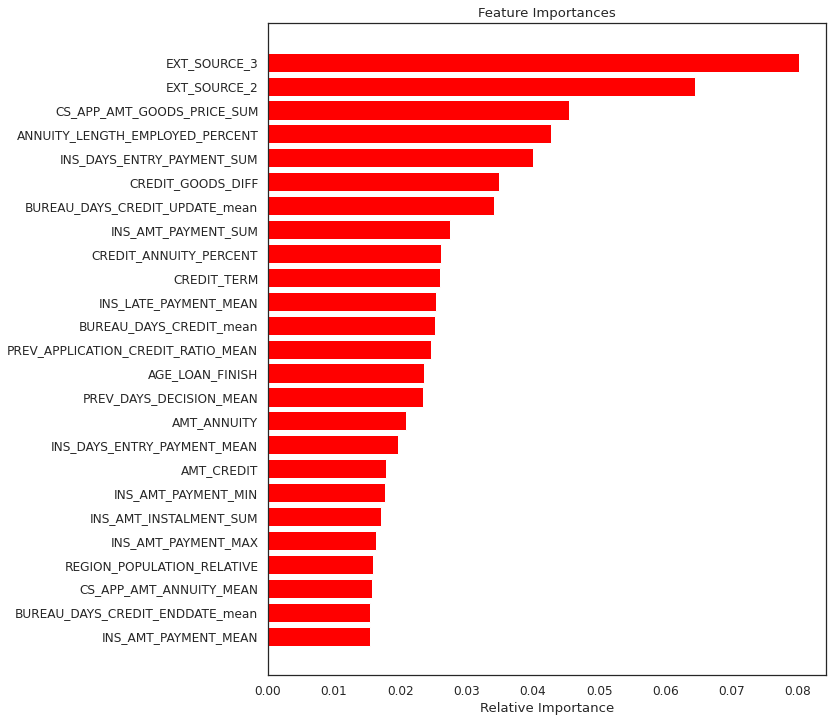

In [ ]:
features = X_train.columns
top25 = xgb_model.feature_importances_
indices = (np.argsort(top25))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), top25[indices], color='red', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()